### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty
#### CREATING SYNTHETIC TRUTH

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


In [1]:
import pandas as pd
import numpy as np
import subprocess
import sys
import os
import pickle
import functions # This is a project specific python script saved in folder functions.py

%load_ext autoreload
%autoreload 2
  
%run ./figures.ipynb                   # Contains functions to produce figures
logfunc = lambda e: np.log10(e)

### 1. Project parameters

In [17]:
from loop2flopy import Project
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.results = '../results/'

if not os.path.isdir(P.workspace): os.makedirs(P.workspace, exist_ok=True)
if not os.path.isdir(P.results): os.makedirs(P.results, exist_ok=True)
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2000, 2500), (2500, 2500),] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (3000, 1500), (3800, 3000), (1500, 3500), (4500,4500)]
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 30000 
P.modelmaxtri = 30000 # 10000 for ref
P.angle = 34   # minimum triangle angles

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 100000

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 2    # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)
P.res = 2    # vertical resolution upon which voxel grid created to pick lithology bottoms

P.hk = [1.7, 0.07, 8.2, 0.05] 
P.vk = [0.12,0.007,0.51,0.005] 
P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = 0.

P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.005 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.1)] # period length, number of timesteps, tsmult
P.qwell_past = -3000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.1)] # period length, number of timesteps, tsmult
P.qwell_future = -6000 #m3/d 

pickle.dump([P.hk, P.vk, P.ss, P.sy], open(P.results + 'reference.pkl','wb')) # Save hydraulic parameters of TRUTH MODEL   

In [18]:
for i in P.hk: print(logfunc(i))
for i in P.vk: print(logfunc(i))
for i in P.ss: print(logfunc(i))

0.2304489213782739
-1.154901959985743
0.9138138523837167
-1.3010299956639813
-0.9208187539523752
-2.154901959985743
-0.2924298239020636
-2.3010299956639813
-4.045757490560675
-4.154901959985743
-4.698970004336019
-4.096910013008056


### 2. Meshing

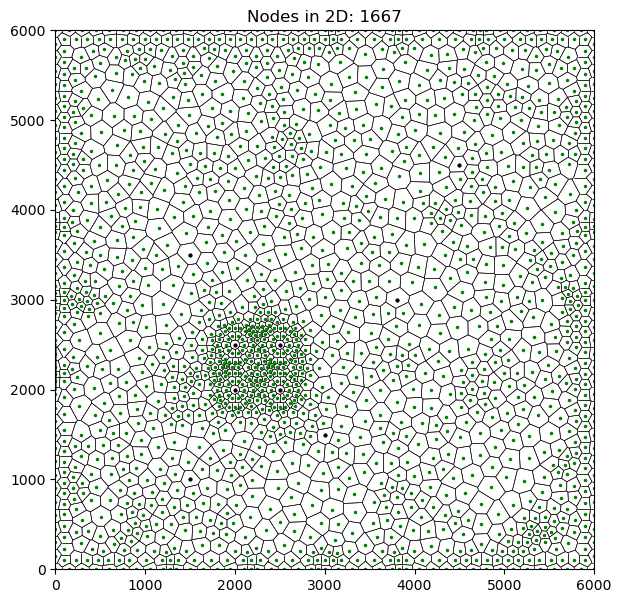

In [19]:
from meshing_routines import createcell2d
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, P.vornodes = createcell2d(P, grid = 'vor', fault = False)      

from meshing_routines import plot_cell2d_vor
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   ID data_type     X     Y      Z  val lithcode feature_name  gx  gy  gz
0  P1       raw   500   500  -50.0  -50        a        upper   0   0   1
1  P1       raw   500   500 -350.0 -100        b        lower   0   0   1
2  P1       raw   500   500 -450.0 -200        c        lower   0   0   1
3  P2       raw  2500  2500  -50.0  -50        a        upper   0   0   1
4  P2       raw  2500  2500 -150.0 -100        b        lower   0   0   1
5  P2       raw  2500  2500 -250.0 -200        c        lower   0   0   1
6  P3       raw  3000  3000    NaN  -50        a        upper   0   0   1
7  P3       raw  3000  3000    NaN -100        b        lower   0   0   1
8  P3       raw  3000  3000 -100.0 -200        c        lower   0   0   1
dict_keys(['upper', 'upper_unconformity', 'lower'])


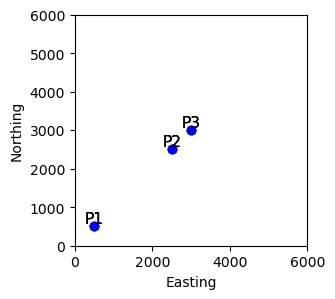

In [20]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example") # CPz = -100
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

print(P.data)
print(P.geomodel.feature_names())
from geomodel_routines import plot_bores
plot_bores(P)

### 4. Set up Flow model (Reference)

In [21]:
# Initiate REFERENCE
from loop2flopy import Model
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

# Sort out Well screens to be over entire geological layer
from modelling_routines import find_cell_disv
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        wel_top = R.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = R.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print('Well coords ', wel_coords, ' Well screen top and bottom ', wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))

zdepths = [-20, -100, -300] #zdepths = [-20, -60, -120]
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        P.zobs[n][m] = zdepths[m]
print('\nobservation depths')
print(P.zobs)


# NEED TO PICKLE P.zobs and P.wel_screens
pickle.dump(P.wel_screens, open(P.results + 'wel_screens.pkl','wb'))
pickle.dump(P.zobs, open(P.results + 'zobs.pkl','wb'))

# Create flow model arrays
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

   Creating lithology and discretisation arrays for  ref  ...
Well coords  (np.float64(2000.0), np.float64(2000.0))  Well screen top and bottom  -194.0 -306.0
Well coords  (np.float64(2500.0), np.float64(2000.0))  Well screen top and bottom  -162.0 -274.0
Well coords  (np.float64(2000.0), np.float64(2500.0))  Well screen top and bottom  -162.0 -274.0
Well coords  (np.float64(2500.0), np.float64(2500.0))  Well screen top and bottom  -138.0 -252.0

observation depths
[[ -20. -100. -300.]
 [ -20. -100. -300.]
 [ -20. -100. -300.]
 [ -20. -100. -300.]
 [ -20. -100. -300.]]
   Creating property arrays for  ref  ...
   Adding flow packages to  ref  ...
   Time taken =  1.137075
ref  has  13336  nodes.


### 5. Run Flow model (Reference)

In [22]:
results = R.write_run_model(P, period = 'Steady', ic_array = P.strt)
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Steady 
   Model success =  True
   run_time =  17.235331


In [23]:
results = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)
R.gwf, R.head_present, R.obs_present, R.runtime_past = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Past 
   Model success =  True
   run_time =  36.345417


In [24]:
results = R.write_run_model(P, period = 'Future', ic_array = R.head_present)
R.gwf, R.head_future, R.obs_future, R.runtime_future = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Future 
   Model success =  True
   run_time =  76.675313


### 6. Plot Results

Plotting routines loaded!


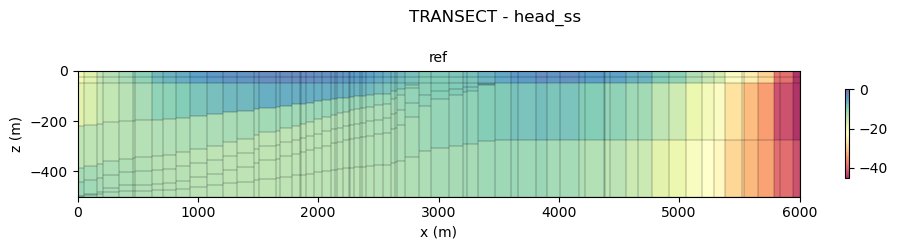

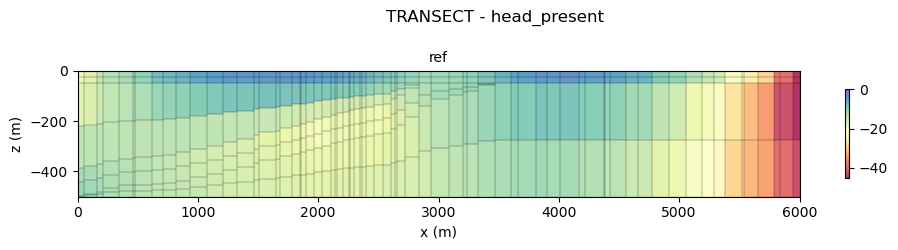

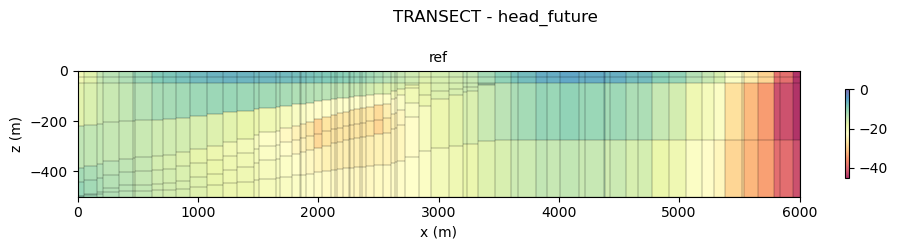

In [25]:
from plotting_routines import multiplot_prop_transect
multiplot_prop_transect(P, models = [R], array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_future', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)

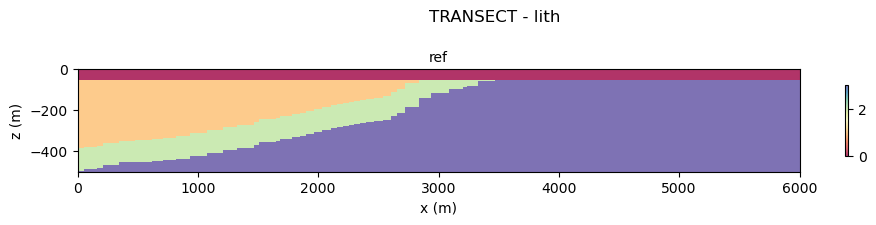

In [26]:
from plotting_routines import multiplot_vgrid_transect
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

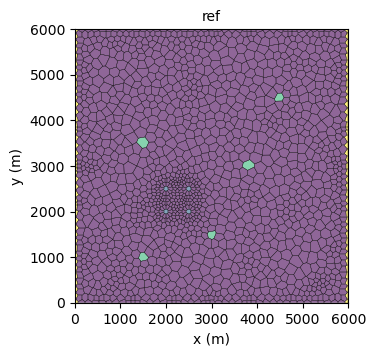

In [27]:
from plotting_routines import plot_flow_features
plot_flow_features(P, [R])

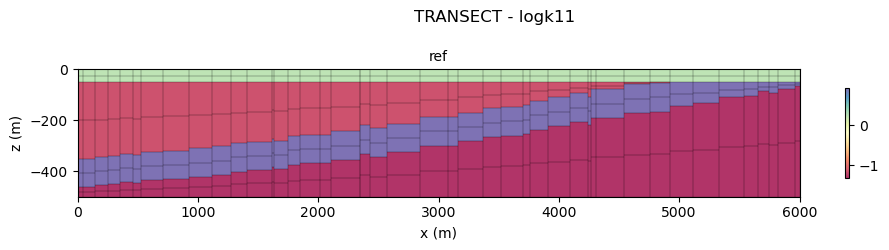

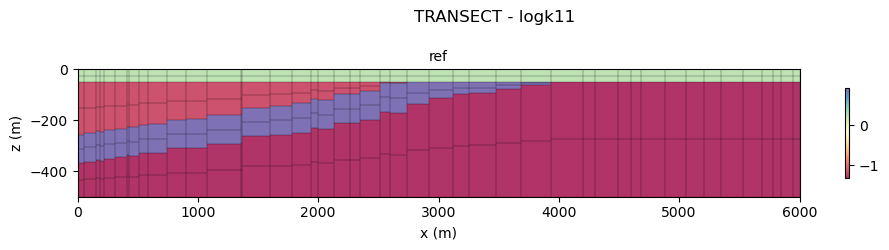

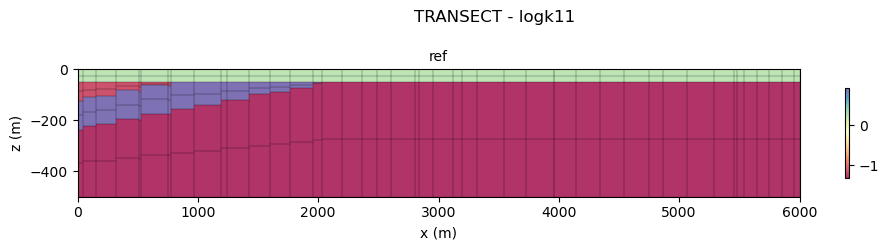

In [28]:
from plotting_routines import multiplot_prop_transect
y_ = [1000,3000,5000]
for y in y_:
    multiplot_prop_transect(P, models=[R], array ='logk11',X0=P.x0, Y0=y, X1=P.x1, Y1=y)#, vmin = -45, vmax = 0)

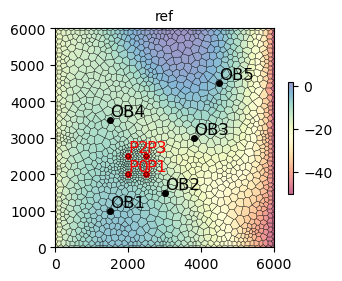

In [29]:
from plotting_routines import plot_bylayer
plot_bylayer(P, models = [R], layer = 0)#, vmin = -20, vmax = 5) 

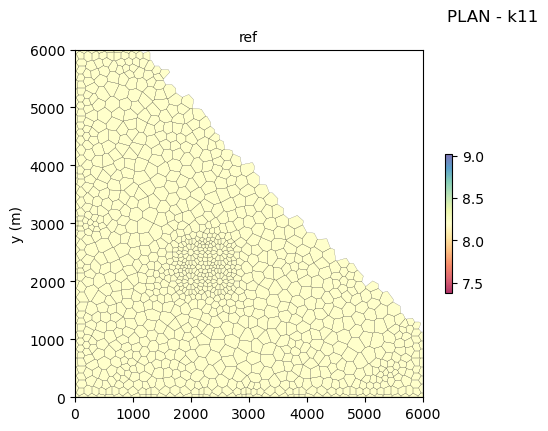

In [30]:
from plotting_routines import multiplot_prop_plan
multiplot_prop_plan(P, models = [R], array = 'k11', layer = 5)#, vmin = None, vmax = None)

In [31]:
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
f = os.path.join(vtk_workspace, "test", R.modelname)
R.gwf.export(f, fmt="vtk")

### 7. Create "truth" observations and plot observations

In [32]:
# Get convert obs package to arrays of oberservation heads
R.ref_steady  = functions.process_obs_steady(P, R)
R.ref_past    = functions.process_obs_past(P, R)
R.ref_future  = functions.process_obs_future(P, R)

# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365
csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2
times = list(times_past) + list(times_future)

# Pickle reference results
fname = P.results + 'ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(fname),'wb'))
fname = P.results + 'times.pkl'
pickle.dump(times, open(os.path.join(fname),'wb'))

Text(0, 0.5, 'Head (m)')

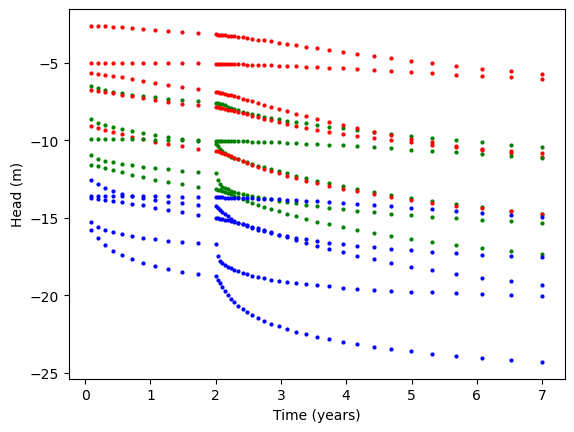

In [33]:
# PLOT REFERENCE OBSERVATIONS
import matplotlib.pyplot as plt
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

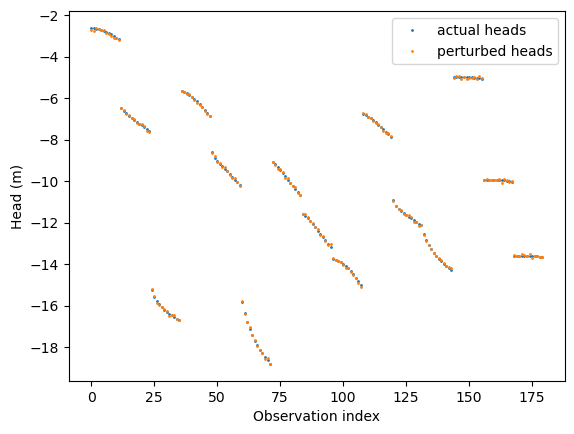

In [34]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.05
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', ms = 1, label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', ms = 1, label = 'perturbed heads')
plt.xlabel('Observation index')
plt.ylabel('Head (m)')
plt.legend()

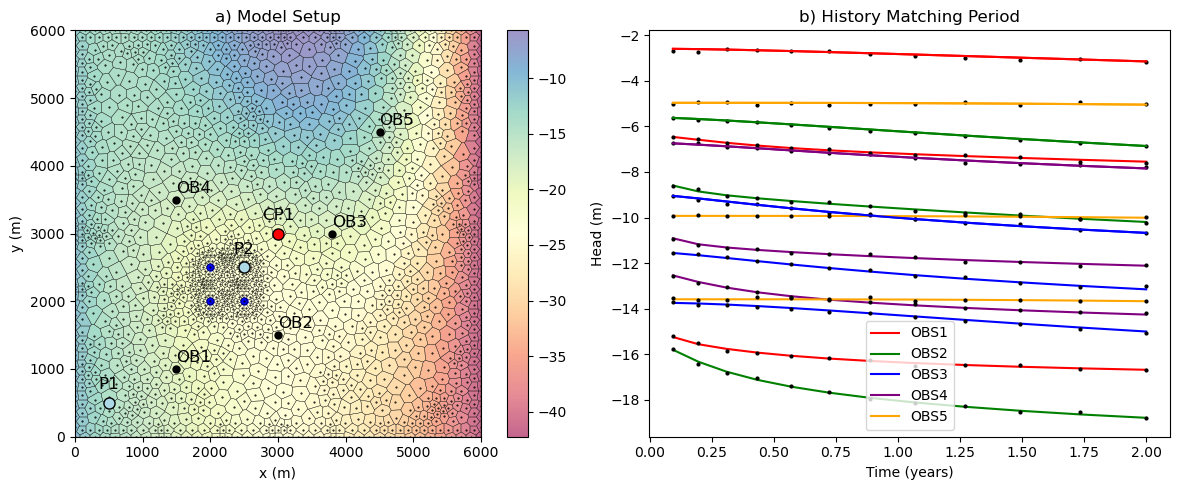

In [35]:
%run ./figures.ipynb   
figure8(P, R)

### 8. Prepare PEST input arrays

In [36]:
# PRINTING TRUTH HEADS FOR HISTORY MATCHING (PEST - HEADS.INS)
#hobs_ref.shape #(5, 3, 12)
#for i in range(P.nobs):
#    for j in range(P.nzobs):
#        for k in range(hobs_ref.shape[2]):
#            print('l1 [OBS%i_%i.%i]1:20' %(i, j, k))

In [37]:
# PRINTING TRUTH HEADS FOR HISTORY MATCHING (PEST - CONTROL.PST)
#for i in range(P.nobs):
#    for j in range(P.nzobs):
#        for k in range(hobs_ref.shape[2]):
#            print('OBS%i_%i.%i  %f  10.0  head' %(i, j, k, hobs_ref[i, j, k]))

### 9. Prepare parameter bounds

In [38]:
# LOG
k_min = [0, -2, 0, -2, -1, -2.5, -0.5, -2.5, -5, -5, -5]
k_max = [1, -1, 1, -1, 0, -1.5, 0.5, -1.5, -4, -4, -4]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]

print(k_min)
print(k_max)
print(k_mean)

[0, -2, 0, -2, -1, -2.5, -0.5, -2.5, -5, -5, -5]
[1, -1, 1, -1, 0, -1.5, 0.5, -1.5, -4, -4, -4]
[0.5, -1.5, 0.5, -1.5, -0.5, -2.0, 0.0, -2.0, -4.5, -4.5, -4.5]


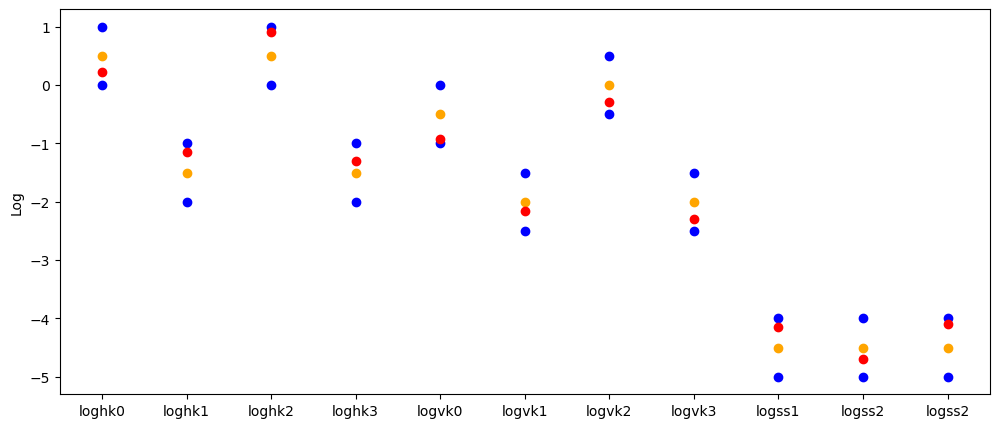

In [39]:
pickleoff = open('../results/reference.pkl','rb')
reference = pickle.load(pickleoff)
pickleoff.close()

# BLUE - MAX/MIN
# ORANGE - MEAN
# RED - ACTUAL
fig = plt.figure(figsize = (12,5))
plt.plot(np.linspace(0,10,11), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,10,11), logfunc(reference[0] + reference[1] + reference[2][1:]), 'o', color = 'red')
plt.ylabel('Log')
plt.xticks(np.linspace(0,10,11), ['loghk0', 'loghk1', 'loghk2', 'loghk3', 
                                'logvk0', 'logvk1', 'logvk2', 'logvk3',
                                'logss1', 'logss2', 'logss2'])#, logss1, logss2, logss3, sy0, cp])
plt.show()

### 10. DREAM MCMC

#### Set parameter priors

In [40]:
   
Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(4):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i])
    Width.append((k_max[i] - k_min[i])/2.)
    Min.append(k_min[i]) 
    Max.append(k_max[i]) 

#make this anisotropy
for i in range(4):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i+4])
    Width.append((k_max[i+4] - k_min[i+4])/2.)
    Min.append(k_min[i+4]) 
    Max.append(k_max[i+4])
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(k_mean[i+8])
    Width.append((k_max[i+8] - k_min[i+8])/2.)
    Min.append(k_min[i+8]) 
    Max.append(k_max[i+8])
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.075)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(125)
Min.append(-250)
Max.append(0)

print(Mean)
print(Width)

[0.5, -1.5, 0.5, -1.5, -0.5, -2.0, 0.0, -2.0, -4.5, -4.5, -4.5, 0.125, -125]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.075, 125]


#### Set up DREAM 

In [41]:
sys.path.append('../../Lab_tools/Uncertainty_tools')  
from DREAM import *

def Likelihood(obs, mod, err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

## DREAM for Steady State
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 100
minsamp = 169 # minimum number of samples

MCMC = [Min, Mean, Max, nchains, npars, nburn]
pickle.dump(MCMC, open(P.results + 'MCMC.pkl','wb'))


In [42]:
D = DREAM(nchains, npars, nburn = nburn, npairs = 1) # -3 randomly chooses between 1 and 3 pairs for proposition 
D.par_set(Log, Unif, Mean, Width, Min, Max) #initialise the class
D.set_CR(ncr = 3)  #crossover testing. Use 3
D.k = 1 # Number of things to try each chain. Numbers other than 1 can give weird results for some models

In [43]:
#### Define "update model" function

In [50]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
    
# Include this here when ignoring structural parameters
#P.control_points = ([])#(['CP1', 'control', 3000, 3000, -100, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

from datetime import datetime
geo_model_runtime, flow_model_runtime = [], []

def update_model(P, hk0, hk1, hk2, hk3, vk0, vk1, vk2, vk3, ss1, ss2, ss3, sy0, cp):
    print(hk0, hk1, hk2, hk3, vk0, vk1, vk2, vk3, ss1, ss2, ss3, sy0, cp)
    t0 = datetime.now()
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    P.hk = [10**hk0, 10**hk1, 10**hk2, 10**hk3]
    P.vk = [10**vk0, 10**vk1, 10**vk2, 10**vk3] 
    P.ss = [0.00009, 10**ss1, 10**ss2, 10**ss3]
    P.sy = [sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', 0, 0, 1],) 
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    
    t1 = datetime.now()
    geo_model_runtime.append((t1 - t0).total_seconds())

    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt)
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = results[0], results[1], results[2], results[-1]
    
    results = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    M.gwf, M.head_past, M.obs_past, M.runtime_past = results[0], results[1], results[2], results[-1]

    flow_model_runtime.append(M.runtime_ss + M.runtime_past)
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = functions.process_obs_past(P, M)

    pickle.dump([geo_model_runtime, flow_model_runtime], open(P.results + 'run_times.pkl','wb'))
    return(hobs_past, M)

In [51]:
def run_prediction(M, ic_array):
    results = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    M.gwf, M.head_future, M.obs_future = results[0], results[1], results[2]
    hpred = functions.process_obs_future(P, M)
    return hpred

In [52]:
### Run model with truth parameters
heads = update_model(P, 
                     logfunc(1.7), logfunc(0.07), logfunc(8.2), logfunc(0.05), 
                     logfunc(0.12), logfunc(0.007), logfunc(0.51), logfunc(0.005), 
                     logfunc(0.00007), logfunc(0.00002), logfunc(0.00008), 0.12, -100)    

0.2304489213782739 -1.154901959985743 0.9138138523837167 -1.3010299956639813 -0.9208187539523752 -2.154901959985743 -0.2924298239020636 -2.3010299956639813 -4.154901959985743 -4.698970004336019 -4.096910013008056 0.12 -100
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.990188
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  88.479337


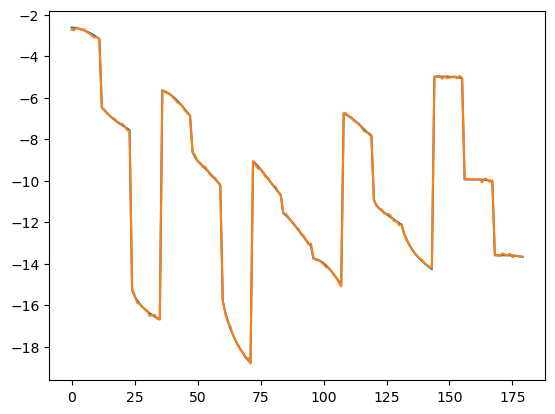

In [53]:
plt.plot(heads[0].flatten())
plt.plot(hobs_ref.flatten())

In [56]:
#this function and argument statement are for the labtools dream implementation.
def L_func(Prop, P, hobs_ref, err):
    hmod, M = update_model(P,
                        Prop[0],
                        Prop[1],
                        Prop[2],
                        Prop[3],
                        Prop[4],
                        Prop[5],
                        Prop[6],
                        Prop[7],
                        Prop[8],
                        Prop[9],
                        Prop[10],
                        Prop[11],
                        Prop[12],
                        ) 
    a = np.array(hobs_ref) 
    b = np.array(hmod)
    P.hmod = hmod
    P.M = M
    return(Likelihood(a,b,err))
    
args = (P, hobs_ref, err,) # P - project object, hobs_ref - real observations, err - 
    
def result_func(Prop,P):
    M = P.M
    hpred = run_prediction(M, ic_array = M.head_past)
    overall = np.append(P.hmod,hpred,axis=2)
    #print(overall)
    return(overall)

Rfunc_args = (P,)
    

In [ ]:
"""for i in range(nchains):
    D.chains[i].current = ldum[i]"""

print('Launched DREAM at ', datetime.now())
results = Dream_ZS(D,       # DREAM class being used.
                   L_func,  # function that recieves the proposed pars, places in model, runs model & returns Likelihood 
                   args,    # contains all the args for the model outside of the parameters
                   result_func = result_func,      # save the model outputs
                   result_func_args = Rfunc_args,  
                   minsamp = minsamp,         
                   print_freq = 1,
                   Test = False,      # If True, only initial likelihoods obtained
                   lookback = 10,     # 10
                   R_overide = False)  # Stops even if R=1.2 not reached

Launched DREAM at  2024-11-01 22:45:30.695303
Chain  0
0.33712440584037584 -1.2709003630371571 0.6431725807063562 -1.1245500624435922 -0.21009652602363416 -1.8909235429745506 0.4368951799882167 -2.1419911516139436 -4.083075615559935 -4.365379988014149 -4.5238615899224905 0.1537077821191872 -60.14530661928799
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.285931
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.339756
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.142221
Initial Likelihood for chain  0  =  -149386.9357717456
Chain  1
0.5510212001027261 -1.5149233244037408 0.9561073843021102 -1.1911898412668211 -0.33352923460852557 -2.1869796979755143 -0.26778733053185333 -2.148231210422802 -4.225653363365851 -4.845162612925034 -4.5244994218342205 0.1852350040739456 -38.42418813281887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.30887
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  56.536025
Initial Likelihood for chain  1  =  -488572.30821124563
Chain  2
0.9112818931685158 -1.0368032125207163 0.30427071583883936 -1.2723766434659036 -0.04818661094921706 -1.8437351275832183 0.2934563580650058 -1.8888705420128011 -4.013953304726566 -4.1379193359067985 -4.055408867376412 0.17112233668585153 -215.40088413454646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.273521
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.480728
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  69.3523


Initial Likelihood for chain  2  =  -3730698.787546897
Chain  3
0.40659664154333053 -1.0016568377218995 0.9487834526658528 -1.8152656813737629 -0.8198569940578209 -2.2952258778144667 0.031112173400884346 -2.2875158068640316 -4.305551835689006 -4.615482941167207 -4.644276585556081 0.17509596345350764 -86.23711116057754
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.052554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.050566
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  70.968225
Initial Likelihood for chain  3  =  -95823.08212757204
Chain  4
0.756043646897875 -1.0387940433388687 0.19010954598179686 -1.1530252905058085 -0.4474319437205825 -2.116668319442994 0.14181603642166918 -1.6452335360328687 -4.055207121437956 -4.21073279022521 -4.082151203546721 0.07227864278696948 -14.494024455686798
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  4.373263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.698208
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  64.940451
Initial Likelihood for chain  4  =  -796433.927265906
0.3333333333333333
[ 0.          0.03713721  0.          0.          0.          0.
  0.         -0.64228227  0.         -0.40475015  0.          0.10281732
  0.        ]
0.33712440583955294 -1.2535663345746864 0.643172580707281 -1.1245500624432772 -0.2100965260254222 -1.8909235429746527 0.4368951799900188 -2.441780513175873 -4.083075615558695 -4.5542997120271815 -4.523861589921355 0.0516984247370257 -60.14530661928705
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.04704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.95069
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  43.587786
[-114325.32658344] -149386.9357717456
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.10824618
  0.         -0.1392846   0.          0.         -0.11977716  0.
  0.        ]
35061.60918830219 inf
1.0
[ 4.18919241e-01  2.14772291e-01 -4.53063035e-01 -2.84752281e-02
 -2.37335418e-01 -2.25744776e-01 -2.95079144e-01  7.96546977e-01
  2.78684941e-02  3.43566922e-01  4.41710386e-01  2.05802180e-02
  4.56512822e+01]
0.7465544376308637 -1.41467698257691 0.7446373125036477 -1.2044808362547874 -0.4443070601497551 -2.292347517527226 -0.4055174097786441 -1.776437809645333 -4.212645565331834 -4.684800552784852 -4.318328271328158 0.19484095259401188 -17.116159940411084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.326278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.2818

   run_time =  29.812112
[-943745.75490054] -488572.30821124563
0.3333333333333333
[-0.15523825  0.          0.          0.         -0.39924533  0.
 -0.15164032  0.         -0.04125382 -0.07281345  0.          0.
  0.        ]
-455173.4466892974 0.0
1.0
[-3.49447005e-01  3.71372056e-02  7.58673907e-01 -6.62240391e-01
 -3.72425050e-01 -1.78557558e-01 -1.10703863e-01 -6.42282271e-01
 -2.50344714e-01 -4.04750151e-01 -5.62125382e-01  1.02817321e-01
 -7.17430867e+01]
0.7481752663890395 -1.0194691840605838 0.6583866185332926 -1.5814815853212472 -0.22201838732076898 -1.9270780110116006 0.2417846213130337 -2.1886599035751617 -4.1308033027170215 -4.326839059920337 -4.317784487947502 0.06911297930556189 -248.88742912667047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.24358
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.655343

   run_time =  44.297769
[-7023108.94050998] -3730698.787546897
0.3333333333333333
[ 0.          0.          0.          0.          0.23733542  0.22574478
  0.         -0.49675762  0.          0.          0.          0.
  0.        ]
-3292410.152963082 0.0
1.0
[-1.44424559e-01  5.13266487e-01 -7.32393164e-03 -6.24075840e-01
 -4.86327759e-01 -1.08246180e-01  2.98899504e-01 -1.39284596e-01
 -7.98984723e-02  2.29679672e-01 -1.19777164e-01 -1.01390406e-02
 -4.78129230e+01]
0.3391855542823307 -1.7620864193219057 0.945364960688898 -1.1065570748466045 -0.04685358907195525 -2.345750475206027 0.1706254303046475 -2.3525277839006637 -4.342844959126059 -4.508278484049779 -4.700183343492937 0.17036350133683265 -108.55409906437313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119251
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.

   run_time =  66.0438
[-375495.45331528] -95823.08212757204
0.3333333333333333
[-0.57415749  0.          0.          0.         -0.16190992  0.
  0.         -0.55290997  0.          0.          0.         -0.11942391
  0.        ]
-279672.37118771055 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.7560436468968311 -1.0387940433365883 0.1901095459791596 -1.1530252905062228 -0.447431943720639 -2.1166683194439115 0.14181603642233573 -1.6452335360328856 -4.0552071214392 -4.210732790225013 -4.082151203547365 0.07227864278554604 -14.494024455687862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.547309
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  30.427784
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  66.943703
[-796438.87497155] -796433.927265906
0.6666666666666666
[ 5.74157487e-01  2.34097151e-01 -3.38901865e-01 -1.47826581e-01
  1.61909915e-01  4.71884154e-02 -1.43438822e-01  2.53120610e-01
  6.91223108e-02  0.00000000e+00  4.68452723e-01  1.74145546e-02
 -1.55255578e+02]
-4.947705639293417 0.0070996794822891325
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  1
sampled =   1.0  tried =  5.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -114325.32658344341
Current Likelihood for chain  1  =  -488572.30821124563
Current Likelihood for chain  2  =  -3730698.787546897
Current Likelihood for chain  3  =  -95823.08212757204
Current Likelihood for chain  4  =  -796433.927265906
1
0.3333333333333333
[-0.36026069  0.          0.          0.          0.          0.
 -0.56124369  0.          0.         -0.70724328  0.          0.
  0.        ]
0.16897042109484128 -1.2535663345732253 0.6431725807

[-284893.94767483] -114325.32658344341
0.3333333333333333
[0.         0.         0.         0.         0.         0.45149075
 0.         0.39864526 0.29159853 0.         0.         0.
 0.        ]
-170568.62109138296 0.0
0.6666666666666666
[ 0.00000000e+00 -3.51463748e-02 -6.44512737e-01  0.00000000e+00
  7.71670383e-01  4.51490750e-01  2.62344185e-01  3.98645265e-01
  2.91598531e-01  4.77563605e-01  0.00000000e+00  0.00000000e+00
 -1.29163773e+02]
0.551021200101949 -1.5313281198349238 0.655276938456629 -1.1911898412672601 -0.9733471433450163 -1.9762435000282257 -0.1453365029085387 -1.9621609810750027 -4.089547882332866 -4.622256742984567 -4.524499421833596 0.18523500407497948 -98.71220602691417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.056268
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.579325
   Writing simul

   run_time =  45.632248
[-361209.57193337] -488572.30821124563
1.0
[-0.06947224 -0.2519095  -0.30561087  0.69071562  0.60976047  0.40430233
  0.40578301 -0.15426471  0.22247622  0.06118323  0.120415   -0.12339754
 26.09180454]
127362.73627787922 inf
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  3.38901865e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.91223108e-02 -2.27460652e-01 -4.68452723e-01  0.00000000e+00
  1.55255578e+02]
0.9112818931681446 -1.0368032125208975 0.4624553307910004 -1.2723766434640853 -0.04818661095141639 -1.8437351275841751 0.2934563580672287 -1.8888705420119665 -4.04621658580296 -4.244088051396177 -4.2740621744844844 0.17112233668750523 -142.93434944073027
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  4.116205
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_t

[-2421615.42241207] -3730698.787546897
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.29679672e-01  0.00000000e+00  1.01390406e-02
  4.78129230e+01]
1309083.3651348306 inf
0.6666666666666666
[ 0.20502245  0.         -0.46516739  0.03816455  0.5259152   0.
  0.          0.31692745  0.03434076  0.41152395  0.44234822 -0.11295636
  0.        ]
0.502292181063891 -1.0016568377212638 0.7316635943983684 -1.797452132991886 -0.5743827079190132 -2.295225877814116 0.03111217340024465 -2.1395878930389975 -4.289523065705078 -4.4234015017937836 -4.437807722920054 0.12237285871637922 -86.23711116057808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.231322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.547573
   W

   run_time =  41.399428
[-158830.45399384] -95823.08212757204
0.3333333333333333
[ 0.          0.00199083  0.27234578  0.          0.          0.
  0.15164032  0.          0.         -0.03335526  0.          0.
  0.        ]
-63007.37186626828 0.0
1.0
[  0.06947224   0.2519095    0.30561087  -0.69071562  -0.60976047
  -0.40430233  -0.40578301   0.15426471  -0.22247622  -0.06118323
  -0.120415     0.12339754 -26.09180454]
0.7884702576490228 -1.9212136730513762 0.3327553768780213 -1.4754212273454468 -0.7320415456338253 -2.30537902242358 -0.04758577957608934 -1.5732294968167144 -4.159049321394495 -4.239290454097658 -4.138355673611667 0.12987523392857828 -26.672541255393003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.186585
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.176488
   Writing simulation and gwf for  run  .

   run_time =  31.197562
[-721771.44337891] -796433.927265906
0.3333333333333333
[-8.22897306e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.02140518e-13  0.00000000e+00  0.00000000e+00
  1.23989707e-12  0.00000000e+00  0.00000000e+00 -1.02009357e-01
  0.00000000e+00]
74662.48388700094 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  2
sampled =   4.0  tried =  10.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -114325.32658344341
Current Likelihood for chain  1  =  -361209.5719333664
Current Likelihood for chain  2  =  -2421615.4224120663
Current Likelihood for chain  3  =  -95823.08212757204
Current Likelihood for chain  4  =  -721771.4433789051
2
0.6666666666666666
[-1.44424559e-01  5.29671282e-01  2.93506514e-01 -6.24075840e-01
  0.00000000e+00 -3.18982378e-01  0.00000000e+00  0.00000000e+00
 -2.16003953e-01  0.00000000e+00 -1.19777164e-01 -1.01390406e-02
  1.24750949e+01]


   run_time =  30.376961
[-201559.73159666] -114325.32658344341
0.3333333333333333
[ 0.45134585 -0.66764734  0.          0.          0.         -0.41445548
 -0.48448096  0.         -0.07597371  0.31500926  0.38550592  0.
 33.47276536]
-87234.40501321168 0.0
0.3333333333333333
[ 0.          0.          0.48632812  0.         -0.77167038  0.
  0.         -0.39864526  0.         -0.37139489 -0.37021441  0.00397363
  0.        ]
0.5510212001006707 -1.5313281198347066 0.8822737026362241 -1.191189841266503 -0.3335292346074452 -1.9762435000298189 -0.14533650290981617 -2.1482312104233117 -4.089547882332776 -4.795607685318582 -4.6972993681766235 0.18708971980511827 -98.71220602691174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170329
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.551221
   Writing simulation and gwf for  ru

   run_time =  32.701315
[-776607.122826] -361209.5719333664
1.0
[ -0.20502245  -0.47612928   0.76599784  -0.03816455   0.11390271
  -0.07031138  -0.40960337  -0.50299767  -0.17044624  -0.63442982
  -0.44234822   0.11295636 -23.93016368]
-415397.55089263775 0.0
1.0
[ -0.45134585   0.66764734   0.3104172    0.35087116   0.52194502
   0.41445548   0.48448096  -0.86855102   0.07597371  -0.31500926
  -0.38550592  -0.07817681 -33.47276536]
0.7006133274874595 -1.7251745432581007 0.6073445478538401 -1.1086052810967673 -0.8045654317519845 -1.6502853793624463 -0.4804090525869392 -2.2942722890394207 -4.010755372247921 -4.391120639106797 -4.453999528787735 0.1346328105406229 -158.55797695454925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.060046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.667782
   Writing simulation and gw

   run_time =  38.44609
[-1894600.78437933] -2421615.4224120663
0.6666666666666666
[-3.81873616e-01  9.19556835e-01  6.16028076e-01 -3.39844454e-01
 -8.78154484e-02  1.01531446e-02  0.00000000e+00 -7.14286310e-01
 -1.46502514e-01  0.00000000e+00 -5.05920912e-01  4.52207295e-02
 -5.95645699e+01]
527014.6380327409 inf
0.3333333333333333
[-0.21066857  0.          0.30307383  0.16377136  0.          0.19344975
  0.         -0.40540175  0.         -0.2532013  -0.39859066  0.
  0.        ]
0.308265739889144 -1.0016568377213537 0.0902451039262917 -1.7388243495863462 -0.819856994057988 -2.2049319694372005 0.031112173398990205 -2.4767396675196496 -4.305551835688843 -4.733666270336991 -4.830321328400416 0.1750959634530183 -86.23711116057854
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090194
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   ru

   run_time =  41.029973
[-2809862.01760808] -95823.08212757204
1.0
[ 4.18919241e-01  2.14772291e-01 -4.53063035e-01 -2.84752281e-02
 -2.37335418e-01 -2.25744776e-01 -2.95079144e-01  7.96546977e-01
  2.78684941e-02  3.43566922e-01  4.41710386e-01  2.05802180e-02
  4.56512822e+01]
-2714038.9354805127 0.0
0.6666666666666666
[ 5.04685252e-01  0.00000000e+00 -6.44512737e-01  0.00000000e+00
  0.00000000e+00  4.51490750e-01  2.62344185e-01  3.98645265e-01
  0.00000000e+00  0.00000000e+00  5.88867718e-01 -3.97362677e-03
 -1.29163773e+02]
0.024035329652236204 -1.9212136730527283 0.03192493103116099 -1.4754212273447056 -0.7320415456349422 -2.0946428244753794 0.07486504804699919 -2.387159267468523 -4.159049321394312 -4.239290454097946 -4.8634978964376305 0.12802051819919905 -86.96055914950207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.016744
   Writing simulation and gwf for  run 

   run_time =  38.662693
[-11426494.94475861] -721771.4433789051
0.3333333333333333
[ 0.00000000e+00 -4.54274180e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.40638164e-01  0.00000000e+00 -1.52281137e-01
  7.23202433e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.84126703e+01]
-10704723.501379706 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  3
sampled =   5.0  tried =  15.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -114325.32658344341
Current Likelihood for chain  1  =  -361209.5719333664
Current Likelihood for chain  2  =  -1894600.7843793253
Current Likelihood for chain  3  =  -95823.08212757204
Current Likelihood for chain  4  =  -721771.4433789051
3
0.3333333333333333
[-0.45134585  0.66764734  0.          0.35087116  0.52194502  0.
  0.          0.          0.         -0.31500926 -0.38550592  0.
  0.        ]
0.1264558401604875 -1.9419376653106792 0.6431725807063889 -1.960

   run_time =  40.451213
[-2563900.19451274] -114325.32658344341
0.3333333333333333
[-0.34944701  0.          0.         -0.66224039 -0.37242505  0.
 -0.11070386  0.          0.         -0.40475015 -0.56212538  0.
  0.        ]
-2449574.8679292984 0.0
0.6666666666666666
[  0.           0.65031331   0.3104172    0.35087116   0.52194502
   0.41445548   0.48448096   0.           0.07597371  -0.12608953
   0.           0.         -33.47276536]
0.5510212001027202 -1.2277902193212207 0.8001661555192839 -1.0274184789027736 -0.7297259641429842 -1.7827937518077073 0.08079808643464206 -1.9621609810773128 -4.054086668779137 -4.681109840117816 -4.524499421832153 0.1852350040754273 -114.3358335407257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097543
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.310578
   Writing simulation an

   run_time =  32.539685
[-1049075.14629151] -361209.5719333664
0.6666666666666666
[ 0.34944701  0.          0.          0.66224039  0.37242505  0.
  0.          0.          0.25034471  0.40475015  0.         -0.10281732
 71.7430867 ]
-687865.5743581457 0.0
1.0
[ 5.74157487e-01  2.16763122e-01 -3.38901865e-01 -1.47826581e-01
  1.61909915e-01  4.71884154e-02 -1.43438822e-01  5.52909971e-01
  6.91223108e-02  4.16380376e-01  4.68452723e-01  1.19423912e-01
 -1.55255578e+02]
0.9686050102414417 -1.623998968403569 0.44915993290124046 -1.1776042841198804 -0.7289929424024105 -1.6282598843948974 0.4526399590372039 -2.0361980204740457 -4.978492091173897 -4.196772433040012 -4.235346221680582 0.1903746859492317 -231.02451164841688
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.

   run_time =  43.456898
[-6034078.43032139] -1894600.7843793253
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4139477.6459420626 0.0
1.0
[-4.18919241e-01 -2.14772291e-01  4.53063035e-01  2.84752281e-02
  2.37335418e-01  2.25744776e-01  2.95079144e-01 -7.96546977e-01
 -2.78684941e-02 -3.43566922e-01 -4.41710386e-01 -2.05802180e-02
 -4.56512822e+01]
0.21106340401348034 -1.1019031795484473 0.160253524464409 -1.8019746863869583 -0.709079168514695 -2.1898580582646052 0.16884225264813818 -1.659309207642762 -4.318559633725867 -4.77584500130603 -4.85044773606249 0.16549001493112875 -107.54513935299812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.708857
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.981098
[-4421580.22282732] -95823.08212757204
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4325757.140699746 0.0
0.3333333333333333
[ 0.          0.          0.         -0.69071562 -0.60976047 -0.40430233
  0.          0.         -0.22247622  0.          0.          0.
  0.        ]
0.7884702576492852 -1.921213673052337 0.33275537687756784 -1.7978171641872163 -0.016651147549517242 -2.494089725402057 -0.04758577957392857 -1.5732294968161677 -4.262891521351871 -4.239290454099418 -4.138355673610899 0.12987523392844028 -26.672541255394037
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.195383
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.169747
[-677730.62888465] -721771.4433789051
1.0
[-3.63488922e-01  4.71608209e-01  3.58280329e-02 -1.59447813e-02
  5.94468906e-01 -2.40638164e-01  9.17304233e-01 -1.47508224e-01
 -7.23202433e-02 -1.63179073e-01 -6.98620611e-02 -8.29343858e-02
  9.84126703e+01]
44040.81449425325 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  4
sampled =   6.0  tried =  20.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -114325.32658344341
Current Likelihood for chain  1  =  -361209.5719333664
Current Likelihood for chain  2  =  -1894600.7843793253
Current Likelihood for chain  3  =  -95823.08212757204
Current Likelihood for chain  4  =  -677730.6288846518
4
1.0
[-8.22897306e-13  1.73340285e-02  9.24815780e-13  3.15081294e-13
 -1.78804194e-12 -1.02140518e-13  1.80211401e-12 -2.99789362e-01
  1.23989707e-12 -1.88919724e-01  1.13598020e-12 -1.02009357e-01
  9.45021839e-13]
0.3371244058393127 -1.2362323

   run_time =  37.674884
[-188971.04597977] -114325.32658344341
0.3333333333333333
[ 1.22811636e-01  0.00000000e+00  0.00000000e+00  5.25440521e-01
  0.00000000e+00  6.50354598e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.79759730e-03 -1.35706501e-01  0.00000000e+00
 -1.16261808e+02]
-74645.7193963241 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.5510212001033692 -1.5313281198361703 0.6552769384576782 -1.1911898412646875 -0.973347143345394 -1.976243500030509 -0.14533650290935135 -1.9621609810761351 -4.089547882331117 -4.622256742985963 -4.5244994218323 0.18523500407394602 -98.71220602691422
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.023596
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.859297
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.27721
[-361209.57193337] -361209.5719333664
0.3333333333333333
[ 0.          0.         -0.18071725  0.          0.          0.
  0.          0.          0.03685903  0.          0.          0.
  0.        ]
0.0 1.0
1.0
[ 4.18919241e-01  2.14772291e-01 -4.53063035e-01 -2.84752281e-02
 -2.37335418e-01 -2.25744776e-01 -2.95079144e-01  7.96546977e-01
  2.78684941e-02  3.43566922e-01  4.41710386e-01  2.05802180e-02
  4.56512822e+01]
0.1195325685459665 -1.5104022520219138 0.15428151312894617 -1.1370805091575205 -0.04190084944636108 -1.8760301558301038 0.22451180384492286 -2.497725311896863 -4.982886878127617 -4.047553717305118 -4.012289142412242 0.15521302859097247 -112.90669479099374
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.049648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.234117
   Writing simu

   run_time =  41.267821
[-2959166.20858963] -1894600.7843793253
0.6666666666666666
[ 0.00000000e+00 -1.24655841e-12  1.04916076e-12  0.00000000e+00
  0.00000000e+00 -2.28328467e-12 -8.12655498e-13 -1.13242749e-12
  1.74882331e-12 -1.39532830e-12  1.29585231e-12 -1.03345110e-12
 -4.26325641e-14]
-1064565.4242103058 0.0
1.0
[ 1.44424559e-01 -5.29671282e-01 -2.93506514e-01  6.24075840e-01
 -1.53490149e-01  3.18982378e-01 -1.76448676e-01  3.25354826e-01
  2.16003953e-01 -6.77380182e-03  1.19777164e-01  1.01390406e-02
 -1.24750949e+01]
0.5510212001031909 -1.5313281198343196 0.6552769384545513 -1.1911898412679793 -0.9733471433432346 -1.9762435000284106 -0.14533650290704558 -1.9621609810752634 -4.089547882332547 -4.622256742985123 -4.5244994218336165 0.18523500407655338 -98.71220602692495
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.017957
   Writing simulation and gwf for  run 

   run_time =  32.007168
[-361288.9905004] -95823.08212757204
1.0
[ 5.04685252e-01 -3.51463748e-02 -6.44512737e-01  5.42889038e-01
  7.71670383e-01  4.51490750e-01  2.62344185e-01  3.98645265e-01
  2.91598531e-01  4.77563605e-01  5.88867718e-01 -3.97362677e-03
 -1.29163773e+02]
-265465.90837283223 0.0
1.0
[ 5.04685252e-01 -3.51463748e-02 -4.86328122e-01  5.42889038e-01
  7.71670383e-01  4.51490750e-01  2.62344185e-01  3.98645265e-01
  2.59335250e-01  3.71394890e-01  3.70214411e-01 -3.97362677e-03
 -5.66972383e+01]
0.29315550927378786 -1.9563600478511762 0.8464272550024157 -1.2549281262762637 -0.24498076444232164 -2.0425989751728997 0.2147584050932603 -2.1745842319653774 -4.003556271466959 -4.86789556432749 -4.7681412625402935 0.12590160716088916 -83.36977953556726
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251618
   Writing simulation and gwf for  run  ...
Period =  Stea

   run_time =  32.825672
[-22140.16563717] -677730.6288846518
0.6666666666666666
[ 0.          0.49253408 -0.46516739  0.          0.5259152  -0.14042482
  0.28715254  0.          0.03434076  0.41152395  0.44234822 -0.11295636
  0.        ]
655590.4632474822 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  5
sampled =   8.0  tried =  25.0
Currenty sampling at a rate of  32.0 %
Current Likelihood for chain  0  =  -114325.32658344341
Current Likelihood for chain  1  =  -361209.5719333664
Current Likelihood for chain  2  =  -1894600.7843793253
Current Likelihood for chain  3  =  -95823.08212757204
Current Likelihood for chain  4  =  -22140.165637169626
5
0.3333333333333333
[ 0.00000000e+00  2.16763122e-01 -3.38901865e-01  0.00000000e+00
  1.61909915e-01  0.00000000e+00  0.00000000e+00  5.52909971e-01
  0.00000000e+00  0.00000000e+00  4.68452723e-01  1.19423912e-01
 -1.55255578e+02]
0.3371244058398549 -1.1523907597183722 0.48498796575

   run_time =  30.796878
[-174575.13637389] -114325.32658344341
0.3333333333333333
[ 0.00000000e+00  2.77761785e-01 -1.21043578e-02  6.66397788e-02
  0.00000000e+00  0.00000000e+00  5.82231683e-01  0.00000000e+00
  6.47226677e-03  0.00000000e+00  6.37831911e-04  0.00000000e+00
  3.85668994e+01]
-60249.809790447674 0.0
1.0
[-2.13896794e-01  2.61356990e-01 -3.12934804e-01  6.66397788e-02
  1.23432709e-01  2.96056155e-01  7.04682511e-01 -2.93549303e-01
  1.42577748e-01  2.90862901e-01  6.37831913e-04 -1.33536579e-01
 -2.17211185e+01]
0.45118350209468827 -1.4093380717225399 0.5092126155873059 -1.160085297895272 -0.9157341364438294 -1.8380573944418575 0.18357856999381716 -2.099176997329619 -4.022998805811725 -4.4864946219961395 -4.524201709703348 0.12290595081708637 -108.85067713100237
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088076
   Writing simulation and gwf for  run  .

   run_time =  32.335923
[-176690.17682629] -361209.5719333664
1.0
[ 4.18919241e-01  2.14772291e-01 -4.53063035e-01 -2.84752281e-02
 -2.37335418e-01 -2.25744776e-01 -2.95079144e-01  7.96546977e-01
  2.78684941e-02  3.43566922e-01  4.41710386e-01  2.05802180e-02
  4.56512822e+01]
184519.3951070789 inf
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.05637610e-01  5.28661485e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.78050900e-02 -3.40119782e-04  0.00000000e+00
 -4.87053705e+01]
0.7006133274885862 -1.725174543257788 0.6073445478527597 -1.1086052810971114 -0.13392630364711544 -1.6256097661048199 -0.48040905258836875 -2.294272289038287 -4.010755372248945 -4.359472179272011 -4.454158281874533 0.13463281054110093 -181.29152043459143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.994121
   Writing simulation and gwf for  run  ...


   run_time =  35.702075
[-2527604.70694502] -1894600.7843793253
0.3333333333333333
[ 0.          0.          0.          0.03816455  0.5259152   0.
  0.28715254  0.          0.          0.          0.         -0.11295636
  0.        ]
-633003.9225656898 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.4065966415449657 -1.0016568377201687 0.9487834526652774 -1.8152656813743997 -0.8198569940580218 -2.295225877815064 0.03111217339845709 -2.2875158068626718 -4.305551835689737 -4.615482941167058 -4.644276585555102 0.17509596345323125 -86.2371111605793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.042512
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.886533
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.527819
[-95812.35144012] -95823.08212757204
0.3333333333333333
[ 0.          0.          0.         -0.69071562  0.         -0.40430233
  0.          0.          0.          0.          0.          0.12339754
  0.        ]
10.730687447154196 45738.12376435362
1.0
[-1.44424559e-01  5.29671282e-01  2.93506514e-01 -6.24075840e-01
  1.53490149e-01 -3.18982378e-01  1.76448676e-01 -3.25354826e-01
 -2.16003953e-01  6.77380182e-03 -1.19777164e-01 -1.01390406e-02
  1.24750949e+01]
0.22574442201274086 -1.709132586166885 0.9834232994277933 -1.5462195197483208 -0.17333825467680458 -2.1914860420091173 0.29711695432009677 -2.32644567970237 -4.104377499474569 -4.864733848964523 -4.82404802047812 0.12116914504406655 -77.54694914577868
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.984291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True

   run_time =  32.920109
[-92983.22398041] -22140.165637169626
0.3333333333333333
[-0.29401669  0.          0.          0.         -0.01529156  0.
  0.          0.00675648  0.          0.         -0.19027706  0.04046315
  0.        ]
-70843.05834323725 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  6
sampled =   10.0  tried =  30.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -114325.32658344341
Current Likelihood for chain  1  =  -176690.17682628753
Current Likelihood for chain  2  =  -1894600.7843793253
Current Likelihood for chain  3  =  -95812.35144012488
Current Likelihood for chain  4  =  -22140.165637169626
6
Minimum likelihood for outlier chains is:  -670458.6675261336
Removing chain 2with average lilihood of -1894600.784379325compared to interquartile minimum of -670458.6675261336
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.3371244058398899 -1.253566334575747 0.6431725807061225 -1.124550

   run_time =  32.427604
[-114311.55442161] -114325.32658344341
0.6666666666666666
[-1.63519198e-12 -1.73083770e-12  0.00000000e+00  6.36823927e-13
  2.00950367e-13  5.97299987e-13  0.00000000e+00 -1.35980116e-12
  7.30970839e-13 -1.49213975e-13 -9.78772619e-13  2.76390022e-13
  0.00000000e+00]
13.772161834524013 957577.4021497137
0.6666666666666666
[-1.63519198e-12 -1.73083770e-12  5.75428594e-13  0.00000000e+00
  2.00950367e-13  5.97299987e-13  2.42725631e-12 -1.35980116e-12
  7.30970839e-13  0.00000000e+00 -9.78772619e-13  0.00000000e+00
  0.00000000e+00]
0.45118350209360364 -1.4093380717212047 0.5092126155893423 -1.160085297895863 -0.915734136444894 -1.8380573944428042 0.18357856999412336 -2.0991769973301135 -4.022998805811146 -4.486494621996466 -4.524201709703367 0.1229059508169891 -108.85067713100354
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110182
   Writing simu

   run_time =  31.663399
[-176664.27707018] -176690.17682628753
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
25.899756111612078 177060286214.66946
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.40659664154301545 -1.0016568377221593 0.9487834526658975 -1.8152656813740367 -0.8198569940574088 -2.295225877815995 0.031112173399262814 -2.2875158068643087 -4.305551835689965 -4.615482941166742 -4.644276585555295 0.17509596345413758 -86.2371111605786
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.148813
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.712819
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.207835
[-95822.26959187] -95812.35144012488
1.0
[-1.63519198e-12 -1.73083770e-12  5.75428594e-13  6.36823927e-13
  2.00950367e-13  5.97299987e-13  2.42725631e-12 -1.35980116e-12
  7.30970839e-13 -1.49213975e-13 -9.78772619e-13  2.76390022e-13
  1.76214598e-12]
-9.918151744583156 4.927214017886084e-05
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.40659664154735126 -1.0016568377225596 0.9487834526668452 -1.8152656813750179 -0.8198569940583118 -2.2952258778139316 0.031112173398788374 -2.2875158068622756 -4.305551835689425 -4.615482941169247 -4.644276585556487 0.1750959634542101 -86.23711116057994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.438535
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.039375
[-95811.19910944] -95812.35144012488
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.1523306814196985 3.1655622356638724
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.29315550927359735 -1.956360047850388 0.846427255001992 -1.254928126277205 -0.24498076444229755 -2.0425989751737426 0.2147584050956603 -2.174584231965962 -4.00355627146786 -4.867895564326983 -4.768141262541418 0.12590160716087573 -83.3697795355682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.233373
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.386268
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.097731
[-22138.55341571] -22140.165637169626
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.6122214548631746 5.013937100401678
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  7
sampled =   14.0  tried =  35.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -114311.55442160889
Current Likelihood for chain  1  =  -176664.27707017591
Current Likelihood for chain  2  =  -95812.35144012488
Current Likelihood for chain  3  =  -95811.19910944346
Current Likelihood for chain  4  =  -22138.553415714763
0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.337124405839563 -1.253566334576875 0.6431725807061982 -1.1245500624414397 -0.2100965260243493 -1.8909235429766367 0.43689517999076144 -2.44178051317588 -4.083075615559364 -4.5542997120274915 -4.523861589921076 0.051698424738244875 -60.14530661928713
   Creating lithology and discretisation arrays for  run  ...
   Creating 

   run_time =  31.6789
[-114325.32658344] -114311.55442160889
0.3333333333333333
[ 0.00000000e+00  1.73083770e-12 -5.75428594e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.30970839e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.76214598e-12]
-13.772161834524013 1.0443020039477224e-06
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.12386468 0.
 0.        ]
0.4511835020937275 -1.4093380717217312 0.5092126155883956 -1.160085297895773 -0.915734136446126 -1.8380573944431122 0.18357856999373076 -2.0991769973298395 -4.022998805810748 -4.486494621997099 -4.466387078786258 0.12290595081690847 -108.85067713100327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.049083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run

   run_time =  38.310586
[-178165.17145208] -176664.27707017591
0.3333333333333333
[ 0.          0.          0.          0.          0.60976047  0.40430233
  0.         -0.15426471  0.          0.          0.          0.
 26.09180454]
-1500.8943818993284 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.4065966415457149 -1.0016568377197144 0.9487834526653129 -1.8152656813750345 -0.8198569940584134 -2.295225877814484 0.03111217339971089 -2.287515806863692 -4.305551835689728 -4.615482941167392 -4.644276585554178 0.1750959634530961 -86.2371111605796
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.261152
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.213339
[-95816.74195852] -95812.35144012488
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4.390518391272053 0.0123943024565815
1.0
[ 1.63519198e-12  1.73083770e-12 -5.75428594e-13 -6.36823927e-13
 -2.00950367e-13 -5.97299987e-13 -2.42725631e-12  1.35980116e-12
 -7.30970839e-13  1.49213975e-13  9.78772619e-13 -2.76390022e-13
 -1.76214598e-12]
0.4065966415482788 -1.001656837722686 0.9487834526664066 -1.8152656813733579 -0.8198569940604999 -2.2952258778162293 0.031112173397618393 -2.2875158068628605 -4.305551835689603 -4.615482941170042 -4.64427658555351 0.1750959634531736 -86.23711116058
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.233371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.024612
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.729368
[-95811.90867881] -95811.19910944346
0.6666666666666666
[ 0.         -0.2519095   0.          0.          0.          0.40430233
  0.40578301  0.          0.22247622  0.06118323  0.120415   -0.12339754
 26.09180454]
-0.7095693618175574 0.49185596381863517
0.3333333333333333
[ 0.          0.          0.          0.         -0.57487623  0.
  0.         -0.11293157  0.          0.          0.          0.04919436
  0.        ]
0.293155509272014 -1.9563600478504213 0.8464272549999269 -1.2549281262770553 -0.5133079247596649 -2.0425989751736484 0.21475840509569052 -2.2272957674969613 -4.00355627146793 -4.867895564326739 -4.768141262542205 0.1488633878838233 -83.36977953556925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.40727
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.049867
   Writing simulati

   run_time =  31.23251
[-19963.27652234] -22138.553415714763
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2175.2768933707666 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  8
sampled =   15.0  tried =  40.0
Currenty sampling at a rate of  37.5 %
Current Likelihood for chain  0  =  -114311.55442160889
Current Likelihood for chain  1  =  -176664.27707017591
Current Likelihood for chain  2  =  -95812.35144012488
Current Likelihood for chain  3  =  -95811.19910944346
Current Likelihood for chain  4  =  -19963.276522343996
1
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.3371244058403372 -1.2535663345748334 0.6431725807056764 -1.1245500624430464 -0.21009652602688025 -1.8909235429743052 0.43689517998857674 -2.44178051317611 -4.083075615560001 -4.554299712029408 -4.523861589923433 0.05169842473833429 -60.14530661928719
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow

   run_time =  31.480638
[-114325.32658344] -114311.55442160889
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-13.772161834524013 1.0443020039477224e-06
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.451183502093868 -1.4093380717213955 0.5092126155890443 -1.160085297896522 -0.9157341364445446 -1.838057394441574 0.18357856999336156 -2.099176997331446 -4.02299880581061 -4.486494621995528 -4.524201709700196 0.12290595081501976 -108.85067713100327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.999651
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.827734
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.589544
[-176686.47640439] -176664.27707017591
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-22.199334211007226 2.2853443630776122e-10
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.4065966415470819 -1.001656837721224 0.9487834526656431 -1.8152656813755155 -0.8198569940593522 -2.295225877814306 0.03111217339794667 -2.287515806861372 -4.305551835690572 -4.615482941166628 -4.644276585555833 0.175095963452681 -86.23711116057974
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.019037
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.609456
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.445329
[-95867.59549872] -95812.35144012488
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-55.2440585980512 1.0181463130732541e-24
0.3333333333333333
[ 0.04458686 -0.40768123  0.          0.          0.          0.45716848
  0.          0.          0.28255303  0.          0.12007488  0.
  0.        ]
0.42740784413852984 -1.1919446635152326 0.9487834526649015 -1.8152656813761316 -0.8198569940579121 -2.081839561577313 0.031112173397101824 -2.287515806861629 -4.17366840019389 -4.615482941169417 -4.588230868576773 0.17509596345443995 -86.23711116058031
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018756
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.820329
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.80706
[-137873.85333635] -95811.19910944346
0.6666666666666666
[ 0.          0.95470321  0.1023562  -0.56033756  0.          0.
 -0.18364623 -0.11293157 -0.30199556  0.25241262  0.12386468  0.04919436
  0.        ]
-42062.65422690631 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.29315550927204265 -1.9563600478501464 0.846427254999934 -1.25492812627652 -0.5133079247601307 -2.0425989751734583 0.2147584050950189 -2.2272957674970635 -4.003556271469012 -4.867895564327388 -4.768141262542445 0.14886338788383277 -83.36977953556878
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156077
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.592795
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.242625
[-19963.57083061] -19963.276522343996
0.6666666666666666
[ 1.63519198e-12  0.00000000e+00 -5.75428594e-13 -6.36823927e-13
 -2.00950367e-13 -5.97299987e-13 -2.42725631e-12  1.35980116e-12
 -7.30970839e-13  1.49213975e-13  0.00000000e+00 -2.76390022e-13
 -1.76214598e-12]
-0.2943082642777881 0.7450467847309074
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  9
sampled =   15.0  tried =  45.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -114311.55442160889
Current Likelihood for chain  1  =  -176664.27707017591
Current Likelihood for chain  2  =  -95812.35144012488
Current Likelihood for chain  3  =  -95811.19910944346
Current Likelihood for chain  4  =  -19963.276522343996
2
0.3333333333333333
[ 0.00000000e+00 -6.60138610e-13  0.00000000e+00  0.00000000e+00
 -4.90940621e-13  5.35127498e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.06785716e-13  0.00000000e+0

   run_time =  31.877058
[-114276.88695335] -114311.55442160889
0.3333333333333333
[ 0.00000000e+00  6.60138610e-13  0.00000000e+00  1.25499611e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.75592874e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.40163445e-12]
34.66746826340386 1137339619996936.2
1.0
[-0.11344113 -0.95470321 -0.1023562   0.56033756  0.57487623  0.2526269
  0.18364623  0.11293157  0.30199556 -0.25241262 -0.12386468 -0.04919436
  2.86733163]
0.3982341273965769 -1.8549519067050317 0.46143720508459324 -1.8985441569812016 -0.6474069761264203 -1.7201421704106352 0.26929662427436507 -2.046465461800037 -4.882040442946484 -4.604309829707023 -4.582016340621278 0.0999441700937482 -107.51233173943722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.402808
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  T

   run_time =  34.757768
[-651465.70789619] -176664.27707017591
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-474801.43082601373 0.0
0.6666666666666666
[-1.63519198e-12  0.00000000e+00  5.75428594e-13  6.36823927e-13
  0.00000000e+00  0.00000000e+00  2.42725631e-12 -1.35980116e-12
  7.30970839e-13 -1.49213975e-13  0.00000000e+00  2.76390022e-13
  1.76214598e-12]
0.40659664154411557 -1.001656837718426 0.9487834526655832 -1.815265681373081 -0.8198569940578766 -2.2952258778150334 0.031112173399616107 -2.287515806862998 -4.305551835688247 -4.615482941168435 -4.644276585554238 0.17509596345339695 -86.23711116057929
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.993568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.653553
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.029616
[-95812.35144012] -95812.35144012488
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 1.0
1.0
[  0.04458686  -0.40768123  -0.43957084   0.65518038  -0.09587714
   0.45716848   0.1524664    0.18833881   0.28255303   0.12898832
   0.12007488  -0.05219001 -22.61356597]
0.42740784413920707 -1.191944663513987 0.7436109504913258 -1.5094560431642092 -0.8646082640390665 -2.0818395615767606 0.10227684004266675 -2.19960746183581 -4.1736684001961155 -4.555276817460067 -4.588230868576844 0.15073594095551532 -96.79213784092849
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112965
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.14907
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.923624
[-81494.73247146] -95811.19910944346
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
14316.466637980659 inf
1.0
[ 1.14059096e-01 -1.55771737e-01 -1.33959965e-01 -3.55352355e-02
 -7.05637610e-01  5.28661485e-02 -2.53316610e-01  3.42603516e-01
  6.00768097e-02  6.78050900e-02 -3.40119781e-04  7.12075261e-02
 -4.87053705e+01]
0.34639332261310857 -1.0290675033553507 0.7839005837206613 -1.2715144249080426 -0.8426687966518089 -2.0179233619172487 0.09652125574118833 -2.0673833832550446 -4.9755150359281775 -4.836247104491664 -4.768300015627171 0.18209995652460784 -106.10332301561917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.39652
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.910729
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.058214
[-82433.40289503] -19963.276522343996
0.3333333333333333
[ 0.          0.          0.          0.65518038  0.          0.
  0.          0.18833881  0.28255303  0.          0.         -0.05219001
  0.        ]
-62470.12637268231 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  10
sampled =   18.0  tried =  50.0
Currenty sampling at a rate of  36.0 %
Current Likelihood for chain  0  =  -114276.88695334549
Current Likelihood for chain  1  =  -176664.27707017591
Current Likelihood for chain  2  =  -95812.35144012488
Current Likelihood for chain  3  =  -81494.7324714628
Current Likelihood for chain  4  =  -19963.276522343996
3
0.3333333333333333
[-0.04458686  0.          0.         -0.65518038  0.          0.
  0.         -0.18833881  0.          0.          0.          0.
 22.61356597]
0.2925375452887325 -1.25356633457433 0.6431725807053412 -1.7797304459213605 -0.2100965260246388 -1.8909235429745719 0.43689517

   run_time =  32.665163
[-1192566.1473759] -114276.88695334549
0.6666666666666666
[ 0.00000000e+00  1.73083770e-12  0.00000000e+00  0.00000000e+00
 -2.00950367e-13 -5.97299987e-13 -2.42725631e-12  1.35980116e-12
 -7.30970839e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.76214598e-12]
-1078289.2604225555 0.0
0.6666666666666666
[ 4.02072819e-12  0.00000000e+00  0.00000000e+00 -1.25499611e-12
  0.00000000e+00  5.35127498e-13 -2.09597270e-12  1.75592874e-12
 -4.18332036e-13 -2.03925765e-12  0.00000000e+00  0.00000000e+00
 -2.40163445e-12]
0.451183502098329 -1.4093380717209558 0.5092126155908296 -1.1600852978967138 -0.9157341364448842 -1.838057394441331 0.18357856999417207 -2.0991769973279655 -4.0229988058113975 -4.486494621997414 -4.524201709703526 0.12290595081639284 -108.850677131007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093419
   Writing simulation and gwf

   run_time =  30.412146
[-176673.58426441] -176664.27707017591
1.0
[-0.04458686  0.40768123  0.43957084 -0.65518038  0.09587714 -0.45716848
 -0.1524664  -0.18833881 -0.28255303 -0.12898832 -0.12007488  0.05219001
 22.61356597]
-9.307194231281755 9.07688646690096e-05
1.0
[-0.11344113 -0.95470321 -0.1023562   0.56033756  0.30654907  0.2526269
  0.18364623  0.06022004  0.30199556 -0.25241262 -0.12386468 -0.02623258
  2.86733163]
0.29315550926979494 -1.9563600478482766 0.8464272549998757 -1.2549281262741525 -0.5133079247595461 -2.0425989751736084 0.21475840509705038 -2.2272957674985445 -4.003556271466118 -4.867895564328561 -4.768141262542686 0.14886338788234277 -83.36977953557044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.185427
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.015428
   Writing simulation and gwf for  

   run_time =  30.254371
[-19981.28999991] -95812.35144012488
1.0
[-0.04458686  0.40768123  0.43957084 -0.65518038  0.09587714 -0.45716848
 -0.1524664  -0.18833881 -0.28255303 -0.12898832 -0.12007488  0.05219001
 22.61356597]
75831.06144021981 inf
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.4274078441366157 -1.1919446635137811 0.7436109504922547 -1.50945604316368 -0.8646082640402215 -2.081839561576497 0.10227684004315492 -2.199607461834679 -4.173668400194978 -4.55527681745941 -4.588230868577763 0.1507359409564858 -96.79213784092885
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.294045
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.560945
[-81491.90533079] -81494.7324714628
1.0
[ 1.63519198e-12  1.73083770e-12 -5.75428594e-13 -6.36823927e-13
 -2.00950367e-13 -5.97299987e-13 -2.42725631e-12  1.35980116e-12
 -7.30970839e-13  1.49213975e-13  9.78772619e-13 -2.76390022e-13
 -1.76214598e-12]
2.827140671608504 16.8970773923234
0.3333333333333333
[ 0.          0.          0.          0.         -0.60976047 -0.40430233
 -0.40578301  0.          0.          0.         -0.120415    0.12339754
  0.        ]
0.29315550927231865 -1.9563600478499557 0.8464272549992283 -1.2549281262776657 -0.12306839278972337 -2.4469013100125516 -0.1910246014920161 -2.227295767494472 -4.003556271468681 -4.867895564326569 -4.888556258174347 0.12226092659982087 -83.36977953556838
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.98148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True


   run_time =  31.409401
[-98934.16612416] -19963.276522343996
1.0
[ 1.63519198e-12  1.73083770e-12 -5.75428594e-13 -6.36823927e-13
 -2.00950367e-13 -5.97299987e-13 -2.42725631e-12  1.35980116e-12
 -7.30970839e-13  1.49213975e-13  9.78772619e-13 -2.76390022e-13
 -1.76214598e-12]
-78970.88960181466 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  11
sampled =   20.0  tried =  55.0
Currenty sampling at a rate of  36.4 %
Current Likelihood for chain  0  =  -114276.88695334549
Current Likelihood for chain  1  =  -176664.27707017591
Current Likelihood for chain  2  =  -19981.28999990507
Current Likelihood for chain  3  =  -81491.9053307912
Current Likelihood for chain  4  =  -19963.276522343996
4
0.3333333333333333
[  0.           0.           0.           0.           0.
   0.           0.07116467   0.08790835   0.           0.
   0.           0.         -10.55502668]
0.337124405838787 -1.2535663345740318 0.6431725807069272 -1.1245500

   run_time =  31.181725
[-111878.3240874] -114276.88695334549
0.6666666666666666
[  0.06947224   0.2519095    0.30561087   0.          -0.60976047
   0.          -0.40578301   0.15426471   0.          -0.06118323
  -0.120415     0.12339754 -26.09180454]
2398.562865947795 inf
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.4511835020941098 -1.4093380717220234 0.5092126155902295 -1.1600852978950222 -0.9157341364437663 -1.8380573944426217 0.18357856999429875 -2.099176997330328 -4.022998805811771 -4.48649462199765 -4.524201709703955 0.12290595081733653 -108.85067713100244
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.268392
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.360711
[-176690.17682629] -176664.27707017591
0.3333333333333333
[-4.02072819e-12  0.00000000e+00  0.00000000e+00  1.25499611e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.18332036e-13  2.03925765e-12  4.06785716e-13  0.00000000e+00
  2.40163445e-12]
-25.899756111612078 5.647793875062368e-12
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2931555092691323 -1.9563600478486625 0.8464272549992268 -1.2549281262742809 -0.5133079247586 -2.0425989751735742 0.2147584050961466 -2.227295767496932 -4.00355627146689 -4.867895564328452 -4.768141262544645 0.1488633878816199 -83.3697795355713
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.52734
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =

   run_time =  32.02599
[-19945.25971901] -19981.28999990507
1.0
[  0.04458686  -0.40768123  -0.43957084   0.65518038  -0.09587714
   0.45716848   0.1524664    0.18833881   0.28255303   0.12898832
   0.12007488  -0.05219001 -22.61356597]
36.03028089179861 4443776139629768.5
1.0
[-0.11344113 -0.95470321 -0.1023562   0.56033756  0.30654907  0.2526269
  0.18364623  0.06022004  0.30199556 -0.25241262 -0.12386468 -0.02623258
  2.86733163]
0.37445846943941513 -1.637558498496327 0.6958355399849735 -1.2479149022469316 -0.7215245235309246 -1.9639243375462958 0.18799489432299366 -2.1714993729537184 -4.032710037332028 -4.673092025171156 -4.646045499500913 0.1384917183776493 -95.4537924493624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.032099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.879978
   Writing simulation and gwf f

   run_time =  32.152344
[-69315.67745591] -81491.9053307912
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.26823899e-12  1.03339559e-12
  7.59392549e-13  0.00000000e+00  0.00000000e+00 -1.10689236e-13
  0.00000000e+00]
12176.227874885662 inf
0.6666666666666666
[-1.63519198e-12 -1.73083770e-12  5.75428594e-13  6.36823927e-13
  2.00950367e-13  0.00000000e+00  2.42725631e-12 -1.35980116e-12
  7.30970839e-13 -1.49213975e-13  0.00000000e+00  0.00000000e+00
  1.76214598e-12]
0.2931555092718767 -1.9563600478510803 0.8464272549987977 -1.254928126276762 -0.5133079247598804 -2.042598975173705 0.2147584050976239 -2.227295767498593 -4.003556271468961 -4.867895564327327 -4.768141262543342 0.14886338788271156 -83.36977953556774
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120076
   Writing simulation and gwf for  

   run_time =  32.546428
[-19995.73444888] -19963.276522343996
0.3333333333333333
[-0.04458686  0.          0.          0.          0.         -0.45716848
  0.          0.          0.          0.          0.          0.05219001
  0.        ]
-32.45792653452372 8.011274486828929e-15
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  12
sampled =   23.0  tried =  60.0
Currenty sampling at a rate of  38.3 %
Current Likelihood for chain  0  =  -111878.32408739769
Current Likelihood for chain  1  =  -176664.27707017591
Current Likelihood for chain  2  =  -19945.259719013273
Current Likelihood for chain  3  =  -69315.67745590553
Current Likelihood for chain  4  =  -19963.276522343996
5
1.0
[-2.38553621e-12  2.39097631e-12 -1.56774593e-12  6.18172180e-13
  2.89990254e-13 -1.13242749e-12 -3.31283612e-13 -3.96127575e-13
 -3.12638804e-13  2.18847163e-12  1.38555833e-12 -9.78855885e-13
  6.39488462e-13]
0.33712440583745096 -1.2535663345722394 0.64

   run_time =  40.560277
[-111889.06547416] -111878.32408739769
0.6666666666666666
[ 0.          0.         -0.30561087  0.69071562  0.60976047  0.
  0.          0.          0.22247622  0.06118323  0.120415    0.
 26.09180454]
-10.741386762470938 2.163092049566456e-05
0.3333333333333333
[-0.15802799  0.          0.33721464 -0.09484283  0.40242621  0.
  0.          0.          0.          0.          0.          0.02595744
  0.        ]
0.37742292480852874 -1.409338071720397 0.6666097072574811 -1.2043537951899321 -0.727899125958138 -1.8380573944441492 0.1835785699959219 -2.099176997329744 -4.0229988058104444 -4.4864946219967745 -4.524201709703151 0.13502175073703962 -108.85067713100419
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.273889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.0699
   Writing simulation and gwf

   run_time =  36.432962
[-122986.14421651] -176664.27707017591
0.6666666666666666
[ 0.00000000e+00 -1.55771737e-01 -1.33959965e-01 -3.55352355e-02
  0.00000000e+00  5.28661485e-02 -2.53316610e-01  0.00000000e+00
  6.00768097e-02  6.78050900e-02 -3.40119781e-04  0.00000000e+00
 -4.87053705e+01]
53678.1328536669 inf
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.05219001
 22.61356597]
0.29315550926964856 -1.9563600478496879 0.8464272549976624 -1.254928126274326 -0.5133079247590442 -2.042598975171094 0.21475840509621438 -2.2272957674970644 -4.003556271467717 -4.867895564328079 -4.76814126254642 0.17322341038077418 -72.81475285522875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201227
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run

   run_time =  29.697328
[-31418.72419582] -19945.259719013273
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-11473.464476805864 0.0
0.6666666666666666
[-0.11344113  0.         -0.1023562   0.56033756  0.          0.2526269
  0.18364623  0.          0.         -0.25241262  0.          0.
  0.        ]
0.32150909474590506 -1.6375584984945895 0.6480601294782472 -1.98637376133249 -0.721524523531669 -1.846009113514878 0.273712948601457 -2.171499372953847 -4.032710037333093 -4.790907232881891 -4.646045499500297 0.1384917183778687 -95.45379244936271
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011551
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.574069
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.693118
[-569054.92856243] -69315.67745590553
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-499739.25110652257 0.0
0.6666666666666666
[ 0.00000000e+00 -6.60138610e-13  9.92317339e-13 -1.25499611e-12
 -4.90940621e-13  5.35127498e-13  0.00000000e+00  1.75592874e-12
 -4.18332036e-13 -2.03925765e-12 -4.06785716e-13  7.02465863e-13
 -2.40163445e-12]
0.29315550927076506 -1.9563600478522083 0.8464272549997572 -1.2549281262779362 -0.5133079247597843 -2.042598975173585 0.21475840509565658 -2.227295767496787 -4.003556271468057 -4.867895564326886 -4.768141262544073 0.14886338788288384 -83.36977953557147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214026
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.682016
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.963103
[-19994.85209363] -19963.276522343996
0.6666666666666666
[ 7.85038701e-13  0.00000000e+00  0.00000000e+00  6.81898982e-13
  0.00000000e+00 -5.66657832e-13 -1.26823899e-12  1.03339559e-12
  7.59392549e-13 -1.22746258e-12  1.84297022e-12 -1.10689236e-13
 -1.74793513e-12]
-31.575571282130113 1.9359923158998746e-14
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  13
sampled =   24.0  tried =  65.0
Currenty sampling at a rate of  36.9 %
Current Likelihood for chain  0  =  -111878.32408739769
Current Likelihood for chain  1  =  -122986.14421650901
Current Likelihood for chain  2  =  -19945.259719013273
Current Likelihood for chain  3  =  -69315.67745590553
Current Likelihood for chain  4  =  -19963.276522343996
6
Minimum likelihood for outlier chains is:  -178695.1341337346
0.6666666666666666
[ 0.11344113  0.          0.         -0.56033756  0.         -0.2526269
 -0.18364623 -0.11293157 -0.30199556  0.25241262  0.1

   run_time =  31.131043
[-118169.38766932] -111878.32408739769
1.0
[  0.06947224   0.2519095    0.30561087  -0.69071562  -0.60976047
  -0.40430233  -0.40578301   0.15426471  -0.22247622  -0.06118323
  -0.120415     0.12339754 -26.09180454]
-6291.063581920549 0.0
1.0
[-0.11344113 -0.95470321 -0.1023562   0.56033756  0.57487623  0.2526269
  0.18364623  0.11293157  0.30199556 -0.25241262 -0.12386468 -0.04919436
  2.86733163]
0.3244735501140055 -1.8549519067030245 0.6188342967522348 -1.9428126542751056 -0.459571965639717 -1.7201421704135977 0.2692966242729298 -2.046465461801166 -4.882040442947252 -4.604309829707994 -4.582016340621858 0.11205997001461833 -107.51233173943888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011919
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.101047
   Writing simulation and gwf for  run  ..

   run_time =  32.49076
[-498876.69257248] -122986.14421650901
1.0
[ -0.0439689   -0.70279371   0.20325467  -0.13037806  -0.3032114
  -0.15167543  -0.25535334   0.17345296   0.07951934  -0.31359585
  -0.24427967   0.09716496 -18.29784664]
-375890.54835596663 0.0
0.3333333333333333
[ 0.11344113  0.95470321  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -2.86733163]
0.3461048839627309 -1.5107462128663143 0.8464272549995742 -1.2549281262748906 -0.5133079247577477 -2.0425989751746614 0.2147584050966572 -2.227295767497288 -4.003556271467422 -4.8678955643284425 -4.76814126254483 0.14886338788122028 -84.70812492713624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.035179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.783143
   Writing simulation and gwf for  run  ...

   run_time =  32.86282
[-63627.89067799] -19945.259719013273
1.0
[-0.11344113 -0.95470321 -0.1023562   0.56033756  0.30654907  0.2526269
  0.18364623  0.06022004  0.30199556 -0.25241262 -0.12386468 -0.02623258
  2.86733163]
-43682.63095897783 0.0
0.6666666666666666
[-1.34252335e-01  0.00000000e+00  1.02816305e-01  0.00000000e+00
  3.51300339e-01  3.92405864e-02  1.12481565e-01 -2.76883057e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.87255307e-03
  1.34223583e+01]
0.3117953327090177 -1.637558498495557 0.7438257083059683 -1.2479149022464375 -0.55755284127789 -1.9456085426386742 0.24049638487670155 -2.1844230668732028 -4.032710037331391 -4.673092025171431 -4.646045499500809 0.13761769224351061 -89.1888207853792
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.994978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  1

   run_time =  30.907346
[-44236.27252788] -69315.67745590553
0.6666666666666666
[ 2.38553621e-12  0.00000000e+00  1.56774593e-12 -6.18172180e-13
 -2.89990254e-13  0.00000000e+00  3.31283612e-13  3.96127575e-13
  0.00000000e+00  0.00000000e+00 -1.38555833e-12  9.78855885e-13
 -6.39488462e-13]
25079.404928024465 inf
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2931555092724923 -1.956360047851612 0.8464272549998021 -1.2549281262777725 -0.513307924759417 -2.04259897517529 0.2147584050947133 -2.2272957674961456 -4.0035562714685184 -4.867895564326471 -4.768141262542236 0.14886338788550435 -83.3697795355702
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202015
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.818589
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.246837
[-19972.05652817] -19963.276522343996
0.6666666666666666
[ 0.11344113  0.          0.          0.          0.         -0.2526269
  0.         -0.06022004 -0.30199556  0.25241262  0.12386468  0.02623258
 -2.86733163]
-8.780005822427484 0.0001537771898396158
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  14
sampled =   25.0  tried =  70.0
Currenty sampling at a rate of  35.7 %
Current Likelihood for chain  0  =  -111878.32408739769
Current Likelihood for chain  1  =  -122986.14421650901
Current Likelihood for chain  2  =  -19945.259719013273
Current Likelihood for chain  3  =  -44236.27252788107
Current Likelihood for chain  4  =  -19963.276522343996
7
Minimum likelihood for outlier chains is:  -189335.9812874102
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.22247622  0.          0.120415    0.
 26.09180454]
0.33712440584150916 -1.25356633457403

   run_time =  30.653491
[-138856.26786491] -111878.32408739769
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.12386468 0.02623258
 0.        ]
-26977.94377751113 0.0
0.6666666666666666
[-1.58027993e-01 -5.47021976e-01  0.00000000e+00 -9.48428284e-02
  0.00000000e+00 -2.04541581e-01  3.11798351e-02 -1.28118770e-01
  1.94425343e-02  0.00000000e+00 -2.43939553e-01  2.59574371e-02
  2.54808976e+01]
0.3036623475218288 -1.6646640809084126 0.6666097072570536 -1.248622292485419 -0.7278991259583555 -1.9335284866518605 0.19813195763246802 -2.1589772534737746 -4.013923878442013 -4.486494621995647 -4.638062057602781 0.14713755065845996 -96.95730505908719
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018668
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  1

   run_time =  30.0709
[-78522.68626976] -122986.14421650901
0.3333333333333333
[-0.09480131  0.          0.          0.          0.          0.
  0.          0.10309274  0.          0.          0.          0.
 -2.95170962]
44463.45794675074 inf
0.3333333333333333
[ 0.00000000e+00 -8.07798273e-13 -1.57397092e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.69482223e-13
 -7.01660952e-13  3.08197912e-13  0.00000000e+00  0.00000000e+00
  6.53699317e-13]
0.2931555092691536 -1.9563600478491363 0.7729611548667527 -1.25492812627414 -0.5133079247582156 -2.0425989751720173 0.2147584050950674 -2.2272957674976204 -4.003556271465278 -4.867895564329176 -4.768141262543739 0.14886338788261322 -83.36977953557042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014223
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12

   run_time =  30.521048
[-40051.80457429] -19945.259719013273
1.0
[ 0.11344113  0.95470321  0.1023562  -0.56033756 -0.30654907 -0.2526269
 -0.18364623 -0.06022004 -0.30199556  0.25241262  0.12386468  0.02623258
 -2.86733163]
-20106.544855272703 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.31179533270935134 -1.6375584984943683 0.7438257083068678 -1.2479149022474856 -0.5575528412778749 -1.94560854264022 0.24049638487639755 -2.1844230668733893 -4.032710037332064 -4.673092025170689 -4.646045499500622 0.1376176922437681 -89.18882078538003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.00815
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.063492
[-44261.16041749] -44236.27252788107
1.0
[ 1.14059096e-01 -1.55771737e-01 -1.33959965e-01 -3.55352355e-02
 -7.05637610e-01  5.28661485e-02 -2.86533174e-01  3.01571733e-01
  6.00768097e-02  6.78050900e-02 -3.40119782e-04  7.12075261e-02
 -4.37787442e+01]
-24.887889609031845 1.553555871158975e-11
0.6666666666666666
[ 0.          0.          0.30561087 -0.69071562 -0.60976047 -0.40430233
 -0.40578301  0.15426471  0.         -0.06118323  0.          0.12339754
  0.        ]
0.2931555092748948 -1.956360047849788 0.9890730858947503 -1.5773240631172774 -0.7979175266740168 -2.231309678152306 0.02535658909624151 -2.155291728280802 -4.003556271465904 -4.896453228200577 -4.7681412625430015 0.05645997902461129 -83.36977953556872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.344284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success = 

   run_time =  33.923874
[-60798.14080107] -19963.276522343996
0.6666666666666666
[ 0.02917372  0.40768123  0.28217375 -0.61091189 -0.09195787  0.
 -0.1524664  -0.18833881 -0.28255303  0.         -0.12007488  0.04007421
 22.61356597]
-40834.86427872491 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  15
sampled =   26.0  tried =  75.0
Currenty sampling at a rate of  34.7 %
Current Likelihood for chain  0  =  -111878.32408739769
Current Likelihood for chain  1  =  -78522.68626975827
Current Likelihood for chain  2  =  -19945.259719013273
Current Likelihood for chain  3  =  -44236.27252788107
Current Likelihood for chain  4  =  -19963.276522343996
8
Minimum likelihood for outlier chains is:  -207510.65135073697
0.6666666666666666
[ 0.          0.          0.1028163   0.25452792  0.          0.03924059
  0.         -0.02768831  0.         -0.31261875  0.          0.
  0.        ]
0.33712440583916004 -1.2535663345739758 0.745988885214

   run_time =  34.289734
[-326186.7860486] -111878.32408739769
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-214308.46196120328 0.0
0.6666666666666666
[-0.06947224 -0.2519095  -0.30561087  0.69071562  0.60976047  0.
  0.         -0.11323292  0.          0.06118323  0.120415   -0.12339754
 21.16517827]
0.23419011181618313 -1.9165735777636415 0.36099883530067045 -1.5579066735581373 -0.11813865792772904 -1.9335284866507108 0.1981319576323974 -2.272210176990398 -4.01392387844344 -4.425311392853689 -4.517647061968038 0.17374001194289765 -75.7921267901947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.031999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.574798
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.230064
[-2478070.84030712] -78522.68626975827
1.0
[ 1.58027993e-01  5.47021976e-01 -3.37214639e-01  9.48428284e-02
 -4.02426212e-01  2.04541581e-01 -3.11798351e-02  1.28118770e-01
 -1.94425343e-02  3.81400942e-01  2.43939553e-01 -2.59574371e-02
 -2.54808976e+01]
-2399548.154037361 0.0
0.6666666666666666
[ 0.00000000e+00  2.39097631e-12 -1.56774593e-12  6.18172180e-13
  2.89990254e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.12638804e-13  2.18847163e-12  1.38555833e-12  0.00000000e+00
  6.39488462e-13]
0.29315550926836126 -1.956360047844932 0.8464272549964517 -1.2549281262726897 -0.5133079247577537 -2.0425989751743305 0.2147584050971433 -2.227295767499071 -4.003556271467643 -4.867895564325151 -4.768141262542172 0.14886338788200473 -83.36977953557081
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.013959
   Writing simulation and gwf for  run  ...
P

   run_time =  32.440392
[-19970.78445411] -19945.259719013273
1.0
[-7.37605773e-02  8.07798273e-13  1.57397092e-01 -4.42684973e-02
  1.87835010e-01 -1.34492417e-12  1.79853354e-12  3.69482223e-13
  7.01660952e-13 -3.08197912e-13  2.15827356e-13  1.21157999e-02
 -6.53699317e-13]
-25.52473509178526 8.217664331814705e-12
0.6666666666666666
[-0.08426742  0.          0.17981755  0.          0.         -0.20454158
  0.03117984 -0.12811877  0.         -0.38140094 -0.24393955  0.01384164
  0.        ]
0.2275279171708092 -1.6375584984977425 0.923643256048816 -1.2479149022453468 -0.5575528412774337 -2.150150123366961 0.2716762199752766 -2.312541837040498 -4.032710037331599 -4.054492967501904 -4.889985052341981 0.15145932938538587 -89.1888207853798
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tr

   run_time =  29.923131
[-16173.01593618] -44236.27252788107
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.79817548e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.28118770e-01
  0.00000000e+00  3.81400942e-01  0.00000000e+00 -1.38416371e-02
 -2.54808976e+01]
28063.256591704987 inf
0.6666666666666666
[-1.10289555e-12  1.71529457e-12  8.04689648e-13  0.00000000e+00
 -9.73665593e-14  0.00000000e+00  3.32165637e-02  0.00000000e+00
  5.76427794e-13  2.32613928e-12  1.03916875e-12  0.00000000e+00
 -4.92662627e+00]
0.29315550926990364 -1.956360047849986 0.8464272550007081 -1.2549281262774525 -0.5133079247590119 -2.0425989751738025 0.24797496882362577 -2.2272957674972127 -4.003556271467887 -4.867895564324816 -4.768141262541865 0.14886338788182377 -88.29640580797708
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.375135
   Writing simulation and gwf 

   run_time =  35.875703
[-20868.73380445] -19963.276522343996
0.3333333333333333
[ 1.10289555e-12 -1.71529457e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.35766137e-13
  0.00000000e+00]
-905.4572821066686 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  16
sampled =   27.0  tried =  80.0
Currenty sampling at a rate of  33.8 %
Current Likelihood for chain  0  =  -111878.32408739769
Current Likelihood for chain  1  =  -78522.68626975827
Current Likelihood for chain  2  =  -19945.259719013273
Current Likelihood for chain  3  =  -16173.015936176082
Current Likelihood for chain  4  =  -19963.276522343996
9
Minimum likelihood for outlier chains is:  -214863.46814018942
0.3333333333333333
[ 0.08130296  0.31880155  0.          0.         -0.2082166   0.
  0.          0.          0.          0.          0.          0.
  0.        ]


   run_time =  30.975709
[-148380.93974388] -111878.32408739769
0.3333333333333333
[-0.1140591   0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 43.77874424]
-36502.61565647833 0.0
1.0
[  0.06947224   0.2519095    0.30561087  -0.69071562  -0.60976047
  -0.40430233  -0.43899957   0.11323292  -0.22247622  -0.06118323
  -0.120415     0.12339754 -21.16517827]
0.33608895827459817 -1.547083710621115 0.8092555381518117 -1.5710182293262407 -0.012508727870853331 -2.122239189630654 -0.006773902126762703 -2.106125061547074 -4.117766078397648 -4.515052285868707 -4.694266527666737 0.05473414180179949 -106.83628750769837
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.976037
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.179057
   Writing simulation and gwf for  ru

   run_time =  32.062577
[-50888.59829067] -78522.68626975827
1.0
[-0.06947224 -0.2519095  -0.30561087  0.69071562  0.60976047  0.40430233
  0.43899957 -0.11323292  0.22247622  0.06118323  0.120415   -0.12339754
 21.16517827]
27634.087979084143 inf
0.6666666666666666
[-0.13425233 -0.76441538  0.1028163   0.          0.          0.03924059
  0.11248157 -0.02768831  0.17011213  0.          0.          0.
 13.42235831]
0.23049237253323404 -1.313155821988662 0.8944174233216959 -1.2549281262733143 -0.5133079247586173 -2.0242831802657877 0.26725989564931585 -2.2402194614140116 -4.924155346387927 -4.867895564329275 -4.768141262544875 0.14886338788241557 -77.10480787159494
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.981342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.464232
   Writing simulation and gwf for  run  ...
Per

   run_time =  32.580075
[-17973.02665777] -19945.259719013273
1.0
[ 8.42674155e-02  2.18558505e-12 -1.79817548e-01 -1.09068310e-12
 -4.56301663e-13  2.04541581e-01 -3.11798351e-02  1.28118770e-01
  2.07833750e-13 -6.18599058e-01  2.43939553e-01 -1.38416371e-02
  5.96855898e-13]
1972.2330612436635 inf
0.3333333333333333
[ 0.0439689   0.          0.          0.          0.          0.15167543
  0.25535334 -0.17345296  0.          0.          0.         -0.09716496
 18.29784664]
0.24805068111636885 -1.6375584984969782 0.9236432560483401 -1.2479149022451423 -0.5575528412769747 -2.0793546444221014 0.3908640254531771 -2.393502117847937 -4.032710037329816 -4.0544929675014725 -4.889985052341098 0.10610696082252673 -80.64818372833072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.021809
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_tim

   run_time =  32.467031
[-23942.9751569] -16173.015936176082
0.3333333333333333
[ 0.         -0.40768123 -0.43957084  0.          0.          0.
  0.1524664   0.          0.          0.12898832  0.         -0.05219001
  0.        ]
-7769.959220726709 0.0
0.3333333333333333
[-0.06947224  0.         -0.30561087  0.          0.          0.
  0.         -0.15426471  0.          0.          0.120415   -0.12339754
  0.        ]
0.2607288985191744 -1.9563600478498484 0.7037814241058594 -1.2549281262778078 -0.5133079247583751 -2.042598975173764 0.21475840509557614 -2.2992998067139436 -4.003556271468127 -4.867895564326408 -4.711936792480073 0.0912667967418682 -83.36977953556928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.660187
   Writing simulation and gwf for  run  ..

   run_time =  33.11854
[-105365.58675223] -19963.276522343996
1.0
[ 0.0439689   0.70279371 -0.20325467  0.13037806  0.3032114   0.15167543
  0.25535334 -0.17345296 -0.07951934  0.31359585  0.24427967 -0.09716496
 18.29784664]
-85402.31022988875 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  17
sampled =   29.0  tried =  85.0
Currenty sampling at a rate of  34.1 %
Current Likelihood for chain  0  =  -111878.32408739769
Current Likelihood for chain  1  =  -50888.59829067413
Current Likelihood for chain  2  =  -17973.02665776961
Current Likelihood for chain  3  =  -16173.015936176082
Current Likelihood for chain  4  =  -19963.276522343996
10
Minimum likelihood for outlier chains is:  -231852.2878751129
0.6666666666666666
[ 0.          0.          0.         -0.25452792 -0.35130034 -0.03924059
 -0.11248157  0.02768831  0.          0.31261875  0.17991039  0.00187255
  0.        ]
0.3371244058388344 -1.2535663345741104 0.643172580706

   run_time =  32.911014
[-117915.91387576] -111878.32408739769
0.3333333333333333
[ 0.         -0.54702198  0.33721464  0.          0.40242621 -0.20454158
  0.         -0.12811877  0.         -0.38140094 -0.24393955  0.
  0.        ]
-6037.589788361816 0.0
1.0
[ 0.0439689   0.70279371 -0.20325467  0.13037806  0.3032114   0.15167543
  0.25535334 -0.17345296 -0.07951934  0.31359585  0.24427967 -0.09716496
 18.29784664]
0.35661172222162363 -1.2190502459270323 0.7143851177640057 -1.5101634334008316 -0.8709828664669977 -2.0514437106813204 0.11241390335244829 -2.1870853423540084 -4.154882241305001 -4.368679414283328 -4.580247426681663 0.15938177323962321 -98.29565045064606
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.98904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.678779
   Writing simulation and gwf for  run  ...
P

   run_time =  31.371871
[-81477.91900179] -50888.59829067413
0.6666666666666666
[ -0.0439689    0.           0.20325467  -0.13037806  -0.3032114
  -0.15167543  -0.22213677   0.21448475   0.          -0.31359585
  -0.24427967   0.         -23.22447292]
-30589.320711113905 0.0
1.0
[ 1.99879927e-01  4.45613835e-01 -1.80032306e-01 -2.61541141e-01
 -3.07055423e-01  6.83105618e-02 -1.69399380e-01  1.12934375e-01
 -1.40958363e-01 -5.00783850e-01  3.01754184e-01 -7.23388429e-04
 -7.60331706e+00]
0.3237876080027746 -1.1051627118549907 0.8103861922028194 -1.3770041280867036 -0.6566280089874083 -1.992398788249235 0.18819165063583695 -2.1875066188217596 -4.989948564618153 -4.10163963213044 -4.627295565553992 0.14852574170181215 -80.65370478088498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.176163
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True


   run_time =  30.62366
[-59827.81300965] -17973.02665776961
0.6666666666666666
[-0.03213817 -0.63590166  0.          0.56735078  0.          0.33130154
  0.          0.11601643  0.2728418   0.          0.         -0.03660425
 -9.21668129]
-41854.78635188053 0.0
1.0
[ 0.10959649  0.38399216 -0.28047068  0.12336484  0.34745632  0.25922658
  0.16521896 -0.12923868 -0.05036558 -0.49980674  0.36612346 -0.0997609
 29.04351417]
0.27868277985216783 -1.4583276978124877 0.792731772863043 -1.1903335735309724 -0.39537538184793 -2.029154457496492 0.3487932272347466 -2.372864816464799 -4.056218493389642 -4.287780965086684 -4.719094582470822 0.10489528850899556 -75.63257462256125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107113
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.070569
   Writing simulation and gwf for  run  ...
Pe

   run_time =  29.798818
[-36280.84969108] -16173.015936176082
0.3333333333333333
[ 0.          0.          0.          0.         -0.04424492 -0.10755115
  0.          0.          0.          0.          0.          0.
  0.        ]
-20107.833754900326 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.293155509272808 -1.9563600478509877 0.8464272549994014 -1.2549281262772 -0.5133079247610935 -2.0425989751730365 0.21475840509647778 -2.227295767497229 -4.003556271469011 -4.867895564326307 -4.768141262540597 0.14886338788391576 -83.36977953557077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171606
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.432154
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.589036
[-19970.78445411] -19963.276522343996
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.03117984  0.         -0.01944253  0.          0.24393955  0.
  0.        ]
-7.507931761061627 0.0005487147892213603
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  18
sampled =   29.0  tried =  90.0
Currenty sampling at a rate of  32.2 %
Current Likelihood for chain  0  =  -111878.32408739769
Current Likelihood for chain  1  =  -50888.59829067413
Current Likelihood for chain  2  =  -17973.02665776961
Current Likelihood for chain  3  =  -16173.015936176082
Current Likelihood for chain  4  =  -19963.276522343996
11
Minimum likelihood for outlier chains is:  -237070.49026523143
0.3333333333333333
[-0.06266314  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
0.307875985619132 -1.253566334572575 0.643172580707

   run_time =  30.712783
[-102966.92180005] -111878.32408739769
0.6666666666666666
[-0.02429363 -0.09047479 -0.06542983  0.32310333 -0.54504411  0.
  0.24727029  0.          0.08505604  0.          0.04822103  0.
 17.64746672]
8911.40228734503 inf
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.33608895827512925 -1.5470837106205455 0.8092555381523916 -1.571018229328413 -0.012508727871568438 -2.122239189631544 -0.006773902125838201 -2.1061250615459675 -4.1177660783955154 -4.515052285867517 -4.694266527666526 0.05473414180239948 -106.8362875077003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.509689
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.685665
[-50887.22865602] -50888.59829067413
0.3333333333333333
[ 0.03733406  0.          0.05266296  0.         -0.511428    0.
  0.          0.          0.         -0.11879231  0.          0.
  0.        ]
1.3696346507931594 3.9339131808286503
1.0
[ 6.26631367e-02 -6.43204226e-01 -4.79901683e-02 -3.74100750e-12
 -1.04760645e-12 -1.83157949e-02 -5.25014906e-02  1.29236939e-02
  9.20599075e-01  2.53574939e-12  2.66986433e-12  1.40773504e-12
 -6.26497166e+00]
0.2597407927523299 -1.613375511963375 0.8720177050430878 -1.254928126274154 -0.5133079247592418 -2.032832194790363 0.24275448883787362 -2.234187244546183 -4.4944598348368885 -4.867895564326977 -4.7681412625437956 0.14886338788330847 -80.02902350177769
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.984708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time = 

   run_time =  31.116948
[-14585.3883329] -17973.02665776961
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.054685
  0.22961536  0.         -0.05036558  0.          0.         -0.08591927
  0.        ]
3387.638324870153 inf
0.6666666666666666
[ 0.00000000e+00 -1.41553436e-12  2.27807716e-01  1.58473235e-12
  0.00000000e+00 -1.86225786e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.18599058e-01 -2.43939553e-01  1.29676110e-02
  6.26497166e+00]
0.22752791717017712 -1.6375584984975822 0.0299739658631748 -1.2479149022460283 -0.5575528412781673 -2.2370722010461948 0.2716762199734342 -2.3125418370404582 -4.0327100373319675 -4.765757897293483 -4.003845400242072 0.1575120448359763 -86.26460515518872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081899
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True


   run_time =  38.093824
[-3948777.77028205] -16173.015936176082
1.0
[ 2.88169488e-12 -1.75881532e-12  7.00106639e-13 -2.77444734e-12
 -1.06492593e-12 -7.41628980e-14 -4.56079619e-13 -2.93098879e-14
 -1.03916875e-12  1.71329617e-12  2.43982612e-12  2.20340413e-12
  2.04636308e-12]
-3932604.754345878 0.0
0.6666666666666666
[-0.0439689  -0.70279371  0.20325467 -0.13037806 -0.3032114   0.
 -0.25535334  0.17345296  0.07951934 -0.31359585  0.          0.
  0.        ]
0.2726327453280426 -1.2843935125473114 0.9412976753874569 -1.315782922201792 -0.65483378616556 -2.0425989751736537 0.09557059961693219 -2.146335486690105 -4.966440108560734 -4.01426843591161 -4.768141262543328 0.1488633878844494 -83.3697795355684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074416
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.005249
   Wri

   run_time =  30.872561
[-26248.61222018] -19963.276522343996
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-6285.33569783784 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  19
sampled =   32.0  tried =  95.0
Currenty sampling at a rate of  33.7 %
Current Likelihood for chain  0  =  -102966.92180005266
Current Likelihood for chain  1  =  -50887.22865602333
Current Likelihood for chain  2  =  -14585.388332899456
Current Likelihood for chain  3  =  -16173.015936176082
Current Likelihood for chain  4  =  -19963.276522343996
12
Minimum likelihood for outlier chains is:  -251218.00082632637
1.0
[ 1.14717677e-01 -2.41829865e-02 -1.76182165e-01  7.01322403e-03
 -2.08216599e-01  6.89078572e-02 -5.47595945e-02  6.26878716e-02
  4.61749798e-01  1.94803539e-01  1.22095763e-01 -1.03716695e-02
 -1.54247689e+01]
0.36142119559227154 -1.264853898347445 0.5609384273130312 -1.1212765952315553 -0.3072829564271524 -1.8587603594836335 

   run_time =  27.787623
[-175233.6683277] -102966.92180005266
0.6666666666666666
[ 0.22365558  0.22822043 -0.41443064  0.0878296   0.          0.31209273
 -0.08809765  0.21336484  0.00971123 -0.43200165  0.36578334  0.
  0.        ]
-72266.74652764804 0.0
1.0
[-1.58027993e-01 -5.47021976e-01  3.37214639e-01 -9.48428284e-02
  4.02426212e-01 -2.04541581e-01  3.11798351e-02 -1.28118770e-01
  1.94425343e-02 -3.81400942e-01 -2.43939553e-01  2.59574371e-02
  2.54808976e+01]
0.2623283809905086 -1.8024097198096987 0.9666526298218422 -1.6152867266241564 -0.8246737173844211 -2.217710281834565 0.0077794855097359315 -2.1659253176877016 -4.108691151027453 -4.693073617287197 -4.808126875564528 0.06684994172183903 -94.9429154357729
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.029378
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.

   run_time =  34.496573
[-79740.39307173] -50887.22865602333
0.6666666666666666
[-0.11344113  0.         -0.1023562   0.56033756  0.30654907  0.
  0.          0.06022004  0.30199556 -0.25241262 -0.12386468 -0.02623258
  2.86733163]
-28853.164415705556 0.0
0.6666666666666666
[ 0.         -0.40927634  0.03717172  0.          0.          0.
  0.         -0.12117071  0.         -0.35284328  0.          0.09412925
 23.46650797]
0.2597407927525774 -1.8044078624011348 0.8893678418412833 -1.2549281262749892 -0.5133079247600718 -2.032832194789915 0.24275448883750378 -2.2907444472382568 -4.494459834837819 -4.032587423319988 -4.7681412625439625 0.1927988160718894 -69.075880681905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128131
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.669747
   Writing simulation and gwf for  run  ..

   run_time =  29.382059
[-31151.9869825] -14585.388332899456
0.3333333333333333
[ 0.          0.          0.          0.07980373  0.          0.
  0.28653317  0.          0.         -0.06780509  0.          0.
 43.77874424]
-16566.598649603235 0.0
0.6666666666666666
[-0.0439689  -0.70279371  0.         -0.13037806 -0.3032114  -0.15167543
 -0.25535334  0.17345296  0.07951934  0.         -0.24427967  0.
  0.        ]
0.20700515322631002 -1.9655919631942196 0.9236432560493096 -1.3087696981707402 -0.6990787026830355 -2.220945602314645 0.15248841449519362 -2.231581556231675 -4.995593874424687 -4.054492967502942 -4.004004153324772 0.15145932938605647 -89.18882078538073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.05249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.501569
   Writing simulation and gwf for  run  ...
Perio

   run_time =  32.544894
[-69095.09698625] -16173.015936176082
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-52922.081050075816 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2931555092730165 -1.9563600478510823 0.846427254999249 -1.2549281262776206 -0.5133079247590091 -2.042598975175054 0.21475840509442126 -2.227295767497068 -4.003556271467209 -4.867895564327345 -4.768141262541077 0.1488633878829117 -83.3697795355682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.031887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.832265
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.946257
[-19982.33557171] -19963.276522343996
1.0
[ 3.34620583e-02  4.11097746e-01 -2.34371266e-02  1.24072230e-01
  5.17802600e-01  4.26049437e-02  2.71979786e-01 -2.41771477e-01
 -6.91517371e-02 -6.78050900e-02  1.14200468e-01 -9.54391259e-02
  3.18853722e+01]
-19.059049365649116 5.2815333951157184e-09
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  20
sampled =   32.0  tried =  100.0
Currenty sampling at a rate of  32.0 %
Current Likelihood for chain  0  =  -102966.92180005266
Current Likelihood for chain  1  =  -50887.22865602333
Current Likelihood for chain  2  =  -14585.388332899456
Current Likelihood for chain  3  =  -16173.015936176082
Current Likelihood for chain  4  =  -19963.276522343996
13
Minimum likelihood for outlier chains is:  -253254.57139118583
1.0
[-1.46930552e-01 -1.41553436e-12  2.27807716e-01  1.58473235e-12
  1.63971682e-01 -1.86225786e-01  8.36813257e-02 -1.41042464e-01
  4.28990177e-13  6.18

   run_time =  30.372596
[-306847.81803814] -102966.92180005266
0.3333333333333333
[ 0.          0.09047479  0.         -0.32310333  0.          0.
 -0.27845012  0.          0.         -0.46055932  0.          0.
  0.        ]
-203880.8962380869 0.0
0.6666666666666666
[ 7.37605773e-02 -8.07798273e-13 -1.57397092e-01  4.42684973e-02
 -1.87835010e-01  1.34492417e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.08197912e-13 -2.15827356e-13  0.00000000e+00
  6.53699317e-13]
0.4098495355598466 -1.5470837106215924 0.6518584464849831 -1.5267497320347898 -0.20034373835886612 -2.1222391896322277 -0.00677390212565619 -2.1061250615457423 -4.117766078394441 -4.51505228586717 -4.694266527665999 0.05473414180347678 -106.83628750770036
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_t

   run_time =  32.110246
[-74150.98571985] -50887.22865602333
0.6666666666666666
[ 0.         -0.40927634  0.03717172  0.3160901  -0.5007992   0.07964021
  0.          0.          0.         -0.35284328  0.          0.09412925
 23.46650797]
-23263.757063826342 0.0
0.3333333333333333
[ 0.03341472  0.         -0.02559045  0.          0.          0.
  0.          0.00689148  0.49090356  0.          0.          0.
 -3.34075603]
0.2931555092720308 -1.6133755119637887 0.8464272550004807 -1.2549281262751273 -0.5133079247590981 -2.032832194789638 0.2427544888370976 -2.227295767497065 -4.003556271468053 -4.867895564327823 -4.768141262544448 0.1488633878855751 -83.36977953556863
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.574609
   Writing simulation and gwf for  run  ...

   run_time =  32.466128
[-21536.22990274] -14585.388332899456
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-6950.841569845237 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -4.79901683e-02  0.00000000e+00
  1.73194792e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.95669086e-13
  0.00000000e+00]
0.22752791717077736 -1.6375584984984874 0.875653087725446 -1.2479149022459175 -0.5575528412789947 -2.150150123367051 0.27167621997396735 -2.3125418370409405 -4.032710037331724 -4.054492967502411 -4.8899850523425465 0.15145932938582599 -89.18882078538013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.200198
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.427385
[-21641.79407635] -16173.015936176082
0.6666666666666666
[-1.03544756e-03 -2.93517376e-01  1.66082957e-01 -4.46468167e-01
  1.97587798e-01  0.00000000e+00 -4.76885646e-01  2.94623669e-01
 -3.46904628e-02  3.92474262e-02  0.00000000e+00  0.00000000e+00
 -4.17643546e+01]
-5468.778140174665 0.0
0.3333333333333333
[0.0439689  0.         0.         0.         0.3032114  0.
 0.         0.         0.         0.31359585 0.24427967 0.
 0.        ]
0.3371244058448503 -1.9563600478501835 0.8464272550002379 -1.2549281262766354 -0.21009652602629258 -2.042598975173665 0.21475840509689176 -2.2272957674963756 -4.003556271467239 -4.55429971202359 -4.523861589917967 0.14886338788604242 -83.36977953556884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.160465
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.76349
 

   run_time =  32.306323
[-50303.63734659] -19963.276522343996
0.3333333333333333
[ 2.92484202e-02 -1.45683465e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.74003042e-13  0.00000000e+00  0.00000000e+00
  1.27897692e-12  1.35447209e-12  0.00000000e+00  0.00000000e+00
  2.13162821e-13]
-30340.36082424322 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  21
sampled =   32.0  tried =  105.0
Currenty sampling at a rate of  30.5 %
Current Likelihood for chain  0  =  -102966.92180005266
Current Likelihood for chain  1  =  -50887.22865602333
Current Likelihood for chain  2  =  -14585.388332899456
Current Likelihood for chain  3  =  -16173.015936176082
Current Likelihood for chain  4  =  -19963.276522343996
14
Minimum likelihood for outlier chains is:  -260617.14743995212
0.3333333333333333
[ 0.          0.          0.          0.          0.3032114   0.
  0.          0.          0.84107973  0.          0.         -0.09716496
  0.

   run_time =  31.01732
[-129968.92463754] -102966.92180005266
0.3333333333333333
[ 0.         -0.40927634  0.03717172  0.          0.          0.
  0.          0.          0.11420981  0.         -0.07387473  0.
 23.46650797]
-27002.00283748946 0.0
0.6666666666666666
[-1.03544756e-03  0.00000000e+00  1.66082957e-01  0.00000000e+00
  1.97587798e-01 -2.31315647e-01  0.00000000e+00  2.94623669e-01
 -3.46904628e-02  3.92474262e-02  0.00000000e+00  3.03571706e-03
 -4.17643546e+01]
0.33560565649496515 -1.5470837106195519 0.8867758217411871 -1.5710182293286676 -0.9202833581975617 -2.2302072485054203 -0.0067739021243074325 -1.9686075780481398 -4.133958074001096 -4.496733298461585 -4.694266527665713 0.056151082176681716 -126.33006738460568
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062341
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   ru

   run_time =  39.070067
[-121357.90064219] -50887.22865602333
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-70470.67198616176 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25974079275221085 -1.6133755119629922 0.8720177050432305 -1.2549281262742258 -0.5133079247598427 -2.0328321947913324 0.2427544888380774 -2.2341872445473174 -4.494459834838623 -4.8678955643248845 -4.768141262543545 0.14886338788185535 -80.029023501776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.415386
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.246961
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.725764
[-14549.57780044] -14585.388332899456
0.6666666666666666
[ 2.88169488e-12  0.00000000e+00  7.00106639e-13 -2.77444734e-12
 -1.06492593e-12 -7.41628980e-14  0.00000000e+00 -2.93098879e-14
 -1.03916875e-12  0.00000000e+00  2.43982612e-12  0.00000000e+00
  2.04636308e-12]
35.810532459025126 3567111141381774.0
1.0
[-1.47204763e-02 -7.02793713e-01  2.03254674e-01 -1.30378064e-01
 -3.03211399e-01 -1.51675432e-01 -2.55353339e-01  1.73452963e-01
  7.95193441e-02 -3.13595852e-01 -2.44279673e-01  9.71649631e-02
 -1.82978466e+01]
0.2206570406004595 -1.9655919631934111 0.018513676434639414 -1.308769698170993 -0.699078702684267 -2.2209456023130367 0.15248841449717476 -2.231581556231838 -4.99559387442333 -4.2008658390866005 -4.004004153326929 0.19681169794646144 -97.72945784242714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.761354
   Writing simulation and gwf 

   run_time =  48.38002
[-4638851.10800803] -16173.015936176082
1.0
[ 0.02532907  0.38399216 -0.10065313  0.12336484  0.34745632  0.054685
  0.22961536 -0.21632566 -0.05036558  0.11879231  0.12218391 -0.08591927
 24.11688789]
-4622678.092071855 0.0
0.6666666666666666
[ 2.88169488e-12 -1.75881532e-12  7.00106639e-13 -2.77444734e-12
 -1.06492593e-12 -7.41628980e-14 -4.56079619e-13  0.00000000e+00
 -1.03916875e-12  1.71329617e-12  2.43982612e-12  2.20340413e-12
  0.00000000e+00]
0.2931555092742318 -1.9563600478501146 0.8464272550006918 -1.2549281262784602 -0.513307924760381 -2.042598975174258 0.21475840509697675 -2.2272957674963294 -4.003556271470402 -4.867895564325366 -4.768141262540535 0.14886338788586884 -83.3697795355695
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198793
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time = 

   run_time =  39.776377
[-20006.30526446] -19963.276522343996
1.0
[ 0.0439689   0.70279371 -0.20325467  0.13037806  0.3032114   0.15167543
  0.25535334 -0.17345296 -0.07951934  0.31359585  0.24427967 -0.09716496
 18.29784664]
-43.02874211726521 2.0552030474695096e-19
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  22
sampled =   33.0  tried =  110.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -102966.92180005266
Current Likelihood for chain  1  =  -50887.22865602333
Current Likelihood for chain  2  =  -14549.577800440431
Current Likelihood for chain  3  =  -16173.015936176082
Current Likelihood for chain  4  =  -19963.276522343996
15
Minimum likelihood for outlier chains is:  -251480.17296843458
0.3333333333333333
[ -0.10663203   0.           0.           0.           0.
  -0.13335964   0.           0.           0.           0.
   0.           0.         -12.03287498]
0.25810480145618253 -1.25356633457

   run_time =  41.635529
[-102043.95253518] -102966.92180005266
0.6666666666666666
[ 0.00000000e+00 -3.18801549e-01 -7.72160010e-02 -7.01322403e-03
  0.00000000e+00  1.07551148e-01 -5.69178149e-02  8.52460695e-02
  2.91537659e-02  0.00000000e+00  0.00000000e+00 -2.59594150e-03
  5.81904125e+00]
922.9692648765486 inf
1.0
[-0.04293345 -0.40927634  0.03717172  0.3160901  -0.5007992   0.07964021
  0.22153231 -0.12117071  0.11420981 -0.35284328 -0.07387473  0.09412925
 23.46650797]
0.31604949610857414 -1.7381160610575115 0.8266056749502569 -1.4234811502366902 -0.2462599589485952 -2.085066609706829 0.0966277204382899 -2.162682264236885 -4.06445791988343 -4.679744144860345 -4.728748033089837 0.09866956998980923 -95.88314468782634
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.159397
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =

   run_time =  39.700918
[-24862.33270255] -50887.22865602333
0.3333333333333333
[ 0.          0.          0.         -0.13037806 -0.3032114  -0.15167543
  0.          0.          0.          0.          0.          0.09716496
  0.        ]
26024.895953469822 inf
0.6666666666666666
[ 0.         -0.09047479  0.11438772  0.32310333 -0.54504411 -0.02791093
  0.27845012  0.          0.08505604  0.46055932 -0.19571852  0.09672519
  0.        ]
0.25974079275343076 -1.6556051983914712 0.9254089046387614 -1.1041175799708465 -0.7677107538629078 -2.045859801787552 0.37272286586397946 -2.2341872445480564 -4.454759383173084 -4.6529265541479665 -4.859494136852636 0.19401048838516763 -80.02902350177507
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262996
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.798592
   Writing simulation a

   run_time =  42.809438
[-58974.92738239] -14549.577800440431
1.0
[-0.07634817 -0.0662918   0.06276217  0.3160901  -0.5007992   0.08940699
  0.24952839 -0.12806218 -0.37669376 -0.35284328 -0.07387473  0.09412925
 26.80726401]
-44425.34958195413 0.0
0.3333333333333333
[0.03221288 0.02418299 0.         0.         0.04424492 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
0.24256348306409697 -1.6262709347224402 0.9236432560484997 -1.247914902244971 -0.5369012432538273 -2.1501501233655667 0.2716762199758584 -2.3125418370404907 -4.032710037330739 -4.054492967500318 -4.889985052341866 0.15145932938710124 -89.18882078538046
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.40717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.178047
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model 

   run_time =  41.452021
[-18056.86074722] -16173.015936176082
0.6666666666666666
[-3.34147165e-02  0.00000000e+00  2.55904500e-02  2.90123481e-12
  4.23105995e-13  9.76678038e-03  0.00000000e+00  0.00000000e+00
 -4.90903563e-01 -2.38031816e-13 -1.59072755e-12 -5.14838172e-13
  3.34075603e+00]
-1883.8448110477984 0.0
0.6666666666666666
[ 0.          0.09047479 -0.11438772  0.          0.          0.02791093
 -0.27845012  0.         -0.08505604  0.          0.         -0.09672519
  0.        ]
0.29315550927269285 -1.9141303614226899 0.7930360554020179 -1.2549281262785592 -0.5133079247588509 -2.0295713681777987 0.0847900280707253 -2.227295767496955 -4.043256723130111 -4.8678955643274895 -4.768141262542949 0.10371628738098129 -83.36977953556824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.652172
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success = 

   run_time =  39.030209
[-26123.66818809] -19963.276522343996
0.3333333333333333
[ 0.          0.         -0.28047068  0.          0.          0.25922658
  0.19843552 -0.08820689  0.          0.          0.          0.
  0.        ]
-6160.391665750412 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  23
sampled =   35.0  tried =  115.0
Currenty sampling at a rate of  30.4 %
Current Likelihood for chain  0  =  -102043.95253517611
Current Likelihood for chain  1  =  -24862.33270255351
Current Likelihood for chain  2  =  -14549.577800440431
Current Likelihood for chain  3  =  -16173.015936176082
Current Likelihood for chain  4  =  -19963.276522343996
16
Minimum likelihood for outlier chains is:  -231954.82058020134
0.3333333333333333
[-0.02429363  0.          0.          0.         -0.54504411  0.
  0.         -0.07829801  0.08505604 -0.15803974  0.          0.
  0.        ]
0.24676559620633207 -1.2535663345722448 0.643172580705487 -

   run_time =  43.343979
[-107916.58457035] -102043.95253517611
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.08820689 0.05036558 0.         0.         0.
 0.        ]
-5872.632035172239 0.0
0.6666666666666666
[ 0.04813519  0.         -0.22884512  0.13037806  0.3032114   0.
  0.         -0.16656149  0.41138422  0.31359585  0.24427967 -0.09716496
  0.        ]
0.33851690552112146 -1.7381160610584394 0.7197907481851255 -1.3626263543117285 -0.10473409754063381 -2.0850666097075448 0.09662772043697 -2.2404259040155576 -4.872441702007948 -4.533371273275427 -4.614728932106944 0.05331720142749943 -95.88314468782598
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238607
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.43176
   Writing simulation and gwf for  run  ...
Period =  Past 
 

   run_time =  39.613666
[-33221.80237986] -24862.33270255351
0.6666666666666666
[ 7.90196044e-02 -9.53903623e-13  5.47006884e-13  0.00000000e+00
  3.58241214e-13  6.22464644e-02 -2.45525822e-13 -2.26041408e-13
  0.00000000e+00 -4.48530102e-13  0.00000000e+00  6.22266128e-13
  0.00000000e+00]
-8359.469677305286 0.0
0.6666666666666666
[ 0.0563087  -0.12474055  0.         -0.16855302  0.26704797 -0.05223441
 -0.14612677  0.          0.43000191  0.18815142  0.03939323 -0.05019382
  0.        ]
0.2860232405121097 -1.6715989617957996 0.8720177050447494 -1.3336013292218691 -0.3886615771754506 -2.057212942339729 0.17454888423808787 -2.2341872445478215 -4.2937536883211305 -4.780074684812344 -4.74975422051488 0.1254351020584599 -80.02902350177537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.5688
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True


   run_time =  39.027607
[-19120.40674563] -14549.577800440431
1.0
[-6.56275921e-02  3.18801549e-01  7.72160010e-02  7.01322403e-03
 -4.42449165e-02 -1.07551148e-01  5.69178149e-02 -8.52460695e-02
 -2.91537659e-02  8.13402597e-01 -1.21843790e-01  2.59594150e-03
 -5.81904125e+00]
-4570.8289451858 0.0
0.3333333333333333
[-0.03242661 -0.11758037  0.          0.32239594 -0.7153904   0.
  0.          0.          0.          0.          0.          0.
  9.87898245]
0.2123925890173837 -1.692439889034447 0.9236432560485421 -1.0974345348658752 -0.8914658892466486 -2.150150123368682 0.2716762199772066 -2.3125418370401523 -4.03271003733188 -4.05449296750165 -4.889985052341275 0.15145932938389173 -84.57774248590954
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.273062
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.87953
   Writin

   run_time =  39.675345
[-50123.29436971] -16173.015936176082
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.23105995e-13  0.00000000e+00  0.00000000e+00  6.89147705e-03
  4.90903563e-01  0.00000000e+00  1.59072755e-12  5.14838172e-13
  0.00000000e+00]
-33950.27843353403 0.0
0.6666666666666666
[ 0.         -0.31880155 -0.077216   -0.00701322  0.04424492  0.10755115
 -0.05691781  0.08524607  0.02915377 -0.8134026   0.12184379  0.
  0.        ]
0.29315550927343037 -1.1051627118618237 0.8103861922029154 -1.2582015934886717 -0.49265632673431076 -1.9923987882524212 0.18819165063360124 -2.187506618823403 -4.989948564619461 -4.247556433498714 -4.711269893654027 0.14886338788599268 -83.36977953556953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.306872
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
  

   run_time =  39.351839
[-37469.30385016] -19963.276522343996
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-17506.027327820495 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  24
sampled =   35.0  tried =  120.0
Currenty sampling at a rate of  29.2 %
Current Likelihood for chain  0  =  -102043.95253517611
Current Likelihood for chain  1  =  -24862.33270255351
Current Likelihood for chain  2  =  -14549.577800440431
Current Likelihood for chain  3  =  -16173.015936176082
Current Likelihood for chain  4  =  -19963.276522343996
17
Minimum likelihood for outlier chains is:  -220300.6344506125
0.3333333333333333
[  0.02289399   0.21824399   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.         -12.51336515]
0.26879071637202623 -1.1516995566215993 0.6431725807061254 -1.1245500624427334 -0.2100965260240705 -1.9531700074008091 0.47011174371502956 -2.400748730379572

   run_time =  40.612971
[-84593.88098861] -102043.95253517611
1.0
[  0.04293345   0.40927634  -0.03717172  -0.3160901    0.5007992
  -0.07964021  -0.22153231   0.12117071  -0.11420981   0.35284328
   0.07387473  -0.09412925 -23.46650797]
17450.071546562205 inf
0.6666666666666666
[ 0.00000000e+00 -3.42984536e-01  0.00000000e+00 -1.26787469e-13
  6.41819931e-13 -9.76678038e-03 -2.79960837e-02  6.89147705e-03
  0.00000000e+00  0.00000000e+00 -8.49098569e-13 -1.68856595e-12
  0.00000000e+00]
0.31604949610938327 -1.8982062888422253 0.8266056749519607 -1.4234811502382612 -0.24625995894798328 -2.089625316974771 0.08356036913203695 -2.159465623207645 -4.064457919882388 -4.679744144860192 -4.728748033089004 0.09866956998848507 -95.88314468782617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.326868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tru

   run_time =  32.847243
[-24826.38170891] -24862.33270255351
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.39772696e-13
  6.24500451e-13  0.00000000e+00  0.00000000e+00 -6.03221687e-03
 -4.29695512e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
35.95099364159978 4105047223307829.5
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.03469046  0.         -0.17040494  0.
  0.        ]
0.25974079275277856 -1.613375511964475 0.8720177050423676 -1.2549281262745546 -0.5133079247594983 -2.032832194791169 0.2427544888400462 -2.2341872445472655 -4.510651830444709 -4.867895564324541 -4.847678858104766 0.14886338788225179 -80.02902350177523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.511701
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True


   run_time =  31.718622
[-14098.39161043] -14549.577800440431
1.0
[ 0.10959649  0.38399216 -0.28047068  0.12336484  0.34745632  0.25922658
  0.19843552 -0.08820689 -0.05036558 -0.49980674  0.36612346 -0.0997609
 24.11688789]
451.18619000927356 8.864875322705413e+195
1.0
[-0.0563087   0.28483078  0.04541203  0.16855302 -0.26704797  0.05679312
  0.15919412 -0.07472162 -0.43000191 -0.18815142 -0.03939323  0.05019382
 15.85412119]
0.20124546941053592 -1.5046119100096942 0.9448396118040016 -1.169241699295436 -0.682199188861854 -2.1236415700196534 0.3459810944501229 -2.3474186321388584 -4.2334161838493 -4.142313847011877 -4.908372094370329 0.17488761520988685 -81.78880822958912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.030054
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.274593
   Writing simulation and gwf for  run 

   run_time =  32.468015
[-25326.63936434] -16173.015936176082
0.6666666666666666
[-6.56275921e-02  3.18801549e-01  7.72160010e-02  7.01322403e-03
 -4.42449165e-02 -1.07551148e-01  5.69178149e-02  0.00000000e+00
  0.00000000e+00  8.13402597e-01  0.00000000e+00  2.59594150e-03
 -5.81904125e+00]
-9153.623428162377 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.15167543
  0.         -0.17345296 -0.07951934  0.          0.          0.
  0.        ]
0.2931555092717392 -1.9563600478510175 0.8464272549996981 -1.2549281262776322 -0.5133079247607387 -1.9718034962275992 0.2147584050966108 -2.308256048302705 -4.040672434374885 -4.86789556433025 -4.76814126254045 0.14886338788355857 -83.36977953556874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.98129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_t

   run_time =  32.399569
[-28113.67992168] -19963.276522343996
0.3333333333333333
[ 0.          0.          0.09703758  0.         -0.31129288  0.
  0.18811585  0.          0.          0.62525118  0.          0.
  0.        ]
-8150.403399339295 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  25
sampled =   38.0  tried =  125.0
Currenty sampling at a rate of  30.4 %
Current Likelihood for chain  0  =  -84593.8809886139
Current Likelihood for chain  1  =  -24826.38170891191
Current Likelihood for chain  2  =  -14098.391610431157
Current Likelihood for chain  3  =  -16173.015936176082
Current Likelihood for chain  4  =  -19963.276522343996
18
Minimum likelihood for outlier chains is:  -202045.2740490872
0.3333333333333333
[ 0.03221288  0.          0.         -0.00701322  0.          0.
 -0.02892173  0.07835459  0.         -0.8134026   0.          0.
  0.        ]
0.3010035919522998 -1.1516995566212693 0.6431725807050438 -1.131563286

   run_time =  30.410711
[-84107.27882621] -84593.8809886139
0.3333333333333333
[-0.10856104 -0.09047479  0.          0.          0.          0.
  0.27845012  0.          0.          0.          0.          0.
 17.64746672]
486.6021624004643 2.131248117405826e+211
1.0
[-3.22128756e-02 -2.41829865e-02  5.16255510e-02  7.01322403e-03
 -4.42449165e-02 -1.17317929e-01  2.89217311e-02 -7.83545925e-02
  4.61749798e-01  8.13402597e-01 -1.21843790e-01  2.59594150e-03
 -9.15979728e+00]
0.2838366205262389 -1.9223892753763052 0.8782312259585616 -1.4164679262087947 -0.29050487546517184 -2.2069432455509714 0.1124821002691571 -2.237820215699983 -4.602708122375698 -4.866341548037619 -4.85059182288699 0.10126551149163644 -105.0429419714362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.049639
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time 

   run_time =  35.309281
[-23515.20665362] -24826.38170891191
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.77746706e-13 -9.76678038e-03 -2.79960837e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.34026124e-12  1.96795358e-12
  0.00000000e+00]
1311.1750552883932 inf
1.0
[ 2.88169488e-12 -1.75881532e-12  7.00106639e-13 -2.77444734e-12
 -1.06492593e-12 -7.41628980e-14 -4.56079619e-13 -2.93098879e-14
 -1.03916875e-12  1.71329617e-12  2.43982612e-12  2.20340413e-12
  2.04636308e-12]
0.2597407927557628 -1.6133755119652582 0.872017705043012 -1.2549281262781642 -0.5133079247601375 -2.0328321947921424 0.2427544888397624 -2.234187244547881 -4.51065183044641 -4.867895564321219 -4.8476788581010135 0.14886338788348316 -80.02902350177145
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073464
   Writing simulation and gwf for  run  ...
Peri

   run_time =  38.945429
[-14109.52432235] -14098.391610431157
0.3333333333333333
[-0.08852158  0.10055756  0.09703758  0.         -0.31129288 -0.06508351
  0.         -0.14985957  0.          0.          0.          0.
  0.        ]
-11.132711919981375 1.4625968863241068e-05
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -1.42663659e-13  7.17204074e-14
  6.00852701e-13  9.69446745e-13  0.00000000e+00  1.13464793e-12
  1.73461245e-12  0.00000000e+00 -2.50466314e-13  1.45311541e-12
 -1.69109171e-12]
0.22752791717054854 -1.6375584984974823 0.9236432560491931 -1.2479149022448166 -0.5575528412754369 -2.1501501233654396 0.271676219974559 -2.312541837038859 -4.032710037328895 -4.054492967501258 -4.889985052342566 0.15145932938676362 -89.1888207853804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.608049
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model su

   run_time =  35.873767
[-16163.84759946] -16173.015936176082
0.3333333333333333
[ 0.08852158  0.         -0.09703758 -0.17556625  0.          0.06508351
 -0.1750485   0.         -0.03174788  0.          0.16123702 -0.05278976
  0.        ]
9.168336718154023 9588.66277039233
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.01322403e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.15979728e+00]
0.29315550927448564 -1.9563600478507834 0.8464272549984926 -1.2619413503065893 -0.5133079247596908 -2.042598975174448 0.21475840509512026 -2.2272957674972753 -4.003556271468303 -4.867895564325765 -4.7681412625420885 0.1488633878842219 -74.20998225197204
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.008226
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model

   run_time =  29.875513
[-27984.145293] -19963.276522343996
0.3333333333333333
[-0.03341472  0.          0.02559045  0.          0.          0.00976678
  0.          0.         -0.49090356  0.          0.          0.
  0.        ]
-8020.868770658082 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  26
sampled =   41.0  tried =  130.0
Currenty sampling at a rate of  31.5 %
Current Likelihood for chain  0  =  -84107.27882621344
Current Likelihood for chain  1  =  -23515.206653623518
Current Likelihood for chain  2  =  -14098.391610431157
Current Likelihood for chain  3  =  -16163.847599457928
Current Likelihood for chain  4  =  -19963.276522343996
19
Minimum likelihood for outlier chains is:  -192651.3659720826
0.6666666666666666
[ 0.07634817  0.0662918  -0.06276217 -0.3160901   0.5007992  -0.08940699
 -0.24952839  0.          0.37669376  0.35284328  0.07387473 -0.09412925
  0.        ]
0.3366395869615774 -1.120757433968589 0.613877

   run_time =  29.861696
[-164502.77357021] -84107.27882621344
0.6666666666666666
[ 0.          0.66882294  0.          0.          0.08040835  0.25377324
  0.35762964  0.          0.          0.31204184  0.         -0.04956709
 34.35458765]
-80395.49474399714 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2838366205264721 -1.922389275376598 0.8782312259595667 -1.4164679262093978 -0.2905048754659468 -2.206943245549284 0.11248210026835785 -2.2378202157007006 -4.6027081223753 -4.866341548038424 -4.850591822887659 0.1012655114908403 -105.04294197143534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149663
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.932773
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.32593
[-23511.67231081] -23515.206653623518
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00  7.72160010e-02  7.01322403e-03
 -4.42449165e-02  0.00000000e+00  0.00000000e+00 -8.52460695e-02
  0.00000000e+00  8.13402597e-01  0.00000000e+00  2.59594150e-03
 -5.81904125e+00]
3.534342810693488 34.27248380164031
1.0
[ 7.34756748e-02  4.85858942e-01 -2.80470675e-01  1.16351616e-01
  3.47456315e-01  1.96980116e-01  1.69513793e-01 -9.85230085e-03
 -5.03655782e-02 -3.13209341e-01  3.66123462e-01 -9.97609046e-02
  1.26597732e+01]
0.2940360343204481 -1.3865977405550587 0.7411062218558808 -1.2006202647746178 -0.3511304653277701 -1.940890464670155 0.321876136702953 -2.2387858690395186 -4.534160286504818 -4.014088029450916 -4.6767883882320875 0.10229934700526183 -74.11999332866462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137798
   Writing simulation and gwf for 

   run_time =  29.115879
[-61265.50629973] -14098.391610431157
1.0
[ 6.26631367e-02 -6.43204226e-01 -4.79901683e-02 -3.74100750e-12
 -1.04760645e-12 -1.83157949e-02 -5.25014906e-02  1.29236939e-02
  9.20599075e-01  2.53574939e-12  2.66986433e-12  1.40773504e-12
 -6.26497166e+00]
-47167.11468929687 0.0
1.0
[ -0.0412628   -0.48585894   0.28047068  -0.12336484  -0.34745632
  -0.19698012  -0.19843552   0.08820689   0.05036558   0.49980674
  -0.36612346   0.0997609  -12.65977318]
0.20826824149371176 -1.8643362699070751 0.054554739235119776 -1.3054962309581595 -0.7197303007049531 -2.242091853487519 0.179055168958644 -2.271370704906953 -4.009201581268554 -4.821204969917472 -4.060875522214831 0.19802337026282907 -95.09785095849155
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.009081
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =

   run_time =  38.478121
[-4511665.47710836] -16163.847599457928
1.0
[-0.02289399 -0.21824399  0.01982158  0.16855302 -0.26704797  0.04246763
  0.11813068 -0.0646135   0.06090165 -0.18815142 -0.03939323  0.05019382
 12.51336515]
-4495501.629508903 0.0
0.6666666666666666
[ 0.04293345  0.40927634 -0.03717172 -0.3160901   0.5007992  -0.07964021
 -0.22153231  0.12117071  0.          0.          0.07387473  0.
  0.        ]
0.31319497143737485 -1.7653276974134282 0.8290771182009689 -1.402465205368254 -0.27955669368250885 -2.079771555099262 0.11135678253208393 -2.170738564803914 -4.003556271467985 -4.867895564325891 -4.733659757121966 0.14886338788478765 -83.36977953556787
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.042665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.441831
   Writing simulation and gwf for  run  ...
P

   run_time =  30.373809
[-44457.2877316] -19963.276522343996
0.3333333333333333
[ 0.          0.31880155  0.          0.00701322 -0.04424492  0.
  0.          0.         -0.02915377  0.8134026   0.          0.
  0.        ]
-24494.01120925198 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  27
sampled =   42.0  tried =  135.0
Currenty sampling at a rate of  31.1 %
Current Likelihood for chain  0  =  -84107.27882621344
Current Likelihood for chain  1  =  -23511.672310812824
Current Likelihood for chain  2  =  -14098.391610431157
Current Likelihood for chain  3  =  -16163.847599457928
Current Likelihood for chain  4  =  -19963.276522343996
20
Minimum likelihood for outlier chains is:  -168882.31502533262
1.0
[-8.17351049e-03  4.84549726e-01 -1.83433094e-01  2.98931088e-01
  3.61634329e-02  1.94143067e-01  3.73484023e-01 -2.38066466e-01
 -1.86176957e-02  1.25444433e-01  2.04886443e-01 -4.69711453e-02
  3.08112118e+01]
0.297188553605

   run_time =  34.732531
[-1743823.28743275] -84107.27882621344
1.0
[-6.56275921e-02  3.18801549e-01  7.72160010e-02  7.01322403e-03
 -4.42449165e-02 -1.07551148e-01  5.69178149e-02 -8.52460695e-02
 -2.91537659e-02  8.13402597e-01 -1.21843790e-01  2.59594150e-03
 -5.81904125e+00]
-1659716.0086065324 0.0
1.0
[ -0.08034807  -0.38399216   0.28047068  -0.12336484  -0.34745632
  -0.25922658  -0.19843552   0.08820689   0.05036558   0.49980674
  -0.36612346   0.0997609  -24.11688789]
0.24633364521888737 -1.1016200760636123 0.009142709144237982 -1.474049254922679 -0.4526823348952403 -2.3279389114195106 0.019861049251272227 -2.19664908356756 -4.579199666314728 -4.633053550451952 -4.021482292758998 0.1478295523669279 -116.29965378316659
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.030121
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_ti

   run_time =  37.510622
[-4316507.158104] -23511.672310812824
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4292995.48579319 0.0
0.6666666666666666
[ 0.          0.35980918 -0.22884512  0.13037806  0.3032114   0.14190865
  0.         -0.16656149  0.41138422  0.31359585  0.24427967 -0.09716496
 14.95709061]
0.2597407927525097 -1.4454322750529556 0.7652027782760373 -1.1940733303483977 -0.37178206335224034 -1.9665954231099563 0.24275448884026657 -2.311930884326469 -4.318635612568454 -4.721522692739988 -4.733659757120248 0.1035110193203505 -73.04770570977811
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129815
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.30015
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.93846
[-48091.13892267] -14098.391610431157
0.6666666666666666
[-7.34756748e-02 -4.85858942e-01  2.80470675e-01 -1.16351616e-01
 -3.47456315e-01 -1.96980116e-01 -1.69513793e-01  9.85230085e-03
  5.03655782e-02  3.13209341e-01 -3.66123462e-01  9.97609046e-02
 -1.26597732e+01]
-33992.74731224152 0.0
1.0
[ 6.56275921e-02 -3.18801549e-01 -7.72160010e-02 -7.01322403e-03
  4.42449165e-02  1.07551148e-01 -5.69178149e-02  8.52460695e-02
  2.91537659e-02 -8.13402597e-01  1.21843790e-01 -2.59594150e-03
  5.81904125e+00]
0.2581600159069626 -1.7863611625064446 0.8876021932517216 -1.251188369457231 -0.5369012432517922 -2.0999499364434557 0.2451094655128147 -2.272752688365507 -4.019102330479347 -4.434153836670414 -4.833113683454822 0.1502476570723526 -86.47274603069036
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097782
   Writing simulation and gwf for  run  ...
Perio

   run_time =  33.045926
[-12331.00453388] -16163.847599457928
0.6666666666666666
[ 4.48641124e-13 -1.10000897e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.06021916e-13  2.17256768e-12 -1.08268949e-12
  0.00000000e+00  0.00000000e+00 -7.95375956e-02 -1.05668252e-12
  0.00000000e+00]
3832.8430655801876 inf
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2931555092720516 -1.9563600478497678 0.8464272550008145 -1.254928126276868 -0.5133079247600767 -2.042598975174222 0.21475840509513536 -2.227295767496785 -4.0035562714683675 -4.867895564327186 -4.768141262540175 0.14886338788261186 -83.3697795355685
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.038976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.453831
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.647712
[-19966.67610627] -19963.276522343996
0.3333333333333333
[ 0.          0.          0.         -0.00701322  0.          0.
  0.          0.          0.          0.          0.         -0.00259594
  0.        ]
-3.399583924870967 0.033387158637097195
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  28
sampled =   43.0  tried =  140.0
Currenty sampling at a rate of  30.7 %
Current Likelihood for chain  0  =  -84107.27882621344
Current Likelihood for chain  1  =  -23511.672310812824
Current Likelihood for chain  2  =  -14098.391610431157
Current Likelihood for chain  3  =  -12331.00453387774
Current Likelihood for chain  4  =  -19963.276522343996
21
Minimum likelihood for outlier chains is:  -161200.43440657805
0.3333333333333333
[ 0.          0.48585894  0.          0.          0.34745632  0.
  0.          0.          0.          0.          0.36612346 -0.0997609
  0.        ]
0.30100359195271653 -1.9249217852125

   run_time =  29.225203
[-133410.16266076] -84107.27882621344
0.6666666666666666
[ 2.82129727e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.97587798e-01 -2.31315647e-01 -4.76885646e-01  0.00000000e+00
  0.00000000e+00  3.92474262e-02  0.00000000e+00  3.03571707e-03
 -4.17643546e+01]
-49302.88383454745 0.0
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -1.07491793e-12  1.65445435e-12
  0.00000000e+00 -6.22464644e-02  0.00000000e+00  1.98063788e-13
  0.00000000e+00  0.00000000e+00  7.37188088e-13 -5.20292143e-13
 -5.61642143e+00]
0.28383662052598685 -1.9223892753780911 0.8782312259607864 -1.4164679262096331 -0.2905048754658287 -2.2359971812974537 0.11248210026740633 -2.23782021570021 -4.602708122375975 -4.866341548037264 -4.8505918228883 0.10126551149122359 -107.66444262666806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.01592
   Writing simulation and gwf fo

   run_time =  34.717718
[-30984.76602582] -23511.672310812824
0.3333333333333333
[ 3.34147165e-02 -3.42984536e-01 -2.55904500e-02  0.00000000e+00
 -1.66644476e-13  0.00000000e+00 -2.79960837e-02  0.00000000e+00
  0.00000000e+00 -2.19824159e-12  7.95375956e-02  0.00000000e+00
 -3.34075603e+00]
-7473.093715006304 0.0
0.3333333333333333
[  0.           0.          -0.03717172   0.           0.
   0.           0.           0.12117071  -0.11420981   0.
   0.           0.         -23.46650797]
0.25974079275258616 -1.6133755119649003 0.854667568242778 -1.2549281262746765 -0.5133079247585746 -2.0328321947898327 0.24275448884080786 -2.1776300418541625 -4.56395998895658 -4.867895564324563 -4.847678858105183 0.14886338788169934 -90.98216632164466
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123714
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True

   run_time =  32.208577
[-10807.75003674] -14098.391610431157
1.0
[-1.63599130e-03  3.59809177e-01 -2.28845124e-01  1.30378064e-01
  3.03211399e-01  7.96621874e-02  2.27357255e-01 -1.66561486e-01
  4.11384219e-01  3.13595852e-01  2.44279673e-01 -9.71649631e-02
  9.34066918e+00]
3290.641573690529 inf
0.3333333333333333
[ 0.         -0.80466049  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
0.2581600159086151 -1.1619415979264383 0.8876021932521759 -1.251188369455787 -0.536901243253091 -2.0999499364420426 0.24510946551274296 -2.272752688366168 -4.019102330479997 -4.434153836670639 -4.83311368345451 0.1502476570702231 -86.47274603069147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.721611
   Writ

   run_time =  32.09415
[-13206.74514433] -12331.00453387774
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-875.7406104561087 0.0
0.6666666666666666
[ -0.04813519  -0.35980918   0.22884512  -0.13037806   0.
  -0.14190865   0.           0.          -0.41138422  -0.31359585
   0.           0.         -14.95709061]
0.270688099857694 -1.12430328476104 0.9532421817650198 -1.315782922201602 -0.5133079247606607 -2.108835746854866 0.2147584050961747 -2.227295767496052 -4.195572489344406 -4.014268435912465 -4.768141262541542 0.14886338788451092 -90.3510973275678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19863
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.294496
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.985911
[-34879.20041872] -19963.276522343996
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.02915377  0.8134026  -0.12184379  0.
  0.        ]
-14915.923896376818 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  29
sampled =   44.0  tried =  145.0
Currenty sampling at a rate of  30.3 %
Current Likelihood for chain  0  =  -84107.27882621344
Current Likelihood for chain  1  =  -23511.672310812824
Current Likelihood for chain  2  =  -10807.750036740628
Current Likelihood for chain  3  =  -12331.00453387774
Current Likelihood for chain  4  =  -19963.276522343996
22
Minimum likelihood for outlier chains is:  -135675.0002800175
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -2.55904500e-02  0.00000000e+00
 -1.66644476e-13 -9.76678038e-03 -2.79960837e-02  0.00000000e+00
  0.00000000e+00 -2.19824159e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00]

   run_time =  33.52598
[-88581.83680113] -84107.27882621344
0.6666666666666666
[ 0.08852158 -0.10055756 -0.09703758 -0.17556625  0.31129288  0.06508351
 -0.1750485   0.14985957 -0.03174788 -0.62525118  0.         -0.05278976
 -6.6943239 ]
-4474.557974916737 0.0
0.6666666666666666
[ 0.          0.         -0.077216    0.          0.04424492  0.10755115
 -0.05691781  0.          0.02915377  0.          0.12184379  0.
  0.        ]
0.28383662052707986 -1.9223892753770035 0.8421901631614035 -1.4164679262092312 -0.26985327744286886 -2.156743058628195 0.08591534580699378 -2.237820215700171 -4.589100415528087 -4.866341548038759 -4.793720453999237 0.1012655114901325 -105.04294197143777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.009542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.759181
   Writing simulation and gwf for

   run_time =  32.687434
[-15196.11300476] -23511.672310812824
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8315.559306053216 inf
0.3333333333333333
[ 0.          0.         -0.04541203  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
0.2597407927540908 -1.6133755119638784 0.8334712124877511 -1.2549281262737384 -0.5133079247590933 -2.032832194789755 0.2427544888400039 -2.177630041854015 -4.563959988955134 -4.86789556432521 -4.847678858104416 0.1488633878807494 -90.98216632164542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.030729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.896503
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.615194
[-11838.57955702] -10807.750036740628
1.0
[-3.34147165e-02  3.42984536e-01  2.55904500e-02  2.50066634e-12
  1.66644476e-13  9.76678038e-03  2.79960837e-02 -6.89147705e-03
 -5.07095559e-01  2.19824159e-12 -7.95375956e-02 -1.57152069e-12
  3.34075603e+00]
-1030.8295202759473 0.0
1.0
[ 2.60652611e-13 -2.60236277e-13 -3.77031739e-13 -5.30242517e-13
 -1.99673611e-12 -1.52144963e-12  7.17592652e-13 -1.63913327e-12
 -2.70361511e-12 -6.45705711e-13  5.85309579e-13 -1.37775902e-12
  5.96855898e-13]
0.2581600159073897 -1.7863611625051639 0.8876021932494387 -1.2511883694568369 -0.536901243251306 -2.0999499364443457 0.24510946551169788 -2.2727526883661193 -4.019102330481515 -4.434153836669683 -4.833113683454941 0.15024765707295723 -86.47274603068841
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.481786
   Writing simulation and gwf for  run  ...
Period =  Stead

   run_time =  30.779826
[-12352.01028458] -12331.00453387774
1.0
[-3.22128756e-02 -2.41829865e-02  5.16255510e-02  7.01322403e-03
 -4.42449165e-02 -1.17317929e-01  2.89217311e-02 -7.83545925e-02
  4.61749798e-01  8.13402597e-01 -1.21843790e-01  2.59594150e-03
 -9.15979728e+00]
-21.005750704896855 7.539080500469812e-10
0.6666666666666666
[ -0.07347567   0.           0.28047068   0.           0.
  -0.19698012  -0.16951379   0.           0.05036558   0.
  -0.36612346   0.0997609  -12.65977318]
0.25886026770235654 -1.9563600478495704 0.9773387381863953 -1.2549281262762073 -0.5133079247590452 -2.1345407052947376 0.13563675723242713 -2.227295767498579 -4.9800478154072625 -4.867895564324056 -4.9390317324133095 0.1954274287606687 -89.27880970867837
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.000235
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success = 

   run_time =  32.39156
[-25850.07272752] -19963.276522343996
0.6666666666666666
[ 0.          0.35980918  0.          0.13037806  0.3032114   0.07966219
  0.22735725 -0.16656149  0.41138422  0.          0.24427967  0.
  9.34066918]
-5886.796205178773 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  30
sampled =   45.0  tried =  150.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -84107.27882621344
Current Likelihood for chain  1  =  -15196.113004759609
Current Likelihood for chain  2  =  -10807.750036740628
Current Likelihood for chain  3  =  -12331.00453387774
Current Likelihood for chain  4  =  -19963.276522343996
23
Minimum likelihood for outlier chains is:  -128832.19952683715
0.6666666666666666
[-0.00931889  0.03397077  0.03180397  0.          0.22280305  0.
  0.         -0.01052445 -0.59915185  0.00155402  0.         -0.04759788
  0.        ]
0.2916847032066976 -1.1177287841467571 0.674976551664

   run_time =  31.308738
[-80589.30746515] -84107.27882621344
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3517.971361067015 inf
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2838366205266372 -1.9223892753750582 0.842190163162536 -1.41646792620926 -0.26985327744218 -2.1567430586275527 0.08591534580652664 -2.23782021569971 -4.5891004155301065 -4.86634154803696 -4.793720454000448 0.10126551149015797 -105.04294197143683
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.07057
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.364089
[-15188.39952235] -15196.113004759609
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.56839143e-01  3.63297115e-03
  7.84485851e-02 -1.55401629e-03  0.00000000e+00  4.75978764e-02
  2.50139185e+01]
7.713482412014855 2238.32346616761
1.0
[-0.10856104 -0.09047479  0.11438772  0.32310333 -0.54504411 -0.02791093
  0.27845012 -0.20641678  0.08505604  0.46055932 -0.19571852  0.09672519
 17.64746672]
0.15117975164955988 -1.7038502998411604 0.9690552861396945 -1.931824799191888 -0.0583520381643563 -2.060743128525374 -0.478795389057748 -2.384046817349424 -4.47890394789333 -4.407336245959793 -4.043397382781369 0.09558857546249012 -73.33469959933953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.042713
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  False
 

   run_time =  49.277332
[-1071345.85587351] -10807.750036740628
0.6666666666666666
[0.         0.         0.         0.         0.04424492 0.12187664
 0.         0.07513795 0.5382502  0.1865974  0.         0.
 9.15979728]
-1060538.1058367733 0.0
0.6666666666666666
[-0.0256766   0.          0.          0.16527956 -0.24639637  0.10699331
  0.          0.          0.58360579  0.43218771  0.          0.
  0.        ]
0.23248341128843228 -1.7863611625058136 0.8876021932503017 -1.0859088127044023 -0.7832976110388504 -1.9929566273369066 0.24510946551372437 -2.2727526883644646 -4.435496538582653 -4.001966125303226 -4.833113683453454 0.1502476570710658 -86.47274603069245
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.881285
   Writing simulation and gwf for  run  ...
Perio

   run_time =  31.123326
[-52821.92099651] -12331.00453387774
1.0
[ 3.22128756e-02  2.41829865e-02 -5.16255510e-02 -7.01322403e-03
  4.42449165e-02  1.17317929e-01 -2.89217311e-02  7.83545925e-02
 -4.61749798e-01 -8.13402597e-01  1.21843790e-01 -2.59594150e-03
  9.15979728e+00]
-40490.91646263547 0.0
0.6666666666666666
[ 1.71669714e-02  7.70689719e-01 -2.35058645e-01  2.84904640e-01
  0.00000000e+00  0.00000000e+00  3.28707912e-01 -8.45739222e-02
  0.00000000e+00  4.98639239e-01  3.26730233e-01  0.00000000e+00
  2.85138944e+01]
0.310322480697261 -1.1856703290953787 0.6113686097457437 -1.970023486543469 -0.5133079247607876 -2.0425989751722087 -0.45653368259262683 -2.311869689683352 -4.003556271467063 -4.369256325140221 -4.441411029573628 0.148863387885388 -54.855885173434174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149795
   Writing simulation and gwf for  run  ...
Peri

   run_time =  34.811859
[-1436296.32989922] -19963.276522343996
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1416333.0533768758 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  31
sampled =   47.0  tried =  155.0
Currenty sampling at a rate of  30.3 %
Current Likelihood for chain  0  =  -80589.30746514643
Current Likelihood for chain  1  =  -15188.399522347594
Current Likelihood for chain  2  =  -10807.750036740628
Current Likelihood for chain  3  =  -12331.00453387774
Current Likelihood for chain  4  =  -19963.276522343996
24
Minimum likelihood for outlier chains is:  -103336.0083350748
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2916847032058735 -1.1177287841453196 0.6749765516644872 -1.1315632864726106 -0.9872934767303015 -1.953170007398143 0.44119001257952106 -2.332918586093924 -4.682227466468341 -4.3661482925618476 -4.523861589920142 0.1541005483421694 -76.52904760929727
   Creating lithology and discretis

   run_time =  31.317885
[-80351.37601768] -80589.30746514643
0.6666666666666666
[ 0.00000000e+00 -3.18801549e-01  0.00000000e+00  0.00000000e+00
  4.42449165e-02  0.00000000e+00  0.00000000e+00  8.52460695e-02
  2.91537659e-02  0.00000000e+00  1.21843790e-01 -2.59594150e-03
  5.81904125e+00]
237.93144746164035 2.1493874256786417e+103
0.6666666666666666
[-3.35799017e-02 -1.35837550e-01 -3.18039710e-02  0.00000000e+00
  7.77196951e-01 -1.79500859e-12  2.89217311e-02 -6.78301443e-02
  0.00000000e+00 -1.88151419e-01  0.00000000e+00 -1.02402124e-01
  5.84069329e+00]
0.26816298641883096 -1.9857923216176359 0.8273454561185944 -1.4164679262091322 -0.907091625375037 -2.156743058628643 0.09941474896127994 -2.269480369769695 -4.5891004155294715 -4.954162427548062 -4.7937204539991445 0.053468664757804166 -102.31676098803449
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.001632
   Writi

   run_time =  34.549299
[-15444.37755333] -15188.399522347594
1.0
[-3.34147165e-02  3.42984536e-01  2.55904500e-02  2.50066634e-12
  1.66644476e-13  9.76678038e-03  2.79960837e-02 -6.89147705e-03
 -5.07095559e-01  2.19824159e-12 -7.95375956e-02 -1.57152069e-12
  3.34075603e+00]
-255.9780309796588 6.763222216092962e-112
0.6666666666666666
[-0.0563087   0.28483078  0.02806189  0.16855302  0.          0.05679312
  0.         -0.01816442 -0.49950207 -0.18815142  0.          0.05019382
  4.90097837]
0.2334583449923886 -1.4804289234767742 0.8677656365791852 -1.1762549233255484 -0.5133079247573232 -2.0063236414402135 0.24275448884013243 -2.186108400539441 -4.797105777322216 -4.955716443835537 -4.847678858102813 0.17229167370390425 -88.69460329498418
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.061744
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success 

   run_time =  30.967414
[-14070.07563946] -10807.750036740628
0.3333333333333333
[ 0.00000000e+00 -3.42984536e-01  0.00000000e+00 -2.82951440e-12
  1.77746706e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-3262.3256027162315 0.0
1.0
[ 3.19439105e-02  4.95646728e-01 -1.79691017e-01  1.23364840e-01
 -4.73985552e-01  7.96621874e-02  1.98435524e-01 -1.55288544e-01
 -1.18267478e-01  5.01747272e-01  3.23817268e-01  5.23716046e-03
  1.44531187e+01]
0.2730700406035521 -1.5550148793508307 0.8037302609485162 -1.1936070407434098 -0.7581370339122073 -2.0627671005115014 0.3377305165280108 -2.345234610490239 -4.074304432712447 -4.199960085573418 -4.681969900571577 0.15269213524267444 -79.72666034820404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.991389
   Writing simulation and gwf for  run  ...
P

   run_time =  30.81654
[-32303.9505209] -12331.00453387774
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.14677993
 -0.19608055  0.04964145  0.          0.          0.          0.
  0.        ]
-19972.9459870219 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.29315550927241574 -1.9563600478519472 0.8464272550003056 -1.2549281262758534 -0.5133079247614916 -2.042598975174831 0.21475840509396013 -2.227295767497884 -4.003556271468677 -4.867895564328144 -4.768141262541009 0.14886338788539064 -83.36977953556996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090981
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.956024
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.033455
[-19990.4461148] -19963.276522343996
1.0
[  0.03505071  -0.70279371   0.20325467  -0.13037806  -0.3032114
  -0.08942897  -0.25535334   0.17345296   0.07951934  -0.31359585
  -0.24427967   0.09716496 -12.68142522]
-27.169592457990802 1.5863387022350494e-12
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  32
sampled =   48.0  tried =  160.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -80351.37601768479
Current Likelihood for chain  1  =  -15188.399522347594
Current Likelihood for chain  2  =  -10807.750036740628
Current Likelihood for chain  3  =  -12331.00453387774
Current Likelihood for chain  4  =  -19963.276522343996
25
Minimum likelihood for outlier chains is:  -98451.14019443882
0.6666666666666666
[ 0.07347567  0.          0.          0.          0.34745632  0.19698012
  0.16951379  0.         -0.05036558  0.          0.36612346 -0.0997609
 12.65977318]
0.32597994477385056 -1

   run_time =  30.204883
[-110333.86171374] -80351.37601768479
0.6666666666666666
[-3.34147165e-02  3.42984536e-01  2.55904500e-02  2.82951440e-12
 -1.77746706e-13  0.00000000e+00  0.00000000e+00 -6.89147705e-03
 -4.90903563e-01  1.85451654e-12  0.00000000e+00 -1.96795358e-12
  0.00000000e+00]
-29982.485696056217 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.01554606 -0.43374173  0.          0.
  0.        ]
0.2838366205265546 -1.9223892753747953 0.8421901631608875 -1.4164679262093698 -0.2698532774407855 -2.1567430586271605 0.08591534580465485 -2.2378202156983273 -4.581844192966141 -4.068793276074779 -4.793720454000019 0.10126551148958991 -105.04294197143707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.042328
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_ti

   run_time =  32.877416
[-15536.1878682] -15188.399522347594
1.0
[ 6.56275921e-02 -3.18801549e-01 -7.72160010e-02 -7.01322403e-03
  4.42449165e-02  1.07551148e-01 -5.69178149e-02  8.52460695e-02
  2.91537659e-02 -8.13402597e-01  1.21843790e-01 -2.59594150e-03
  5.81904125e+00]
-347.78834585096047 9.066517970025102e-152
0.3333333333333333
[ 0.         -0.80466049  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.09716496
 -6.84073193]
0.25974079275247564 -1.9889559473839225 0.8546675682440303 -1.254928126275808 -0.5133079247594443 -2.032832194788561 0.2427544888410913 -2.1776300418527677 -4.563959988956535 -4.867895564325426 -4.847678858106887 0.1942157564437637 -94.17512174005714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.051735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
  

   run_time =  30.998838
[-11043.9577088] -10807.750036740628
1.0
[-0.00784808 -0.80466049  0.20325467 -0.12336484 -0.3032114  -0.08942897
 -0.22643161  0.09509837  0.07951934 -0.50019326 -0.24427967  0.09716496
 -6.84073193]
-236.20767205741504 2.60802315107689e-103
0.6666666666666666
[-0.0563087   0.28483078  0.02806189  0.         -0.26704797  0.05679312
  0.          0.         -0.49950207 -0.18815142  0.          0.05019382
  4.90097837]
0.2318775681478427 -1.6534145740187929 0.9007002615885058 -1.2511883694580104 -0.6615475908349386 -2.0734413830948766 0.24510946551347795 -2.27275268836393 -4.25224811884759 -4.52197471618175 -4.833113683454439 0.17367594289607494 -84.18518300403018
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.3887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.808539
   Writing simulation and 

   run_time =  32.441049
[-9547.76062353] -12331.00453387774
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -2.98275419e-02  0.00000000e+00
  2.43454647e-01  0.00000000e+00 -1.56839143e-01 -3.63297115e-03
 -7.84485851e-02  1.55401629e-03  5.39584041e-02 -4.75978764e-02
 -2.50139185e+01]
2783.243910352532 inf
0.3333333333333333
[  0.           0.           0.          -0.29191786  -0.08040835
  -0.25377324   0.           0.16292851   0.           0.
  -0.32673023   0.         -34.35458765]
0.29315550927269407 -1.9563600478501444 0.8464272549985125 -1.3911826579399356 -0.550839036605547 -2.161049258641848 0.2147584050943992 -2.1512478402612736 -4.003556271467493 -4.867895564326296 -4.9206446903849885 0.14886338788248676 -99.40500324785269
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221407
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success = 

   run_time =  32.965336
[-20841.64659365] -19963.276522343996
0.3333333333333333
[ 0.          0.         -0.03180397  0.1615398   0.          0.
  0.          0.01052445  0.         -0.00155402  0.          0.04759788
  0.        ]
-878.370071304158 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  33
sampled =   49.0  tried =  165.0
Currenty sampling at a rate of  29.7 %
Current Likelihood for chain  0  =  -80351.37601768479
Current Likelihood for chain  1  =  -15188.399522347594
Current Likelihood for chain  2  =  -10807.750036740628
Current Likelihood for chain  3  =  -9547.760623525208
Current Likelihood for chain  4  =  -19963.276522343996
26
Minimum likelihood for outlier chains is:  -86834.71324406732
Removing chain 0with average lilihood of -96088.47736638742compared to interquartile minimum of -86834.71324406732
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25974079275083295 -1.6133755119655848 0.85466756

   run_time =  33.265371
[-10823.46036741] -10807.750036740628
1.0
[ 3.75310893e-13 -1.90802929e-12 -1.73501368e-02 -4.50750548e-13
  1.26809674e-12  1.49968926e-12  2.73045475e-12  5.65572027e-02
 -6.95001541e-02  3.21520588e-13 -7.95375956e-02 -1.56014091e-13
 -1.09531428e+01]
-15.710330667639937 1.503453782927819e-07
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.28383662052785597 -1.9223892753757088 0.8421901631640316 -1.4164679262106388 -0.2698532774419342 -2.1567430586269833 0.08591534580737484 -2.237820215699707 -4.589100415529358 -4.8663415480347885 -4.793720454000904 0.10126551149249761 -105.04294197143606
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.192569
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  Tru

   run_time =  33.091858
[-15195.59416687] -15188.399522347594
1.0
[-5.67712544e-13  1.48281387e-12  8.62865335e-13  3.28848060e-13
 -3.44391182e-13 -1.63424829e-13 -1.96878625e-12 -5.19584376e-14
  1.61919956e-02 -3.43725048e-13  7.95375956e-02 -3.96432887e-13
 -7.67386155e-13]
-7.194644522303861 0.0007505948576266106
0.3333333333333333
[ 1.92401650e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.23705556e-13  0.00000000e+00  0.00000000e+00 -5.65572027e-02
  0.00000000e+00  0.00000000e+00  4.16555679e-13  5.52446977e-13
  0.00000000e+00]
0.2597407927519088 -1.6133755119636384 0.8546675682411949 -1.2549281262738636 -0.5133079247606731 -2.0328321947891523 0.24275448883994297 -2.204028478269823 -4.563959988958196 -4.8678955643223665 -4.847678858104948 0.1488633878830457 -90.98216632164504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100114
   Writing simulation and g

   run_time =  39.598092
[-10541.66919256] -10807.750036740628
1.0
[ 1.92401650e-13  4.25215418e-13  1.73501368e-02  1.21902488e-13
 -9.23705556e-13 -1.33626443e-12 -7.61668506e-13 -5.65572027e-02
  5.33081585e-02  2.22044605e-14  4.16555679e-13  5.52446977e-13
  1.09531428e+01]
266.08084418208637 3.6094611229130453e+115
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.73501368e-02  0.00000000e+00
  9.23705556e-13  1.33626443e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.52446977e-13
  0.00000000e+00]
0.231877568147785 -1.6534145740176778 0.8926019741681055 -1.251188369457231 -0.6615475908376716 -2.073441383094853 0.24510946551511803 -2.272752688362474 -4.25224811884681 -4.5219747161828305 -4.833113683455315 0.17367594289518437 -84.18518300403073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.053286
   Writing simulation and gw

   run_time =  31.001628
[-10946.09847496] -9547.760623525208
1.0
[ 1.92401650e-13  4.25215418e-13  1.73501368e-02  1.21902488e-13
 -9.23705556e-13 -1.33626443e-12 -7.61668506e-13 -5.65572027e-02
  5.33081585e-02  2.22044605e-14  4.16555679e-13  5.52446977e-13
  1.09531428e+01]
-1398.3378514336564 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2931555092718278 -1.956360047849323 0.8464272550003294 -1.254928126279489 -0.513307924759616 -2.0425989751748066 0.21475840509655428 -2.2272957674973566 -4.003556271470108 -4.867895564326792 -4.768141262543426 0.1488633878818799 -83.36977953556942
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.78071
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.274227
[-20006.30526446] -19963.276522343996
1.0
[-8.69748717e-13  8.36664071e-13 -1.73501368e-02  6.91002811e-13
 -1.17483800e-12  2.01660910e-12 -1.03222986e-13  3.01587663e-02
 -5.33081585e-02  2.17426077e-12 -1.82076576e-13  7.93920485e-13
 -1.09531428e+01]
-43.02874211726521 2.0552030474695096e-19
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  34
sampled =   50.0  tried =  170.0
Currenty sampling at a rate of  29.4 %
Current Likelihood for chain  0  =  -10807.750036740628
Current Likelihood for chain  1  =  -15188.399522347594
Current Likelihood for chain  2  =  -10541.669192558542
Current Likelihood for chain  3  =  -9547.760623525208
Current Likelihood for chain  4  =  -19963.276522343996
0
0.6666666666666666
[-1.92401650e-13 -4.25215418e-13  0.00000000e+00 -1.21902488e-13
  0.00000000e+00  1.33626443e-12  0.00000000e+00  5.65572027e-02
 -5.33081585e-02  0.00000000e+00 -4.16555679e-13 -5.52446977e-13
 -1.095

   run_time =  33.048062
[-13209.70484226] -10807.750036740628
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2401.9548055150663 0.0
0.3333333333333333
[ 0.00000000e+00 -4.25215418e-13  0.00000000e+00 -1.21902488e-13
  9.23705556e-13  1.33626443e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.09531428e+01]
0.28383662052684033 -1.9223892753761358 0.8421901631636505 -1.416467926209519 -0.269853277441512 -2.156743058627927 0.08591534580675551 -2.2378202157014377 -4.58910041553159 -4.866341548039356 -4.7937204540019644 0.10126551149055102 -110.1553915005661
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.06152
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.546602
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.3733
[-20043.67400078] -15188.399522347594
0.6666666666666666
[ 2.78632246e-02  4.00390621e-02  0.00000000e+00 -3.73975682e-03
  0.00000000e+00  4.06091883e-02  0.00000000e+00  3.85654438e-02
  0.00000000e+00 -3.45920848e-01  0.00000000e+00 -2.48125550e-02
  4.15615950e+00]
-4855.274478431718 0.0
1.0
[ 1.92401650e-13  4.25215418e-13  1.73501368e-02  1.21902488e-13
 -9.23705556e-13 -1.33626443e-12 -7.61668506e-13 -5.65572027e-02
  5.33081585e-02  2.22044605e-14  4.16555679e-13  5.52446977e-13
  1.09531428e+01]
0.25974079275203243 -1.6133755119645155 0.8627658556624136 -1.2549281262733634 -0.5133079247600216 -2.0328321947900783 0.2427544888393053 -2.2304269146858036 -4.5390780647141895 -4.867895564322533 -4.847678858104493 0.14886338788268744 -85.86971679251073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124816
   Writing simulation and gwf for  run  ...
P

   run_time =  35.046957
[-11239.30057211] -10541.669192558542
0.6666666666666666
[ 0.00000000e+00 -4.25215418e-13  0.00000000e+00 -1.21902488e-13
  9.23705556e-13  1.33626443e-12  7.61668506e-13  5.65572027e-02
 -5.33081585e-02 -2.22044605e-14 -4.16555679e-13 -5.52446977e-13
  0.00000000e+00]
-697.6313795558672 1.0532742244510591e-303
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814824423 -1.6534145740197086 0.9007002615879408 -1.2511883694577288 -0.6615475908361371 -2.0734413830938245 0.24510946551273827 -2.2727526883646885 -4.252248118847659 -4.521974716180762 -4.833113683455235 0.1736759428971665 -84.18518300403075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980626
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.036919
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model 

   run_time =  31.75265
[-9563.49321388] -9547.760623525208
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-15.73259035238334 1.4703571031109932e-07
0.6666666666666666
[-1.92401650e-13  0.00000000e+00 -1.73501368e-02 -1.21902488e-13
  9.23705556e-13  1.33626443e-12  0.00000000e+00  5.65572027e-02
  0.00000000e+00  0.00000000e+00 -4.16555679e-13  0.00000000e+00
 -1.09531428e+01]
0.2931555092710282 -1.956360047851583 0.8383289675788738 -1.2549281262774543 -0.513307924760422 -2.0425989751753577 0.21475840509394195 -2.2008973310822846 -4.003556271468757 -4.867895564327878 -4.768141262542664 0.14886338788363734 -88.48222906469859
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.042527
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.75193
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success

   run_time =  32.863989
[-19559.28631288] -19963.276522343996
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
403.9902094634308 2.8230509279480796e+175
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  35
sampled =   51.0  tried =  175.0
Currenty sampling at a rate of  29.1 %
Current Likelihood for chain  0  =  -10807.750036740628
Current Likelihood for chain  1  =  -15188.399522347594
Current Likelihood for chain  2  =  -10541.669192558542
Current Likelihood for chain  3  =  -9547.760623525208
Current Likelihood for chain  4  =  -19559.286312880566
1
0.6666666666666666
[ 0.00000000e+00  4.25215418e-13  1.73501368e-02  1.21902488e-13
 -9.23705556e-13 -1.33626443e-12  0.00000000e+00 -5.65572027e-02
  5.33081585e-02  2.22044605e-14  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.2597407927516586 -1.613375511964971 0.8627658556626158 -1.2549281262767784 -0.5133079247599488 -2.0328321947896764 0.2427544888406414 -2.2040284

   run_time =  34.072183
[-11143.06560466] -10807.750036740628
1.0
[ 1.92401650e-13  4.25215418e-13  1.73501368e-02  1.21902488e-13
 -9.23705556e-13 -1.33626443e-12 -7.61668506e-13 -5.65572027e-02
  5.33081585e-02  2.22044605e-14  4.16555679e-13  5.52446977e-13
  1.09531428e+01]
-335.3155679177398 2.367549986295614e-146
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.283836620527417 -1.9223892753740606 0.8421901631622588 -1.416467926208396 -0.2698532774431168 -2.15674305862719 0.08591534580594719 -2.237820215698535 -4.589100415528355 -4.866341548036958 -4.793720454000887 0.10126551148896035 -105.04294197143699
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134277
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.913757
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.941364
[-15184.23912666] -15188.399522347594
0.3333333333333333
[-3.34147165e-02  3.42984536e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.07095559e-01  0.00000000e+00 -7.95375956e-02 -1.38555833e-12
  8.45320556e+00]
4.160395684259129 64.0968797092615
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25974079275310036 -1.61337551196501 0.8546675682408635 -1.254928126271908 -0.5133079247598085 -2.0328321947907115 0.24275448884047057 -2.2040284782701876 -4.563959988957735 -4.867895564322321 -4.847678858103309 0.1488633878832433 -90.98216632164448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.985139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.749303
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  

   run_time =  32.775332
[-10557.20593272] -10541.669192558542
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-15.536740166191521 1.788461020156464e-07
1.0
[-1.92401650e-13 -4.25215418e-13 -1.73501368e-02 -1.21902488e-13
  9.23705556e-13  1.33626443e-12  7.61668506e-13  5.65572027e-02
 -5.33081585e-02 -2.22044605e-14 -4.16555679e-13 -5.52446977e-13
 -1.09531428e+01]
0.2318775681465586 -1.653414574017986 0.8926019741671704 -1.2511883694591224 -0.6615475908335897 -2.0734413830944556 0.24510946551410484 -2.246354251948407 -4.277130043092944 -4.521974716183879 -4.833113683453907 0.17367594289478017 -89.29763253316192
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.050942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.574671
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.817633
[-7006.93320777] -9547.760623525208
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2540.8274157546202 inf
1.0
[ 1.92401650e-13  4.25215418e-13  1.73501368e-02  1.21902488e-13
 -9.23705556e-13 -1.33626443e-12 -7.61668506e-13 -5.65572027e-02
  5.33081585e-02  2.22044605e-14  4.16555679e-13  5.52446977e-13
  1.09531428e+01]
0.2931555092726128 -1.956360047852579 0.8464272549985408 -1.254928126277985 -0.5133079247601656 -2.042598975176311 0.21475840509413327 -2.227295767496176 -4.978674347225244 -4.867895564328042 -4.768141262542304 0.14886338788404527 -83.36977953556865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229886
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.145135
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.80344
[-18796.55745801] -19559.286312880566
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
762.7288548733814 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  36
sampled =   54.0  tried =  180.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -10807.750036740628
Current Likelihood for chain  1  =  -15184.239126663335
Current Likelihood for chain  2  =  -10541.669192558542
Current Likelihood for chain  3  =  -7006.933207770588
Current Likelihood for chain  4  =  -18796.557458007184
2
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.73975682e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.45920848e-01  1.45651747e-02  2.48125550e-02
 -4.15615950e+00]
0.2597407927512525 -1.6133755119660147 0.8546675682430113 -1.2531825708416884 -0.5133079247587082 -2.032832194789296 0.2427544888406857 -2.177630041853431 -4.563959988

   run_time =  32.11033
[-11210.61155247] -10807.750036740628
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-402.86151572778545 1.095132703320498e-175
1.0
[-2.40958278e-02  3.09013763e-01  2.98275419e-02  1.61539800e-01
 -2.43454647e-01  1.23910864e-01  1.56839143e-01  3.63297115e-03
  7.84485851e-02 -1.55401629e-03 -5.39584041e-02  4.75978764e-02
  2.50139185e+01]
0.2725897386627109 -1.7781551231099457 0.85611235927944 -1.341068190471244 -0.3834872925858243 -2.098906869699814 0.15912101984525612 -2.236124503155359 -4.552484036240805 -4.867066895086241 -4.818905884537383 0.12348212499915909 -93.36753539590943
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020456
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.037328
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.420234
[-8604.49704543] -15184.239126663335
1.0
[ 3.34147165e-02 -3.42984536e-01 -8.24031324e-03 -3.30846461e-12
 -1.59106062e-12 -9.76678039e-03 -2.79960837e-02 -4.96657256e-02
 -4.14714358e-01 -3.47899487e-12  7.95375956e-02  2.34592901e-12
  7.61238679e+00]
6579.742081235378 inf
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2597407927514362 -1.6133755119636775 0.8546675682411456 -1.2549281262730276 -0.5133079247615259 -2.0328321947897625 0.24275448883949466 -2.204028478268822 -4.563959988957925 -4.867895564322284 -4.847678858104774 0.14886338788281542 -90.98216632164687
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.052623
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.042126
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.57056
[-10553.7294358] -10541.669192558542
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.73501368e-02  1.21902488e-13
 -9.23705556e-13 -1.33626443e-12  0.00000000e+00  0.00000000e+00
  5.33081585e-02  2.22044605e-14  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-12.060243244415688 5.784993942546718e-06
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2318775681450692 -1.6534145740171622 0.8926019741663281 -1.251188369459461 -0.6615475908334301 -2.0734413830945413 0.24510946551502336 -2.246354251948332 -4.277130043093234 -4.521974716183879 -4.833113683454799 0.17367594289543248 -89.29763253316197
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.991743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.692209
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model succe

   run_time =  30.453259
[-7006.93320777] -7006.933207770588
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 1.0
0.6666666666666666
[ 8.69748717e-13  0.00000000e+00  0.00000000e+00 -6.91002811e-13
  1.17483800e-12 -2.01660910e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.82076576e-13 -7.93920485e-13
  0.00000000e+00]
0.2931555092722134 -1.9563600478493526 0.8464272549984145 -1.254928126276169 -0.5133079247611059 -2.0425989751764573 0.21475840509454558 -2.227295767495605 -4.978674347224817 -4.867895564327276 -4.768141262542138 0.14886338788545064 -83.36977953556892
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.439161
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.993349
[-18782.82997847] -18796.557458007184
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13.727479537898034 915732.4702008583
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  37
sampled =   57.0  tried =  185.0
Currenty sampling at a rate of  30.8 %
Current Likelihood for chain  0  =  -10807.750036740628
Current Likelihood for chain  1  =  -8604.497045427957
Current Likelihood for chain  2  =  -10541.669192558542
Current Likelihood for chain  3  =  -7006.933207770588
Current Likelihood for chain  4  =  -18782.829978469286
3
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.21902488e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.65572027e-02
  0.00000000e+00 -2.22044605e-14 -4.16555679e-13 -5.52446977e-13
  0.00000000e+00]
0.2597407927541088 -1.6133755119655173 0.8546675682437888 -1.2549281262738006 -0.5133079247588481 -2.032832194789526 0.24275448884102807 -2.121072839161

   run_time =  33.361425
[-12734.38625348] -10807.750036740628
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1926.6362167380175 0.0
0.6666666666666666
[-1.92401650e-13 -4.25215418e-13 -1.73501368e-02 -1.21902488e-13
  9.23705556e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.33081585e-02 -2.22044605e-14 -4.16555679e-13 -5.52446977e-13
  0.00000000e+00]
0.2725897386609597 -1.778155123112605 0.8387622224787947 -1.3410681904724664 -0.38348729258597203 -2.098906869700409 0.15912101984439259 -2.2361245031550983 -4.6057921947525795 -4.8670668950863165 -4.818905884536957 0.12348212499846137 -93.36753539591024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.031301
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.678189
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.509312
[-11177.31573913] -8604.497045427957
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.83693077e-13]
-2572.818693697409 0.0
1.0
[-2.40958278e-02  3.09013763e-01  1.24774051e-02  1.61539800e-01
 -2.43454647e-01  1.23910864e-01  1.56839143e-01  6.01901738e-02
  2.51404266e-02 -1.55401629e-03 -5.39584041e-02  4.75978764e-02
  1.40607756e+01]
0.23564496497780535 -1.30436174855499 0.867144973321252 -1.0933883263395556 -0.7567625720760798 -1.908921330950417 0.399593631875379 -2.1438383044239644 -4.538819562387269 -4.869449580609928 -4.901637262209175 0.19646126427655927 -76.92139067185269
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.053752
   Writing simulation and gwf for  run  ...
Period

   run_time =  30.912501
[-41341.40004607] -10541.669192558542
0.6666666666666666
[ 0.00000000e+00 -8.36664071e-13  1.73501368e-02 -6.91002811e-13
  1.17483800e-12  0.00000000e+00  1.03222986e-13  0.00000000e+00
  5.33081585e-02  0.00000000e+00  1.82076576e-13  0.00000000e+00
  1.09531428e+01]
-30799.730853507288 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814626473 -1.6534145740176385 0.892601974167595 -1.2511883694610042 -0.6615475908311088 -2.0734413830953784 0.24510946551465676 -2.2463542519472472 -4.277130043092833 -4.521974716183273 -4.83311368345502 0.17367594289636834 -89.29763253316132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.022382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.980344
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.277535
[-7000.63899926] -7006.933207770588
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6.294208513641024 541.4271445603501
1.0
[-2.40958278e-02  3.09013763e-01  1.24774051e-02  1.61539800e-01
 -2.43454647e-01  1.23910864e-01  1.56839143e-01  6.01901738e-02
  2.51404266e-02 -1.55401629e-03 -5.39584041e-02  4.75978764e-02
  1.40607756e+01]
0.26905968149897175 -1.6473462844386924 0.858904660077709 -1.093388326340731 -0.7567625720776944 -1.9186881113402583 0.3715975481282183 -2.167105593648157 -4.9535339206516245 -4.869449580613484 -4.822099666646268 0.19646126427770533 -69.30900388577189
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.05926
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.117633
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.067401
[-47278.50655891] -18782.829978469286
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-28495.676580441934 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  38
sampled =   58.0  tried =  190.0
Currenty sampling at a rate of  30.5 %
Current Likelihood for chain  0  =  -10807.750036740628
Current Likelihood for chain  1  =  -8604.497045427957
Current Likelihood for chain  2  =  -10541.669192558542
Current Likelihood for chain  3  =  -7000.638999256947
Current Likelihood for chain  4  =  -18782.829978469286
4
0.3333333333333333
[-0.01284895  0.16477961  0.          0.          0.          0.
  0.08363347  0.         -0.01147595  0.          0.          0.
  0.        ]
0.25374346499411626 -1.5364635736059908 0.8546675682419672 -1.254928126273682 -0.5133079247574355 -2.032832194790629 0.28179094588335923 -2.177630041855391 -4.5693164633515115 -4.86789556432428 -4.847678858105212 0.14886338788115125 -

   run_time =  32.127092
[-10173.81818891] -10807.750036740628
0.3333333333333333
[ 0.         -0.30901376 -0.01247741 -0.1615398   0.          0.
  0.          0.         -0.02514043  0.          0.0539584   0.
  0.        ]
633.9318478329678 2.0563802142494014e+275
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2725897386628013 -1.778155123108355 0.8561123592789381 -1.3410681904712842 -0.3834872925847262 -2.098906869698909 0.1591210198470652 -2.236124503155097 -4.552484036238685 -4.867066895085833 -4.818905884537605 0.12348212499807977 -93.36753539590823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.03159
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.670594
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.601045
[-8628.54877883] -8604.497045427957
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-24.051733405149207 3.5847997608777134e-11
0.6666666666666666
[-0.02786322  0.          0.          0.00373976 -0.14823967 -0.04060919
  0.00235498 -0.06872421  0.          0.          0.01456517  0.02481256
  0.        ]
0.2467354542973924 -1.6133755119630235 0.8546675682416109 -1.2531825708405107 -0.5824997378758306 -2.0517867933951073 0.2438536892786268 -2.2361059432793153 -4.563959988957655 -4.867895564321972 -4.840880469596604 0.16044480677594877 -90.98216632164454
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.990478
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.514875
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.189443
[-7843.7831358] -10541.669192558542
0.6666666666666666
[ 0.02786322  0.04003906 -0.03793441 -0.00373976  0.          0.04060919
 -0.00235498  0.06872421 -0.28682995 -0.34592085 -0.01456517 -0.02481256
 -1.68453379]
2697.886056760335 inf
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814510682 -1.6534145740190878 0.892601974166304 -1.2511883694604602 -0.6615475908290201 -2.0734413830954908 0.24510946551445106 -2.246354251947446 -4.277130043093367 -4.521974716181616 -4.833113683455425 0.1736759428958947 -89.29763253316104
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.173503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.420266
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.9377
[-6997.21352518] -7000.638999256947
0.6666666666666666
[ 0.          0.          0.03793441  0.00373976  0.          0.
  0.00235498 -0.06872421  0.28682995  0.34592085  0.01456517  0.02481256
  0.        ]
3.425474073379519 30.7372130925102
0.6666666666666666
[ 1.28489459e-02 -1.64779611e-01  1.44479104e-03 -8.61400642e-02
  0.00000000e+00  0.00000000e+00 -8.36334690e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.53812629e-02
 -2.38536907e+00]
0.2991528370286227 -1.0332719862101953 0.8471016204634809 -1.295134552676522 -0.5133079247598036 -2.042598975176358 0.17572194805009084 -2.2272957674937857 -4.978674347224691 -4.867895564326243 -4.768141262543913 0.1370165209530189 -84.48316582122816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.274942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tru

   run_time =  33.39144
[-35004.41393269] -18782.829978469286
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-16221.583954222398 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  39
sampled =   61.0  tried =  195.0
Currenty sampling at a rate of  31.3 %
Current Likelihood for chain  0  =  -10173.81818890766
Current Likelihood for chain  1  =  -8604.497045427957
Current Likelihood for chain  2  =  -7843.783135798207
Current Likelihood for chain  3  =  -6997.213525183567
Current Likelihood for chain  4  =  -18782.829978469286
5
0.6666666666666666
[ 0.          0.          0.00144479 -0.08614006  0.12982063  0.
 -0.08363347 -0.05849446  0.01147595  0.00082867  0.          0.
  0.        ]
0.25374346499469513 -1.5364635736049164 0.8553419337066044 -1.2951345526735571 -0.45271331362703393 -2.0328321947906325 0.24275448884017006 -2.2049327061287847 -4.563959988956529 -4.867508777654097 -4.8476788581047465 0.14886338788008 -90.9821663216425

   run_time =  31.588576
[-10034.77228652] -10173.81818890766
0.6666666666666666
[-0.02786322 -0.04003906  0.          0.00373976 -0.14823967 -0.04060919
  0.00235498 -0.06872421  0.28682995  0.34592085  0.          0.02481256
  0.        ]
139.04590238490164 2.4370707486377044e+60
0.3333333333333333
[ 0.          0.         -0.04603269  0.          0.          0.04060919
 -0.00235498  0.          0.          0.          0.         -0.02481256
  0.        ]
0.2725897386620497 -1.778155123109518 0.8346263049758594 -1.3410681904720556 -0.3834872925859197 -2.079952271092911 0.15802181940682894 -2.236124503155414 -4.5524840362409815 -4.86706689508599 -4.818905884537617 0.11190070610492577 -93.36753539590995
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.279271
   Writi

   run_time =  31.217939
[-10746.62099541] -8604.497045427957
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2142.123949978377 0.0
0.3333333333333333
[-0.01284895  0.          0.          0.          0.          0.06607467
  0.          0.          0.          0.          0.          0.02538126
  2.38536907]
0.24073812653876028 -1.6133755119630213 0.854667568241077 -1.253182570841034 -0.5824997378764921 -2.0209460158933155 0.24385368927943168 -2.236105943280104 -4.56395998895828 -4.867895564322701 -4.8408804695955485 0.1722916737102353 -89.86878003598449
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.048811
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.434468
[-8928.84225574] -7843.783135798207
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1085.0591199372902 0.0
0.6666666666666666
[-0.02786322  0.          0.03793441  0.00373976 -0.14823967 -0.04060919
  0.         -0.06872421  0.28682995  0.34592085  0.          0.
  1.68453379]
0.21887222969004178 -1.6534145740187847 0.9103081009733279 -1.2494428140261038 -0.7307394039439973 -2.0923959817021998 0.2451094655149037 -2.278431716956275 -4.143250329682762 -4.36051394585461 -4.833113683456759 0.17367594289622212 -88.51136560362538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.588266
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.178031
[-9196.02185409] -6997.213525183567
0.6666666666666666
[ 6.77347067e-13  0.00000000e+00  1.58306701e-12  0.00000000e+00
  2.09854356e-12 -6.80344669e-13  8.64891492e-13  0.00000000e+00
  0.00000000e+00 -2.19646523e-12  0.00000000e+00 -1.34636746e-12
  3.83693077e-13]
-2198.808328910968 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2931555092721572 -1.956360047850031 0.8464272549988587 -1.2549281262750986 -0.5133079247612631 -2.0425989751758102 0.21475840509498678 -2.2272957674968215 -4.978674347223853 -4.867895564327692 -4.7681412625420245 0.14886338788427048 -83.3697795355671
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290527
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.302119
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.478509
[-18763.06959555] -18782.829978469286
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
19.76038291502482 381790625.30966026
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  40
sampled =   63.0  tried =  200.0
Currenty sampling at a rate of  31.5 %
Current Likelihood for chain  0  =  -10034.772286522759
Current Likelihood for chain  1  =  -8604.497045427957
Current Likelihood for chain  2  =  -7843.783135798207
Current Likelihood for chain  3  =  -6997.213525183567
Current Likelihood for chain  4  =  -18763.06959555426
6
Minimum likelihood for outlier chains is:  -30468.757648166484
Removing chain 4with average lilihood of -31287.282654484345compared to interquartile minimum of -30468.757648166484
0.3333333333333333
[-1.15790710e-12  0.00000000e+00  0.00000000e+00  5.44009282e-13
  2.08866258e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

   run_time =  31.973322
[-10023.87108471] -10034.772286522759
0.6666666666666666
[-0.02786322 -0.04003906  0.          0.00373976  0.         -0.04060919
  0.00235498 -0.06872421  0.          0.          0.01456517  0.02481256
  0.        ]
10.901201808017504 54241.51252535961
0.6666666666666666
[ 3.76088050e-14 -1.92557081e-12 -2.40918396e-14 -9.99200722e-13
  4.40991688e-12 -9.49462731e-13  0.00000000e+00  8.85957974e-13
 -1.32338585e-13  0.00000000e+00  0.00000000e+00  4.62213601e-13
  9.37916411e-13]
0.2725897386624194 -1.778155123111349 0.8561123592793625 -1.3410681904726187 -0.3834872925835179 -2.0989068697003015 0.1591210198448933 -2.2361245031552617 -4.5524840362410925 -4.867066895086551 -4.818905884537409 0.12348212499804967 -93.36753539590738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180633
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Mode

   run_time =  31.345169
[-8614.52424389] -8604.497045427957
0.6666666666666666
[ 1.57795998e-12 -1.15440990e-12  8.09828742e-03  2.99382741e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.63984364e-02
  2.48819242e-02  0.00000000e+00  0.00000000e+00 -2.93404190e-13
  5.11244953e+00]
-10.027198465921174 4.418176255433636e-05
1.0
[ 0.02786322  0.04003906 -0.03793441 -0.00373976  0.14823967  0.04060919
 -0.00235498  0.06872421 -0.28682995 -0.34592085 -0.01456517 -0.02481256
 -1.68453379]
0.2597407927536927 -1.594687023436175 0.8369614414342372 -1.2549281262734098 -0.5133079247616676 -2.032832194790081 0.24275448883956866 -2.204028478270975 -4.697839702368502 -4.029356334649271 -4.847678858106185 0.14886338788202969 -91.76843325118033
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.304297
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  T

   run_time =  33.810358
[-11967.88507816] -7843.783135798207
0.3333333333333333
[-2.78632246e-02  0.00000000e+00  0.00000000e+00  3.73975682e-03
 -1.48239666e-01  0.00000000e+00  2.35497667e-03  0.00000000e+00
  0.00000000e+00  3.45920848e-01  0.00000000e+00  0.00000000e+00
  6.79698332e+00]
-4124.1019423616 0.0
0.6666666666666666
[ 2.18658968e-02  1.16951000e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.06091883e-02 -2.35497667e-03  0.00000000e+00
 -3.11711870e-01  0.00000000e+00 -1.45651747e-02 -2.48125550e-02
 -6.79698332e+00]
0.24208361547524415 -1.598826945899531 0.8926019741676048 -1.2511883694626922 -0.6615475908306098 -2.0544867844887666 0.24401026507628762 -2.246354251947432 -4.422623553930042 -4.521974716182979 -4.83991207196425 0.16209452400077032 -92.47016800842044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098916
   Writing simulation and gwf for 

   run_time =  31.733406
[-8938.13554569] -6997.213525183567
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.45061740e-12
 -1.50857105e-12 -3.35287353e-13 -1.54540269e-12 -2.63984364e-02
  0.00000000e+00  0.00000000e+00  3.60600438e-13  6.42458309e-13
  0.00000000e+00]
-1940.9220205113952 0.0
1.0
[-0.02786322 -0.04003906  0.03793441  0.00373976 -0.14823967 -0.04060919
  0.00235498 -0.06872421  0.28682995  0.34592085  0.01456517  0.02481256
  1.68453379]
0.21887222969010986 -1.6721030625459001 0.9103081009721534 -1.249442814026631 -0.7307394039440683 -2.092395981702256 0.24620866595432422 -2.2784317169576056 -4.143250329683544 -4.360513945855946 -4.826315294948709 0.18525736179097915 -88.51136560362718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.518376
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time 

   run_time =  31.809168
[-9710.65628998] -6997.213525183567
0.6666666666666666
[ 0.00000000e+00  1.63069558e-12 -8.09828742e-03 -1.45061740e-12
  1.50857105e-12  3.35287353e-13  1.54540269e-12  2.63984364e-02
  0.00000000e+00 -2.12896367e-12 -3.60600438e-13 -6.42458309e-13
 -5.11244953e+00]
-2713.442764797858 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  41
sampled =   64.0  tried =  205.0
Currenty sampling at a rate of  31.2 %
Current Likelihood for chain  0  =  -10023.871084714741
Current Likelihood for chain  1  =  -8604.497045427957
Current Likelihood for chain  2  =  -7843.783135798207
Current Likelihood for chain  3  =  -6997.213525183567
Current Likelihood for chain  4  =  -6997.213525183567
0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2537434649945169 -1.536463573604098 0.855341933707792 -1.2951345526710885 -0.45271331362722245 -2.032832194790178 0.24275448883746215 -2.204932706130442 -4.563959988956289 -4.86750877

   run_time =  31.212703
[-10023.87108471] -10023.871084714741
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 1.0
0.6666666666666666
[ 0.02786322  0.04003906 -0.04603269  0.          0.14823967  0.04060919
  0.          0.         -0.31171187 -0.34592085  0.          0.
  0.        ]
0.28559507711709015 -1.7594666345784244 0.8346263049762452 -1.3410681904714408 -0.31429547947035574 -2.079952271094813 0.15912101984248353 -2.2361245031560872 -4.697977547076745 -4.028527665413711 -4.8189058845383475 0.1234821249988752 -93.36753539591008
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073427
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.519932
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.69683
[-12877.07529586] -8604.497045427957
0.6666666666666666
[ 0.00000000e+00 -8.06910094e-13  0.00000000e+00  1.11199938e-12
 -1.34892097e-12 -4.20996571e-13 -6.26887431e-13 -2.63984364e-02
  0.00000000e+00  2.12896367e-12 -5.32018873e-13  1.29476985e-12
  5.11244953e+00]
-4272.578250427636 0.0
1.0
[-0.02786322 -0.04003906  0.03793441  0.00373976 -0.14823967 -0.04060919
  0.00235498 -0.06872421  0.28682995  0.34592085  0.01456517  0.02481256
  1.68453379]
0.23373011584256684 -1.6320640004907665 0.8723736950487139 -1.2514370154080228 -0.6516915509900307 -2.070741392001131 0.24495288971649404 -2.268183408288025 -4.43008027554802 -4.706434793994004 -4.834082081087263 0.17202622567033757 -90.19589939211087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time = 

   run_time =  33.521421
[-7836.10614761] -7843.783135798207
0.3333333333333333
[ 0.          0.          0.          0.          0.14823967  0.04060919
  0.          0.06872421  0.          0.         -0.01456517 -0.02481256
  0.        ]
7.676988187085044 2158.1101498651788
0.6666666666666666
[ 1.15790710e-12  0.00000000e+00  1.29096733e-12 -5.44009282e-13
 -2.08866258e-12  1.12354570e-13  0.00000000e+00  1.98951966e-13
  0.00000000e+00 -1.65645275e-12  0.00000000e+00  4.73648898e-13
 -2.84217094e-13]
0.23187756814623886 -1.6534145740185617 0.8926019741652287 -1.251188369459163 -0.6615475908319915 -2.0734413830957243 0.24510946551669835 -2.246354251946206 -4.2771300430914065 -4.52197471618363 -4.833113683454709 0.17367594289611046 -89.29763253316005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.037677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model 

   run_time =  31.188017
[-6998.16114509] -6997.213525183567
1.0
[ 3.76088050e-14 -1.92557081e-12 -2.40918396e-14 -9.99200722e-13
  4.40991688e-12 -9.49462731e-13 -5.72292214e-13  8.85957974e-13
 -1.32338585e-13  2.26219043e-12 -6.25277607e-13  4.62213601e-13
  9.37916411e-13]
-0.947619903836312 0.3876626005667906
0.3333333333333333
[-0.02786322 -0.04003906  0.          0.         -0.14823967  0.
  0.00235498  0.          0.28682995  0.          0.01456517  0.02481256
  0.        ]
0.21887222969072423 -1.6721030625485318 0.8926019741655835 -1.2511883694597967 -0.7307394039428721 -2.0734413830963 0.24620866595197874 -2.246354251947533 -4.143250329683096 -4.521974716182174 -4.826315294946569 0.18525736178996974 -89.29763253316034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.042152
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_t

   run_time =  30.654882
[-9954.08443892] -6997.213525183567
1.0
[ 0.02786322  0.04003906 -0.03793441 -0.00373976  0.14823967  0.04060919
 -0.00235498  0.06872421 -0.28682995 -0.34592085 -0.01456517 -0.02481256
 -1.68453379]
-2956.870913736314 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  42
sampled =   66.0  tried =  210.0
Currenty sampling at a rate of  31.4 %
Current Likelihood for chain  0  =  -10023.871084714741
Current Likelihood for chain  1  =  -8604.497045427957
Current Likelihood for chain  2  =  -7836.106147611122
Current Likelihood for chain  3  =  -6997.213525183567
Current Likelihood for chain  4  =  -6997.213525183567
1
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2537434649957189 -1.5364635736063106 0.8553419337090883 -1.295134552671479 -0.4527133136263426 -2.0328321947908594 0.2427544888381664 -2.2049327061307062 -4.563959988956348 -4.867508777654384 -4.847678858106821 0.14886338788170822 -90.9

   run_time =  32.277023
[-10040.34548196] -10023.871084714741
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-16.474397247679008 7.002613918445538e-08
0.3333333333333333
[ 0.         -0.116951    0.          0.         -0.20883428  0.
  0.         -0.04142155  0.          0.          0.01456517  0.
  0.        ]
0.272589738663507 -1.8327427512289767 0.8561123592785892 -1.3410681904707147 -0.4809620283534245 -2.0989068696984043 0.1591210198459632 -2.255458274831267 -4.55248403624225 -4.8670668950858165 -4.81210749602869 0.12348212499931023 -93.36753539590755
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.053585
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.979758
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.575485
[-7741.63778564] -8604.497045427957
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.38618023e-13
  0.00000000e+00  0.00000000e+00 -9.18515264e-13  0.00000000e+00
  2.90434343e-13  0.00000000e+00  8.92619312e-13  0.00000000e+00
  0.00000000e+00]
862.8592597855904 inf
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23373011584332973 -1.632064000490773 0.8723736950492226 -1.2514370154072854 -0.65169155099155 -2.0707413919997086 0.24495288971628124 -2.2681834082878565 -4.4300802755472795 -4.706434793993144 -4.834082081086567 0.1720262256705625 -90.1958993921099
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.002991
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.527311
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.490956
[-7826.01765611] -7836.106147611122
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10.088491501618591 24064.463834918384
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -4.53583279e-02  0.00000000e+00
  2.08834277e-01  0.00000000e+00 -2.35497668e-03  0.00000000e+00
  0.00000000e+00 -3.45534061e-01  0.00000000e+00 -2.48125550e-02
 -6.79698332e+00]
0.2318775681437982 -1.6534145740201058 0.8714306842600318 -1.251188369460192 -0.5640728550627137 -2.0734413830961484 0.2440102650752759 -2.2463542519472974 -4.277130043092109 -4.683254951352437 -4.833113683455163 0.162094524000804 -92.47016800842056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135215
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.39225
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  T

   run_time =  32.869441
[-7488.61293464] -6997.213525183567
1.0
[ 0.04071217 -0.12474055 -0.03648961 -0.08987982  0.2780603  -0.02546549
 -0.08598845  0.01022975 -0.27535399 -0.34509218  0.0142078  -0.05019382
 -4.06990286]
-491.399409455541 3.872113357442509e-214
1.0
[ 1.85254770e-03  2.13505735e-02 -2.02282791e-02 -2.48645948e-04
  9.85603984e-03  2.69999109e-03 -1.56575798e-04 -2.18291563e-02
 -1.52950232e-01 -1.84460078e-01 -9.68397632e-04 -1.64971723e-03
 -8.98266859e-01]
0.23274225664268786 -1.6434490571473592 0.8831602953936003 -1.2513044265489814 -0.6569472211393174 -2.0721811449651573 0.24503638275908418 -2.2565431504107516 -4.348520543222215 -4.6080726383441695 -4.8335656892498156 0.1729059268191776 -89.71690433994709
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18899
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_t

   run_time =  32.465396
[-7309.90678299] -6997.213525183567
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -4.60326933e-02 -3.73975682e-03
  1.48239666e-01  0.00000000e+00  0.00000000e+00  9.51226465e-02
 -3.11711870e-01 -3.45920848e-01  0.00000000e+00 -2.48125550e-02
 -6.79698332e+00]
-312.69325780299823 1.5814068214425844e-136
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  43
sampled =   68.0  tried =  215.0
Currenty sampling at a rate of  31.6 %
Current Likelihood for chain  0  =  -10023.871084714741
Current Likelihood for chain  1  =  -7741.637785642367
Current Likelihood for chain  2  =  -7826.017656109503
Current Likelihood for chain  3  =  -6997.213525183567
Current Likelihood for chain  4  =  -6997.213525183567
2
0.6666666666666666
[ 0.          0.04003906 -0.03793441 -0.0019942   0.07904785  0.
  0.          0.         -0.28682995 -0.34592085 -0.00776679 -0.01323114
 -1.68453379]
0.25374346499493994 -1.517775085075211

   run_time =  31.5567
[-13563.6415205] -10023.871084714741
0.6666666666666666
[ 0.00000000e+00  1.10178533e-12  8.66307026e-13  1.33781874e-12
  0.00000000e+00  1.03517195e-12 -3.46223050e-13 -9.61009050e-13
  0.00000000e+00 -2.26219043e-12  1.51789692e-12 -1.11452514e-12
  0.00000000e+00]
-3539.770435780396 0.0
0.6666666666666666
[-0.04071217  0.          0.03648961  0.08987982 -0.18058556  0.02546549
  0.08598845  0.00910402  0.27535399  0.34509218 -0.02100619  0.
  4.06990286]
0.25358707244972134 -1.832742751230504 0.873144120618832 -1.2991162086371981 -0.5652514956831848 -2.0870206908039832 0.19925667732911434 -2.2512089138707077 -4.423960797226503 -4.705992911429578 -4.821912268482604 0.12348212499975025 -91.46788218071472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.003099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_

   run_time =  32.414716
[-6785.76703965] -7741.637785642367
0.3333333333333333
[ 0.00000000e+00 -7.69119384e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.89545986e-02  1.09920044e-03  0.00000000e+00
 -1.36601841e-12 -3.86786669e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
955.8707459907428 inf
1.0
[ 2.93876035e-13 -3.47499807e-13 -4.24660307e-13  1.88182803e-12
 -2.48090437e-12  9.22817378e-13 -5.51919621e-13 -1.15996102e-12
 -1.11022302e-13 -6.05737682e-13  1.11288756e-12 -1.58817404e-12
 -5.96855898e-13]
0.23373011584260867 -1.6320640004915474 0.8723736950488138 -1.251437015406865 -0.6516915509925219 -2.0707413919984936 0.24495288971611506 -2.2681834082898695 -4.430080275547243 -4.706434793993038 -4.834082081086405 0.1720262256703249 -90.19589939210888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134472
   Writing simulation and gwf for  run  ...
Peri

   run_time =  32.5627
[-7824.9670413] -7826.017656109503
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -8.66307026e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.46223050e-13  0.00000000e+00
 -4.22772928e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
1.0506148092154035 2.8594085684979604
1.0
[-7.96085420e-13  5.45876281e-02  8.50763904e-13 -5.29354338e-13
  9.74747358e-02 -1.40953915e-12 -7.07073289e-13  1.93337717e-02
  1.44506629e-12 -4.24549285e-13 -6.79838851e-03 -1.51142987e-13
 -1.87583282e-12]
0.23187756814460814 -1.627935449145316 0.8926019741664131 -1.2511883694612653 -0.6160506339132574 -2.073441383096087 0.24510946551265989 -2.237330090250038 -4.2771300430933445 -4.521974716181421 -4.836286874813263 0.17367594289557445 -89.29763253316133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209502
   Writing simulation and gwf for  

   run_time =  32.323613
[-6883.99716247] -6997.213525183567
1.0
[ 3.76088050e-14 -1.92557081e-12 -2.40918396e-14 -9.99200722e-13
  4.40991688e-12 -9.49462731e-13 -5.72292214e-13  8.85957974e-13
 -1.32338585e-13  2.26219043e-12 -6.25277607e-13  4.62213601e-13
  9.37916411e-13]
113.21636270984072 1.4765276564781115e+49
1.0
[ 1.15790710e-12  1.44928514e-12  1.29096733e-12 -5.44009282e-13
 -2.08866258e-12  1.12354570e-13  2.05696571e-13  1.98951966e-13
  5.33795230e-13 -1.65645275e-12  4.05009359e-13  4.73648898e-13
 -2.84217094e-13]
0.23187756814612853 -1.653414574017826 0.8926019741680707 -1.2511883694628563 -0.6615475908310616 -2.0734413830976433 0.2451094655129113 -2.2463542519470767 -4.277130043091322 -4.521974716183338 -4.8331136834538295 0.17367594289472144 -89.2976325331606
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011715
   Writing simulation and gwf for  run  ...

   run_time =  31.347887
[-6992.94131759] -6997.213525183567
0.3333333333333333
[-1.85254770e-03 -2.13505735e-02  0.00000000e+00  2.48645947e-04
 -9.85603984e-03  0.00000000e+00  0.00000000e+00  2.18291563e-02
  0.00000000e+00  1.84460078e-01  0.00000000e+00  1.64971723e-03
  8.98266859e-01]
4.272207592614905 71.67970066123412
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  44
sampled =   72.0  tried =  220.0
Currenty sampling at a rate of  32.7 %
Current Likelihood for chain  0  =  -10023.871084714741
Current Likelihood for chain  1  =  -6785.767039651624
Current Likelihood for chain  2  =  -7824.967041300288
Current Likelihood for chain  3  =  -6883.997162473726
Current Likelihood for chain  4  =  -6992.941317590952
3
0.3333333333333333
[ 2.77347589e-12  0.00000000e+00  0.00000000e+00  1.45061740e-12
  0.00000000e+00 -3.35287353e-13  0.00000000e+00 -2.63984364e-02
  0.00000000e+00  0.00000000e+00  3.60600438e-13  0.00000000e+00
  0

   run_time =  32.749242
[-8911.44604345] -10023.871084714741
0.3333333333333333
[ 0.04071217  0.          0.          0.          0.         -0.02546549
  0.          0.          0.          0.          0.02100619  0.
 -9.18235239]
1112.4250412627516 inf
0.3333333333333333
[ 0.02001335  0.         -0.01703176  0.          0.          0.
 -0.0021984   0.0632507   0.         -0.16107398 -0.01359678 -0.02316284
  0.        ]
0.27360042160107706 -1.832742751232199 0.8561123592774732 -1.2991162086368244 -0.5652514956829686 -2.087020690804209 0.1970582764496029 -2.187958211712813 -4.423960797225929 -4.867066895087793 -4.835509045503828 0.10031928721310063 -91.46788218071534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.711051
   Writing simulation and gwf for  run  ...

   run_time =  33.723767
[-9566.02678328] -6785.767039651624
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.08598845 0.         0.30023592 0.34509218 0.         0.
 0.        ]
-2780.259743624396 0.0
0.6666666666666666
[ 2.77347589e-12 -1.63069558e-12  0.00000000e+00  1.45061740e-12
  0.00000000e+00 -3.35287353e-13 -1.54540269e-12  0.00000000e+00
  0.00000000e+00  2.12896367e-12  3.60600438e-13  6.42458309e-13
  0.00000000e+00]
0.23373011584595554 -1.6320640004922744 0.8723736950492587 -1.251437015406151 -0.6516915509934692 -2.070741391997491 0.24495288971623155 -2.268183408290257 -4.4300802755490505 -4.7064347939908755 -4.834082081086268 0.17202622566914233 -90.19589939210718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171345
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.236163
 

   run_time =  31.336179
[-7828.90792807] -7824.967041300288
0.3333333333333333
[ 0.00185255  0.02135057 -0.02022828 -0.00024865  0.00985604  0.
  0.         -0.02182916 -0.15295023 -0.18446008  0.         -0.00164972
  0.        ]
-3.940886767891243 0.019430976337370176
0.3333333333333333
[ 0.01985696  0.          0.          0.          0.         -0.0162793
  0.          0.          0.00611948  0.00044188  0.         -0.0485441
  0.        ]
0.2517345247507068 -1.627935449144085 0.8926019741648388 -1.251188369461275 -0.6160506339139868 -2.0897206818997955 0.24510946551225074 -2.2373300902492823 -4.271010564771617 -4.521532833617664 -4.836286874814332 0.12513184222664686 -89.29763253316189
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.023063
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.085414
   Writing simulatio

   run_time =  33.915981
[-9472.85295088] -6883.997162473726
1.0
[ 4.98684427e-13 -2.54791249e-02 -1.09023901e-13  8.05133737e-13
 -4.54969569e-02  5.96411809e-13  1.79117832e-12 -9.02416170e-03
 -2.22044605e-14 -1.95399252e-13  3.17319136e-03  3.20243831e-13
  2.98427949e-13]
-2588.85578840559 0.0
0.6666666666666666
[ 0.         -0.02135057  0.02022828  0.          0.         -0.00269999
  0.          0.          0.15295023  0.18446008  0.0009684   0.00164972
  0.        ]
0.2318775681452608 -1.6747651475442487 0.9128302532879019 -1.2511883694636519 -0.661547590830925 -2.0761413741913057 0.2451094655134475 -2.2463542519459465 -4.124179810636594 -4.337514638373123 -4.832145285823773 0.17532566011967043 -89.29763253316024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114183
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  

   run_time =  32.810995
[-7079.40291289] -6992.941317590952
0.3333333333333333
[-0.04071217  0.          0.03648961  0.08987982  0.          0.
  0.          0.          0.          0.34509218  0.          0.
  4.06990286]
-86.46159529490524 2.8197218317704326e-38
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  45
sampled =   73.0  tried =  225.0
Currenty sampling at a rate of  32.4 %
Current Likelihood for chain  0  =  -8911.44604345199
Current Likelihood for chain  1  =  -6785.767039651624
Current Likelihood for chain  2  =  -7824.967041300288
Current Likelihood for chain  3  =  -6883.997162473726
Current Likelihood for chain  4  =  -6992.941317590952
4
0.3333333333333333
[-1.85254770e-03  0.00000000e+00  0.00000000e+00  2.48645949e-04
  0.00000000e+00 -2.69999109e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.68397633e-04  0.00000000e+00
  8.98266859e-01]
0.2528787765020565 -1.5364635736050123 0.855341933

   run_time =  31.898821
[-9075.47682831] -8911.44604345199
0.6666666666666666
[-0.0217095   0.          0.01945785  0.         -0.0962961   0.01357931
  0.04585279  0.00485466  0.14683075  0.1840182  -0.01120141  0.05019382
  2.17024965]
-164.03078485564583 5.785425093251315e-72
1.0
[-4.18276525e-14  7.80930876e-13 -9.99200722e-14 -1.15774057e-12
  2.49111842e-12 -2.63744582e-12  3.78974629e-13  1.84474658e-12
 -7.77156117e-13 -9.65449942e-13 -8.57980353e-13  1.26565425e-14
 -1.98951966e-12]
0.25358707244843254 -1.8327427512313168 0.8731441206174251 -1.2991162086374075 -0.5652514956814457 -2.0870206908040934 0.1992566773293002 -2.251208913870364 -4.423960797226272 -4.705992911429028 -4.821912268483527 0.12348212499996174 -91.4678821807174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18981
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tr

   run_time =  32.97448
[-6788.99436948] -6785.767039651624
1.0
[ 4.98684427e-13 -2.54791249e-02 -1.09023901e-13  8.05133737e-13
 -4.54969569e-02  5.96411809e-13  1.79117832e-12 -9.02416170e-03
 -2.22044605e-14 -1.95399252e-13  3.17319136e-03  3.20243831e-13
  2.98427949e-13]
-3.2273298235631955 0.039663265434523955
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23373011584325978 -1.6320640004911775 0.8723736950501041 -1.2514370154064938 -0.6516915509909099 -2.0707413919963504 0.24495288971493828 -2.2681834082888495 -4.430080275547476 -4.706434793993406 -4.834082081086583 0.17202622567051543 -90.19589939210827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.000367
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.934407
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.289948
[-7835.45791292] -7824.967041300288
0.6666666666666666
[-3.76088050e-14  1.92557081e-12  2.40918396e-14  9.99200722e-13
 -4.40991688e-12  9.49462731e-13  0.00000000e+00  0.00000000e+00
  1.32338585e-13 -2.26219043e-12  6.25277607e-13 -4.62213601e-13
  0.00000000e+00]
-10.490871615667857 2.778896341181557e-05
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  2.02282791e-02  0.00000000e+00
  0.00000000e+00 -2.69999109e-03  1.56575799e-04  0.00000000e+00
  0.00000000e+00  1.84460078e-01  9.68397632e-04  0.00000000e+00
  0.00000000e+00]
0.23187756814443244 -1.6279354491458389 0.9020436529390475 -1.2511883694616193 -0.616050633914578 -2.07470162122335 0.24518254827010416 -2.2373300902505466 -4.277130043092171 -4.435876794017344 -4.83583486901863 0.17367594289704755 -89.29763253316194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170662
   Writing simu

   run_time =  31.836669
[-6545.6653278] -6883.997162473726
1.0
[ 0.0217095  -0.17932818 -0.01945785 -0.04792784  0.0962961  -0.01357931
 -0.04585279 -0.00485466 -0.14683075 -0.1840182   0.01120141 -0.05019382
 -2.17024965]
338.3318346766064 8.622810705717844e+146
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814624771 -1.653414574016283 0.8926019741674531 -1.2511883694638442 -0.6615475908316313 -2.0734413830973133 0.2451094655135022 -2.2463542519460833 -4.277130043090809 -4.521974716182669 -4.833113683452388 0.17367594289639843 -89.29763253316182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154513
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.381303
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.631305
[-6997.78004521] -6992.941317590952
0.6666666666666666
[-0.0218659  -0.116951    0.          0.         -0.20883428 -0.04060919
  0.         -0.04142155  0.28682995  0.34553406  0.01456517  0.02481256
  1.68453379]
-4.838727615040625 0.00791712127157309
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  46
sampled =   74.0  tried =  230.0
Currenty sampling at a rate of  32.2 %
Current Likelihood for chain  0  =  -8911.44604345199
Current Likelihood for chain  1  =  -6785.767039651624
Current Likelihood for chain  2  =  -7824.967041300288
Current Likelihood for chain  3  =  -6545.66532779712
Current Likelihood for chain  4  =  -6992.941317590952
5
1.0
[ 0.0218659   0.116951   -0.03726004 -0.04394618  0.20883428  0.04060919
 -0.00235498  0.04142155 -0.28682995 -0.34553406 -0.01456517 -0.02481256
 -1.68453379]
0.26394951232801467 -1.481875945485088 0.837950571299176 -1.3156467150117175 -0.35523857786233654 -2.01387

   run_time =  31.446794
[-15442.1612128] -8911.44604345199
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-6530.715169343914 0.0
0.3333333333333333
[ 0.         -0.02135057  0.          0.00024865  0.         -0.00269999
  0.          0.          0.15295023  0.18446008  0.          0.00164972
  0.        ]
0.2535870724502536 -1.8427082681021818 0.8731441206168019 -1.2990001515498442 -0.5652514956831646 -2.0882809289320465 0.19925667732875266 -2.2512089138704985 -4.352570297095595 -4.6198949892662755 -4.821912268483215 0.12425214107617115 -91.46788218071455
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.02138
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.886575
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.805233
[-7103.54647693] -6785.767039651624
1.0
[ 6.36768416e-13 -2.54791249e-02 -9.44167877e-03  2.15827356e-12
 -4.54969569e-02  1.26023813e-03 -7.30827551e-05 -9.02416170e-03
 -1.06314957e-12 -8.60979222e-02  2.72118556e-03 -1.61506919e-12
 -2.84217094e-14]
-317.7794372800672 9.77561134990127e-139
0.6666666666666666
[ 0.          0.116951   -0.03726004  0.          0.20883428  0.
 -0.00235498  0.01502311 -0.28682995 -0.34553406 -0.01456517 -0.02481256
 -1.68453379]
0.2337301158419744 -1.57747637237249 0.8549823326397697 -1.2514370154085386 -0.5542168152256568 -2.0707413919975264 0.24385368927550585 -2.2611712758060625 -4.563959988957173 -4.8677150291649305 -4.840880469596649 0.16044480677635684 -90.98216632164167
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.021336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   

   run_time =  30.378896
[-8738.27420134] -7824.967041300288
0.6666666666666666
[-0.04071217  0.12474055  0.03648961  0.08987982  0.          0.02546549
  0.08598845 -0.01022975  0.27535399  0.34509218  0.          0.05019382
  4.06990286]
-913.3071600426119 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2318775681451395 -1.6279354491468472 0.9020436529402955 -1.251188369462895 -0.6160506339141146 -2.0747016212206355 0.2451825482700384 -2.237330090249847 -4.2771300430910815 -4.435876794018344 -4.835834869018622 0.1736759428965242 -89.29763253316402
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179027
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.257903
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.983536
[-6546.60008052] -6545.66532779712
0.6666666666666666
[-1.02171049e-12 -1.26165745e-12 -1.76669790e-12  0.00000000e+00
  2.04147810e-12  2.15250040e-12  0.00000000e+00 -3.69482223e-13
 -2.04458672e-12  0.00000000e+00 -1.59516844e-12  0.00000000e+00
 -4.40536496e-13]
-0.9347527271465879 0.3926829533617954
1.0
[-1.52039492e-12  2.54791249e-02 -1.65767400e-12  1.59094959e-12
  4.54969569e-02  1.55608859e-12 -2.51410004e-13  9.02416170e-03
 -2.02238226e-12  1.91668903e-12 -3.17319136e-03  8.53012105e-13
 -7.38964445e-13]
0.23187756814568924 -1.6415220293758699 0.8926019741670607 -1.2511883694608998 -0.6403115949346019 -2.073441383097073 0.2451094655124739 -2.2421421667058405 -4.277130043090891 -4.521974716181645 -4.8345947908331235 0.17367594289580382 -89.29763253316172
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170954
   Writing simulation and gwf f

   run_time =  31.356469
[-6929.0248996] -6992.941317590952
0.3333333333333333
[-0.00185255  0.          0.          0.         -0.00985604 -0.00269999
  0.          0.          0.          0.18446008  0.          0.00164972
  0.89826686]
63.91641798897763 5.735187695611134e+27
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  47
sampled =   75.0  tried =  235.0
Currenty sampling at a rate of  31.9 %
Current Likelihood for chain  0  =  -8911.44604345199
Current Likelihood for chain  1  =  -6785.767039651624
Current Likelihood for chain  2  =  -7824.967041300288
Current Likelihood for chain  3  =  -6545.66532779712
Current Likelihood for chain  4  =  -6929.0248996019745
6
Minimum likelihood for outlier chains is:  -26020.94496732392
Removing chain 0with average lilihood of -26025.751240299025compared to interquartile minimum of -26020.94496732392
1.0
[ 4.98684427e-13 -2.54791249e-02 -1.09023901e-13  8.05133737e-13
 -4.54969569e-02  5.96

   run_time =  33.614294
[-6583.21969092] -6545.66532779712
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-37.5543631251785 4.9017067251249006e-17
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  9.44167877e-03  0.00000000e+00
  0.00000000e+00 -1.26023813e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  8.60979222e-02 -2.72118556e-03  1.15285559e-12
  0.00000000e+00]
0.25358707244766787 -1.8327427512301886 0.8775510846280496 -1.299116208636765 -0.5652514956829552 -2.0876089150169994 0.19925667732812008 -2.251208913870892 -4.423960797227025 -4.665806155092462 -4.823182399265083 0.12348212499987923 -91.46788218071589
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216537
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.697685
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model succes

   run_time =  33.23815
[-6582.36097313] -6785.767039651624
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
203.40606652597853 2.1783731625498307e+88
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23373011584035658 -1.6320640004921703 0.872373695048548 -1.2514370154089824 -0.6516915509921872 -2.070741391998388 0.24495288971812984 -2.2681834082896284 -4.4300802755464135 -4.706434793993346 -4.834082081085403 0.17202622567107861 -90.19589939210805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.500489
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.024244
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.781672
[-7838.28254041] -7824.967041300288
0.3333333333333333
[ 0.00000000e+00  2.54791249e-02  0.00000000e+00 -8.05133737e-13
  4.54969569e-02  0.00000000e+00 -1.79117832e-12  0.00000000e+00
  2.22044605e-14  0.00000000e+00  0.00000000e+00 -3.20243831e-13
  0.00000000e+00]
-13.315499107718097 1.6487401490726365e-06
0.3333333333333333
[ 0.00000000e+00  5.22915045e-13 -9.44167877e-03  3.53939100e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.17328369e-12  0.00000000e+00  0.00000000e+00 -1.47309942e-12
  0.00000000e+00]
0.23187756814556268 -1.6279354491448443 0.897636688929966 -1.2511883694598225 -0.6160506339145133 -2.074701621223935 0.245182548270214 -2.237330090250146 -4.2771300430912875 -4.435876794016569 -4.835834869017781 0.17367594289618488 -89.29763253316139
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.077495
   Writing sim

   run_time =  31.097026
[-6690.16787558] -6545.66532779712
1.0
[ 6.74377221e-13 -2.54791249e-02 -9.44167877e-03  1.15907284e-12
 -4.54969569e-02  1.26023813e-03 -7.30827557e-05 -9.02416170e-03
 -1.19548815e-12 -8.60979222e-02  2.72118556e-03 -1.15285559e-12
  9.09494702e-13]
-144.50254778427734 1.7512206767524002e-63
0.6666666666666666
[-6.74377221e-13  2.54791249e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.30827557e-05  9.02416170e-03
  1.19548815e-12  0.00000000e+00 -2.72118556e-03  0.00000000e+00
 -9.09494702e-13]
0.2318775681440267 -1.629629484732973 0.8926019741672258 -1.2511883694616597 -0.6403115949362072 -2.073441383095485 0.2451435773578766 -2.2379300814623515 -4.277130043090448 -4.521974716184055 -4.835864921616306 0.17367594289438912 -89.29763253316123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20491
   Writing simulation and gwf f

   run_time =  36.117224
[-6815.13852438] -6929.0248996019745
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
113.88637522415411 2.8855215613357973e+49
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  48
sampled =   77.0  tried =  240.0
Currenty sampling at a rate of  32.1 %
Current Likelihood for chain  0  =  -6545.66532779712
Current Likelihood for chain  1  =  -6582.360973125646
Current Likelihood for chain  2  =  -7824.967041300288
Current Likelihood for chain  3  =  -6545.66532779712
Current Likelihood for chain  4  =  -6815.13852437782
0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814602736 -1.6279354491464229 0.9020436529399434 -1.251188369460958 -0.6160506339137217 -2.074701621223105 0.2451825482707603 -2.2373300902516458 -4.277130043091785 -4.435876794016903 -4.835834869019525 0.17367594289658278 -89.29763253316331
   Creating lithology and discretisation arrays for  run  ...
   Creating 

   run_time =  31.340055
[-6552.68265939] -6545.66532779712
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.05133737e-13
  4.54969569e-02  0.00000000e+00 -1.79117832e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-7.017331593107883 0.0008962137679821519
1.0
[-6.74377221e-13  2.54791249e-02  9.44167877e-03 -1.15907284e-12
  4.54969569e-02 -1.26023813e-03  7.30827557e-05  9.02416170e-03
  1.19548815e-12  8.60979222e-02 -2.72118556e-03  1.15285559e-12
 -9.09494702e-13]
0.25358707244657525 -1.8208502065874097 0.8819580486384483 -1.2991162086372001 -0.5440154997898412 -2.088197139230224 0.19929078917167223 -2.2469968286292823 -4.423960797226675 -4.625619398754815 -4.824452530047044 0.12348212500128612 -91.46788218071747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.019653
   Writing simulation and gwf

   run_time =  37.210643
[-6538.25525111] -6582.360973125646
1.0
[-1.75692794e-13 -5.22915045e-13  9.44167877e-03 -3.53939100e-13
 -1.32061029e-12 -1.26023813e-03  7.30827574e-05 -5.08482145e-13
  1.17328369e-12  8.60979222e-02  4.52005795e-04  1.47309942e-12
 -6.11066753e-13]
44.10572201243758 1.4284718629155109e+19
1.0
[-2.17095043e-02  1.67435633e-01  1.06439255e-02  4.79278392e-02
 -1.17532091e-01  1.47557561e-02  4.58186763e-02  6.42576682e-04
  1.46830754e-01  1.03644683e-01 -8.66115341e-03  5.01938179e-02
  2.17024965e+00]
0.22359706573242347 -1.5539123471288794 0.8773418154261301 -1.2290663896544605 -0.7065504068823032 -2.0638540483623617 0.2663390502123481 -2.267883481509589 -4.36154608109895 -4.658057974907722 -4.83812472988519 0.19545451149370216 -89.18292147597917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.978431
   Writing simulation and gwf for  run  ...
Pe

   run_time =  33.68282
[-8819.67689456] -7824.967041300288
1.0
[ 6.74377221e-13 -2.54791249e-02 -9.44167877e-03  1.15907284e-12
 -4.54969569e-02  1.26023813e-03 -7.30827557e-05 -9.02416170e-03
 -1.19548815e-12 -8.60979222e-02  2.72118556e-03 -1.15285559e-12
  9.09494702e-13]
-994.7098532593809 0.0
1.0
[-6.74377221e-13  2.54791249e-02  9.44167877e-03 -1.15907284e-12
  4.54969569e-02 -1.26023813e-03  7.30827557e-05  9.02416170e-03
  1.19548815e-12  8.60979222e-02 -2.72118556e-03  1.15285559e-12
 -9.09494702e-13]
0.23187756814358113 -1.6160429045040257 0.9064506169494054 -1.2511883694613906 -0.5948146380186933 -2.0752898454358406 0.2452166601136131 -2.2331180050116024 -4.277130043091682 -4.395690037679148 -4.837104999799776 0.17367594289750454 -89.2976325331627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.412911
   Writing simulation and gwf for  run  ...
Period =  Steady 
 

   run_time =  31.81112
[-6533.46047635] -6545.66532779712
1.0
[-4.98684427e-13  2.54791249e-02  1.09023901e-13 -8.05133737e-13
  4.54969569e-02 -5.96411809e-13 -1.79117832e-12  9.02416170e-03
  2.22044605e-14  1.95399252e-13 -3.17319136e-03 -3.20243831e-13
 -2.98427949e-13]
12.204851444388623 199755.90884422403
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814434374 -1.6296294847336426 0.8926019741675235 -1.2511883694625634 -0.6403115949369208 -2.073441383094494 0.24514357736012496 -2.237930081461914 -4.277130043091273 -4.521974716182884 -4.835864921615804 0.17367594289704427 -89.29763253316041
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.041617
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.022231
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.650116
[-6810.87807862] -6815.13852437782
0.3333333333333333
[ 0.00000000e+00 -4.12855135e-03  0.00000000e+00 -2.48645946e-04
  0.00000000e+00  0.00000000e+00 -1.56575797e-04  0.00000000e+00
  0.00000000e+00 -1.84460078e-01  2.20479373e-03  0.00000000e+00
 -8.98266859e-01]
4.2604457557417845 70.84155444692985
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  49
sampled =   80.0  tried =  245.0
Currenty sampling at a rate of  32.7 %
Current Likelihood for chain  0  =  -6545.66532779712
Current Likelihood for chain  1  =  -6538.255251113208
Current Likelihood for chain  2  =  -7824.967041300288
Current Likelihood for chain  3  =  -6533.460476352731
Current Likelihood for chain  4  =  -6810.878078622079
1
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814479077 -1.6279354491455509 0.9020436529386937 -1.2511883694602095 -0.6160506339152182 -2.0747016212229052 0.2451825482704035 -2.2373300902510547 -

   run_time =  32.634653
[-6546.11196761] -6545.66532779712
0.6666666666666666
[ 0.00000000e+00  5.22915045e-13 -9.44167877e-03  3.53939100e-13
  1.32061029e-12  1.26023813e-03 -7.30827574e-05  0.00000000e+00
  0.00000000e+00 -8.60979222e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-0.44663980928453384 0.6397743075440423
1.0
[ 6.74377221e-13 -2.54791249e-02 -9.44167877e-03  1.15907284e-12
 -4.54969569e-02  1.26023813e-03 -7.30827557e-05 -9.02416170e-03
 -1.19548815e-12 -8.60979222e-02  2.72118556e-03 -1.15285559e-12
  9.09494702e-13]
0.2535870724481774 -1.832742751229621 0.8775510846284145 -1.2991162086370336 -0.5652514956845957 -2.0876089150160664 0.19925667732710978 -2.251208913870885 -4.423960797229101 -4.665806155092211 -4.823182399264787 0.12348212500145644 -91.4678821807175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.029188
   Writing simulation and gwf for

   run_time =  33.264573
[-6561.78991225] -6538.255251113208
1.0
[ 1.85254770e-03  2.13505735e-02 -2.02282791e-02 -2.48645946e-04
  9.85603984e-03  2.69999110e-03 -1.56575798e-04 -2.18291563e-02
 -1.52950232e-01 -1.84460078e-01 -9.68397631e-04 -1.64971723e-03
 -8.98266859e-01]
-23.53466113275499 6.012104719664183e-11
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.41118457e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.14958043e-12
 0.00000000e+00]
0.23373011584158812 -1.632064000492997 0.8723736950484993 -1.251437015406759 -0.6516915509920262 -2.0707413919989834 0.24496881164101428 -2.268183408289211 -4.4300802755465565 -4.706434793992531 -4.834082081086398 0.1720262256729961 -90.19589939210775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011033
   Writing simulation and gwf for  run  ...

   run_time =  33.144076
[-7828.02151665] -7824.967041300288
0.6666666666666666
[ 4.98684427e-13  0.00000000e+00 -1.09023901e-13  8.05133737e-13
  0.00000000e+00  5.96411809e-13  1.79117832e-12 -9.02416170e-03
 -2.22044605e-14 -1.95399252e-13  3.17319136e-03  0.00000000e+00
  2.98427949e-13]
-3.0544753540143574 0.04714745000309174
0.6666666666666666
[ 0.00000000e+00  2.13505735e-02 -2.02282791e-02 -2.48645946e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.18291563e-02
 -1.52950232e-01 -1.84460078e-01 -9.68397631e-04 -1.64971723e-03
 -8.98266859e-01]
0.23187756814400803 -1.6060773876341348 0.8970089381762213 -1.2513044265496194 -0.5948146380171245 -2.075289845436128 0.24521666011404933 -2.2433069034766584 -4.348520543220533 -4.4817879598441275 -4.8375570055927595 0.1729059268223095 -89.71690433994704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.222847
   Writing si

   run_time =  31.454563
[-6447.36464464] -6533.460476352731
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
86.09583170956103 2.460053920930117e+37
0.3333333333333333
[ 2.64399613e-13  0.00000000e+00  0.00000000e+00  1.29807276e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.99991212e-04
  0.00000000e+00  0.00000000e+00 -4.21953197e-04  0.00000000e+00
  0.00000000e+00]
0.2318775681446991 -1.6296294847334711 0.8926019741680734 -1.2511883694617891 -0.6403115949369733 -2.0734413830946665 0.24514357736117798 -2.237650031722683 -4.277130043092154 -4.521974716184589 -4.836061870973715 0.17367594289821361 -89.29763253316084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018339
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.360629
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model succes

   run_time =  32.517879
[-6834.65238043] -6810.878078622079
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -9.44167877e-03  1.15907284e-12
 -4.54969569e-02  1.26023813e-03 -7.30827557e-05  0.00000000e+00
 -1.19548815e-12 -8.60979222e-02  2.72118556e-03  0.00000000e+00
  0.00000000e+00]
-23.774301811979967 4.7309887132928986e-11
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  50
sampled =   81.0  tried =  250.0
Currenty sampling at a rate of  32.4 %
Current Likelihood for chain  0  =  -6545.66532779712
Current Likelihood for chain  1  =  -6538.255251113208
Current Likelihood for chain  2  =  -7824.967041300288
Current Likelihood for chain  3  =  -6447.36464464317
Current Likelihood for chain  4  =  -6810.878078622079
2
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814547517 -1.6279354491464881 0.9020436529403802 -1.2511883694633728 -0.6160506339138911 -2.0747016212226823 0.2451825482715518 -2.237330090249986 -4.27713004

   run_time =  32.223416
[-6550.32009106] -6545.66532779712
1.0
[ 0.0217095  -0.21669985 -0.02889953 -0.04792784  0.02956314 -0.01231907
 -0.04595998 -0.01809091 -0.14683075 -0.27011612  0.0139226  -0.05019382
 -2.17024965]
-4.654763260685286 0.009516165825891853
0.6666666666666666
[-0.0217095   0.          0.          0.04792784 -0.11753209  0.
  0.          0.          0.          0.10364468  0.          0.05019382
  0.        ]
0.24345402233812896 -1.8208502065866885 0.8819580486375785 -1.2767455828856105 -0.5988743556785309 -2.0881971392313297 0.19929078917334633 -2.246996828629164 -4.42396079722564 -4.57724257966957 -4.824452530044856 0.1469104108270682 -91.4678821807157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249956
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.359987
   Writing simulation and gwf for  r

   run_time =  30.754692
[-7222.10209666] -6538.255251113208
1.0
[-1.02701181e-12  1.18925446e-02  1.38486428e-02 -1.25233157e-13
  2.12359959e-02 -1.84846234e-03  1.07194601e-04  4.21208524e-03
  1.66267000e-12  1.26284679e-01 -8.18124987e-04  1.93009497e-12
 -1.36424205e-12]
-683.8468455459852 1.0211475799441276e-297
1.0
[-1.08010823e-12  2.37850893e-02  9.21707155e-13 -1.19948496e-12
  2.12359959e-02  5.77315973e-15  3.41118434e-05  8.42417049e-03
  2.91855429e-12 -2.43893794e-12 -2.75123816e-03 -1.50557344e-12
 -1.98951966e-13]
0.23373011584168762 -1.620962157804859 0.8723736950480991 -1.251437015405311 -0.6417795139631801 -2.0707413919976525 0.24496881163792394 -2.2642513727888103 -4.430080275544438 -4.706434793992366 -4.835366239109799 0.1720262256692377 -90.19589939210952
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.040157
   Writing simulation and gwf for  run  ...

   run_time =  31.388531
[-7714.42550551] -7824.967041300288
1.0
[ 1.75692794e-13  5.22915045e-13 -9.44167877e-03  3.53939100e-13
  1.32061029e-12  1.26023813e-03 -7.30827574e-05  5.08482145e-13
 -1.17328369e-12 -8.60979222e-02 -4.52005795e-04 -1.47309942e-12
  6.11066753e-13]
110.54153579083231 1.0176044912021641e+48
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2318775681435408 -1.6060773876340773 0.8970089381757872 -1.2513044265496642 -0.5948146380164772 -2.0752898454367377 0.24521666011513835 -2.243306903475894 -4.348520543221666 -4.4817879598441355 -4.837557005591861 0.17290592682356148 -89.71690433994738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.301954
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.993749
[-6449.22018607] -6447.36464464317
0.3333333333333333
[-1.75692794e-13 -5.22915045e-13  0.00000000e+00 -3.53939100e-13
 -1.32061029e-12  0.00000000e+00  7.30827574e-05 -5.08482145e-13
  0.00000000e+00  8.60979222e-02  4.52005795e-04  0.00000000e+00
 -6.11066753e-13]
-1.8555414246984583 0.15636825811486893
0.6666666666666666
[ 0.0217095  -0.16743563 -0.01064393  0.          0.11753209 -0.01475576
 -0.04581868 -0.00064258 -0.14683075 -0.10364468  0.00866115  0.
  0.        ]
0.24201061825354983 -1.707781138095779 0.8876338537871356 -1.251188369463043 -0.5854527390465791 -2.080328726733313 0.2237574168632266 -2.2382300082409614 -4.345664237537386 -4.570351535268549 -4.831822272816481 0.17367594289864613 -89.29763253316098
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.021205
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success 

   run_time =  34.049933
[-7831.45269643] -6810.878078622079
0.6666666666666666
[ 1.75692794e-13  5.22915045e-13 -9.44167877e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.30827574e-05  5.08482145e-13
 -1.17328369e-12 -8.60979222e-02 -4.52005795e-04 -1.47309942e-12
  6.11066753e-13]
-1020.574617803205 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  51
sampled =   82.0  tried =  255.0
Currenty sampling at a rate of  32.2 %
Current Likelihood for chain  0  =  -6545.66532779712
Current Likelihood for chain  1  =  -6538.255251113208
Current Likelihood for chain  2  =  -7714.425505509455
Current Likelihood for chain  3  =  -6447.36464464317
Current Likelihood for chain  4  =  -6810.878078622079
3
0.3333333333333333
[ 0.00000000e+00  5.22915045e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.26023813e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.47309942e-12
  0.00000000e+00]
0

   run_time =  31.99613
[-6528.73274196] -6545.66532779712
1.0
[ 1.75692794e-13  5.22915045e-13 -9.44167877e-03  3.53939100e-13
  1.32061029e-12  1.26023813e-03 -7.30827574e-05  5.08482145e-13
 -1.17328369e-12 -8.60979222e-02 -4.52005795e-04 -1.47309942e-12
  6.11066753e-13]
16.932585838576415 22580242.1015882
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -9.44167877e-03  0.00000000e+00
  1.32061029e-12  0.00000000e+00 -7.30827574e-05  5.08482145e-13
 -1.17328369e-12  0.00000000e+00  0.00000000e+00 -1.47309942e-12
  0.00000000e+00]
0.25358707244659706 -1.8208502065875571 0.8725163698660378 -1.2991162086361348 -0.5440154997870665 -2.088197139228639 0.1992177064129789 -2.24699682862668 -4.423960797227679 -4.625619398755442 -4.824452530046897 0.12348212500028485 -91.46788218071775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018728
   Writing simulation and gwf for  run

   run_time =  32.039488
[-7014.60725018] -6538.255251113208
0.3333333333333333
[ 0.00000000e+00 -2.54791249e-02 -1.09023901e-13  0.00000000e+00
  0.00000000e+00  5.96411809e-13  0.00000000e+00  0.00000000e+00
 -2.22044605e-14 -1.95399252e-13  3.17319136e-03  3.20243831e-13
  2.98427949e-13]
-476.3519990654295 1.3272580323506209e-207
1.0
[-6.00103300e-13  2.18580615e-02  4.40696401e-03 -1.16057088e-04
  2.12359959e-02 -1.84846234e-03  1.07194601e-04 -5.97681323e-03
 -7.13905001e-02  4.01867563e-02 -1.27013078e-03 -7.70016073e-04
 -4.19271807e-01]
0.23373011584184689 -1.5991040962952439 0.876780659056683 -1.251553072493573 -0.6205435180643746 -2.072589854337133 0.24507600623862244 -2.2702281860136777 -4.501470775670169 -4.666248037656593 -4.836636369888604 0.17125620959670224 -90.61517119889726
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.993118
   Writing simulation and gw

   run_time =  31.620151
[-7109.2076463] -7714.425505509455
1.0
[-0.0217095   0.19291476  0.0200856   0.04792784 -0.07203513  0.01349552
  0.04589176  0.00966674  0.14683075  0.1897426  -0.01138234  0.05019382
  2.17024965]
605.2178592075261 6.962682683306894e+262
0.3333333333333333
[4.24410507e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.13905001e-02 4.59111658e-02 1.72213657e-03 7.70016075e-04
 4.19271807e-01]
0.23187756814562416 -1.6060773876338128 0.8970089381745894 -1.251304426549298 -0.5948146380161558 -2.0752898454378044 0.24521666011364981 -2.243306903477563 -4.277130043091895 -4.435876794017136 -4.835834869017742 0.1736759428959202 -89.29763253316219
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_tim

   run_time =  33.120252
[-6710.52461652] -6447.36464464317
0.6666666666666666
[ 0.          0.18878621 -0.00958435  0.          0.          0.
  0.         -0.02118658  0.         -0.0808154  -0.00962955  0.0485441
  0.        ]
-263.15997187823723 5.141340360913274e-115
0.6666666666666666
[-0.0217095   0.          0.0200856   0.04792784  0.          0.
  0.          0.00966674  0.14683075  0.1897426   0.          0.05019382
  0.        ]
0.21016806384388587 -1.6296294847327006 0.9126875784687163 -1.2032605302868737 -0.6403115949361102 -2.0734413830950458 0.24514357735831913 -2.228263343082552 -4.130299288956035 -4.332232111445488 -4.835864921615829 0.07386976079425751 -89.29763253316122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.747384
   Writing simulation a

   run_time =  34.090177
[-13202.14614506] -6810.878078622079
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  9.44167877e-03 -3.53939100e-13
  0.00000000e+00  0.00000000e+00  7.30827574e-05  0.00000000e+00
  0.00000000e+00  8.60979222e-02  0.00000000e+00  1.47309942e-12
  0.00000000e+00]
-6391.268066438707 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  52
sampled =   84.0  tried =  260.0
Currenty sampling at a rate of  32.3 %
Current Likelihood for chain  0  =  -6528.732741958544
Current Likelihood for chain  1  =  -6538.255251113208
Current Likelihood for chain  2  =  -7109.207646301929
Current Likelihood for chain  3  =  -6447.36464464317
Current Likelihood for chain  4  =  -6810.878078622079
4
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814407642 -1.6279354491423816 0.9020436529393234 -1.2511883694608477 -0.6160506339141505 -2.0734413830968346 0.24518254826955746 -2.2373300902510977 -4.277130043

   run_time =  33.254533
[-6519.94329567] -6528.732741958544
0.3333333333333333
[0.         0.         0.         0.04792784 0.         0.
 0.         0.         0.14683075 0.         0.         0.
 0.        ]
8.789446289038096 6564.596280021429
0.3333333333333333
[0.         0.19122072 0.         0.04792784 0.         0.01475576
 0.         0.00906675 0.         0.         0.         0.
 0.        ]
0.2535870724456756 -1.7315967105382108 0.881958048637594 -1.2767455828849197 -0.5440154997905623 -2.081309795593606 0.19929078917251503 -2.2427648663459476 -4.4239607972249475 -4.625619398754215 -4.824452530047304 0.1234821250010328 -91.46788218071833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.567933
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.238265
   Writing simulation and gwf for  run  ...
Period =  Past 
   M

   run_time =  32.364309
[-7289.8391918] -6538.255251113208
0.3333333333333333
[0.00000000e+00 0.00000000e+00 9.44167877e-03 0.00000000e+00
 0.00000000e+00 2.87325719e-13 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.60979222e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
-751.5839406868536 0.0
1.0
[ 4.98684427e-13 -2.54791249e-02 -1.09023901e-13  8.05133737e-13
 -4.54969569e-02  5.96411809e-13  1.79117832e-12 -9.02416170e-03
 -2.22044605e-14 -1.95399252e-13  3.17319136e-03  3.20243831e-13
  2.98427949e-13]
0.23373011584282452 -1.6109966409387828 0.8767806590567452 -1.251553072491452 -0.6417795139585123 -2.0725898543374326 0.2450760062397107 -2.2744402712559184 -4.5014707756692 -4.666248037656961 -4.835155262509236 0.17125620959961288 -90.61517119889689
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121505
   Writing simulation and gwf for  run  ...
Period =  Steady 
 

   run_time =  32.722836
[-7253.28420141] -7109.207646301929
0.6666666666666666
[-1.85254770e-03  4.12855135e-03  2.96699579e-02  2.48645945e-04
  3.56409171e-02 -3.96022922e-03  2.29658554e-04  3.08533180e-02
  0.00000000e+00  2.70558000e-01  0.00000000e+00  0.00000000e+00
  8.98266859e-01]
-144.0765551054592 2.6813107295831916e-63
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.04592587  0.01387882  0.14683075  0.22992936 -0.01265247  0.
  0.        ]
0.23187756814316063 -1.6060773876336913 0.8970089381757628 -1.2513044265485844 -0.5948146380159882 -2.075289845436434 0.26665285437586395 -2.2368288737065067 -4.279986348771768 -4.374466958639971 -4.843462626846778 0.17290592682298797 -89.7169043399483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.433333
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  

   run_time =  34.093861
[-6715.76017664] -6447.36464464317
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.17665902e-13
 0.00000000e+00 0.00000000e+00 7.30827569e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
-268.3955319933102 2.737168212798837e-117
1.0
[ 0.0217095  -0.2048073  -0.02449257 -0.04792784  0.05079914 -0.01290729
 -0.04592587 -0.01387882 -0.14683075 -0.22992936  0.01265247 -0.05019382
 -2.17024965]
0.2420106182559116 -1.7252246040826198 0.8811699111157268 -1.2735589952117972 -0.6166007719689857 -2.0794659450997854 0.22370738309730723 -2.244408111234857 -4.345664237539619 -4.629295717386765 -4.829959300360584 0.15024765707014553 -90.31061044928927
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106268
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_t

   run_time =  31.195661
[-6853.25041926] -6810.878078622079
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-42.37234063681444 3.96210769573969e-19
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  53
sampled =   85.0  tried =  265.0
Currenty sampling at a rate of  32.1 %
Current Likelihood for chain  0  =  -6519.9432956695055
Current Likelihood for chain  1  =  -6538.255251113208
Current Likelihood for chain  2  =  -7109.207646301929
Current Likelihood for chain  3  =  -6447.36464464317
Current Likelihood for chain  4  =  -6810.878078622079
5
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -9.44167877e-03 -4.17665902e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.70530257e-13]
0.23187756814447105 -1.6279354491421274 0.89763668893094 -1.251188369460393 -0.6160506339147473 -2.07344138309617 0.2451825482704433 -2.2373300902528475 -

   run_time =  32.185866
[-6660.73432753] -6519.9432956695055
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-140.79103186285465 7.1652568089213445e-62
0.6666666666666666
[-0.0217095   0.19122072  0.01064393  0.         -0.0962961   0.01475576
  0.04585279  0.          0.14683075  0.10364468 -0.01141239  0.05019382
  0.        ]
0.2434540223370786 -1.7315967105381356 0.886926169019473 -1.2991162086350263 -0.588962318651383 -2.081309795593559 0.2206928715910679 -2.246996828629631 -4.355426602776998 -4.577242579669783 -4.829779336869965 0.14691041082661133 -91.46788218071761
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149899
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.092251
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.808634
[-6219.560134] -6538.255251113208
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
318.6951171138862 2.555822988285987e+138
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.48645944e-04
 -1.13799561e-02  2.69999110e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.78284053e-03  0.00000000e+00
 -8.98266859e-01]
0.23373011584068998 -1.5991040962945289 0.8767806590570225 -1.2516691295809639 -0.625855185403077 -2.071329616207709 0.2450760062402916 -2.2702281860142626 -4.501470775670233 -4.666248037656452 -4.835804217658871 0.17125620959712712 -91.03444300568187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.939874
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success 

   run_time =  32.807868
[-6979.25131392] -7109.207646301929
0.3333333333333333
[-0.0217095   0.19291476  0.01064393  0.04792784  0.          0.
  0.04581868  0.00966674  0.14683075  0.          0.          0.
  2.17024965]
129.95633238208302 2.749907224094459e+56
0.6666666666666666
[ 2.61152211e-13  2.37632136e-12  0.00000000e+00  8.38884517e-13
  5.07482945e-13  1.26023813e-03 -4.65211203e-13 -2.87325719e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.13451479e-12
  4.83169060e-13]
0.23187756814487395 -1.6060773876323127 0.8970089381758445 -1.2513044265500555 -0.5948146380157254 -2.0747016212233724 0.24521666011269944 -2.2433069034752613 -4.348520543219749 -4.481787959844516 -4.837557005592183 0.17290592682171796 -89.71690433994657
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.998249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success = 

   run_time =  32.46712
[-6444.66663765] -6447.36464464317
1.0
[-0.0217095   0.19291476  0.0200856   0.04792784 -0.07203513  0.01349552
  0.04589176  0.00966674  0.14683075  0.1897426  -0.01138234  0.05019382
  2.17024965]
2.6980069930777972 14.8501058486392
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2318775681457245 -1.6296294847343373 0.8926019741677587 -1.2511883694620973 -0.6403115949359232 -2.073441383095886 0.24514357736161566 -2.237930081461261 -4.277130043090922 -4.521974716181427 -4.835864921614935 0.17367594289827204 -89.29763253316132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190882
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.634323
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.401547
[-6815.13852438] -6810.878078622079
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -8.93063401e-13 -7.47402140e-13  0.00000000e+00  0.00000000e+00
  7.05213665e-13  8.60979222e-02  0.00000000e+00 -5.94024829e-13
  0.00000000e+00]
-4.2604457557417845 0.014116008715606865
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  54
sampled =   88.0  tried =  270.0
Currenty sampling at a rate of  32.6 %
Current Likelihood for chain  0  =  -6519.9432956695055
Current Likelihood for chain  1  =  -6219.560133999322
Current Likelihood for chain  2  =  -6979.251313919846
Current Likelihood for chain  3  =  -6444.6666376500925
Current Likelihood for chain  4  =  -6810.878078622079
6
Minimum likelihood for outlier chains is:  -23102.137723980068
Removing chain 2with average lilihood of -23108.65080188174compared to interquartile minimum of -23102.137723980068
0.6666666666666666
[-1.75692794e

   run_time =  31.715783
[-6523.53868433] -6519.9432956695055
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-3.595388656975956 0.027450012463692934
1.0
[-1.75692794e-13 -5.22915045e-13  9.44167877e-03 -3.53939100e-13
 -1.32061029e-12 -1.26023813e-03  7.30827574e-05 -5.08482145e-13
  1.17328369e-12  8.60979222e-02  4.52005795e-04  1.47309942e-12
 -6.11066753e-13]
0.24345402233679161 -1.7315967105379264 0.8913331330262098 -1.2991162086353403 -0.5889623186524882 -2.0818980198085066 0.2207269834371402 -2.246996828630139 -4.355426602775346 -4.537055823332454 -4.829568360272363 0.14691041082677658 -91.4678821807192
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.205968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.897229
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.077519
[-5954.71601949] -6219.560133999322
1.0
[-4.24410507e-13  2.18580615e-02 -5.03471476e-03 -1.16057088e-04
  2.12359959e-02 -5.88224213e-04  3.41118439e-05 -5.97681323e-03
 -7.13905001e-02 -4.59111658e-02 -1.72213657e-03 -7.70016075e-04
 -4.19271807e-01]
264.8441145136085 1.0479426061689468e+115
1.0
[ 8.65918448e-13  1.82209803e-12 -3.76809695e-13 -4.36095604e-13
  1.39910306e-12  5.88224213e-04 -1.34989242e-12  1.39710465e-12
  7.84261545e-13 -3.88133969e-13  5.76427794e-13 -5.91554583e-13
  4.68958206e-13]
0.23187756814636512 -1.6060773876316365 0.8970089381763682 -1.2513044265498368 -0.5948146380150606 -2.0744270638060103 0.24521666011235585 -2.243306903474833 -4.3485205432186405 -4.481787959845959 -4.8375570055922354 0.17290592682243755 -89.71690433994745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191325
   Writing simulation and gwf for  run  

   run_time =  33.001848
[-6430.39882407] -6444.6666376500925
0.3333333333333333
[-4.24410507e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.12359959e-02 -5.88224213e-04  3.41118439e-05 -5.97681323e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.70016075e-04
  0.00000000e+00]
14.267813582884628 1571928.2098350772
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.00045201  0.
  0.        ]
0.23187756814490876 -1.6060773876313095 0.8970089381774107 -1.2513044265512043 -0.5948146380151544 -2.0747016212227365 0.2452166601122186 -2.2433069034756334 -4.348520543219068 -4.481787959844477 -4.83776798218884 0.17290592682328554 -89.71690433994766
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.028219
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tru

   run_time =  32.142806
[-6442.39555396] -6444.6666376500925
0.6666666666666666
[ 8.51319015e-13 -1.18925446e-02 -4.40696401e-03 -2.28705943e-13
  0.00000000e+00  0.00000000e+00 -3.41118435e-05  0.00000000e+00
 -4.89386309e-13 -4.01867563e-02  1.27013078e-03  0.00000000e+00
  7.53175300e-13]
2.2710836851892964 9.689895923046294
1.0
[ 4.41507941e-13  2.18580615e-02 -5.03471476e-03 -1.16057088e-04
  2.12359959e-02 -2.26485497e-14  3.41118426e-05 -5.97681322e-03
 -7.13905001e-02 -4.59111658e-02 -1.72213657e-03 -7.70016075e-04
 -4.19271807e-01]
0.2318775681460588 -1.61942709459572 0.8902519888215453 -1.251242539850607 -0.630399557905943 -2.073441383093544 0.24515949928111413 -2.2407197972953585 -4.310452016040679 -4.5434040467403864 -4.836668739884779 0.1733165329643768 -89.49333033300108
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.031019
   Writing simulation and gwf for  r

   run_time =  30.740957
[-6814.95326592] -6810.878078622079
0.6666666666666666
[ 4.24410507e-13 -2.18580615e-02  5.03471476e-03  1.16057088e-04
 -2.12359959e-02  5.88224213e-04 -3.41118439e-05  5.97681323e-03
  0.00000000e+00  0.00000000e+00  1.72213657e-03  0.00000000e+00
  4.19271807e-01]
-4.075187301873484 0.01698903230136719
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  55
sampled =   91.0  tried =  275.0
Currenty sampling at a rate of  33.1 %
Current Likelihood for chain  0  =  -6519.9432956695055
Current Likelihood for chain  1  =  -5954.716019485713
Current Likelihood for chain  2  =  -6430.398824067208
Current Likelihood for chain  3  =  -6442.395553964903
Current Likelihood for chain  4  =  -6810.878078622079
0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2318775681434553 -1.6279354491413656 0.9020436529386628 -1.2511883694606176 -0.6160506339152543 -2.073441383096594 0.24518254826993996 -2.23733009024999

   run_time =  32.495579
[-6516.54650675] -6519.9432956695055
0.6666666666666666
[ 0.00000000e+00 -2.18580615e-02  5.03471476e-03  1.16057088e-04
  0.00000000e+00  5.88224213e-04 -3.41118439e-05  5.97681323e-03
  7.13905001e-02  4.59111658e-02  1.72213657e-03  7.70016075e-04
  4.19271807e-01]
3.3967889172854484 29.868037159160128
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24345402233635924 -1.7315967105391046 0.8913331330258418 -1.299116208634516 -0.5889623186523718 -2.0818980198092287 0.22072698343714078 -2.246996828631173 -4.355426602774851 -4.53705582333398 -4.82956836027239 0.14691041082695905 -91.46788218072106
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22079
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.100341
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.336585
[-5944.79617865] -5954.716019485713
0.3333333333333333
[-4.24410507e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.70016075e-04
 -4.19271807e-01]
9.919840839263998 20329.75467208407
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.28705943e-13
  0.00000000e+00  0.00000000e+00 -3.41118435e-05  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.23187756814515129 -1.6060773876324468 0.8970089381765229 -1.2513044265488416 -0.594814638015796 -2.074427063805757 0.24520073818957958 -2.243306903473765 -4.348520543219518 -4.481787959845535 -4.837557005593065 0.1729059268235552 -89.716904339947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083814
   Writing simulation a

   run_time =  32.285588
[-6432.76661731] -6430.398824067208
0.3333333333333333
[-8.8842822e-13  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00]
-2.3677932403370505 0.09368724355726489
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814626545 -1.6060773876305896 0.8970089381787328 -1.251304426550474 -0.5948146380143219 -2.0747016212242992 0.2452166601125336 -2.2433069034753235 -4.348520543216919 -4.481787959843263 -4.837767982187734 0.17290592682211972 -89.7169043399475
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.013291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.791476
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.885739
[-6436.32209991] -6442.395553964903
0.3333333333333333
[-4.24410507e-13  2.18580615e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.88224213e-04  3.41118439e-05 -5.97681323e-03
  0.00000000e+00 -4.59111658e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
6.073454059209325 434.1777702954868
1.0
[-4.41507941e-13 -2.18580615e-02  5.03471476e-03  1.16057088e-04
 -2.12359959e-02  2.26485497e-14 -3.41118426e-05  5.97681322e-03
  7.13905001e-02  4.59111658e-02  1.72213657e-03  7.70016075e-04
  4.19271807e-01]
0.23187756814353944 -1.6398318748734557 0.8949519595145977 -1.2511341990737517 -0.6502236319663052 -2.0734413830947225 0.24512765544008916 -2.2351403656282183 -4.243808070142865 -4.5005453856248545 -4.83506110334602 0.17403535283076862 -89.10193473332276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.197043
   Writing simulation and gwf fo

   run_time =  32.326361
[-6841.5413164] -6810.878078622079
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-30.66323778131209 4.8208657137881734e-14
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  56
sampled =   94.0  tried =  280.0
Currenty sampling at a rate of  33.6 %
Current Likelihood for chain  0  =  -6516.54650675222
Current Likelihood for chain  1  =  -5944.796178646449
Current Likelihood for chain  2  =  -6430.398824067208
Current Likelihood for chain  3  =  -6436.322099905694
Current Likelihood for chain  4  =  -6810.878078622079
1
1.0
[ 1.29282696e-12  9.96551687e-03 -9.44167877e-03 -1.16057089e-04
  2.96784819e-12  5.88224212e-04 -9.13658038e-13 -1.01888985e-02
 -7.13905001e-02 -8.60979222e-02 -4.52005792e-04 -7.70016076e-04
 -4.19271807e-01]
0.2318775681417844 -1.6232839803470613 0.8976366889296571 -1.2512425398493567 -0.6160506339140803 -2.0731668256797233 0.24518254826727034 -2.242085823833151 -4.310452016

   run_time =  30.357136
[-6525.65930644] -6516.54650675222
0.6666666666666666
[ 2.68432498e-12  0.00000000e+00 -9.44167877e-03 -1.16057089e-04
  4.37139214e-12  5.88224212e-04 -1.07949760e-12  0.00000000e+00
  0.00000000e+00 -8.60979222e-02 -6.62982388e-04 -7.70016075e-04
 -4.19271807e-01]
-9.11279968909912 0.0001102456291744787
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24345402233735253 -1.7315967105388008 0.8913331330239573 -1.2991162086346044 -0.5889623186521696 -2.081898019809868 0.22072698343821504 -2.2469968286322612 -4.355426602774994 -4.537055823333896 -4.829568360272947 0.14691041082547576 -91.46788218071968
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232285
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.884097
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model succes

   run_time =  30.933232
[-5960.40450557] -5944.796178646449
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.39910306e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.84261545e-13  0.00000000e+00  0.00000000e+00 -5.91554583e-13
  4.68958206e-13]
-15.608326924474568 1.6649061017283018e-07
0.3333333333333333
[ 0.01157645  0.         -0.01071052  0.          0.02708832  0.
 -0.02445556 -0.00966674 -0.07829656  0.          0.          0.
  0.        ]
0.23728095224871598 -1.6060773876321757 0.892009734442903 -1.2513044265501125 -0.5821709934562111 -2.0744270638067395 0.23380186867153652 -2.247818915497405 -4.385065963678206 -4.481787959844013 -4.837557005592694 0.17290592682350686 -89.71690433994766
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.477099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success = 

   run_time =  31.212942
[-6783.37403877] -6430.398824067208
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-352.9752147019826 5.067712939589334e-154
0.6666666666666666
[-8.65918448e-13 -1.82209803e-12  3.76809695e-13  0.00000000e+00
 -1.39910306e-12  0.00000000e+00  1.34989242e-12 -1.39710465e-12
 -7.84261545e-13  3.88133969e-13 -5.76427794e-13  5.91554583e-13
  0.00000000e+00]
0.23187756814483715 -1.6060773876317662 0.8970089381796273 -1.251304426550107 -0.5948146380153856 -2.074701621224033 0.24521666011270285 -2.2433069034753856 -4.3485205432166465 -4.481787959843459 -4.83776798218943 0.17290592682240954 -89.71690433994684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127933
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.820933
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model succ

   run_time =  31.409771
[-6438.5042975] -6436.322099905694
1.0
[ 1.83300597e-12  2.18580615e-02 -5.03471476e-03 -1.16057089e-04
  2.12359959e-02 -9.49462731e-13  3.41118424e-05 -5.97681322e-03
 -7.13905001e-02 -4.59111658e-02 -1.93311317e-03 -7.70016075e-04
 -4.19271807e-01]
-2.182197590661417 0.11279338439016981
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814344335 -1.6296294847345365 0.8926019741664426 -1.2511883694629369 -0.6403115949359783 -2.0734413830937837 0.24514357735974968 -2.237930081461925 -4.277130043092719 -4.521974716181741 -4.83586492161514 0.17367594289704594 -89.2976325331602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.007851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.276
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.83337
[-6832.48772218] -6810.878078622079
0.3333333333333333
[-1.29282696e-12 -9.96551687e-03  0.00000000e+00  1.16057089e-04
  0.00000000e+00  0.00000000e+00  9.13658038e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.70016076e-04
  0.00000000e+00]
-21.609643560466793 4.121459587664558e-10
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  57
sampled =   94.0  tried =  285.0
Currenty sampling at a rate of  33.0 %
Current Likelihood for chain  0  =  -6516.54650675222
Current Likelihood for chain  1  =  -5944.796178646449
Current Likelihood for chain  2  =  -6430.398824067208
Current Likelihood for chain  3  =  -6436.322099905694
Current Likelihood for chain  4  =  -6810.878078622079
2
1.0
[ 8.65918448e-13  1.82209803e-12 -3.76809695e-13 -4.36095604e-13
  1.39910306e-12  5.88224213e-04 -1.34989242e-12  1.39710465e-12
  7.84261545e-13 -3.88133969e-13  5.76427794e-13 -5.91554583e-13
  4.68958206e-1

   run_time =  30.646501
[-6522.76344731] -6516.54650675222
0.3333333333333333
[-8.65918448e-13  0.00000000e+00  0.00000000e+00  4.36095604e-13
 -1.39910306e-12 -5.88224213e-04  0.00000000e+00  0.00000000e+00
 -7.84261545e-13  0.00000000e+00  0.00000000e+00  5.91554583e-13
  0.00000000e+00]
-6.21694055338412 0.001995340526194971
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00077002
 0.41927181]
0.243454022336665 -1.7315967105385581 0.891333133025905 -1.2991162086339223 -0.5889623186502451 -2.081898019810233 0.22072698343691263 -2.246996828630587 -4.355426602773299 -4.537055823334631 -4.829568360273313 0.1472698207561338 -91.27218438088268
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.275885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_t

   run_time =  32.084693
[-6046.49072323] -5944.796178646449
1.0
[ 1.83300597e-12  2.18580615e-02 -5.03471476e-03 -1.16057089e-04
  2.12359959e-02 -9.49462731e-13  3.41118424e-05 -5.97681322e-03
 -7.13905001e-02 -4.59111658e-02 -1.93311317e-03 -7.70016075e-04
 -4.19271807e-01]
-101.6945445804904 6.833142048907594e-45
0.6666666666666666
[ 1.45344847e-12  0.00000000e+00 -5.03471476e-03 -1.16057091e-04
  2.12359959e-02 -1.26023813e-03  3.41118423e-05 -5.97681323e-03
 -7.13905001e-02 -4.59111658e-02  0.00000000e+00 -7.70016068e-04
 -4.19271807e-01]
0.23187756814803012 -1.6060773876325847 0.8946589528313045 -1.2513585969396008 -0.5849026009826999 -2.075015288018883 0.2452325820331564 -2.246096619310667 -4.381842516169005 -4.503217290401983 -4.837557005592548 0.17254651689332828 -89.91260213978858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253544
   Writing simulation and gwf 

   run_time =  32.877135
[-6475.59366149] -6430.398824067208
0.3333333333333333
[-2.35708675e-12 -2.49822385e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.28036470e-13
  0.00000000e+00]
-45.194837427734456 2.355762447914192e-20
0.6666666666666666
[-3.35703687e-13  2.35520971e-02  4.40696401e-03 -1.16057087e-04
  4.54969569e-02  0.00000000e+00  7.30827539e-05  0.00000000e+00
 -7.13905001e-02  4.01867563e-02 -1.69208398e-03 -7.70016075e-04
 -4.19271807e-01]
0.23187756814573182 -1.5950842955367304 0.8990659168433975 -1.251358596938272 -0.5735786421163369 -2.074701621224242 0.2452507719553601 -2.2433069034787487 -4.381842516167249 -4.463030534062977 -4.838557773215329 0.1725465168894684 -89.91260213978975
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125865
   Writing simu

   run_time =  30.819492
[-6396.86444395] -6436.322099905694
1.0
[-2.25741648e-12 -3.54516416e-12 -2.51154653e-12  8.54649684e-13
 -2.80264700e-12 -5.88224212e-04  1.51573198e-12 -1.33493216e-12
 -3.61399799e-12 -8.64197602e-13  2.10976595e-04  1.89792626e-13
  4.68958206e-13]
39.45765595267767 1.3684919563642238e+17
0.6666666666666666
[-8.65918448e-13 -1.82209803e-12  0.00000000e+00  4.36095604e-13
 -1.39910306e-12  0.00000000e+00  0.00000000e+00 -1.39710465e-12
  0.00000000e+00  0.00000000e+00 -5.76427794e-13  5.91554583e-13
  0.00000000e+00]
0.23187756814534885 -1.6296294847329635 0.8926019741691422 -1.2511883694626322 -0.6403115949371181 -2.0734413830938676 0.24514357735927042 -2.237930081460928 -4.277130043090283 -4.521974716183687 -4.8358649216151095 0.1736759428968025 -89.29763253315892
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.03212
   Writing simulation and gwf

   run_time =  34.210211
[-6820.89497108] -6810.878078622079
1.0
[ 8.65918448e-13  1.82209803e-12 -3.76809695e-13 -4.36095604e-13
  1.39910306e-12  5.88224213e-04 -1.34989242e-12  1.39710465e-12
  7.84261545e-13 -3.88133969e-13  5.76427794e-13 -5.91554583e-13
  4.68958206e-13]
-10.016892456196729 4.463945466745301e-05
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  58
sampled =   95.0  tried =  290.0
Currenty sampling at a rate of  32.8 %
Current Likelihood for chain  0  =  -6516.54650675222
Current Likelihood for chain  1  =  -5944.796178646449
Current Likelihood for chain  2  =  -6430.398824067208
Current Likelihood for chain  3  =  -6396.864443953016
Current Likelihood for chain  4  =  -6810.878078622079
3
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00537682 0.         0.         0.         0.00077002
 0.        ]
0.2318775681434722 -1.6279354491419227 0.9020436529386266 -1.251188369

   run_time =  31.416269
[-6486.01015022] -6516.54650675222
0.3333333333333333
[ 0.          0.          0.         -0.00011606  0.021236   -0.00098568
  0.          0.          0.         -0.04591117 -0.00172214  0.
  0.        ]
30.536356534211336 18271371176454.09
1.0
[ 2.18902674e-12  2.18580615e-02 -5.03471476e-03 -1.16057090e-04
  2.12359959e-02 -1.26023813e-03  3.41118430e-05 -5.97681322e-03
 -7.13905001e-02 -4.59111658e-02 -1.93311317e-03 -7.70016073e-04
 -4.19271807e-01]
0.2434540223388638 -1.7097386490285829 0.8862984182655402 -1.2992322657246769 -0.5677263227541368 -2.083158257936656 0.2207610952793172 -2.2529736418542257 -4.426817102899616 -4.582966989159874 -4.8315014734385 0.14614039475319113 -91.88715398750736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time

   run_time =  30.140677
[-5795.3705352] -5944.796178646449
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  2.88835622e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.21724894e-14
  2.82973645e-12  0.00000000e+00 -2.10976596e-04  0.00000000e+00
  0.00000000e+00]
149.42564344893617 7.847519521334036e+64
0.6666666666666666
[-3.35703687e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.54969569e-02 -1.84846234e-03  0.00000000e+00 -5.37682201e-03
 -7.13905001e-02  4.01867563e-02 -1.69208398e-03 -7.70016075e-04
  0.00000000e+00]
0.23187756814593818 -1.6060773876307333 0.8970089381754551 -1.251304426550225 -0.549317681093707 -2.0762755261469006 0.2452166601106853 -2.2486837254892227 -4.419911043348068 -4.441601203506334 -4.839249089569664 0.17213591074708662 -89.71690433994601
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.005854
   Writing simul

   run_time =  31.722088
[-6662.6462763] -6430.398824067208
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-232.2474522322609 1.3683999808648278e-101
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.07829656  0.          0.00626651 -0.02676553
  0.        ]
0.23187756814594981 -1.5950842955381614 0.899065916845062 -1.251358596938528 -0.5735786421164896 -2.0747016212251346 0.2452507719550079 -2.2433069034785356 -4.460139075849264 -4.463030534061942 -4.832291264470709 0.14578098482080165 -89.91260213979034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.227783
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.569623
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.738685
[-6379.56887145] -6396.864443953016
1.0
[ 8.65918448e-13  1.82209803e-12 -3.76809695e-13 -4.36095604e-13
  1.39910306e-12  5.88224213e-04 -1.34989242e-12  1.39710465e-12
  7.84261545e-13 -3.88133969e-13  5.76427794e-13 -5.91554583e-13
  4.68958206e-13]
17.295572504941447 32461732.919808473
0.3333333333333333
[-5.52724533e-13  0.00000000e+00  5.03471476e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.41118441e-05  0.00000000e+00
  0.00000000e+00  4.59111658e-02  1.72213657e-03  0.00000000e+00
  4.19271807e-01]
0.23187756814439656 -1.6296294847350619 0.8976366889297197 -1.251188369462123 -0.6403115949380129 -2.0734413830945693 0.24510946551802262 -2.2379300814613425 -4.277130043091912 -4.4760635503562165 -4.8341427850405 0.17367594289809005 -88.8783607263759
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.031667
   Writing simulation and gwf for

   run_time =  32.122306
[-6693.90932337] -6810.878078622079
0.6666666666666666
[-0.01157645  0.12551932  0.          0.04781178 -0.00585232  0.00660817
  0.02448968  0.00368993  0.00690606  0.         -0.00798865  0.02599552
  1.75097784]
116.96875525062114 6.293394560650607e+50
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  59
sampled =   99.0  tried =  295.0
Currenty sampling at a rate of  33.6 %
Current Likelihood for chain  0  =  -6486.010150218009
Current Likelihood for chain  1  =  -5795.370535197513
Current Likelihood for chain  2  =  -6430.398824067208
Current Likelihood for chain  3  =  -6379.568871448075
Current Likelihood for chain  4  =  -6693.9093233714575
4
1.0
[-5.65020253e-13 -2.35520971e-02 -4.40696401e-03  1.16057089e-04
 -4.54969569e-02  1.26023813e-03 -7.30827521e-05  5.37682201e-03
  7.13905001e-02 -4.01867563e-02  1.90306057e-03  7.70016074e-04
  4.19271807e-01]
0.23187756814210117 -1.6389285412377237 0.899986

   run_time =  30.878528
[-6597.51964438] -6486.010150218009
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-111.50949416264939 3.7328626062023256e-49
0.6666666666666666
[-8.65918448e-13 -1.82209803e-12  3.76809695e-13  0.00000000e+00
 -1.39910306e-12 -5.88224213e-04  1.34989242e-12 -1.39710465e-12
 -7.84261545e-13  3.88133969e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.24345402233950883 -1.7097386490275892 0.8862984182649667 -1.2992322657239563 -0.5677263227548868 -2.083432815352912 0.2207610952805348 -2.2529736418557857 -4.426817102899854 -4.582966989158856 -4.8315014734401664 0.14614039475328164 -91.88715398750617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.029251
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.147448
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.868152
[-5803.68254405] -5795.370535197513
1.0
[ 5.52724533e-13  2.18580615e-02 -5.03471476e-03 -1.16057089e-04
  2.12359959e-02 -1.84846234e-03  3.41118441e-05 -5.97681323e-03
 -7.13905001e-02 -4.59111658e-02 -1.72213657e-03 -7.70016069e-04
 -4.19271807e-01]
-8.312008852848521 0.0002455502732065711
0.3333333333333333
[0.         0.         0.00567581 0.         0.         0.00660817
 0.         0.         0.00690606 0.05526786 0.         0.
 1.75097784]
0.23187756814727928 -1.6060773876312382 0.8996581565653288 -1.2513044265510962 -0.5948146380128309 -2.0713426561158133 0.24521666011189625 -2.2433069034740205 -4.345297095712722 -4.455991330757521 -4.8375570055940615 0.17290592682137335 -88.8996242236561
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.068689
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time = 

   run_time =  29.915277
[-6501.99159835] -6430.398824067208
0.6666666666666666
[ 0.01157645 -0.10366126 -0.01071052 -0.04792784  0.02708832 -0.00845664
 -0.02445556  0.          0.         -0.10117903  0.00626651 -0.02676553
 -2.17024965]
-71.59277428167479 8.084500371377179e-32
1.0
[-3.35703687e-13  2.35520971e-02  4.40696401e-03 -1.16057087e-04
  4.54969569e-02 -1.84846234e-03  7.30827539e-05 -5.37682201e-03
 -7.13905001e-02  4.01867563e-02 -1.69208398e-03 -7.70016075e-04
 -4.19271807e-01]
0.23187756814692007 -1.5840912034452352 0.9011228955069849 -1.251412767325338 -0.5523426462211581 -2.075564402856327 0.2452848837971397 -2.2458165695732624 -4.493461048801883 -4.44427310827753 -4.833081055499633 0.14542157488796742 -90.10829993962918
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.160346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tr

   run_time =  31.510868
[-6593.71687592] -6379.568871448075
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -5.03471476e-03 -1.16057089e-04
  2.12359959e-02  0.00000000e+00  3.41118441e-05 -5.97681323e-03
  0.00000000e+00  0.00000000e+00 -1.72213657e-03 -7.70016069e-04
  0.00000000e+00]
-214.1480044723521 9.924379136380686e-94
0.3333333333333333
[ 2.18902674e-12  0.00000000e+00 -5.03471476e-03 -1.16057090e-04
  2.12359959e-02 -1.26023813e-03  3.41118430e-05  0.00000000e+00
  0.00000000e+00 -4.59111658e-02 -1.93311317e-03 -7.70016073e-04
  0.00000000e+00]
0.23187756814489896 -1.629629484735592 0.8952867035845774 -1.2512425398521667 -0.6303995579059616 -2.074029607307127 0.2451253874371525 -2.2379300814606062 -4.277130043092492 -4.497492880911082 -4.835045077988291 0.1733165329670752 -88.87836072637602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343264
   Writing simul

   run_time =  33.139031
[-6847.65760872] -6693.9093233714575
1.0
[-1.15764542e-02  1.36512415e-01  7.73278382e-03  4.77576117e-02
  1.53836765e-02  7.19639858e-03  2.45237885e-02  3.68992515e-03
 -1.04712473e-01  7.40252893e-02 -2.72290420e-03 -1.12942601e-03
  1.55528004e+00]
-153.74828534537755 1.6903166617909707e-67
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  60
sampled =   99.0  tried =  300.0
Currenty sampling at a rate of  33.0 %
Current Likelihood for chain  0  =  -6486.010150218009
Current Likelihood for chain  1  =  -5795.370535197513
Current Likelihood for chain  2  =  -6430.398824067208
Current Likelihood for chain  3  =  -6379.568871448075
Current Likelihood for chain  4  =  -6693.9093233714575
5
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814413477 -1.6279354491418057 0.9020436529396824 -1.2511883694607042 -0.6160506339152482 -2.0734413830949365 0.24518254826891414 -2.231953268238414 -4.277130043094235 -4

   run_time =  31.370055
[-6484.82114267] -6486.010150218009
1.0
[-5.52724533e-13 -2.18580615e-02  5.03471476e-03  1.16057089e-04
 -2.12359959e-02  1.84846234e-03 -3.41118441e-05  5.97681323e-03
  7.13905001e-02  4.59111658e-02  1.72213657e-03  7.70016069e-04
  4.19271807e-01]
1.1890075504607012 3.2838205634331388
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.243454022338516 -1.7097386490270938 0.8862984182644325 -1.2992322657249622 -0.5677263227550259 -2.0831582579368817 0.22076109528005392 -2.252973641855763 -4.426817102899895 -4.582966989159954 -4.8315014734398005 0.14614039475300503 -91.88715398750658
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.029911
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.804743
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.009567
[-5799.99703786] -5795.370535197513
0.6666666666666666
[ 0.00000000e+00 -2.49822385e-12 -1.46882506e-13  0.00000000e+00
 -2.06390460e-12  0.00000000e+00  1.69347869e-12  0.00000000e+00
 -1.89270821e-12  1.83142390e-12 -5.24025268e-13 -1.28036470e-13
  0.00000000e+00]
-4.62650265765933 0.009788934561179685
0.6666666666666666
[ 1.94178007e-12  0.00000000e+00  2.05697867e-03 -5.41703889e-05
  2.12359959e-02  0.00000000e+00  3.41118410e-05 -1.87716509e-12
 -1.11618533e-01  1.87574258e-02  0.00000000e+00 -2.71249420e-02
 -1.95697800e-01]
0.2318775681477634 -1.606077387631817 0.89796904613726 -1.2513297109263308 -0.5849026009830619 -2.0744270638072 0.24523258203296736 -2.2433069034747337 -4.400619207862877 -4.473032811284419 -4.837557005593699 0.1602451864986372 -89.80824754080882
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1987
   Writing simulation an

   run_time =  31.952352
[-6327.8724052] -6430.398824067208
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
102.52641886982565 3.3624664866664353e+44
0.6666666666666666
[ 0.          0.         -0.00567581  0.          0.00585232  0.
 -0.02448968 -0.00368993 -0.00690606 -0.05526786  0.00798865 -0.02599552
 -1.75097784]
0.23187756814615076 -1.5950842955390594 0.8964166984557357 -1.2513585969379175 -0.5708470345895009 -2.0747016212257843 0.23382005859245655 -2.245029199667048 -4.463362523356989 -4.488827163148654 -4.828562513127872 0.13364741131589283 -90.72988225608472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.433026
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.672949
[-6556.27400507] -6379.568871448075
0.6666666666666666
[ 0.01157645 -0.10366126 -0.01071052 -0.04792784  0.         -0.00845664
 -0.02445556  0.          0.          0.          0.         -0.02753555
  0.        ]
-176.7051336239656 1.8110712781514484e-77
0.6666666666666666
[-3.75535714e-12  0.00000000e+00 -9.60107961e-04  0.00000000e+00
 -9.91203703e-03 -8.62781629e-04 -1.59219189e-05 -1.92468264e-12
  0.00000000e+00 -8.75514856e-03  0.00000000e+00  1.26607403e-02
  9.13432009e-02]
0.23187756814192365 -1.629629484736067 0.8971885523924015 -1.2511883694602597 -0.6449381016763923 -2.073844091941764 0.2451020338598526 -2.2379300814620886 -4.277130043090501 -4.480150071993452 -4.834142785041765 0.17958542449342924 -88.83572570262993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081809
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Mo

   run_time =  32.503917
[-6792.38427357] -6693.9093233714575
1.0
[ 3.35703687e-13 -2.35520971e-02 -4.40696401e-03  1.16057087e-04
 -4.54969569e-02  1.84846234e-03 -7.30827539e-05  5.37682201e-03
  7.13905001e-02 -4.01867563e-02  1.69208398e-03  7.70016075e-04
  4.19271807e-01]
-98.47495019937378 1.7095134525750663e-43
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  61
sampled =   101.0  tried =  305.0
Currenty sampling at a rate of  33.1 %
Current Likelihood for chain  0  =  -6484.821142667548
Current Likelihood for chain  1  =  -5795.370535197513
Current Likelihood for chain  2  =  -6327.872405197382
Current Likelihood for chain  3  =  -6379.568871448075
Current Likelihood for chain  4  =  -6693.9093233714575
6
Minimum likelihood for outlier chains is:  -21005.956893678427
Removing chain 4with average lilihood of -21013.66705112086compared to interquartile minimum of -21005.956893678427
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0

   run_time =  31.143065
[-6493.6613775] -6484.821142667548
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00  5.03471476e-03  1.16057090e-04
 -2.12359959e-02  0.00000000e+00 -3.41118422e-05  5.97681322e-03
  0.00000000e+00  4.59111658e-02  1.93311317e-03  7.70016074e-04
  0.00000000e+00]
-8.840234837427488 0.00014478874087448982
0.6666666666666666
[-0.01157645  0.          0.          0.04781178 -0.00585232  0.00660817
  0.02448968  0.00368993  0.00690606  0.05526786 -0.00798865  0.02599552
  0.        ]
0.23805063823583214 -1.7097386490278592 0.8862984182654985 -1.276915810362647 -0.5704579302821552 -2.0800738502459994 0.23219180864212796 -2.2512513456674044 -4.423593655392936 -4.5571703600715905 -4.835230224781743 0.15827396825616952 -91.88715398750588
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.066645
   Writing simulation and gwf for  run  ...
Period =  Steady 
   

   run_time =  31.917853
[-6280.84197915] -5795.370535197513
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-485.4714439475547 1.453552665869849e-211
1.0
[-0.01157645  0.10366126  0.01071052  0.04792784 -0.02708832  0.00845664
  0.02445556  0.00966674  0.07829656  0.10117903 -0.00605553  0.02676553
  2.17024965]
0.22647418404601274 -1.557692830272653 0.9029682498701487 -1.2289590851757783 -0.5975462455419098 -2.0704798744849855 0.2566473734747079 -2.2387948914538685 -4.364073787405779 -4.425806851640616 -4.84038346399219 0.172738169935753 -88.79526962467784
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089303
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.563113
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.925693
[-7276.78665113] -6327.872405197382
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-948.9142459371706 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814623106 -1.5950842955354414 0.8990659168439262 -1.2513585969378536 -0.573578642115468 -2.074701621224753 0.24525077195519038 -2.2433069034780897 -4.46013907584949 -4.463030534061362 -4.83229126447141 0.14578098481914706 -89.91260213978913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191618
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.189735
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.435233
[-6376.93549315] -6379.568871448075
1.0
[ 0.01157645 -0.12551932 -0.00567581 -0.04781178  0.00585232 -0.00660817
 -0.02448968 -0.00368993 -0.00690606 -0.05526786  0.00798865 -0.02599552
 -1.75097784]
2.633378294637623 13.920718843620673
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00660817
  0.02448968  0.00368993  0.00690606  0.05526786 -0.00798865  0.
  0.        ]
0.24345402233778024 -1.70973864902734 0.8862984182660164 -1.2992322657239457 -0.5677263227544944 -2.080073850245088 0.23219180864124234 -2.251251345668393 -4.4235936553937725 -4.557170360071419 -4.835230224780601 0.1461403947521198 -91.88715398750827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.017913
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.769015
   Writing simulation and gwf for  ru

   run_time =  31.041247
[-5821.54669345] -5795.370535197513
0.6666666666666666
[ 2.50455212e-12  2.18580615e-02 -5.03471476e-03 -1.16057090e-04
  2.12359959e-02  0.00000000e+00  3.41118422e-05  0.00000000e+00
 -7.13905001e-02 -4.59111658e-02  0.00000000e+00 -7.70016074e-04
 -4.19271807e-01]
-26.176158250055778 4.2838959569860924e-12
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  62
sampled =   102.0  tried =  310.0
Currenty sampling at a rate of  32.9 %
Current Likelihood for chain  0  =  -6484.821142667548
Current Likelihood for chain  1  =  -5795.370535197513
Current Likelihood for chain  2  =  -6327.872405197382
Current Likelihood for chain  3  =  -6376.935493153437
Current Likelihood for chain  4  =  -5795.370535197513
0
0.6666666666666666
[ 0.          0.12551932  0.00663591  0.0477865   0.00405972  0.00747096
  0.0245056   0.00368993 -0.04519261  0.         -0.00798865  0.
  0.        ]
0.23187756814363228 -1.5693485016476871

   run_time =  32.268396
[-8079.12442933] -6484.821142667548
0.3333333333333333
[ 0.          0.          0.         -0.00011606  0.          0.
  0.         -0.00597681  0.          0.          0.          0.
  0.        ]
-1594.303286659564 0.0
0.6666666666666666
[-0.01157645  0.0818032   0.          0.         -0.04832431  0.00971687
  0.          0.          0.14968706  0.1470902  -0.0043334   0.
  2.58952145]
0.23805063823537737 -1.671556481808275 0.8862984182653528 -1.2992322657264486 -0.5902820043427789 -2.078622844401698 0.220761095278325 -2.2529736418558453 -4.356949709495734 -4.514311698961121 -4.833524113565194 0.14614039475265847 -90.67847827153656
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.223164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.327646
   Writing simulation and gwf for  run  ...
Period =

   run_time =  33.674992
[-6612.61906923] -5795.370535197513
0.6666666666666666
[ 4.32376357e-13  1.17816867e-12  3.67927910e-13  0.00000000e+00
 -1.16351373e-13  7.22089055e-13  0.00000000e+00  0.00000000e+00
 -4.94715380e-13  0.00000000e+00  2.66453526e-14 -1.82465154e-13
  1.86162197e-12]
-817.2485340370613 0.0
0.3333333333333333
[ 0.01157645  0.         -0.01071052  0.          0.02708832 -0.00845664
 -0.02445556 -0.01504356 -0.07829656  0.          0.         -0.02753555
 -2.17024965]
0.23728095225009402 -1.60607738763046 0.8929698424033389 -1.2513297109261838 -0.5722589564247349 -2.078374253131687 0.2338177905923844 -2.2503285815912855 -4.437164628318824 -4.4730328112837565 -4.837557005593251 0.14739279313320028 -90.8212254569383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True


   run_time =  31.734278
[-7120.55987808] -6327.872405197382
1.0
[ 0.01157645 -0.10366126 -0.01071052 -0.04792784  0.02708832 -0.00845664
 -0.02445556 -0.00966674 -0.07829656 -0.10117903  0.00605553 -0.02676553
 -2.17024965]
-792.6874728849771 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814692537 -1.5950842955339348 0.8990659168442153 -1.2513585969368122 -0.5735786421149132 -2.074701621224799 0.24525077195573633 -2.243306903478273 -4.460139075850036 -4.463030534061888 -4.832291264472386 0.14578098481864835 -89.91260213978993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.998816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.6985
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.699979
[-6382.88202983] -6376.935493153437
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-5.946536675536663 0.0026148810357093624
0.6666666666666666
[ 0.          0.          0.          0.          0.021236   -0.00126024
  0.          0.          0.         -0.04591117 -0.00193311 -0.00077002
  0.        ]
0.2434540223387736 -1.7097386490281696 0.8862984182644155 -1.2992322657252242 -0.5578142857248449 -2.083746482149807 0.22076109527940949 -2.2529736418525332 -4.42681710290054 -4.604396319713599 -4.832403766383805 0.14578098482146598 -91.88715398750907
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.069173
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.20482
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.066858
[-5835.83560877] -5795.370535197513
1.0
[-0.01157645  0.10366126  0.01071052  0.04792784 -0.02708832  0.00845664
  0.02445556  0.01504356  0.07829656  0.10117903 -0.00626651  0.02753555
  2.17024965]
-40.46507356978145 2.6683441303145325e-18
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  63
sampled =   102.0  tried =  315.0
Currenty sampling at a rate of  32.4 %
Current Likelihood for chain  0  =  -6484.821142667548
Current Likelihood for chain  1  =  -5795.370535197513
Current Likelihood for chain  2  =  -6327.872405197382
Current Likelihood for chain  3  =  -6376.935493153437
Current Likelihood for chain  4  =  -5795.370535197513
1
1.0
[-2.07217576e-12 -2.18580615e-02  5.03471476e-03  1.16057089e-04
 -2.12359959e-02  1.26023813e-03 -3.41118422e-05  5.97681322e-03
  7.13905001e-02  4.59111658e-02  1.93311317e-03  7.70016074e-04
  4.19271807e-01]
0.23187756814171004 -1.6381378392780277 0.9043936382831876 -1.

   run_time =  31.742333
[-6506.25030782] -6484.821142667548
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-21.429165149725122 4.936644158498426e-10
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24345402233998797 -1.70973864902799 0.886298418267449 -1.2992322657248128 -0.5677263227538009 -2.0831582579361836 0.22076109527835372 -2.252973641852778 -4.426817102898177 -4.582966989157797 -4.831501473436961 0.1461403947543263 -91.88715398750684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.15969
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.908981
[-5801.68990809] -5795.370535197513
1.0
[ 2.07217576e-12  2.18580615e-02 -5.03471476e-03 -1.16057089e-04
  2.12359959e-02 -1.26023813e-03  3.41118422e-05 -5.97681322e-03
 -7.13905001e-02 -4.59111658e-02 -1.93311317e-03 -7.70016074e-04
 -4.19271807e-01]
-6.319372890908198 0.0018010726211701968
0.3333333333333333
[ 4.32376357e-13  1.17816867e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.22089055e-13 -5.82867088e-16  1.03383968e-12
 -4.94715380e-13  0.00000000e+00  2.66453526e-14 -1.82465154e-13
  0.00000000e+00]
0.23187756814839108 -1.6060773876315655 0.8979690461372704 -1.2513297109259784 -0.5849026009839733 -2.074427063808126 0.24523258203339207 -2.2433069034734774 -4.40061920786291 -4.4730328112842255 -4.837557005595036 0.16024518649929315 -89.80824754080905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.041808
   Writing simulation and gw

   run_time =  30.977857
[-6327.76337374] -6327.872405197382
1.0
[ 4.32376357e-13  1.17816867e-12  3.67927910e-13 -8.24229573e-13
 -1.16351373e-13  7.22089055e-13 -5.82867088e-16  1.03383968e-12
 -4.94715380e-13  1.52589053e-12  2.66453526e-14 -1.82465154e-13
  1.86162197e-12]
0.1090314561897685 1.1151974296516907
0.3333333333333333
[ 0.          0.          0.         -0.0477865   0.          0.
 -0.0245056   0.          0.         -0.06402301  0.         -0.01333478
 -1.65963464]
0.23187756814647503 -1.5950842955350066 0.8990659168439601 -1.2736632506558978 -0.5735786421146281 -2.074701621223771 0.23381262693523458 -2.2433069034789486 -4.460139075847472 -4.492913684786654 -4.832291264471179 0.13955689290994758 -90.68724723233412
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150082
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   ru

   run_time =  32.543607
[-5342.78346445] -6376.935493153437
1.0
[ 2.50455212e-12  2.18580615e-02 -5.03471476e-03 -1.16057090e-04
  2.12359959e-02 -1.26023813e-03  3.41118422e-05 -5.97681322e-03
 -7.13905001e-02 -4.59111658e-02 -1.93311317e-03 -7.70016074e-04
 -4.19271807e-01]
1034.1520287026297 inf
1.0
[ 1.53232982e-12 -1.09930921e-02 -1.09687071e-03  2.88860115e-05
 -1.13239589e-02  2.74557418e-04 -1.81899222e-05  3.35598216e-12
  5.95198680e-02 -1.00022772e-02 -5.26574112e-03  1.44642017e-02
  1.04354599e-01]
0.24345402233952665 -1.7148697451374637 0.885786446840745 -1.2992187829926745 -0.5730118530465945 -2.08303010650408 0.2207526050182621 -2.252973641854638 -4.399035823494249 -4.587635616085908 -4.833959291817359 0.15289165348170727 -91.83844581039487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.052065
   Writing simulation and gwf for  run  ...
Period =  Steady 
   

   run_time =  32.853134
[-5970.59337305] -5795.370535197513
0.6666666666666666
[ 0.          0.         -0.01071052 -0.04792784  0.02708832 -0.00845664
  0.         -0.01504356 -0.07829656 -0.10117903  0.00626651 -0.02753555
  0.        ]
-175.22283785077343 7.974223760029787e-77
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  64
sampled =   104.0  tried =  320.0
Currenty sampling at a rate of  32.5 %
Current Likelihood for chain  0  =  -6484.821142667548
Current Likelihood for chain  1  =  -5795.370535197513
Current Likelihood for chain  2  =  -6327.7633737411925
Current Likelihood for chain  3  =  -5342.7834644508075
Current Likelihood for chain  4  =  -5795.370535197513
2
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00  5.03471476e-03  1.16057089e-04
 -2.12359959e-02  1.26023813e-03 -3.41118422e-05  0.00000000e+00
  7.13905001e-02  4.59111658e-02  1.93311317e-03  7.70016074e-04
  0.00000000e+00]
0.23187756814342997 -1.6279354

   run_time =  32.452906
[-6456.04273894] -6484.821142667548
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
28.778403722917574 3149937486197.496
0.3333333333333333
[ 0.          0.02185806  0.          0.          0.         -0.00126024
  0.          0.          0.          0.         -0.00193311 -0.00077002
  0.        ]
0.24345402233725952 -1.699536258892308 0.8862984182662575 -1.2992322657242985 -0.5677263227538684 -2.0837464821497775 0.22076109527925472 -2.2529736418549358 -4.426817102898357 -4.582966989157352 -4.832403766385401 0.14578098482338853 -91.88715398750705
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.226024
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.152862
[-5748.71988031] -5795.370535197513
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
46.650654883825155 1.8202120839531512e+20
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.78364007e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.25854882e-12  0.00000000e+00  0.00000000e+00  3.59409930e-04
  0.00000000e+00]
0.23187756814664018 -1.6060773876302987 0.8979690461369807 -1.2513297109263388 -0.5849026009834709 -2.074427063808643 0.2452325820345421 -2.243306903474444 -4.400619207864819 -4.4730328112856546 -4.837557005596962 0.1604129433847292 -89.80824754081279
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.057976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.01989
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.927769
[-6320.04790894] -6327.7633737411925
0.6666666666666666
[-2.50455212e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.12359959e-02  1.26023813e-03  0.00000000e+00  5.97681322e-03
  0.00000000e+00  4.59111658e-02  1.93311317e-03  0.00000000e+00
  4.19271807e-01]
7.715464800766313 2242.765094491495
0.3333333333333333
[ 0.          0.          0.          0.0480439   0.          0.
  0.          0.02102037  0.14968706  0.         -0.0043334   0.02830556
  0.        ]
0.23187756814533655 -1.5950842955336753 0.8990659168444775 -1.2512384545130213 -0.5735786421143664 -2.0747016212228684 0.23381262693423982 -2.233495509530056 -4.390271682440006 -4.492913684786829 -4.834313904597458 0.1527686962060323 -90.68724723233487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091118
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success 

   run_time =  30.93778
[-6239.23888517] -5342.7834644508075
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00747096
  0.          0.          0.          0.          0.          0.
  0.        ]
-896.4554207170804 0.0
0.3333333333333333
[ 0.00000000e+00 -2.18580615e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.41118422e-05  0.00000000e+00
  7.13905001e-02  0.00000000e+00  1.93311317e-03  0.00000000e+00
  0.00000000e+00]
0.24345402233718724 -1.719941039166215 0.8862984182643703 -1.2992322657245148 -0.5677263227542579 -2.083158257935994 0.22074517335927749 -2.252973641854995 -4.393495129951587 -4.58296698916033 -4.830599180493316 0.1461403947536259 -91.88715398750685
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.001714
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_ti

   run_time =  35.612029
[-5904.2765433] -5795.370535197513
0.6666666666666666
[ 0.01157645 -0.10366126 -0.01306051  0.          0.          0.
  0.         -0.01504356 -0.11161853 -0.12260836  0.00536422 -0.02789496
 -2.17024965]
-108.90600810167962 5.0433793433810795e-48
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  65
sampled =   107.0  tried =  325.0
Currenty sampling at a rate of  32.9 %
Current Likelihood for chain  0  =  -6456.04273894463
Current Likelihood for chain  1  =  -5748.719880313688
Current Likelihood for chain  2  =  -6320.047908940426
Current Likelihood for chain  3  =  -5342.7834644508075
Current Likelihood for chain  4  =  -5795.370535197513
3
1.0
[-0.01157645  0.12551932  0.00663591  0.0477865   0.00405972  0.00747096
  0.0245056   0.00368993 -0.04519261  0.06402301 -0.00798865  0.01333478
  1.65963464]
0.22030111395406682 -1.502416126234566 0.9110295513932635 -1.2033477013628975 -0.6219029532779055 -2.0653822

   run_time =  30.428625
[-8622.31101573] -6456.04273894463
0.3333333333333333
[ 0.          0.          0.          0.04792784  0.          0.00845664
  0.02445556  0.          0.07829656  0.         -0.00626651  0.
  0.        ]
-2166.2682767843617 0.0
0.3333333333333333
[ 0.          0.          0.          0.0477865   0.          0.00747096
  0.          0.         -0.04519261  0.          0.          0.01333478
  0.        ]
0.24345402233738245 -1.699536258893313 0.8862984182665185 -1.2514457680148976 -0.5677263227537889 -2.0762755261487738 0.22076109528025928 -2.25297364185448 -4.472009707986044 -4.582966989158231 -4.832403766386302 0.1591157604962753 -91.88715398750502
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.923601
   Writing simulation and gwf for  r

   run_time =  32.439433
[-8386.53262348] -5748.719880313688
0.6666666666666666
[ 0.01157645  0.          0.         -0.04792784  0.02708832 -0.00845664
 -0.02445556 -0.01504356 -0.07829656 -0.10117903  0.00626651 -0.02753555
 -2.17024965]
-2637.812743162104 0.0
1.0
[-1.60427227e-12  1.02023901e-02  7.17315096e-13  3.78364007e-13
  2.68451927e-13 -5.88224213e-04 -6.24778007e-14 -7.10098647e-13
  1.25854882e-12  2.52153853e-12 -9.02292947e-04 -3.59409930e-04
  3.12638804e-13]
0.2318775681456489 -1.5958749974925333 0.8979690461358036 -1.251329710926363 -0.584902600982997 -2.0750152880223958 0.24523258203484655 -2.243306903475358 -4.4006192078627295 -4.473032811283512 -4.838459298543514 0.1600535334566343 -89.80824754081287
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  1

   run_time =  30.897021
[-6270.73659477] -6320.047908940426
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
49.31131417330016 2.603944004391466e+21
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814798283 -1.595084295534729 0.8990659168454351 -1.273663250655907 -0.5735786421159272 -2.074701621222343 0.23381262693575597 -2.243306903479206 -4.460139075847231 -4.492913684785136 -4.832291264470056 0.13955689291151918 -90.68724723233329
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.450304
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.635122
[-5338.87510396] -5342.7834644508075
1.0
[ 2.50455212e-12  2.18580615e-02 -5.03471476e-03 -1.16057090e-04
  2.12359959e-02 -1.26023813e-03  3.41118422e-05 -5.97681322e-03
 -7.13905001e-02 -4.59111658e-02 -1.93311317e-03 -7.70016074e-04
 -4.19271807e-01]
3.908360486266247 49.81720898403489
1.0
[ 2.50541254e-12  2.18580615e-02 -4.07460680e-03 -1.41341466e-04
  3.11480329e-02 -9.85680714e-04  5.00337656e-05 -1.13536352e-02
 -1.23489165e-01 -3.71560173e-02 -1.72213658e-03 -1.40330156e-02
 -5.10615008e-01]
0.243454022340919 -1.68788058751522 0.8822238114641274 -1.2993736071905737 -0.5365782898209945 -2.0841439386524097 0.22081112904575617 -2.264327277091099 -4.550306267672024 -4.620123006425469 -4.833223610017176 0.132107379172411 -92.39776899515512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.061981
   Writing simulation and gwf for  run  ...
Period = 

   run_time =  33.333181
[-5503.76112665] -5795.370535197513
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
291.6094085494824 4.409171627443154e+126
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  66
sampled =   110.0  tried =  330.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -6456.04273894463
Current Likelihood for chain  1  =  -5748.719880313688
Current Likelihood for chain  2  =  -6270.736594767126
Current Likelihood for chain  3  =  -5338.875103964541
Current Likelihood for chain  4  =  -5503.761126648031
4
0.3333333333333333
[ 2.50455212e-12  2.18580615e-02  0.00000000e+00 -1.16057090e-04
  0.00000000e+00 -1.26023813e-03  3.41118422e-05  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.93311317e-03  0.00000000e+00
  0.00000000e+00]
0.23187756814475988 -1.6177330590060446 0.9043936382824297 -1.2511883694622203 -0.6259626709458346 -2.07344138309247 0.24518254826786814 -2.2319532682390

   run_time =  31.521885
[-6407.72030095] -6456.04273894463
1.0
[ 0.01157645 -0.12551932 -0.00663591 -0.0477865  -0.00405972 -0.00747096
 -0.0245056  -0.00368993  0.04519261 -0.06402301  0.00798865 -0.01350253
 -1.65963464]
48.32243799305252 9.68652876533213e+20
0.3333333333333333
[ 0.01157645 -0.11465435  0.          0.          0.         -0.00845664
  0.          0.          0.         -0.0900533   0.          0.
 -1.19990676]
0.2488574064414037 -1.7530519123582833 0.8862984182677479 -1.2992322657251758 -0.5677263227544886 -2.0876936714735055 0.22076109527835192 -2.2529736418551427 -4.4268171028972025 -4.624999945460931 -4.832403766386173 0.14578098482258403 -92.44721814684073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111535
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.618588
   Writing simulation and gwf fo

   run_time =  31.352009
[-6020.19875393] -5748.719880313688
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.24778007e-14  0.00000000e+00
  1.25854882e-12  2.52153853e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-271.4788736171604 1.2537854764150686e-118
1.0
[ 0.01157645 -0.0818032  -0.01574523 -0.0480439   0.04832431 -0.00971687
 -0.02442145 -0.02102037 -0.14968706 -0.1470902   0.0043334  -0.02830556
 -2.58952145]
0.23728095224953924 -1.6340571647138398 0.8906198570551529 -1.2737545070663714 -0.5623469193927725 -2.0795507015599415 0.23383371251343424 -2.2531182974252344 -4.470486601266974 -4.5416881014820065 -4.836436658415252 0.14684173015822014 -91.01692325678167
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model succes

   run_time =  32.189672
[-5776.36075939] -6270.736594767126
0.6666666666666666
[ 0.         -0.10366126 -0.01071052 -0.04792784  0.         -0.00845664
  0.         -0.01504356 -0.07829656 -0.10117903  0.00626651  0.
 -2.17024965]
494.3758353759149 5.066374510848879e+214
0.6666666666666666
[-1.60427227e-12  1.02023901e-02  0.00000000e+00  0.00000000e+00
  2.68451927e-13 -5.88224213e-04 -6.24778007e-14 -7.10098647e-13
  1.25854882e-12  2.52153853e-12 -9.02292947e-04  0.00000000e+00
  0.00000000e+00]
0.23187756814688787 -1.5903222646264326 0.8990659168458254 -1.273663250656651 -0.5735786421152134 -2.0749761786380043 0.23381262693586508 -2.2433069034797724 -4.46013907584628 -4.492913684783693 -4.832712415478648 0.13955689291158155 -90.68724723233524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model succ

   run_time =  32.379804
[-5321.18426938] -5338.875103964541
0.6666666666666666
[ 2.50455212e-12  2.18580615e-02  0.00000000e+00  0.00000000e+00
  2.12359959e-02  0.00000000e+00  3.41118422e-05 -5.97681322e-03
 -7.13905001e-02 -4.59111658e-02 -1.93311317e-03 -7.70016074e-04
  0.00000000e+00]
17.690834579955663 48198313.07457958
0.6666666666666666
[ 0.          0.11465435  0.0127675   0.         -0.00585232  0.
  0.          0.00966674 -0.03332197  0.11993646  0.          0.
  0.        ]
0.24345402234385763 -1.6343649340481279 0.8881831231583125 -1.2993736071897715 -0.5393098973466527 -2.0841439386525047 0.22081112904591113 -2.2598152650708823 -4.565859511860887 -4.56414189821994 -4.833223610016833 0.13210737917408477 -92.3977689951542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.207924
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True


   run_time =  32.985758
[-5283.07483433] -5503.761126648031
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
220.68629231518753 6.963682858633773e+95
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  67
sampled =   114.0  tried =  335.0
Currenty sampling at a rate of  34.0 %
Current Likelihood for chain  0  =  -6407.720300951578
Current Likelihood for chain  1  =  -5748.719880313688
Current Likelihood for chain  2  =  -5776.360759391211
Current Likelihood for chain  3  =  -5321.184269384586
Current Likelihood for chain  4  =  -5283.074834332843
5
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814345387 -1.6177330590056935 0.9043936382808115 -1.251188369461885 -0.6259626709441557 -2.0734413830918452 0.24518254826797228 -2.2319532682388203 -4.243808070147786 -4.4144474634615225 -4.835834869016416 0.17480536889820286 -89.29763253316563
   Creating lithology and discretisation arrays for  run  ...
   Creating property a

   run_time =  31.572182
[-6407.72030095] -6407.720300951578
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 1.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.14293306e-02  0.00000000e+00 -3.59409932e-04
  2.70006240e-13]
0.24345402233902255 -1.6995362588913168 0.8862984182674691 -1.2992322657242754 -0.5677263227530891 -2.083746482150189 0.22076109527992796 -2.252973641854692 -4.426817102899261 -4.592969266379265 -4.832403766384434 0.1456132279376054 -91.8871539875076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112808
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.65926
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.514716
[-5739.31095075] -5748.719880313688
1.0
[ 0.01157645 -0.09345887 -0.01167063 -0.04790255  0.01717628 -0.00931942
 -0.02447149 -0.00966674 -0.0261979  -0.10993418  0.00515324 -0.0144642
 -2.07890645]
9.408929563315723 12196.808075280926
0.3333333333333333
[0.         0.         0.00234999 0.         0.         0.
 0.         0.         0.03332197 0.         0.         0.00035941
 0.        ]
0.23728095224838702 -1.6340571647139073 0.8917167277562156 -1.273754507066785 -0.5623469193917259 -2.079550701558989 0.23383371251400561 -2.253118297425769 -4.454933357080801 -4.541688101482462 -4.836436658415029 0.1470094870452077 -91.01692325678219
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.804581
   Writing simulation and gwf for  run  ...
Period 

   run_time =  31.852257
[-5764.35804291] -5776.360759391211
1.0
[-1.15764542e-02  1.04451963e-01  1.27674986e-02  4.78736688e-02
 -5.85231936e-03  9.04486093e-03  2.44896767e-02  9.66673838e-03
 -3.33219730e-02  1.19936455e-01  1.12501914e-04 -4.24146829e-12
  1.97455185e+00]
12.002716477779359 163197.5122417709
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23187756814473978 -1.590322264626218 0.8990659168463273 -1.2736632506574648 -0.5735786421167879 -2.07497617863727 0.23381262693467858 -2.2433069034801343 -4.460139075847762 -4.492913684785822 -4.832712415477988 0.139556892910532 -90.687247232334
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.01132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.792656
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.97677
[-5317.82575681] -5321.184269384586
1.0
[-0.01157645  0.10366126  0.01167063  0.04790255 -0.01717628  0.00873119
  0.02447149  0.00966674  0.0261979   0.10993418 -0.00605553  0.01427255
  2.07890645]
3.3585125743511526 28.746400929642768
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24345402234345417 -1.634364934048207 0.8881831231586192 -1.2993736071891064 -0.5393098973471446 -2.084143938650929 0.22081112904571765 -2.2598152650714027 -4.565859511861362 -4.564141898219068 -4.833223610017686 0.1321073791751449 -92.39776899515377
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.067563
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.743742
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.605344
[-5277.40244582] -5283.074834332843
0.3333333333333333
[ 0.01157645  0.          0.          0.          0.          0.
 -0.02440553  0.          0.         -0.16851953  0.          0.
  0.        ]
5.672388517140462 290.72811483310096
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  68
sampled =   119.0  tried =  340.0
Currenty sampling at a rate of  35.0 %
Current Likelihood for chain  0  =  -6407.720300951578
Current Likelihood for chain  1  =  -5739.310950750372
Current Likelihood for chain  2  =  -5764.358042913432
Current Likelihood for chain  3  =  -5317.825756810234
Current Likelihood for chain  4  =  -5277.402445815703
6
Minimum likelihood for outlier chains is:  -19433.12389570976
1.0
[ 0.01157645 -0.0818032  -0.01809522 -0.04809807  0.05823635 -0.0103051
 -0.02440553 -0.02102037 -0.18300903 -0.16851953  0.0034311  -0.02866497
 -2.58952145]
0.23728095224711007 -1.655915226225686 0.895947578499622 -1.

   run_time =  31.720546
[-5930.70932247] -6407.720300951578
0.3333333333333333
[ 0.          0.00555273  0.00109687  0.          0.          0.
  0.          0.          0.         -0.01988087  0.00574688 -0.02049664
 -0.87899969]
477.0109784799879 1.456249405687848e+207
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24345402233877986 -1.699536258889754 0.8862984182664365 -1.2992322657230122 -0.5677263227538072 -2.083746482150064 0.22076109527966006 -2.2529736418544646 -4.426817102898126 -4.5929692663795585 -4.832403766386232 0.1456132279371198 -91.88715398750533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.030738
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.168637
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.126172
[-5739.93388376] -5739.310950750372
1.0
[-2.09629536e-12 -3.28511536e-02  2.97773610e-03  1.70227477e-04
 -4.24719918e-02  1.26023813e-03 -6.82236863e-05  1.13536352e-02
  1.83009033e-01  2.71537400e-02 -3.54360455e-03  2.86649741e-02
  6.14969607e-01]
-0.622933013301008 0.5363689509950178
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23728095224836787 -1.6340571647152338 0.8917167277565352 -1.273754507068139 -0.5623469193901881 -2.079550701560069 0.23383371251406992 -2.2531182974256505 -4.454933357080968 -4.5416881014821024 -4.836436658414224 0.14700948704458303 -91.01692325678182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.033003
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.677172
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.165093
[-5767.99424728] -5764.358042913432
1.0
[-0.01157645  0.0818032   0.01809522  0.04809807 -0.05823635  0.0103051
  0.02440553  0.02102037  0.18300903  0.16851953 -0.0034311   0.02866497
  2.58952145]
-3.636204370202904 0.02635217749038146
0.6666666666666666
[-0.01157645  0.0818032   0.01574523  0.0480439   0.          0.00971687
  0.          0.02102037  0.14968706  0.1470902  -0.0043334   0.
  0.        ]
0.2264741840411053 -1.5521400974041317 0.9064151059250928 -1.2512384545165516 -0.5735786421166638 -2.0704407651020187 0.23381262693205687 -2.2334955095325353 -4.390271682442278 -4.424258394587256 -4.834735055604274 0.13955689290892972 -90.6872472323349
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.623725
   Writing simulation and gwf for 

   run_time =  32.074533
[-6197.82051378] -5317.825756810234
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-879.9947569684773 0.0
0.6666666666666666
[-1.60427227e-12  1.02023901e-02  7.17315096e-13  3.78364007e-13
  0.00000000e+00 -5.88224213e-04 -6.24778007e-14  0.00000000e+00
  1.25854882e-12  2.52153853e-12 -9.02292947e-04  0.00000000e+00
  0.00000000e+00]
0.24345402234302874 -1.6296029031391954 0.888183123158171 -1.299373607187689 -0.5393098973475621 -2.084418496067604 0.22081112904526853 -2.2598152650708214 -4.565859511861055 -4.564141898217309 -4.833644761026476 0.13210737917354828 -92.3977689951532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.217706
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.547362
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.931556
[-5262.55371432] -5277.402445815703
0.6666666666666666
[-0.01157645  0.09200559  0.          0.         -0.05823635  0.
  0.02442145  0.02102037  0.          0.16851953 -0.0043334   0.02866497
  0.        ]
14.848731497116205 2810102.442682941
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  69
sampled =   122.0  tried =  345.0
Currenty sampling at a rate of  35.4 %
Current Likelihood for chain  0  =  -5930.70932247159
Current Likelihood for chain  1  =  -5739.933883763673
Current Likelihood for chain  2  =  -5764.358042913432
Current Likelihood for chain  3  =  -5317.825756810234
Current Likelihood for chain  4  =  -5262.553714318587
7
Minimum likelihood for outlier chains is:  -19239.55266418568
0.6666666666666666
[ 5.40338410e-03 -6.08309307e-02  0.00000000e+00  2.48006742e-05
  0.00000000e+00 -3.54973282e-03 -2.15165301e-05  1.54224129e-03
  1.30910368e-01 -1.91346094e-04  0.00000000e+00  2.18689158e-02
  

   run_time =  31.80108
[-6343.71096744] -5930.70932247159
1.0
[-6.17307009e-03  7.56814843e-02  5.41830949e-03  2.54777587e-02
  5.37940336e-03  3.60755638e-03  1.30726172e-02 -1.44655572e-04
 -2.81162542e-02  4.12788877e-02 -4.93518498e-03  8.69092292e-04
  8.70230731e-01]
-413.0016449702889 4.321799077287502e-180
0.3333333333333333
[ 0.01157645  0.          0.          0.          0.          0.
  0.         -0.00966674  0.03332197 -0.0900533   0.00121094  0.
  0.        ]
0.24885740644227944 -1.6995362588896887 0.8862984182678524 -1.2992322657221138 -0.5677263227527453 -2.083746482150227 0.22076109527850368 -2.257485653872031 -4.4112638587087165 -4.635002222683709 -4.831838551437013 0.14561322793867063 -91.88715398750412
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time

   run_time =  32.229
[-5737.86149095] -5739.933883763673
0.6666666666666666
[ 0.00000000e+00 -4.76203091e-03  0.00000000e+00  0.00000000e+00
  2.15982787e-12  2.74557413e-04  5.55999691e-13  1.18571819e-12
  2.89546165e-13 -8.31335001e-13  4.21151007e-04  0.00000000e+00
  0.00000000e+00]
2.0723928183660973 7.943808485363469
1.0
[-5.40338410e-03  2.79797771e-02  6.25231838e-03  2.24247961e-02
 -2.25556816e-02  5.12363775e-03  1.13988695e-02  9.81139395e-03
  5.43141492e-02  6.86552902e-02 -1.12034718e-03  1.32356995e-02
  1.20867572e+00]
0.23475888813006504 -1.620997424645144 0.8946350373861455 -1.263287589912465 -0.572874928169273 -2.077159210838978 0.23915420783243466 -2.2485387664888417 -4.4295818802333375 -4.509642805276469 -4.8369595876319735 0.1531873344944957 -90.45276612885877
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.031835
   Writing simulation and gwf for  ru

   run_time =  32.237132
[-5997.99887807] -5764.358042913432
1.0
[ 8.39328607e-14 -1.02023901e-02 -8.96283048e-13 -1.66466840e-12
 -3.29625216e-13  5.88224213e-04 -3.42864626e-13  2.38919995e-13
 -1.48947521e-12  1.00022772e-02  9.02292948e-04  5.27166816e-04
 -2.03215222e-12]
-233.6408351613827 3.396835707495662e-102
0.3333333333333333
[ 5.40338410e-03  0.00000000e+00 -1.37737812e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.01789399e-04  0.00000000e+00
 -1.71929072e+00]
0.23439963226564123 -1.590322264625445 0.8926369162841725 -1.2736632506578596 -0.5735786421159899 -2.0749761786363243 0.2338126269338955 -2.243306903480072 -4.4601390758480015 -4.492913684787647 -4.832993304531501 0.1395568929114259 -91.48973718384296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177264
   Writing simulation and gwf

   run_time =  33.976003
[-5321.47806064] -5317.825756810234
0.3333333333333333
[-0.01157645  0.          0.          0.0480439  -0.05823635  0.00971687
  0.02442145  0.          0.          0.         -0.0043334   0.
  2.58952145]
-3.6523038339255436 0.025931318457489645
1.0
[ 6.25111074e-13  1.02023901e-02  2.34998534e-03 -1.51612056e-12
 -9.91203703e-03  2.46647147e-12 -1.04599662e-12 -6.23501251e-13
  3.33219729e-02  2.14293306e-02  1.59605662e-12  3.59409931e-04
 -2.13162821e-13]
0.2434540223439782 -1.6248408722327103 0.8892799938616294 -1.299373607188128 -0.5439364040842126 -2.0844184960674985 0.22081112904414252 -2.2598152650711194 -4.55030626767299 -4.554139620996273 -4.833644761026444 0.13227513605929114 -92.39776899515296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   r

   run_time =  32.50915
[-5253.93059163] -5262.553714318587
1.0
[-2.34026687e-12 -3.28511536e-02  2.97773610e-03  2.24748812e-02
 -4.24719918e-02  1.26023813e-03  1.13699213e-02  1.13536352e-02
  1.83009033e-01  5.70368908e-02 -3.54360455e-03  3.48890661e-02
  1.38961470e+00]
8.623122683757174 5558.717436561373
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  70
sampled =   124.0  tried =  350.0
Currenty sampling at a rate of  35.4 %
Current Likelihood for chain  0  =  -5930.70932247159
Current Likelihood for chain  1  =  -5737.861490945307
Current Likelihood for chain  2  =  -5764.358042913432
Current Likelihood for chain  3  =  -5317.825756810234
Current Likelihood for chain  4  =  -5253.930591634829
8
Minimum likelihood for outlier chains is:  -17888.55782308791
0.6666666666666666
[ 0.00540338 -0.02797978 -0.00609607 -0.02245008  0.         -0.00480997
 -0.01139144  0.         -0.05209866 -0.05722824  0.         -0.01302015
 -1.208

   run_time =  32.681818
[-5657.38135721] -5930.70932247159
1.0
[ 1.15764542e-02 -1.04451963e-01 -1.27674986e-02 -4.78736688e-02
  5.85231936e-03 -9.04486093e-03 -2.44896767e-02 -9.66673838e-03
  3.33219730e-02 -1.19936455e-01 -1.12501914e-04  4.24146829e-12
 -1.97455185e+00]
273.32796526027414 5.067888629480216e+118
0.3333333333333333
[-0.01157645  0.          0.          0.04823941  0.          0.
  0.          0.          0.          0.14969443 -0.00128782  0.04269799
  0.        ]
0.2372809522431908 -1.6995362588893637 0.8862984182680911 -1.2509928576054867 -0.5677263227515487 -2.0837464821503278 0.22076109527740245 -2.2574856538717616 -4.411263858708562 -4.485307787928478 -4.8331263664797355 0.18831121766112918 -91.88715398750236
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
 

   run_time =  31.481621
[-8123.22399783] -5737.861490945307
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.48006758e-05
  0.00000000e+00 -3.27517541e-03 -2.15165295e-05  1.54224129e-03
  1.30910368e-01 -1.91346095e-04 -1.52096442e-03  0.00000000e+00
  1.80938983e-01]
-2385.362506882836 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23728095224754195 -1.6340571647134285 0.8917167277563643 -1.273754507065667 -0.5623469193922577 -2.079550701559283 0.23383371251274962 -2.2531182974257047 -4.4549333570803995 -4.541688101481426 -4.8364366584161225 0.14700948704474187 -91.01692325678322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.030713
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.746041
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.464851
[-5767.15327111] -5764.358042913432
0.3333333333333333
[ 0.          0.          0.          0.         -0.06220219  0.
  0.01297998  0.02256261  0.          0.          0.          0.
  0.        ]
-2.795228197492179 0.061100929662660695
0.6666666666666666
[-0.01697984  0.07160081  0.01574523  0.0480439  -0.04832431  0.
  0.02442145  0.02553239  0.13413382  0.19912543 -0.00399632  0.
  2.58952145]
0.21489772984675617 -1.5187214548800647 0.9148111515180579 -1.2256193543977534 -0.6219029532788587 -2.0749761786364234 0.25823407992500974 -2.217774517847895 -4.3260052602328 -4.293788256120549 -4.836708733059594 0.13955689291064607 -88.09772577799613
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.540092
   Writing simulation and gwf for  run  ...

   run_time =  30.477393
[-6422.91222094] -5317.825756810234
0.6666666666666666
[ 0.01157645 -0.11941638 -0.0127675  -0.02556902  0.         -0.00818208
 -0.01305153  0.          0.03332197 -0.0900533   0.00121094  0.
 -1.19990676]
-1105.0864641298203 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2434540223437913 -1.6248408722335046 0.8892799938596382 -1.2993736071880455 -0.5439364040832502 -2.084418496067534 0.22081112904491482 -2.2598152650717016 -4.550306267674393 -4.5541396209960245 -4.83364476102908 0.132275136058335 -92.39776899515417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.06136
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.702953
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.111905
[-5260.85830949] -5253.930591634829
0.3333333333333333
[ 0.         -0.10366126  0.         -0.04790255  0.01717628  0.
 -0.02447149  0.          0.          0.          0.00605553  0.
  0.        ]
-6.927717852979185 0.000980235358911689
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  71
sampled =   125.0  tried =  355.0
Currenty sampling at a rate of  35.2 %
Current Likelihood for chain  0  =  -5657.381357211316
Current Likelihood for chain  1  =  -5737.861490945307
Current Likelihood for chain  2  =  -5764.358042913432
Current Likelihood for chain  3  =  -5317.825756810234
Current Likelihood for chain  4  =  -5253.930591634829
9
Minimum likelihood for outlier chains is:  -17720.928939386897
0.3333333333333333
[0.         0.         0.         0.04790255 0.         0.
 0.         0.         0.         0.10993418 0.         0.
 0.        ]
0.24268433634714062 -1.683895003309398 0.8898515040604495 -1.27372970

   run_time =  33.283532
[-6101.09079712] -5657.381357211316
0.6666666666666666
[0.         0.00612172 0.01267691 0.02262031 0.         0.
 0.01133291 0.02116503 0.         0.         0.00150408 0.02779588
 0.        ]
-443.7094399091693 1.9926851257956715e-193
0.6666666666666666
[-0.01157645  0.11941638  0.0127675   0.02556902  0.          0.00818208
  0.01305153  0.00966674 -0.03332197  0.0900533  -0.00121094 -0.0065835
  0.        ]
0.24345402233943314 -1.6437978970116083 0.8922577299639757 -1.28729776425576 -0.56772632275355 -2.0799274442595266 0.22685298123068615 -2.2529736418526993 -4.42681710289704 -4.592969266379051 -4.832403766385756 0.14254033631000057 -91.88715398750418
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011877
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.395831
   Writing simulation and gwf f

   run_time =  34.952904
[-5765.3722513] -5737.861490945307
1.0
[-5.82173199e-13 -7.90701957e-04 -1.09687071e-03  2.88860115e-05
 -1.13239589e-02 -3.13666798e-04 -1.81899203e-05  2.73159273e-12
  5.95198680e-02 -1.00022772e-02 -6.16803407e-03  1.42725486e-02
  1.04354599e-01]
-27.510760359002234 1.1277908925277638e-12
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00360756
  0.          0.          0.02811625  0.          0.          0.
 -0.87023073]
0.23728095225078588 -1.6340571647160012 0.8917167277551974 -1.2737545070659297 -0.562346919390642 -2.081234551593041 0.23383371251307575 -2.253118297426045 -4.441809915452762 -4.541688101481572 -4.836436658415743 0.14700948704603953 -91.42310902124235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.031697
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   

   run_time =  32.8052
[-5807.92247697] -5764.358042913432
1.0
[ 2.77719514e-12  2.26487635e-02 -5.32772144e-03 -1.70227476e-04
  5.23840288e-02 -1.26023813e-03  6.82236872e-05 -1.13536352e-02
 -2.16331006e-01 -4.85830706e-02  3.54360455e-03 -2.90243841e-02
 -6.14969607e-01]
-43.56443405728896 1.2028367310245387e-19
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -2.34998534e-03 -5.41703891e-05
  9.91203703e-03 -5.88224215e-04  1.59219211e-05  1.53344004e-12
 -3.33219729e-02  0.00000000e+00  0.00000000e+00 -3.59409931e-04
  0.00000000e+00]
0.2318775681462239 -1.5903222646260455 0.897969046142441 -1.2736885350320724 -0.5689521353789971 -2.0752507360547647 0.23382005859159136 -2.243306903480086 -4.475692320035736 -4.492913684785466 -4.832712415479141 0.13938913602532252 -90.687247232335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.032286
   Writing simulation and gwf for

   run_time =  32.096851
[-5315.60463334] -5317.825756810234
1.0
[ 0.01157645 -0.11941638 -0.0127675  -0.02556902  0.00585232 -0.00818208
 -0.01305153 -0.00966674  0.03332197 -0.0900533   0.00121094  0.0065835
 -1.19990676]
2.221123465575147 9.217680797956634
0.6666666666666666
[ 0.          0.         -0.01088279 -0.02571036  0.03426874 -0.00944232
 -0.0130015   0.         -0.10572044 -0.07122821  0.         -0.00744951
 -1.71052176]
0.24345402234347843 -1.62484087223324 0.8842003802403242 -1.3113740806879899 -0.5279412480886908 -2.088825758174357 0.2147425966734822 -2.259815265072267 -4.599651957964705 -4.58738584559565 -4.833644761025713 0.12879802783327943 -93.19616597807466
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.570175
   Writing simulation and gwf for

   run_time =  32.993848
[-5074.49394835] -5253.930591634829
0.6666666666666666
[ 1.15764542e-02  0.00000000e+00  0.00000000e+00 -4.81852377e-02
  8.66527736e-02 -1.07025556e-02  0.00000000e+00  0.00000000e+00
 -3.22051442e-01 -1.49694435e-01  2.61125900e-03 -4.26979897e-02
 -3.10013646e+00]
179.4366432828183 8.478988162941958e+77
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  72
sampled =   127.0  tried =  360.0
Currenty sampling at a rate of  35.3 %
Current Likelihood for chain  0  =  -5657.381357211316
Current Likelihood for chain  1  =  -5737.861490945307
Current Likelihood for chain  2  =  -5764.358042913432
Current Likelihood for chain  3  =  -5315.604633344659
Current Likelihood for chain  4  =  -5074.493948352011
10
Minimum likelihood for outlier chains is:  -16390.16450258807
0.6666666666666666
[ 0.          0.          0.00921441  0.          0.02520184  0.0083597
  0.01141295  0.         -0.0788117   0.05741958  0.0019421

   run_time =  32.213013
[-5631.97050755] -5657.381357211316
1.0
[-0.00617307  0.04362103  0.00964916  0.02559382 -0.03105416  0.00549513
  0.01303002  0.01120898  0.0975884   0.09986424 -0.00182961  0.01581258
  1.38084574]
25.41084966563176 108590489357.21811
1.0
[-1.65145675e-13  1.09930921e-02  1.09687071e-03 -2.23335397e-02
  1.13239589e-02 -2.74557415e-04 -1.14199551e-02 -4.50439686e-12
 -5.95198680e-02 -1.98808735e-02  5.26574113e-03 -2.08560505e-02
 -8.78999692e-01]
0.24885740644149537 -1.6944051627810581 0.8868103896942924 -1.3096565883605231 -0.5624407924602933 -2.0838746335829788 0.21543075812792903 -2.257485653875797 -4.439045138112944 -4.644281747661236 -4.8293807330563645 0.13587853286641155 -92.29743272055165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.021146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time 

   run_time =  34.32552
[-5491.67088249] -5737.861490945307
0.6666666666666666
[ 1.15764542e-02 -1.04451963e-01 -1.27674986e-02 -4.78736688e-02
  5.85231936e-03 -9.04486093e-03  0.00000000e+00  0.00000000e+00
  3.33219730e-02 -1.19936455e-01 -1.12501914e-04  0.00000000e+00
 -1.97455185e+00]
246.1906084539196 8.302765038976502e+106
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.00337668e-05  0.00000000e+00
  0.00000000e+00 -7.08603245e-02  1.80620959e-03  0.00000000e+00
  0.00000000e+00]
0.2372809522485457 -1.634057164715621 0.8917167277568665 -1.2737545070684866 -0.5623469193922153 -2.079550701558928 0.23381035893166124 -2.25311829742584 -4.454933357081097 -4.574762611548386 -4.835593598526226 0.14700948704470307 -91.01692325678243
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099728
   Writing simulat

   run_time =  31.247239
[-5755.88013355] -5764.358042913432
1.0
[ 0.01157645 -0.0818032  -0.01809522 -0.0480439   0.05823635 -0.0103051
 -0.02442145 -0.02102037 -0.18300903 -0.16851953  0.0034311  -0.02902438
 -2.58952145]
8.477909358567558 4807.388857195231
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2318775681463777 -1.5903222646273936 0.8979690461445565 -1.273688535033948 -0.5689521353790793 -2.0752507360536576 0.23382005859242228 -2.243306903482031 -4.475692320036824 -4.492913684785498 -4.832712415476069 0.13938913602478972 -90.68724723233646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219774
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.743843
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.576648
[-5323.02878978] -5315.604633344659
0.6666666666666666
[-5.07777154e-12 -6.51713248e-02 -1.88470489e-03  0.00000000e+00
 -2.84164254e-02  3.97456502e-04 -5.00337663e-05  0.00000000e+00
  1.39042409e-01  0.00000000e+00  0.00000000e+00  1.35058488e-02
  5.10615008e-01]
-7.424156438122736 0.0005966639874453405
0.3333333333333333
[ 5.24025268e-13  0.00000000e+00  1.09687070e-03  0.00000000e+00
 -4.62650674e-03 -2.74557417e-04  0.00000000e+00  2.83328916e-13
  1.55532442e-02  0.00000000e+00 -4.21151009e-04  0.00000000e+00
  0.00000000e+00]
0.2434540223430425 -1.6248408722328995 0.8847123516652661 -1.311374080687154 -0.530100699726946 -2.0889539096054364 0.21474259667324297 -2.259815265072441 -4.5923923816728545 -4.587385845594488 -4.8338413359540295 0.12879802783537075 -93.1961659780761
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.013431
   Writing simu

   run_time =  34.222035
[-5067.47537749] -5074.493948352011
0.3333333333333333
[-0.01157645  0.          0.          0.          0.          0.
  0.          0.00966674  0.          0.0900533   0.          0.
  0.        ]
7.018570863541754 1117.1888609802334
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  73
sampled =   131.0  tried =  365.0
Currenty sampling at a rate of  35.9 %
Current Likelihood for chain  0  =  -5631.970507545684
Current Likelihood for chain  1  =  -5491.670882491388
Current Likelihood for chain  2  =  -5755.880133554864
Current Likelihood for chain  3  =  -5315.604633344659
Current Likelihood for chain  4  =  -5067.475377488469
11
Minimum likelihood for outlier chains is:  -16246.727247167295
0.6666666666666666
[ 1.15764542e-02  3.09457691e-03 -1.51136444e-02  0.00000000e+00
  8.20262669e-02  0.00000000e+00 -2.43554973e-02  0.00000000e+00
  0.00000000e+00 -1.39692158e-01  1.28781504e-03  0.00000000e+00
 -3.100

   run_time =  31.541127
[-5858.404526] -5631.970507545684
0.3333333333333333
[ 0.00000000e+00 -3.89728692e-02 -7.34918909e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.26800357e-06  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-226.43401845301196 4.580947037046993e-99
1.0
[-1.15764542e-02  7.16008098e-02  1.80952200e-02  4.80980667e-02
 -5.82363482e-02  1.08933233e-02  2.44055311e-02  2.10203736e-02
  1.83009033e-01  1.68519526e-01 -2.52880968e-03  2.90243841e-02
  2.58952145e+00]
0.24345402233807592 -1.6609850264685282 0.89525644947459 -1.2872065078442125 -0.5896229807867135 -2.0787901052102646 0.22682219598948292 -2.2476742599269675 -4.353624500520826 -4.5656241802449635 -4.830561071165712 0.14942584993509775 -91.08875700458216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.186479
   Writing simulation and gwf

   run_time =  32.298317
[-5622.1985168] -5491.670882491388
1.0
[-1.15764542e-02  7.16008097e-02  1.80952200e-02  4.80980667e-02
 -5.82363482e-02  1.08933233e-02  2.44055311e-02  2.10203736e-02
  1.83009033e-01  1.78521803e-01 -2.52880969e-03  2.91921410e-02
  2.58952145e+00]
-130.52763430705727 2.0538498213176146e-57
1.0
[-1.15764542e-02  6.03479981e-02  4.90633806e-03  3.59020813e-02
  9.38730686e-05  4.32393202e-03  1.84029544e-02  4.36735645e-03
 -1.58882190e-02  1.02593646e-01 -7.05592536e-03  1.11309542e-02
  1.28050946e+00]
0.23187756814560634 -1.6058893502927178 0.8940067924562962 -1.256996980794589 -0.5623031035375186 -2.07753247860719 0.24240005570060355 -2.25107980584452 -4.462349284993558 -4.526876370427424 -4.838886996857132 0.15220493116484474 -90.41923726722327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199695
   Writing simulation and gwf for  run  ...
Pe

   run_time =  30.606636
[-6158.10291545] -5755.880133554864
0.3333333333333333
[ 0.          0.          0.         -0.0256191   0.         -0.00486779
 -0.01302258  0.         -0.11092615 -0.0224538   0.         -0.01490211
  0.        ]
-402.2227818994179 2.0742701866532646e-175
0.3333333333333333
[ 0.          0.         -0.00243673  0.          0.          0.
  0.         -0.00669697  0.          0.          0.          0.
  0.        ]
0.2318775681441766 -1.5903222646259216 0.8968316849983581 -1.2736885350308822 -0.5689521353796966 -2.075250736052671 0.23382005859101163 -2.246432755998604 -4.475692320036183 -4.492913684786383 -4.832712415478884 0.1393891360241617 -90.68724723233657
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.05217
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.748019
   Writing simulation and

   run_time =  32.440852
[-5313.89667204] -5315.604633344659
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.01650836 -0.10572044  0.         -0.00093235 -0.00744951
  0.        ]
1.7079613082860305 5.517701111780074
0.6666666666666666
[-3.24304472e-12  4.76203091e-03  8.92175223e-13 -1.55786495e-12
 -8.60644889e-13 -2.74557415e-04 -1.07738818e-12 -9.28146449e-13
 -5.31130695e-13 -6.86561918e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.243454022342035 -1.6226181638204262 0.8847123516659853 -1.3113740806866234 -0.530100699726818 -2.0890820610365233 0.21474259667287657 -2.259815265071995 -4.592392381674176 -4.587385845595295 -4.8338413359560946 0.12879802783717104 -93.19616597807571
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.604904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =

   run_time =  33.624436
[-5060.16849495] -5067.475377488469
0.3333333333333333
[ 0.          0.          0.          0.         -0.08665277  0.
  0.          0.          0.32205144  0.         -0.00170897  0.
  0.        ]
7.306882539764047 1490.5232916977297
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  74
sampled =   133.0  tried =  370.0
Currenty sampling at a rate of  35.9 %
Current Likelihood for chain  0  =  -5631.970507545684
Current Likelihood for chain  1  =  -5491.670882491388
Current Likelihood for chain  2  =  -5755.880133554864
Current Likelihood for chain  3  =  -5313.896672036373
Current Likelihood for chain  4  =  -5060.168494948705
12
Minimum likelihood for outlier chains is:  -14935.366888585922
1.0
[-0.01697984  0.07160081  0.01809522  0.04809807 -0.05823635  0.01089332
  0.02440553  0.02553239  0.16745579  0.22055476 -0.00309402  0.02919214
  2.58952145]
0.2347588881232091 -1.6504748669983418 0.9025984499950952

   run_time =  30.134891
[-5774.08617331] -5631.970507545684
0.6666666666666666
[ 0.01080677 -0.09357274  0.          0.          0.         -0.00781059
 -0.01142039  0.          0.09436495  0.         -0.00152096  0.
 -1.02773673]
-142.11566576906807 1.905243832713197e-62
0.3333333333333333
[ 1.52033941e-12  2.55395705e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.00022772e-02  0.00000000e+00 -1.67756886e-04
  0.00000000e+00]
0.24885740644216348 -1.6944051627796433 0.8868103896944702 -1.3096565883621891 -0.5624407924598687 -2.083874633582404 0.21543075812674017 -2.2574856538750856 -4.439045138113249 -4.648950374585741 -4.829380733054874 0.13580023126746651 -92.29743272055096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.022972
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model su

   run_time =  35.207858
[-5494.6804175] -5491.670882491388
0.6666666666666666
[ 0.         -0.06547909 -0.00541831  0.         -0.0053794   0.
 -0.01307262  0.00014466  0.02811625 -0.04127889  0.00403289 -0.0012285
  0.        ]
-3.00953501017284 0.04931460421928891
0.6666666666666666
[-0.01080677  0.07781762  0.00381666  0.          0.00211476  0.
  0.01750584 -0.00154224  0.01749403  0.0504995  -0.00423012  0.
  1.42703373]
0.23223682400856266 -1.5977352944387726 0.8934981763414634 -1.2737545070694034 -0.5613598410400026 -2.079550701557501 0.24198132180137755 -2.2538381484202685 -4.446767905822383 -4.551191647330313 -4.837568034354837 0.14700948704512115 -90.35084613026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.705322
   Writing simulation and gwf for  run 

   run_time =  32.717277
[-5622.67439045] -5755.880133554864
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
133.20574310264874 7.087926204985952e+57
1.0
[-1.15764542e-02  3.92806385e-02  1.08827937e-02  2.57103565e-02
 -3.42687448e-02  9.44231743e-03  1.30014979e-02  1.65083616e-02
  1.05720436e-01  7.12282134e-02  9.32345547e-04  7.44951373e-03
  1.71052176e+00]
0.22647418403985473 -1.5719877751398297 0.9019112986180658 -1.2616880615302664 -0.5849472913742138 -2.07084347394794 0.23988859096326012 -2.238727372546118 -4.426346629743047 -4.459667460190074 -4.832277237225247 0.14286624424840147 -89.88885024941533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.317908
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.825176
[-5470.62314337] -5313.896672036373
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-156.72647133714236 8.601185816957148e-69
0.6666666666666666
[ 0.          0.0818032   0.01809522  0.0480439  -0.05823635  0.
  0.02442145  0.          0.18300903  0.16851953  0.          0.02902438
  2.58952145]
0.24345402234195096 -1.5844359965995194 0.8931584114460477 -1.2889492845462447 -0.5572828880511391 -2.089082061035868 0.22614146619288938 -2.2598152650710857 -4.5069717440833665 -4.508728278177537 -4.833841335956055 0.1423453449088116 -91.98749026210709
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.560411
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.218584
[-5580.55812556] -5060.168494948705
1.0
[-0.00617307 -0.00921629  0.00700438  0.03761957 -0.03224622  0.00940321
  0.01909112  0.00669697  0.13745902  0.04569774 -0.00259532  0.01821146
  2.17924272]
-520.3896306104143 9.946149578436991e-227
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  75
sampled =   134.0  tried =  375.0
Currenty sampling at a rate of  35.7 %
Current Likelihood for chain  0  =  -5631.970507545684
Current Likelihood for chain  1  =  -5491.670882491388
Current Likelihood for chain  2  =  -5622.674390452215
Current Likelihood for chain  3  =  -5313.896672036373
Current Likelihood for chain  4  =  -5060.168494948705
13
Minimum likelihood for outlier chains is:  -14809.350409436616
0.3333333333333333
[0.         0.         0.00700438 0.         0.         0.
 0.01909112 0.00669697 0.         0.         0.         0.
 0.        ]
0.24268433635018036 -1.6838950033083284 0.9011567663057827 -1.296

   run_time =  60.913243
[-5773.84441338] -5631.970507545684
0.6666666666666666
[-5.40338410e-03  6.99333558e-02  1.88470489e-03 -1.41341466e-04
  2.84164254e-02 -6.72013917e-04  5.00337668e-05 -2.32961120e-03
  0.00000000e+00  7.08603245e-02  0.00000000e+00 -1.35058488e-02
 -5.10615008e-01]
-141.87390583425622 2.4263059884841394e-62
0.6666666666666666
[-0.00617307  0.01051016  0.007342    0.         -0.02457657  0.00471525
  0.01229598  0.01572099  0.0209319   0.12074944 -0.00394615  0.
  1.06215145]
0.24268433634924647 -1.6838950033115865 0.8941523902130502 -1.3096565883602687 -0.5870173622318261 -2.0791593797438153 0.2277267420668456 -2.2417646621855765 -4.4181132395026035 -4.5235323098189815 -4.833326885088456 0.13587853286449686 -91.23528126589373
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.408115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model

   run_time =  35.603297
[-5873.94692794] -5491.670882491388
0.3333333333333333
[ 0.00000000e+00 -6.03479981e-02  0.00000000e+00 -3.59020813e-02
 -9.38730686e-05 -4.32393202e-03  0.00000000e+00  0.00000000e+00
  1.58882190e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-382.2760454457639 9.541637192842116e-167
1.0
[-1.27695077e-12 -2.18580615e-02  4.23085074e-03  1.16057085e-04
 -3.64335632e-02  1.29934751e-03 -4.26021089e-05  1.13536352e-02
  1.25704649e-01  4.85830706e-02  2.20327852e-03  1.44163217e-02
  5.10615008e-01]
0.23223682400620943 -1.6195933559494682 0.8977290270862636 -1.273638449984015 -0.5977934042674293 -2.0782513540447694 0.2419387196925511 -2.2424845131833213 -4.321063256484101 -4.50260857672735 -4.835364755835524 0.16142580871566445 -89.84023112261542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.99439
   Writing simulation and gwf 

   run_time =  33.443691
[-6023.34140444] -5622.674390452215
0.6666666666666666
[ 0.00617307  0.02631232 -0.00776446 -0.02573516  0.          0.
  0.         -0.0180506  -0.2366308  -0.07103687  0.00058862 -0.02931843
  0.        ]
-400.66701399227804 9.82939397481188e-175
1.0
[-4.35929071e-13  3.40394379e-13  5.11971425e-04  8.35775893e-13
 -2.15945164e-03 -1.28151431e-04 -2.39225306e-13 -1.74082970e-13
  7.25957629e-03  1.16173737e-12 -1.96574928e-04  2.09132711e-12
 -1.43529633e-12]
0.23187756814281005 -1.590322264625129 0.8973436564218135 -1.273688535030125 -0.5711115870186236 -2.0753788874845513 0.2338200585902105 -2.246432755999373 -4.468432743744863 -4.492913684783781 -4.832908990408803 0.13938913602650227 -90.68724723233856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.421577
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   r

   run_time =  33.084465
[-5315.75247301] -5313.896672036373
0.3333333333333333
[-1.04475123e-02  8.61597089e-02  0.00000000e+00  0.00000000e+00
  2.56575212e-02 -3.91321814e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.84435136e-01]
-1.85580097050115 0.15632767865614292
0.6666666666666666
[-1.15764542e-02  9.75583229e-02  0.00000000e+00  2.56850722e-02
 -3.23738456e-02  0.00000000e+00  1.30089295e-02  1.78945211e-02
  7.46139476e-02  1.27209322e-01  5.11194538e-04  0.00000000e+00
  1.71052176e+00]
0.2318775681453937 -1.525059840930618 0.8847123516652757 -1.2856890085289627 -0.562474545284017 -2.08908206103569 0.22775152621780606 -2.241920743978998 -4.517778434036523 -4.46017652395586 -4.833330141418899 0.1287980278369548 -91.48564421525938
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129688
   Writing simulation a

   run_time =  31.816639
[-5459.03697044] -5060.168494948705
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.10855793e-05  0.00000000e+00
 -5.20571877e-03  0.00000000e+00  3.72424294e-03  0.00000000e+00
  3.29676024e-01]
-398.86847549031427 5.937752475520728e-174
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  76
sampled =   134.0  tried =  380.0
Currenty sampling at a rate of  35.3 %
Current Likelihood for chain  0  =  -5631.970507545684
Current Likelihood for chain  1  =  -5491.670882491388
Current Likelihood for chain  2  =  -5622.674390452215
Current Likelihood for chain  3  =  -5313.896672036373
Current Likelihood for chain  4  =  -5060.168494948705
14
Minimum likelihood for outlier chains is:  -13511.203719395446
1.0
[-5.40338410e-03  2.79797771e-02  1.79518829e-03  2.24500805e-02
 -1.17631204e-02  9.08025699e-04  6.06436834e-03 -1.25677246e-12
  8.88845318

   run_time =  30.934487
[-5698.93816518] -5631.970507545684
0.6666666666666666
[ 5.40338410e-03 -4.37349001e-02 -7.34918909e-03  0.00000000e+00
  1.12317227e-02 -4.57452292e-03 -2.26800302e-06 -9.81139395e-03
  5.20571877e-03  0.00000000e+00 -2.88118305e-03  7.45259413e-03
  0.00000000e+00]
-66.96765763244548 8.247376562696742e-30
0.6666666666666666
[ 0.         -0.09357274 -0.00921441  0.         -0.02520184 -0.00808515
 -0.01141295  0.00154224  0.0788117  -0.05741958  0.          0.00884877
 -1.02773673]
0.24885740644038445 -1.7380808375796486 0.8825095035387008 -1.30965658836016 -0.5742039128472068 -2.0876484274042366 0.21010368860304396 -2.2567658028805457 -4.402259271001855 -4.67108270558616 -4.829380733057258 0.14000875083475378 -92.77713541976492
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Mode

   run_time =  34.148829
[-5684.15425209] -5491.670882491388
1.0
[-1.27695077e-12 -2.18580615e-02  4.23085074e-03  1.16057085e-04
 -3.64335632e-02  1.29934751e-03 -4.26021089e-05  1.13536352e-02
  1.25704649e-01  4.85830706e-02  2.20327852e-03  1.44163217e-02
  5.10615008e-01]
-192.4833696001224 2.5441032017417395e-84
0.6666666666666666
[ 0.00540338 -0.06480226 -0.00137273 -0.01028298 -0.0231309   0.00054386
 -0.00538037  0.00232961  0.         -0.08013985  0.00426403  0.00377115
  0.10033627]
0.23475888812816548 -1.6279821639669343 0.8928574442099809 -1.2785541543582533 -0.5721563344092572 -2.079296850260078 0.23946999923200946 -2.2527507874833304 -4.4467679058246565 -4.588597435083131 -4.835577772002488 0.1487696971726606 -90.30401353177355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.265955
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =

   run_time =  30.913481
[-5691.88981637] -5622.674390452215
1.0
[-5.40338410e-03  6.55929616e-02  2.02146764e-03 -5.00850504e-05
  2.98283472e-02  3.00061799e-03  2.89481864e-05 -1.54224129e-03
 -1.46463612e-01  1.91346095e-04  1.52096442e-03 -2.20366727e-02
 -1.80938983e-01]
-69.21542592070728 8.71209214275909e-31
1.0
[ 1.15764542e-02 -4.40426694e-02 -1.08827937e-02 -2.57103565e-02
  3.42687448e-02 -9.16776002e-03 -1.30014979e-02 -1.65083616e-02
 -1.05720436e-01 -7.12282134e-02 -5.11194539e-04 -7.44951374e-03
 -1.71052176e+00]
0.23728095224717544 -1.610879462521428 0.8917520713777852 -1.2856890085308514 -0.5529569793823282 -2.0795298467265075 0.22775152621922132 -2.2541381394509057 -4.5250380103275845 -4.526159909382745 -4.8329510188021265 0.13591202780064635 -91.48564421525819
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.04238
   Writing simulation and gwf for  run  ...

   run_time =  31.842914
[-5215.39158861] -5313.896672036373
0.3333333333333333
[-0.00540338  0.0769181  -0.00158607  0.          0.          0.
  0.         -0.00232961  0.          0.         -0.00200278  0.
 -1.30901199]
98.50508342619469 6.028568103562702e+42
0.6666666666666666
[-0.01157645  0.01186984  0.01621052  0.          0.          0.01097711
  0.02437142  0.027862    0.          0.14969443  0.          0.04269799
  3.10013646]
0.2380506382370909 -1.6170778380842934 0.8922787133732003 -1.3113740806870264 -0.5301006997278052 -2.0839584232826085 0.22611811261231637 -2.2468104996873897 -4.592392381674722 -4.517515009883697 -4.833841335954242 0.14872758787925094 -91.74915743851857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.04231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.917507
   Writing simulation and

   run_time =  33.992717
[-5832.45116323] -5060.168494948705
0.6666666666666666
[ 0.          0.          0.00304111  0.         -0.03633969  0.
  0.00696891  0.          0.05771777  0.          0.          0.
  0.58244876]
-772.282668277041 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  77
sampled =   135.0  tried =  385.0
Currenty sampling at a rate of  35.1 %
Current Likelihood for chain  0  =  -5631.970507545684
Current Likelihood for chain  1  =  -5491.670882491388
Current Likelihood for chain  2  =  -5622.674390452215
Current Likelihood for chain  3  =  -5215.391588610179
Current Likelihood for chain  4  =  -5060.168494948705
15
Minimum likelihood for outlier chains is:  -13410.147094748885
0.3333333333333333
[ 0.00540338  0.         -0.00088411  0.          0.         -0.00300062
  0.          0.00466809  0.         -0.00019135  0.          0.02203667
  0.18093898]
0.24520640047085754 -1.6838950033093085 0.893739727847678

   run_time =  31.486305
[-5735.37483818] -5631.970507545684
1.0
[ 1.15764542e-02 -6.03479981e-02 -4.90633806e-03 -3.59020813e-02
 -9.38730686e-05 -4.32393202e-03 -1.84029544e-02 -4.36735645e-03
  1.58882190e-02 -1.02593646e-01  7.05592536e-03 -1.11309542e-02
 -1.28050946e+00]
-103.40433063078672 1.2361460975423849e-45
0.6666666666666666
[ 0.00076969  0.05905413 -0.00944004 -0.01528555  0.05691666  0.
 -0.01298415 -0.0180506  -0.17427914 -0.06385354 -0.00051445 -0.01547741
  0.        ]
0.24921666230616984 -1.666841269058812 0.8824041912700388 -1.3167912167623537 -0.5358745758760101 -2.083874633583354 0.2093703251452819 -2.2659108883263652 -4.520391043392461 -4.674085794251163 -4.829620856290985 0.1286543514261073 -92.29743272055198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.030359
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   

   run_time =  31.930602
[-5289.52371668] -5491.670882491388
1.0
[ 7.69685993e-04  6.12768395e-02 -9.44003855e-03 -1.52855502e-02
  5.69166625e-02 -9.92268129e-03 -1.29841454e-02 -1.80506029e-02
 -1.74279142e-01 -6.38535358e-02 -5.14450868e-04 -1.54774127e-02
 -1.96088471e+00]
202.14716581127323 6.18583945390789e+87
0.6666666666666666
[-0.00540338  0.04983784  0.          0.02233402  0.          0.
  0.         -0.01135364 -0.03682012 -0.0512303   0.          0.00273405
  0.21835801]
0.22971475988993537 -1.5744731642330327 0.8934981763423316 -1.2633299586576014 -0.5613598410401722 -2.0795507015597403 0.2419813218009785 -2.2591375303485717 -4.463953931410732 -4.575103718621861 -4.837568034354782 0.1482856207736295 -90.2489261316599
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.022731
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   ru

   run_time =  30.891833
[-5737.61357968] -5622.674390452215
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-114.93918922623197 1.209328713550391e-50
1.0
[-5.40338410e-03  7.17869990e-02 -2.09803803e-03 -1.71749233e-03
  3.23400927e-02 -5.20742745e-03 -6.88161455e-04 -2.32961120e-03
 -1.53347244e-01  5.68959021e-02 -4.46060290e-03 -7.08050503e-03
 -8.98733258e-01]
0.23475888812791446 -1.577372421203702 0.8907727986963622 -1.286490659069946 -0.5378620340680257 -2.081960446827388 0.2274303224555461 -2.255225500389465 -4.5966138179304865 -4.499603382869029 -4.835033033759676 0.1326071567517865 -91.90513371656351
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00086
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.054379
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.071686
[-5119.039225] -5215.391588610179
0.6666666666666666
[ 5.40338410e-03 -7.46953867e-02 -2.98157559e-03  1.41341466e-04
  0.00000000e+00  0.00000000e+00 -5.00337656e-05  2.32961120e-03
  0.00000000e+00 -8.08626017e-02  1.80620959e-03  1.33380919e-02
  0.00000000e+00]
96.35236360752697 7.003253275762262e+41
1.0
[ 1.27695077e-12  2.18580615e-02 -4.23085074e-03 -1.16057085e-04
  3.64335632e-02 -1.29934751e-03  4.26021089e-05 -1.13536352e-02
 -1.25704649e-01 -4.85830706e-02 -2.20327852e-03 -1.44163217e-02
 -5.10615008e-01]
0.24345402234095626 -1.6124157736836648 0.8827375749981105 -1.3114282510737072 -0.5130951008578871 -2.0896885398073475 0.21476248148064211 -2.2651146469998933 -4.651065831466545 -4.610062304808288 -4.8348697303086325 0.12206911741033157 -93.43449880166166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198917
   Writing simulation and gwf

   run_time =  34.419204
[-5180.38221662] -5060.168494948705
0.3333333333333333
[ 0.          0.         -0.00209804 -0.00171749  0.          0.
  0.         -0.00232961  0.          0.          0.          0.
  0.        ]
-120.21372167038226 6.192186518324405e-53
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  78
sampled =   137.0  tried =  390.0
Currenty sampling at a rate of  35.1 %
Current Likelihood for chain  0  =  -5631.970507545684
Current Likelihood for chain  1  =  -5289.523716680114
Current Likelihood for chain  2  =  -5622.674390452215
Current Likelihood for chain  3  =  -5119.039225002652
Current Likelihood for chain  4  =  -5060.168494948705
16
Minimum likelihood for outlier chains is:  -12136.112713052122
1.0
[-0.00617307  0.01564126  0.00785397  0.00314374 -0.01929104  0.0045871
  0.00696565  0.01572099 -0.00684938  0.11146991 -0.00148833 -0.00133779
  0.65187272]
0.23980301636607096 -1.6765943471392573 0.89781828189

   run_time =  31.06157
[-5692.09280451] -5631.970507545684
1.0
[-1.15764542e-02  3.45186076e-02  1.48655366e-02  3.77108300e-02
 -4.56373940e-02  1.38495795e-02  1.90700303e-02  1.65083616e-02
  1.39512882e-01  9.44721608e-02  9.32345548e-04  1.07588651e-02
  2.50891875e+00]
-60.12229696268787 7.748509855370773e-27
1.0
[-0.0112172   0.02710558  0.00421818  0.0256191  -0.01742344  0.00486779
  0.02117019  0.00597712  0.10353836  0.00294797 -0.00392327  0.01473435
  2.04692286]
0.2439809631737282 -1.654189567103942 0.8843730549465876 -1.3048333377777435 -0.5440070766136197 -2.0816025593335215 0.2192516481382248 -2.2631210308660585 -4.472063850184067 -4.672709808669757 -4.831452069231668 0.13553170407278242 -91.34201836972224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.298308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time 

   run_time =  32.811129
[-5506.16954368] -5289.523716680114
0.3333333333333333
[ 0.          0.03269499  0.          0.          0.03185175  0.
  0.          0.          0.         -0.08111653  0.00278291 -0.01695888
  0.        ]
-216.6458269976083 8.164184442178953e-95
1.0
[-0.0112172   0.02488287  0.00878582  0.03761957 -0.03125914  0.00953136
  0.02723873  0.00597712  0.14562448  0.0361942  -0.0037267   0.01821146
  2.84531985]
0.22700112487803342 -1.586121055864157 0.8975990162525158 -1.2561953302574387 -0.57595024535801 -2.0751018785027755 0.2546951711262005 -2.2510482909599983 -4.3787967494836675 -4.534297773586955 -4.839307494690096 0.1555098022125013 -89.02277487660778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.052636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.081677
   Writing simulation and gwf for

   run_time =  32.357349
[-6248.59043063] -5622.674390452215
1.0
[-0.00617307 -0.011439    0.00700438  0.03761957 -0.03224622  0.00953136
  0.01909112  0.00669697  0.13745902  0.04569774 -0.00259532  0.01821146
  2.17924272]
-625.916040174443 1.4727112944557076e-272
0.6666666666666666
[5.63188385e-13 0.00000000e+00 0.00000000e+00 2.52843734e-05
 0.00000000e+00 2.74557415e-04 0.00000000e+00 3.12585252e-03
 1.55532442e-02 5.60440583e-13 0.00000000e+00 0.00000000e+00
 2.57216470e-12]
0.2347588881306495 -1.5773724212027787 0.8907727986966424 -1.2864788574270327 -0.5378620340676143 -2.081832295397548 0.22743032245625563 -2.2537664887172295 -4.589354241638344 -4.499603382870057 -4.835033033760236 0.13260715675273307 -91.90513371656344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.173503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_

   run_time =  32.046028
[-5118.65176152] -5119.039225002652
1.0
[-7.69685993e-04 -6.12768395e-02  9.44003855e-03  1.52855502e-02
 -5.69166625e-02  9.92268129e-03  1.29841454e-02  1.80506029e-02
  1.74279142e-01  6.38535358e-02  5.14450868e-04  1.54774127e-02
  1.96088471e+00]
0.38746348343647696 1.4732391550055628
0.6666666666666666
[ 3.59255864e-04 -7.41302981e-03 -5.56774050e-03 -9.12564119e-05
  1.22188011e-02 -4.57452292e-03  0.00000000e+00 -1.05312449e-02
  0.00000000e+00 -5.82779625e-02 -4.85561888e-03  7.45259413e-03
  3.36401102e-01]
0.24362170731752628 -1.6260782429401963 0.8821135731424641 -1.311416675199707 -0.5243974961041235 -2.091217248894476 0.21474259667178427 -2.2647307910667824 -4.592392381675104 -4.6145874576859125 -4.8361077271502735 0.13227657385987912 -93.03914861016828
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.028609
   Writing simulation and gwf

   run_time =  32.06562
[-5092.23314983] -5060.168494948705
1.0
[ 0.01080677 -0.09357274 -0.00381666 -0.0224     -0.01806523 -0.00390864
 -0.00609332  0.00154224  0.05757908 -0.03061863 -0.00061447  0.0048863
 -0.54803403]
-32.06465488186495 1.1871273771854177e-14
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  79
sampled =   138.0  tried =  395.0
Currenty sampling at a rate of  34.9 %
Current Likelihood for chain  0  =  -5631.970507545684
Current Likelihood for chain  1  =  -5289.523716680114
Current Likelihood for chain  2  =  -5622.674390452215
Current Likelihood for chain  3  =  -5118.651761519215
Current Likelihood for chain  4  =  -5060.168494948705
17
Minimum likelihood for outlier chains is:  -12058.571965661502
0.6666666666666666
[ 1.66205824e-02  0.00000000e+00 -6.68778665e-03 -3.59020813e-02
 -1.08095142e-03 -4.32393203e-03  0.00000000e+00 -3.64750546e-03
  7.72276771e-03  0.00000000e+00  8.18730130e-03  0.00000000e+00
 -1

   run_time =  32.031285
[-5702.17628497] -5631.970507545684
1.0
[-2.04730677e-12  1.23900890e-13 -1.13736114e-03  1.19015908e-12
 -6.99440506e-13  2.09388062e-12 -5.79730708e-13 -3.12585252e-03
 -4.46753745e-13 -9.16600129e-13  2.56683563e-13 -1.16082144e-12
 -1.57740487e-12]
-70.20577742362366 3.2360726813616876e-31
0.6666666666666666
[ 0.00617307 -0.01564126  0.          0.          0.         -0.0045871
 -0.00696565 -0.01572099  0.         -0.11146991  0.00148833  0.00133779
  0.        ]
0.2520979822899793 -1.6741419252286567 0.882404191269088 -1.3167912167617353 -0.5358745758751187 -2.086015692994682 0.20611906491523027 -2.273248761835883 -4.520391043392089 -4.72611508966936 -4.828926167032515 0.12927877227788426 -92.29743272055197
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.032188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tru

   run_time =  30.926115
[-5288.53091648] -5289.523716680114
0.6666666666666666
[-0.01157645  0.03451861  0.00755169  0.         -0.02501573  0.00916776
  0.          0.01338251  0.07461395  0.          0.          0.
  1.71052176]
0.9928001992811915 2.6987810261804426
1.0
[ 7.69685992e-04  6.12768395e-02 -5.13915239e-03 -1.52855502e-02
  6.86797829e-02 -6.02073604e-03 -7.65707587e-03 -1.80506029e-02
 -2.11065009e-01 -3.70525779e-02  3.92043940e-04 -1.96076306e-02
 -1.48118201e+00]
0.23259607987242337 -1.5691339373359596 0.89109944406083 -1.2808891354712255 -0.529303112713181 -2.0823609186464243 0.23840733262410205 -2.2622633828703287 -4.545283850064928 -4.568486175240967 -4.837385045332992 0.1378574999305024 -91.04219731679245
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_t

   run_time =  32.115049
[-5268.74995709] -5622.674390452215
0.6666666666666666
[-7.69685994e-04 -5.90541311e-02  0.00000000e+00  0.00000000e+00
 -5.69166625e-02  0.00000000e+00  1.29841454e-02  1.80506029e-02
  0.00000000e+00  6.38535358e-02  5.14450866e-04  1.54774127e-02
  1.96088471e+00]
353.9244333660736 5.09833562273954e+153
0.6666666666666666
[ 0.00000000e+00  7.46953867e-02  2.98157559e-03 -1.41341466e-04
  2.37899187e-02  0.00000000e+00  5.00337656e-05  0.00000000e+00
  0.00000000e+00  8.08626017e-02 -1.80620959e-03 -1.33380919e-02
 -5.10615008e-01]
0.2347588881300331 -1.542507871308533 0.8921644681923467 -1.2865448294607722 -0.5267579372336777 -2.0818322953962105 0.22745367603728922 -2.253766488717158 -4.5893542416368325 -4.461860245880593 -4.835876093650317 0.12638151698207836 -92.14346654015173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010081
   Writing simu

   run_time =  32.78811
[-5191.88888559] -5118.651761519215
0.3333333333333333
[-0.00540338  0.          0.          0.          0.          0.00429997
  0.          0.          0.          0.          0.00288118  0.
  0.        ]
-73.2371240675484 1.561425066225124e-32
1.0
[ 0.0112172  -0.02488287 -0.00878582 -0.03761957  0.03125914 -0.00953136
 -0.02723873 -0.00597712 -0.14562448 -0.0361942   0.0037267  -0.01821146
 -2.84531985]
0.2486897214726492 -1.6342324023962909 0.8806115117541398 -1.3289332574996486 -0.5155102954108839 -2.0935308840906113 0.20202874734608411 -2.2626051225309167 -4.660363538011656 -4.6042797193366125 -4.832101875621907 0.12029771266902531 -94.52423723172213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.312043
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.702822
   Writing simulation and gwf f

   run_time =  32.151053
[-5150.76943465] -5060.168494948705
1.0
[-1.04475123e-02  8.61597089e-02 -6.54213873e-04  2.23340234e-02
  2.56575212e-02 -3.91321814e-04  1.42545797e-02 -1.20734862e-02
 -2.86546663e-02 -2.76593375e-02 -4.24114927e-03  2.73404655e-03
  8.84435136e-01]
-90.60093970473372 4.4927456357362966e-40
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  80
sampled =   140.0  tried =  400.0
Currenty sampling at a rate of  35.0 %
Current Likelihood for chain  0  =  -5631.970507545684
Current Likelihood for chain  1  =  -5288.530916480833
Current Likelihood for chain  2  =  -5268.749957086142
Current Likelihood for chain  3  =  -5118.651761519215
Current Likelihood for chain  4  =  -5060.168494948705
18
Minimum likelihood for outlier chains is:  -10787.538091127624
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.242684336349121 -1.6838950033095585 0.8941523902141788 -1.2960885305014669 -0.5870173622308935 -2.07

   run_time =  31.21096
[-5630.02945776] -5631.970507545684
0.3333333333333333
[-0.01662058  0.          0.          0.          0.          0.
  0.02655056  0.00364751  0.          0.          0.          0.
  1.94658659]
1.9410497810513334 6.966059971301161
1.0
[-0.00617307  0.01051016  0.00304111  0.01356806 -0.03633969  0.00081331
  0.00696891  0.01572099  0.05771777  0.09394848 -0.00485265  0.01252713
  0.58244876]
0.24592491219665014 -1.6636317657555775 0.8854453056346114 -1.3032231589034438 -0.5722142660339705 -2.0852023844056107 0.213087979325791 -2.2575277701487004 -4.462673277671835 -4.632166609748538 -4.833778813872026 0.1418058978764551 -91.71498396510613
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.0209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.794902
   Writing simulation and gwf for  run  ...
Per

   run_time =  31.607841
[-5335.91838116] -5288.530916480833
1.0
[ 1.04475123e-02 -8.61597089e-02  6.54213873e-04 -2.23340234e-02
 -2.56575212e-02  3.91321814e-04 -1.42545797e-02  1.20734862e-02
  2.86546663e-02  2.76593375e-02  4.24114927e-03 -2.73404655e-03
 -8.84435136e-01]
-47.38746467928377 2.629575098393149e-21
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.01907746 0.         0.         0.         0.         0.
 0.        ]
0.232596079873792 -1.5691339373353494 0.8910994440602484 -1.280889135470331 -0.529303112714562 -2.0823609186472414 0.25748479454229534 -2.262263382871481 -4.545283850065382 -4.568486175239884 -4.837385045331946 0.13785749993004823 -91.04219731679213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.033336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.278943
  

   run_time =  31.557939
[-5395.3527641] -5268.749957086142
0.6666666666666666
[-3.59255864e-04  0.00000000e+00  5.56774050e-03  9.12564119e-05
 -1.22188011e-02  0.00000000e+00  0.00000000e+00  1.05312449e-02
  0.00000000e+00  5.82779625e-02  4.85561888e-03 -7.45259413e-03
 -3.36401102e-01]
-126.60280700996009 1.0401584992981798e-55
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23475888812972587 -1.5773724212024478 0.8907727986972335 -1.286478857428091 -0.5378620340683062 -2.0818322953985238 0.22743032245792688 -2.2537664887190876 -4.589354241638718 -4.499603382870164 -4.835033033761101 0.13260715675421922 -91.90513371656455
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.001681
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.692476
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.309825
[-5125.50502723] -5118.651761519215
0.6666666666666666
[-0.00617307  0.          0.00703972  0.02568507 -0.02285628  0.
  0.01300893  0.00567713  0.          0.          0.00089032  0.007114
  0.        ]
-6.853265715753878 0.0010560014551100666
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24345402234064703 -1.6226181638196575 0.884712351667383 -1.3113740806868865 -0.5301006997263643 -2.0890820610344494 0.21474259667305445 -2.259815265071467 -4.592392381675057 -4.587385845596638 -4.833841335958295 0.12879802783630367 -93.1961659780747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.127882
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.50454
[-5064.15760124] -5060.168494948705
0.6666666666666666
[ 0.          0.          0.          0.04310268 -0.03307756  0.0086239
  0.02444973  0.02260398  0.          0.18117211 -0.00309156  0.01073478
  1.61018549]
-3.989106292586257 0.01851625484166218
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  81
sampled =   141.0  tried =  405.0
Currenty sampling at a rate of  34.8 %
Current Likelihood for chain  0  =  -5630.029457764633
Current Likelihood for chain  1  =  -5288.530916480833
Current Likelihood for chain  2  =  -5268.749957086142
Current Likelihood for chain  3  =  -5118.651761519215
Current Likelihood for chain  4  =  -5060.168494948705
19
Minimum likelihood for outlier chains is:  -10715.057650253906
1.0
[ 7.69685993e-04  6.12768395e-02 -9.44003855e-03 -1.52855502e-02
  5.69166625e-02 -9.92268129e-03 -1.29841454e-02 -1.80506029e-02
 -1.74279142e-01 -6.38535358e-02 -5.14450870e-04 -1.54774127e-02
 -1.96

   run_time =  31.63764
[-5364.61446345] -5630.029457764633
1.0
[-1.66205824e-02  9.66698683e-02  6.68778665e-03  3.59020813e-02
  1.08095142e-03  4.32393203e-03  2.65505637e-02  3.64750546e-03
 -7.72276771e-03  9.30901003e-02 -8.18730130e-03  1.11309542e-02
  1.94658659e+00]
265.41499431327793 1.8546734057393087e+115
1.0
[-5.76263996e-03  4.42231052e-02  2.30816040e-03  5.41713608e-03
  5.77387615e-03 -5.20742745e-03  5.37227153e-03  6.09562325e-03
 -7.20013383e-02  8.66999487e-02 -4.22047967e-03  1.43676411e-04
 -8.98733258e-01]
0.24940823319578012 -1.6535005077579719 0.8834815399086566 -1.314262733818508 -0.5331795822182201 -2.0884462930935688 0.20862660704164873 -2.2704035906580646 -4.553998128959234 -4.685647333614156 -4.83089610293305 0.12934583416169215 -92.71692222185776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230344
   Writing simulation and gwf for  run  ...

   run_time =  32.295123
[-5128.08715819] -5288.530916480833
0.6666666666666666
[-0.00540338  0.0769181  -0.00158607  0.          0.03762562 -0.00533558
 -0.0060185  -0.00232961 -0.18112852  0.04761638 -0.00200278 -0.0168152
 -1.30901199]
160.44375828656666 4.7845255671939214e+69
1.0
[-5.04412824e-03  1.31441681e-02  1.74610496e-03  1.19345015e-02
 -8.40286166e-03 -2.08548310e-05  1.42297956e-02  2.99991031e-04
  7.82701045e-02 -2.50317379e-02 -4.61701555e-03  1.10974592e-02
  1.13479808e+00]
0.23024170072551114 -1.5629988127383911 0.8919144497299805 -1.275318630513656 -0.5332252021843107 -2.082370652772183 0.2450491808061733 -2.262123360134375 -4.508750777731396 -4.580169899171616 -4.8395400668972455 0.1430373100757498 -90.51252304606358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175159
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tr

   run_time =  32.853309
[-5510.99668485] -5268.749957086142
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-242.2467277654232 6.217028701831774e-106
0.6666666666666666
[ 0.00595421 -0.03088234 -0.00123081 -0.00288865 -0.00307888  0.
 -0.00611599 -0.01058833  0.         -0.09826149  0.          0.
  0.47924376]
0.23753805416292917 -1.5917869529315714 0.8901983094282895 -1.2878271547692148 -0.5392991221810145 -2.0818322953964703 0.22457564514455403 -2.258708657467239 -4.589354241638583 -4.545467561438123 -4.835033033761889 0.13260715675243687 -91.68144362540674
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.585064
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.04534
[-5079.74297593] -5118.651761519215
1.0
[ 1.04475123e-02 -8.61597089e-02  6.54213873e-04 -2.23340234e-02
 -2.56575212e-02  3.91321814e-04 -1.42545797e-02  1.20734862e-02
  2.86546663e-02  2.76593375e-02  4.24114927e-03 -2.73404655e-03
 -8.84435136e-01]
38.908785587294915 7.904435830233754e+16
1.0
[ 3.59255864e-04 -7.41302981e-03 -3.33350866e-03 -6.59720385e-05
  7.59229434e-03 -4.29996550e-03  8.16126321e-03 -7.40539242e-03
  2.89244142e-02 -5.82779625e-02 -4.85561888e-03  7.62035102e-03
  3.36401102e-01]
0.243621707318613 -1.6260782429416312 0.8831564151613007 -1.3114048735576394 -0.5265569477392819 -2.091089097462396 0.21855191852104353 -2.263271779390564 -4.578891726176511 -4.6145874576865245 -4.836107727150027 0.13235487545957583 -93.03914861016747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204024
   Writing simulation and gwf for  run  ...
Pe

   run_time =  33.825809
[-5107.45397843] -5060.168494948705
0.6666666666666666
[ 0.         -0.06127684  0.          0.01528555 -0.05691666  0.00992268
  0.01298415  0.0180506   0.17427914  0.06385354  0.          0.01547741
  1.96088471]
-47.28548348073036 2.9118932533077584e-21
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  82
sampled =   144.0  tried =  410.0
Currenty sampling at a rate of  35.1 %
Current Likelihood for chain  0  =  -5364.614463451355
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5268.749957086142
Current Likelihood for chain  3  =  -5079.74297593192
Current Likelihood for chain  4  =  -5060.168494948705
20
Minimum likelihood for outlier chains is:  -9462.757823577096
1.0
[-0.00941365 -0.00975308  0.0117482   0.02070269 -0.05114279  0.00685631
  0.02160768  0.0314841   0.1022778   0.20258278 -0.00440072  0.01499667
  1.06215145]
0.23864971270741883 -1.65984595783356

   run_time =  33.361849
[-5533.02422432] -5364.614463451355
0.6666666666666666
[ 0.00000000e+00 -9.66698683e-02 -6.68778665e-03 -3.59020813e-02
 -1.08095142e-03 -4.32393203e-03  0.00000000e+00  0.00000000e+00
  7.72276771e-03 -9.30901003e-02  8.18730130e-03  0.00000000e+00
 -1.94658659e+00]
-168.4097608699276 7.253876471025182e-74
0.6666666666666666
[ 7.69685993e-04  0.00000000e+00 -9.44003855e-03 -1.52855502e-02
  5.69166625e-02 -9.92268129e-03 -1.29841454e-02  0.00000000e+00
  0.00000000e+00 -6.38535358e-02  0.00000000e+00  0.00000000e+00
 -1.96088471e+00]
0.24976748906002083 -1.6535005077572902 0.8790753414841699 -1.3213973622202466 -0.5066133656356807 -2.0930777681082873 0.20256617405934435 -2.2704035906606492 -4.553998128960976 -4.715451380203066 -4.8308961029336634 0.12934583416277137 -93.63217771412285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.043333
   Writing 

   run_time =  33.03793
[-5259.75036954] -5128.0871581942665
0.6666666666666666
[ 0.         -0.09357274 -0.00267929 -0.0224     -0.01806523 -0.00390864
 -0.00609332  0.          0.05757908 -0.03061863 -0.00061447  0.
 -0.54803403]
-131.6632113499836 6.597719398731852e-58
1.0
[-3.84026144e-13  8.97282249e-13 -2.16826557e-13 -2.32258657e-13
  7.07989223e-13  5.90194560e-13 -2.49439358e-13 -6.73239242e-13
 -1.21769261e-12  1.83852933e-12  1.51878510e-12 -1.12465592e-13
 -1.09423581e-12]
0.2325960798734027 -1.5691339373375552 0.8910994440606719 -1.2808891354724843 -0.5293031127138296 -2.0823609186437295 0.23840733262253241 -2.2622633828725887 -4.5452838500673876 -4.568486175241593 -4.837385045331448 0.1378574999303624 -91.04219731679318
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171515
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
  

   run_time =  31.559343
[-5268.42434959] -5268.749957086142
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.32560749121057597 1.3848716878702652
0.3333333333333333
[ 0.          0.          0.          0.03048495  0.          0.
  0.02366474 -0.00244812  0.          0.          0.          0.
  2.15396866]
0.23753805416304669 -1.591786952931982 0.8901983094277381 -1.2735981114382973 -0.5392991221811191 -2.0818322953981716 0.23562131214196252 -2.2598513321213076 -4.589354241638372 -4.545467561439081 -4.835033033762044 0.13260715675256318 -90.67606496384481
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103296
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.66297
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.153499
[-5668.52904125] -5079.74297593192
0.6666666666666666
[ 8.64395995e-03 -5.15237614e-02 -2.30816040e-03 -5.41713608e-03
 -5.77387615e-03  0.00000000e+00 -8.62353176e-03  0.00000000e+00
  7.20013383e-02  0.00000000e+00  4.91516892e-03  4.80744441e-04
  8.98733258e-01]
-588.7860653146436 1.9654446246894246e-256
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2434540223430391 -1.6226181638207893 0.8847123516668272 -1.3113740806866854 -0.5301006997260673 -2.0890820610370198 0.21474259667417875 -2.259815265071454 -4.592392381673926 -4.587385845596082 -4.833841335955533 0.1287980278383426 -93.19616597807489
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.176065
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.375245
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model succe

   run_time =  33.36702
[-5057.05591145] -5060.168494948705
0.3333333333333333
[ 0.         -0.05348423 -0.00638709  0.          0.         -0.00672114
  0.          0.          0.          0.          0.00354371 -0.00905947
 -2.15396866]
3.1125835000902953 22.479044059782606
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  83
sampled =   146.0  tried =  415.0
Currenty sampling at a rate of  35.2 %
Current Likelihood for chain  0  =  -5364.614463451355
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5268.424349594931
Current Likelihood for chain  3  =  -5079.74297593192
Current Likelihood for chain  4  =  -5057.055911448615
21
Minimum likelihood for outlier chains is:  -9410.47055334893
0.3333333333333333
[0.01044751 0.         0.         0.         0.         0.
 0.         0.01207349 0.         0.         0.         0.
 0.        ]
0.24792003548049876 -1.655293646206037 0.8897461917892616

   run_time =  32.834389
[-5590.30582872] -5364.614463451355
1.0
[ 0.01008826 -0.11476107  0.00305295 -0.0151994  -0.05771425  0.00320154
 -0.01068059  0.02049872  0.12717061  0.04495387  0.00405816  0.00641794
 -0.19308395]
-225.69136527103 9.626877589475013e-99
1.0
[ 5.91596818e-03 -3.08312109e-02 -5.48595776e-03 -2.35469259e-02
  9.19842245e-03 -7.24976564e-03 -9.83304847e-03 -1.10660760e-03
 -3.03814004e-03 -4.19182842e-02  1.19169781e-03 -3.80912892e-03
 -1.51472235e+00]
0.2521695492154352 -1.6678911728103578 0.8809209340037564 -1.3252534122289394 -0.528886159653447 -2.0918301676152438 0.20403696871950833 -2.2709201068432967 -4.555416200270112 -4.7052129610898215 -4.830339870353754 0.12756789885557934 -93.42392857665892
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121388
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time

   run_time =  33.62483
[-5261.67823453] -5128.0871581942665
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.01199956  0.         -0.1503091   0.         -0.0056523  -0.00327138
  0.392299  ]
-133.59107633249005 9.596938622805011e-59
0.3333333333333333
[ 0.00000000e+00  3.63042929e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.30218059e-12 -5.41344747e-13
  0.00000000e+00  7.86926080e-13 -5.61328761e-13  0.00000000e+00
  0.00000000e+00]
0.23259607987234396 -1.5691339373382596 0.8910994440600902 -1.2808891354739274 -0.5293031127149904 -2.0823609186430923 0.23840733262212524 -2.262263382872671 -4.545283850067218 -4.568486175241071 -4.837385045331606 0.1378574999307707 -91.04219731679244
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model suc

   run_time =  34.495721
[-5268.74995709] -5268.424349594931
0.3333333333333333
[-0.00514628  0.          0.          0.          0.04771824 -0.00267292
 -0.0031511   0.          0.          0.         -0.00170615  0.
  0.        ]
-0.32560749121057597 0.7220885579211004
1.0
[ 0.0112172  -0.02488287 -0.00878582 -0.03761957  0.03125914 -0.00953136
 -0.02723873 -0.00597712 -0.14562448 -0.0361942   0.0037267  -0.01821146
 -2.84531985]
0.24277375329339407 -1.603401191506964 0.8860974695164073 -1.3053863315814158 -0.5247087178643206 -2.086281118449064 0.2118617958209729 -2.2614985149279305 -4.657325397976695 -4.562361435181145 -4.833293573427825 0.12410684158490268 -93.00951487905729
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199625
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.973145
   Writing simulation and gwf for

   run_time =  31.716218
[-5028.95866982] -5079.74297593192
1.0
[-1.15764542e-02  3.22958992e-02  1.21193333e-02  3.76855457e-02
 -3.88514357e-02  1.38313250e-02  1.90774619e-02  1.33825091e-02
  1.16700062e-01  9.44721608e-02  1.12892048e-03  1.05911082e-02
  2.50891875e+00]
50.78430611202384 1.1359099708599146e+22
0.6666666666666666
[ 0.01409852  0.         -0.00396241  0.         -0.02457876 -0.00204234
 -0.01199956  0.          0.1503091  -0.14467836  0.          0.00327138
 -0.392299  ]
0.2500345960185556 -1.6226181638209194 0.8828628718995325 -1.3113740806847896 -0.541572992550061 -2.090035335460682 0.20914172320619762 -2.2598152650702152 -4.52223464537959 -4.65491539853944 -4.8338413359543235 0.13032496358198226 -93.37927404954013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118541
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tru

   run_time =  33.398915
[-5209.76984274] -5057.055911448615
0.6666666666666666
[ 1.75306651e-02 -6.31782431e-02  0.00000000e+00 -4.05741988e-02
  0.00000000e+00 -1.31955570e-02 -2.51934515e-02 -2.39708347e-02
 -7.83058089e-02  0.00000000e+00  1.81631255e-03  0.00000000e+00
 -2.02967499e+00]
-152.71393129092394 4.755348286452038e-67
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  84
sampled =   148.0  tried =  420.0
Currenty sampling at a rate of  35.2 %
Current Likelihood for chain  0  =  -5364.614463451355
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5268.749957086142
Current Likelihood for chain  3  =  -5028.958669819896
Current Likelihood for chain  4  =  -5057.055911448615
22
Minimum likelihood for outlier chains is:  -9215.498533235423
1.0
[-7.69685993e-04 -6.12768395e-02  9.44003855e-03  1.52855502e-02
 -5.69166625e-02  9.92268129e-03  1.29841454e-02  1.80506029e-02
  1.74279142e

   run_time =  31.034203
[-5630.02945776] -5364.614463451355
1.0
[-5.91596818e-03  3.08312109e-02  5.48595776e-03  2.35469259e-02
 -9.19842245e-03  7.24976564e-03  9.83304847e-03  1.10660760e-03
  3.03814004e-03  4.19182842e-02 -1.19169781e-03  3.80912891e-03
  1.51472235e+00]
-265.41499431327793 5.391784865763903e-116
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24940823319508523 -1.6535005077586273 0.8834815399077798 -1.3142627338163937 -0.533179582217543 -2.0884462930930305 0.20862660704284253 -2.2704035906581734 -4.55399812896024 -4.685647333614018 -4.830896102933057 0.12934583416189 -92.71692222185831
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111706
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.37109
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.990767
[-5132.95097792] -5128.0871581942665
1.0
[ 2.52206412e-03  2.03628732e-02 -2.72537764e-03 -1.27243504e-02
  2.34978070e-02 -2.28159384e-03 -1.45509993e-02  7.16597030e-05
 -1.42586336e-01  5.15882645e-02  2.53500059e-03 -1.44023303e-02
 -1.55428759e+00]
-4.863819721630534 0.00772093566908844
0.3333333333333333
[ 0.          0.          0.          0.         -0.03234009  0.
  0.00068816  0.          0.          0.          0.          0.
  0.        ]
0.23259607987240088 -1.5691339373393243 0.8910994440618247 -1.2808891354739815 -0.5443980580266217 -2.0823609186430057 0.23872853638598324 -2.262263382872473 -4.545283850067534 -4.568486175242678 -4.837385045332931 0.13785749993141105 -91.04219731679106
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089109
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time

   run_time =  31.332114
[-5221.24547256] -5268.749957086142
0.6666666666666666
[ 0.00288132  0.01294984 -0.00605889 -0.01279032  0.         -0.00658156
  0.         -0.00733373 -0.11366192 -0.0066897   0.         -0.00678198
 -1.21788648]
47.50448452904129 4.274993872953216e+20
0.3333333333333333
[ 0.00530123  0.          0.         -0.01407265  0.         -0.00228159
  0.          0.          0.          0.          0.          0.
 -1.3305975 ]
0.24524813640413168 -1.6034011915053998 0.8860974695164934 -1.311954829983414 -0.5247087178644023 -2.087346066979089 0.21186179582076972 -2.2614985149299387 -4.657325397976962 -4.5623614351804065 -4.833293573427643 0.12410684158587282 -93.63057977790702
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.97863
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.562937
   Writing simula

   run_time =  32.989763
[-5295.12400153] -5028.958669819896
1.0
[-5.76263996e-03  4.42231052e-02  2.30816040e-03  5.41713608e-03
  5.77387615e-03 -5.20742745e-03  5.37227153e-03  6.09562325e-03
 -7.20013383e-02  8.66999487e-02 -4.22047967e-03  1.43676411e-04
 -8.98733258e-01]
-266.16533170987896 2.5460396601022956e-116
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -9.94759830e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.14450679e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.24345402234332306 -1.622618163822383 0.8847123516666145 -1.311374080686275 -0.5301006997269067 -2.0890820610356355 0.2147425966755626 -2.2598152650702565 -4.592392381674895 -4.587385845595992 -4.833841335955284 0.12879802783792849 -93.19616597807646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011357
   Writing simulation and g

   run_time =  33.253472
[-5052.78976586] -5057.055911448615
1.0
[-0.01681215  0.08436657  0.0076179   0.0333736   0.00387647  0.00608537
  0.02978073  0.00814021  0.00871428  0.11716116 -0.00648894  0.00851167
  1.67472491]
4.266145585134836 71.24649216286112
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  85
sampled =   150.0  tried =  425.0
Currenty sampling at a rate of  35.3 %
Current Likelihood for chain  0  =  -5364.614463451355
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5221.245472557101
Current Likelihood for chain  3  =  -5028.958669819896
Current Likelihood for chain  4  =  -5052.78976586348
23
Minimum likelihood for outlier chains is:  -9166.719081138071
1.0
[-1.00408570e-12  3.63042929e-13 -8.41882120e-13  6.19504448e-14
 -7.50621787e-13  4.96491737e-13 -1.30218059e-12 -5.41344747e-13
 -2.50466314e-13  7.86926080e-13 -5.61328761e-13 -1.17156285e-12
 -8.24229573e-13]
0.243

   run_time =  33.020654
[-5363.03116068] -5364.614463451355
0.6666666666666666
[ 0.00801487 -0.02602877 -0.00467533 -0.01890747  0.         -0.00444882
 -0.01556853 -0.00773203 -0.06797116  0.          0.00173946 -0.00850032
 -1.10438116]
1.5833027736898657 4.871017140423813
0.6666666666666666
[ 0.01733909  0.          0.         -0.04310268  0.03307756  0.
 -0.02444973 -0.01947813 -0.04469872 -0.18117211  0.00309156 -0.01073478
 -1.61018549]
0.26674732735736617 -1.6535005077588385 0.8834815399104742 -1.3573654155510648 -0.5001020227144832 -2.0884462930936007 0.18417687359751922 -2.289881722984164 -4.598696852315726 -4.866819443077962 -4.827804543743754 0.1186110495647846 -94.3271077100727
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.043003
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.173252
   Writing simulation

   run_time =  33.060891
[-6696.90134549] -5128.0871581942665
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.00862353 -0.0134335   0.07200134  0.          0.          0.
  0.        ]
-1568.8141872980677 0.0
1.0
[-5.76263996e-03  4.42231052e-02  2.30816040e-03  5.41713608e-03
  5.77387615e-03 -5.20742745e-03  5.37227153e-03  6.09562325e-03
 -7.20013383e-02  8.66999487e-02 -4.22047967e-03  1.43676411e-04
 -8.98733258e-01]
0.22683343990888505 -1.5249108321006957 0.8934076044578502 -1.2754719993998325 -0.5386241818776273 -2.0875683460953645 0.24410080791220254 -2.2561677596180605 -4.617285188350289 -4.4817862265869834 -4.841605524996718 0.13800117634352335 -91.94093057431654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.049132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.69267


   run_time =  31.710943
[-5160.2105717] -5221.245472557101
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.81021709e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.82989022e-04  0.00000000e+00
 -6.91351187e-01]
61.03490085222893 3.214553392594528e+26
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -3.26645364e-04  0.00000000e+00
 -8.55892135e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.35201157e-03  0.00000000e+00
 -8.62936400e-01]
0.24277375329415676 -1.6034011915067847 0.8857708241509088 -1.3053863315796463 -0.5332676392200352 -2.0862811184486834 0.21186179582155001 -2.261498514926633 -4.657325397974276 -4.56236143518012 -4.8309415618549405 0.12410684158271199 -93.8724512788276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062789
   Writing simul

   run_time =  31.598315
[-5331.56698521] -5028.958669819896
0.3333333333333333
[ 0.         -0.03911152  0.         -0.00643343 -0.00198965  0.
  0.         -0.00729576  0.         -0.09094539  0.         -0.00117273
  0.        ]
-302.60831538558614 3.7920883744813523e-132
1.0
[ 2.88131998e-03 -7.30065617e-03 -9.50794998e-13  6.18394225e-13
  8.91398066e-13 -2.14105941e-03 -3.25126023e-03 -7.33787351e-03
  3.72146758e-13 -5.20292954e-02  6.94689258e-04  6.24420852e-04
  1.42108547e-14]
0.24633534232759624 -1.6299188199912789 0.8847123516663771 -1.3113740806846432 -0.5301006997256789 -2.091223120446029 0.21149133644589055 -2.267153138578856 -4.592392381673537 -4.63941514101429 -4.833146646695602 0.12942244869062455 -93.1961659780769
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.046317
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
  

   run_time =  32.141867
[-5050.45308819] -5052.78976586348
1.0
[-0.01681215  0.08436657  0.0076179   0.0333736   0.00387647  0.00608537
  0.02978073  0.00814021  0.00871428  0.11716116 -0.00648894  0.00851167
  1.67472491]
2.3366776767561532 10.34680396897466
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  86
sampled =   153.0  tried =  430.0
Currenty sampling at a rate of  35.6 %
Current Likelihood for chain  0  =  -5363.031160677665
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5160.210571704872
Current Likelihood for chain  3  =  -5028.958669819896
Current Likelihood for chain  4  =  -5050.453088186724
24
Minimum likelihood for outlier chains is:  -8970.468468387551
0.3333333333333333
[-0.00792545  0.          0.          0.00960967  0.04915533  0.
 -0.00029642  0.          0.          0.02392893  0.          0.
  0.        ]
0.23934433852229167 -1.6552936462064407 0.8897461917908508

   run_time =  31.471815
[-5503.90367536] -5363.031160677665
1.0
[-3.59255864e-04 -2.86013571e-02  4.40619843e-03  7.13462840e-03
 -2.65662166e-02  4.63147501e-03  6.06043298e-03  8.42523445e-03
  8.13459053e-02  2.98040466e-02  2.40123235e-04  7.22418144e-03
  9.15255492e-01]
-140.87251468573413 6.604565021721107e-62
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24940823319528943 -1.6535005077587344 0.8834815399083953 -1.3142627338170902 -0.5331795822184193 -2.088446293094589 0.20862660704206096 -2.2704035906576974 -4.553998128958501 -4.685647333613787 -4.830896102931713 0.1293458341619631 -92.71692222185776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.997462
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.606324
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.676665
[-5128.08715819] -5128.0871581942665
1.0
[ 0.00595421 -0.03088234 -0.00123081 -0.00288865 -0.00307888  0.00063577
 -0.00611599 -0.01058833  0.03839425 -0.09826149  0.00294523  0.00054781
  0.47924376]
0.0 1.0
0.6666666666666666
[ 0.00801487 -0.02602877 -0.00467533 -0.01890747  0.01315332  0.
 -0.01556853 -0.00773203  0.         -0.06275805  0.00173946 -0.00850032
  0.        ]
0.23057442953038676 -1.5370599272665082 0.891225364633699 -1.2842971840010775 -0.5324847873370022 -2.0875683460974246 0.23683409844123512 -2.259776732349021 -4.617285188350126 -4.51107894925838 -4.840793620752184 0.13403359982293694 -91.94093057431604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.043129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.401553
   Writing simulation and gwf for  run  ...
Period =  Past 
   M

   run_time =  34.082691
[-5026.65517127] -5160.210571704872
0.6666666666666666
[ 0.00000000e+00  8.61597089e-02  1.35325227e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.20734862e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  8.06240873e-04
  1.10833944e+00]
133.55540043832025 1.0054800052632254e+58
0.6666666666666666
[ 0.01464935 -0.07612809  0.         -0.02778388  0.          0.
 -0.01880372 -0.0166371   0.          0.          0.         -0.00326132
 -0.81178851]
0.24961142888276974 -1.6389344632490386 0.8860974695170394 -1.318354633749742 -0.5247087178641681 -2.08628111844864 0.20308504127588745 -2.2692639887623813 -4.6573253979770906 -4.562361435180226 -4.833293573429106 0.1225845983877621 -93.38842236067099
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.032994
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model succ

   run_time =  34.257961
[-5233.16670223] -5028.958669819896
0.6666666666666666
[ 0.01212728 -0.04262105 -0.00827053  0.          0.         -0.00891645
 -0.01912492 -0.01626545 -0.02896012  0.          0.         -0.00656619
  0.        ]
-204.208032413595 2.0586303085066295e-89
1.0
[-2.16280826e-03  8.23848387e-03  3.26645364e-04  5.58972195e-03
  8.55892135e-03 -5.28623246e-04  1.09770102e-02 -8.49689416e-03
  4.40703916e-02 -6.88827924e-02 -2.35201157e-03  5.25034318e-03
  8.62936400e-01]
0.24532583772812447 -1.6260734549076232 0.8848648154804475 -1.3087650421779924 -0.5261057683945366 -2.091469858729492 0.21661492621137812 -2.2711191183194077 -4.571822244285888 -4.67156662531505 -4.834244463153225 0.1318730799795368 -92.79338488928553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.050232
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  T

   run_time =  32.987621
[-5059.8527632] -5050.453088186724
1.0
[ 0.01008826 -0.11476107  0.00305295 -0.0151994  -0.05771425  0.00320154
 -0.01068059  0.02049872  0.12717061  0.04495387  0.00405816  0.00641794
 -0.19308395]
-9.399675012095031 8.275095424640086e-05
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  87
sampled =   155.0  tried =  435.0
Currenty sampling at a rate of  35.6 %
Current Likelihood for chain  0  =  -5363.031160677665
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5026.655171266551
Current Likelihood for chain  3  =  -5028.958669819896
Current Likelihood for chain  4  =  -5050.453088186724
25
Minimum likelihood for outlier chains is:  -8917.822864464517
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -5.74489268e-04 -1.33649570e-03
 -1.43708811e-03  1.28151431e-04 -2.85467731e-03 -3.48315708e-03
  0.00000000e+00 -4.58641786e-02 -2.21334062e-12  6.50368648e-13
  2

   run_time =  31.925224
[-5331.45269193] -5363.031160677665
0.3333333333333333
[ 0.         -0.02860136  0.0044062   0.          0.          0.
  0.00606043  0.00842523  0.08134591  0.          0.          0.
  0.        ]
31.578468749116837 51802977752789.336
0.3333333333333333
[0.         0.         0.00606045 0.02489522 0.         0.
 0.01268773 0.         0.         0.         0.         0.
 0.        ]
0.24940823319495298 -1.6535005077586424 0.8863102923571272 -1.302642728992041 -0.5331795822191991 -2.088446293094564 0.21454868427516013 -2.2704035906572955 -4.553998128960672 -4.6856473336144875 -4.830896102932086 0.12934583416336526 -92.71692222185783
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.185273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.835616
   Writing simulation and gwf for  run  ...
Period =  P

   run_time =  31.300164
[-5798.68931028] -5128.0871581942665
1.0
[-0.01219932  0.06634126  0.0051279   0.02108915 -0.00777607 -0.00128723
  0.0249723   0.00172178  0.04004021  0.05128249 -0.00750005  0.00992676
  1.0685843 ]
-670.6021520866943 5.770132636785646e-292
0.3333333333333333
[-0.00636464  0.          0.          0.01103957  0.          0.
  0.          0.          0.          0.13231098  0.          0.00770542
  0.        ]
0.2276036926084272 -1.537059927265856 0.8912253646357134 -1.2791443917381968 -0.5324847873363379 -2.0875683460977656 0.2368340984396356 -2.259776732347659 -4.617285188349665 -4.449321953640443 -4.84079362075287 0.137630156218941 -91.9409305743157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.049974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.16257
   Writing simulation and gwf for  r

   run_time =  33.479918
[-5182.05428216] -5026.655171266551
1.0
[-0.00068027  0.01921697  0.00138512  0.00598775  0.00539198  0.00280094
 -0.0028808  -0.00168325 -0.06493302  0.02502441  0.00054776 -0.00469119
  0.1866511 ]
-155.39911089481393 3.2435727690962337e-68
0.6666666666666666
[-0.0067239  -0.0303945   0.01067085  0.0181742   0.          0.00928691
  0.01910014  0.02863893  0.13588489  0.16211502 -0.00243078  0.01492961
  1.48164096]
0.23963533139611176 -1.6175880168786536 0.8910781572079094 -1.2969034058408624 -0.5247087178644407 -2.081946392190289 0.2207769061144869 -2.2481311117277087 -4.593900255938195 -4.486693210024911 -4.834428156559924 0.13107533091578377 -92.31794947794408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.954163
   Writing simulation

   run_time =  31.72047
[-5347.94554869] -5028.958669819896
1.0
[ 2.69838920e-04 -5.18924547e-02  3.64872227e-03  2.16317268e-03
 -3.57424278e-02  2.49026369e-03  9.80451326e-03  1.13086183e-02
  1.57866253e-01  9.02507877e-03 -2.73434896e-04  1.29444175e-02
  8.58978121e-01]
-318.98687886816697 2.9225281836775817e-139
0.6666666666666666
[0.         0.03083121 0.         0.02354693 0.         0.
 0.         0.00110661 0.00303814 0.         0.         0.00380913
 0.        ]
0.2463353423278886 -1.6155281549400569 0.884712351666639 -1.300383402273014 -0.5301006997271586 -2.091223120445269 0.21149133644568607 -2.266636622394504 -4.590974310363933 -4.639415141014745 -4.833146646695623 0.13120038399609263 -93.19616597807854
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.042116
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12

   run_time =  32.890318
[-5347.84372725] -5050.453088186724
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.01383169  0.          0.          0.          0.          0.
 -0.63924631]
-297.3906390659022 6.996590950264467e-130
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  88
sampled =   156.0  tried =  440.0
Currenty sampling at a rate of  35.5 %
Current Likelihood for chain  0  =  -5331.452691928548
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5026.655171266551
Current Likelihood for chain  3  =  -5028.958669819896
Current Likelihood for chain  4  =  -5050.453088186724
26
Minimum likelihood for outlier chains is:  -8718.846710533133
0.3333333333333333
[-0.02238322  0.          0.01100341  0.04131922  0.          0.
  0.          0.          0.          0.19229957  0.          0.
  0.        ]
0.23259607987134104 -1.655293646206417 0.894613958790

   run_time =  32.25885
[-5568.45052154] -5331.452691928548
0.6666666666666666
[ 3.07289087e-03 -2.35816878e-02 -1.23081176e-03 -2.88865313e-03
 -3.07888249e-03  2.77682735e-03 -2.86472940e-03 -3.25045208e-03
  3.83942527e-02 -4.62321926e-02  2.25054376e-03 -7.66145287e-05
  0.00000000e+00]
-236.99782961470646 1.1834512570276016e-103
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00216517
  0.00323519  0.00890508 -0.10332727  0.         -0.00239747  0.
  0.        ]
0.24940823319649974 -1.6535005077598908 0.8834815399083848 -1.314262733818067 -0.5331795822168295 -2.087435683967988 0.21013665211522978 -2.2662470895537745 -4.602226793234721 -4.685647333614527 -4.832015137633287 0.12934583416307874 -92.71692222185843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020329
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model su

   run_time =  32.64303
[-5139.70371859] -5128.0871581942665
1.0
[ 4.94197429e-03 -2.26530156e-02 -9.01134633e-04 -6.93801930e-03
 -9.99600947e-03  5.28623250e-04 -1.38316875e-02  3.55472540e-03
 -4.40703916e-02  2.30186138e-02  2.35201157e-03 -5.25034318e-03
 -6.39246309e-01]
-11.616560394280896 9.015543684252127e-06
0.3333333333333333
[ 0.          0.          0.00107735  0.          0.00269499 -0.0024306
  0.          0.00284517  0.          0.          0.          0.
 -0.4194895 ]
0.23057442953009108 -1.5370599272669505 0.8917282240085038 -1.2842971840005557 -0.5312268817940452 -2.088702844253747 0.23683409844119097 -2.258448730487885 -4.6172851883515005 -4.5110789492576 -4.840793620751093 0.1340335998230434 -92.13672998446667
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   ru

   run_time =  32.028511
[-5048.70938462] -5026.655171266551
1.0
[ 4.94197429e-03 -2.26530156e-02 -9.01134632e-04 -6.93801930e-03
 -9.99600947e-03  5.28623247e-04 -1.38316875e-02  3.55472541e-03
 -4.40703916e-02  2.30186138e-02  2.35201157e-03 -5.25034318e-03
 -6.39246309e-01]
-22.054213351377257 2.642267839622973e-10
1.0
[ 0.00595421 -0.03088234 -0.00123081 -0.00288865 -0.00307888  0.00063577
 -0.00611599 -0.01058833  0.03839425 -0.09826149  0.00294523  0.00054781
  0.47924376]
0.2455529193257381 -1.6178157232370287 0.8855229802508547 -1.3067346289233281 -0.5261458059781509 -2.0859843696911247 0.2090071185058662 -2.266440683677868 -4.639404634736057 -4.608225613746762 -4.831918867062041 0.12436253369192056 -92.78582478790335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.009908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_tim

   run_time =  31.923726
[-5105.40490899] -5028.958669819896
0.6666666666666666
[ 0.         -0.05348423 -0.00638709 -0.03048495  0.01429736 -0.00672114
  0.          0.00244812 -0.04710853  0.          0.00354371  0.
 -2.15396866]
-76.44623917264289 6.306961284429976e-34
0.6666666666666666
[-0.00068027  0.01921697  0.          0.          0.00539198  0.
 -0.0028808  -0.00168325 -0.06493302  0.          0.00054776 -0.00469119
  0.1866511 ]
0.24601782239589098 -1.6209491751448077 0.8847123516654004 -1.31137408068487 -0.5275839576743583 -2.0912231204468004 0.21014670420413903 -2.2679388062251853 -4.6227002827101495 -4.639415141014887 -4.83289097503064 0.12723280747521154 -93.10904538273901
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.979981
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.901704
   Writing simulation an

   run_time =  33.486616
[-4963.55509014] -5050.453088186724
1.0
[-0.00595421  0.03088234  0.00123081  0.00288865  0.00307888 -0.00063577
  0.00611599  0.01058833 -0.03839425  0.09826149 -0.00294523 -0.00054781
 -0.47924376]
86.897998047084 5.486824134742557e+37
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  89
sampled =   157.0  tried =  445.0
Currenty sampling at a rate of  35.3 %
Current Likelihood for chain  0  =  -5331.452691928548
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5026.655171266551
Current Likelihood for chain  3  =  -5028.958669819896
Current Likelihood for chain  4  =  -4963.55509013964
27
Minimum likelihood for outlier chains is:  -8670.204624528224
1.0
[-0.00339041  0.03255133  0.00123081  0.00288865  0.00559562 -0.00277683
  0.0015201   0.00246478 -0.06870215  0.04623219 -0.00199487 -0.00211303
 -0.39212316]
0.24146109626810308 -1.6401001033272953 0.89005253451218

   run_time =  32.335589
[-5264.8701068] -5331.452691928548
0.3333333333333333
[ 0.         -0.03434447  0.00503384  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
66.58258512633347 8.249911908237524e+28
0.6666666666666666
[-8.94169443e-05 -8.04938118e-02  8.05492070e-03  0.00000000e+00
  0.00000000e+00  7.12173871e-03  1.58649462e-02  1.97338527e-02
  2.39212158e-01  0.00000000e+00 -3.33116584e-05  2.01685989e-02
  1.77423361e+00]
0.24936649726558857 -1.691071509708565 0.8872412257095592 -1.3142627338168502 -0.5331795822179035 -2.0851221759619896 0.21603167226218217 -2.2611926885619016 -4.442344322644618 -4.685647333615483 -4.830911651361535 0.13875965681845837 -91.88878732492905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.039084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tr

   run_time =  31.396891
[-5532.50791723] -5128.0871581942665
1.0
[ 4.10430130e-04  3.26754824e-02 -5.03384012e-03 -8.15092178e-03
  3.03504459e-02 -5.29120628e-03 -6.92371241e-03 -9.62536843e-03
 -9.29332369e-02 -3.40494892e-02 -2.74327633e-04 -8.25323122e-03
 -1.04562922e+00]
-404.42075903227123 2.3030108560043055e-176
0.3333333333333333
[ 0.         -0.00823848  0.          0.          0.          0.
  0.          0.00849689  0.          0.          0.         -0.00525034
  0.        ]
0.23057442953000046 -1.5409052923489273 0.8912253646341496 -1.284297184000672 -0.5324847873361832 -2.087568346097752 0.2368340984416315 -2.2558107526082645 -4.617285188351036 -4.5110789492592875 -4.840793620753587 0.13158296853309698 -91.94093057431654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True

   run_time =  33.58693
[-5073.95012511] -5026.655171266551
0.3333333333333333
[ 0.         -0.11823372  0.          0.         -0.02796636  0.00377749
  0.          0.          0.11782604 -0.04225741  0.          0.00301766
  0.        ]
-47.294953841419556 2.884446743219899e-21
0.3333333333333333
[ 0.          0.          0.00671677  0.          0.          0.006614
  0.01594904  0.         -0.03535611  0.14017977  0.          0.00326132
  0.        ]
0.24277375329388384 -1.603401191506116 0.8892325646867227 -1.305386331582557 -0.5247087178646844 -2.083193992682162 0.21930611145499337 -2.2614985149283733 -4.673828089908288 -4.496931629137746 -4.833293573428698 0.1256290847810101 -93.00951487905729
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.053287
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.18431
   Writing si

   run_time =  32.676557
[-5219.29085272] -5028.958669819896
0.6666666666666666
[ 0.01219932  0.          0.          0.          0.00777607  0.
 -0.0249723  -0.00172178  0.         -0.05128249  0.00750005 -0.00992676
 -1.0685843 ]
-190.33218289683646 2.1866699628099145e-83
0.3333333333333333
[ 0.          0.         -0.00364872 -0.00216317  0.03574243 -0.00249026
  0.          0.          0.          0.          0.          0.
  0.        ]
0.24601782239566886 -1.6209491751443592 0.8830092871884377 -1.3123837553812787 -0.510900950696548 -2.092385466965777 0.21014670420445927 -2.267938806226303 -4.622700282709609 -4.6394151410150855 -4.832890975032222 0.12723280747383683 -93.10904538273796
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062109
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.168292
   Writing simulation 

   run_time =  32.719886
[-4999.4638359] -4963.55509013964
1.0
[-7.94087018e-14 -2.29993802e-12 -7.39741601e-13 -2.70183875e-12
 -1.80944149e-12  3.33200134e-12 -1.97680761e-12 -2.34212649e-12
 -2.28972397e-12 -1.03916875e-13  1.38555833e-12  2.68313149e-13
  1.42108547e-14]
-35.90874575905764 2.5411474445551946e-16
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  90
sampled =   158.0  tried =  450.0
Currenty sampling at a rate of  35.1 %
Current Likelihood for chain  0  =  -5264.870106802215
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5026.655171266551
Current Likelihood for chain  3  =  -5028.958669819896
Current Likelihood for chain  4  =  -4963.55509013964
28
Minimum likelihood for outlier chains is:  -8473.846577885415
1.0
[-1.04475123e-02  8.61597089e-02  1.35325227e-03  2.23340234e-02
  3.11480329e-02  1.42993612e-03  1.67410235e-02 -1.20734862e-02
 -4.58247053e-02 -1.51498188e-0

   run_time =  34.295936
[-5190.80446348] -5264.870106802215
0.3333333333333333
[-0.00636464 -0.00179314  0.          0.          0.          0.00471525
  0.          0.01858791  0.          0.          0.          0.00770542
  0.        ]
74.06564332600465 1.4665612141018234e+32
1.0
[ 2.69838921e-04 -5.18924547e-02  3.38057573e-03  1.53935476e-03
 -3.64131979e-02  2.55007919e-03  8.47207435e-03  9.68283243e-03
  1.57866253e-01 -1.23823202e-02 -2.73434896e-04  1.29444175e-02
  9.63386903e-01]
0.2496780721150891 -1.7053929624553932 0.8868621156382979 -1.312723379060997 -0.5695927800795457 -2.085896213901499 0.21709868139139454 -2.2607207582309417 -4.396131875766751 -4.698029653791381 -4.83116953782746 0.1422902516348615 -91.75353531893333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211177
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tru

   run_time =  33.263086
[-5515.17330465] -5128.0871581942665
1.0
[ 1.01776734e-02 -3.42672542e-02 -5.00197454e-03 -2.44971961e-02
  4.59439485e-03 -3.92019981e-03 -2.65455368e-02  7.64867945e-04
 -1.12041548e-01  6.12474006e-03  4.09147190e-03 -1.37506583e-02
 -1.96731756e+00]
-387.0861464566078 7.773606855096269e-169
0.3333333333333333
[ 0.         -0.07792123 -0.00129475  0.         -0.02325988  0.
  0.          0.          0.          0.          0.          0.0044441
  0.        ]
0.2305744295298101 -1.6149811522690245 0.8899306111812781 -1.2842971840005462 -0.5557446689967256 -2.08756834609726 0.23683409844093445 -2.2597767323493674 -4.617285188349722 -4.511078949257534 -4.840793620751949 0.13847770212703567 -91.94093057431817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199472
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   

   run_time =  32.208407
[-5578.6224721] -5026.655171266551
1.0
[-0.01681215  0.08436657  0.0076179   0.0333736  -0.01121848  0.00608537
  0.03010193  0.00814021  0.00871428  0.11716116 -0.00648894  0.00851167
  1.67472491]
-551.9673008327254 1.9215295045185064e-240
1.0
[-3.07289087e-03  2.35816878e-02  1.23081176e-03  2.88865313e-03
  3.07888249e-03 -2.77682735e-03  2.86472940e-03  3.25045208e-03
 -3.83942527e-02  4.62321926e-02 -2.25054376e-03  7.66145289e-05
 -4.79243756e-01]
0.23970086242640454 -1.5798195037393352 0.887328281271705 -1.302497678446493 -0.5216298353728085 -2.0890579458015357 0.21472652522555877 -2.2582480628495407 -4.695719650689058 -4.5161292425803845 -4.8355441171920885 0.1241834561136898 -93.48875863527601
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_t

   run_time =  37.068722
[-5147.47946505] -5028.958669819896
0.3333333333333333
[-0.00636464  0.          0.00626465  0.          0.          0.
  0.0130397   0.          0.          0.13231098  0.          0.00770542
  0.        ]
-118.52079522883287 3.3656785996705464e-52
0.6666666666666666
[ 0.00356159 -0.02651763 -0.00138512 -0.00598775  0.         -0.004942
 -0.00037046 -0.00565462  0.06493302  0.          0.00014693  0.
  0.        ]
0.24957941142984744 -1.6474668036290916 0.8833272338148817 -1.3173618297872023 -0.5275839576729772 -2.09616512244417 0.20977624482990884 -2.273593429878273 -4.5577672664075966 -4.639415141014623 -4.832744048299278 0.12723280747393795 -93.10904538273815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.404468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.373874
   Writing simulation an

   run_time =  31.129605
[-5129.66220766] -4963.55509013964
0.3333333333333333
[ 0.01044751 -0.08615971 -0.00135325  0.          0.          0.
 -0.01674102  0.01207349  0.          0.          0.          0.
  0.        ]
-166.1071175233501 7.254299047631714e-73
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  91
sampled =   159.0  tried =  455.0
Currenty sampling at a rate of  34.9 %
Current Likelihood for chain  0  =  -5190.80446347621
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5026.655171266551
Current Likelihood for chain  3  =  -5028.958669819896
Current Likelihood for chain  4  =  -4963.55509013964
29
Minimum likelihood for outlier chains is:  -8429.01802718768
1.0
[ 0.00324407 -0.01754798 -0.00138512 -0.00598775 -0.00287524 -0.004942
 -0.00171509 -0.00644029  0.03462512 -0.07705371  0.0004026   0.00312597
 -0.0995305 ]
0.23252777394738705 -1.5621310281566685 0.8907592741576192 

   run_time =  32.3981
[-5233.84004218] -5190.80446347621
1.0
[ 0.00636464  0.00179314 -0.00626465 -0.01103957  0.02727156 -0.00465544
 -0.0130397  -0.02021369 -0.05453898 -0.13231098  0.00267091 -0.00770542
 -0.56638546]
-43.035578700711994 2.0412004000082762e-19
1.0
[ 1.20300083e-02 -1.01353252e-01 -1.65959499e-03 -2.30585028e-02
 -3.30890564e-02 -1.93649673e-04 -1.61180997e-02  1.25488182e-02
  7.78918754e-02  1.49780459e-02  4.74915633e-03  1.80027861e-04
 -1.02972223e+00]
0.25502331657410626 -1.7008077868404867 0.8827069133205006 -1.3250254376310662 -0.5486241111320129 -2.0885366803204475 0.2011033808199551 -2.2645463494358804 -4.517641597503157 -4.678656234793425 -4.828679403812249 0.1294298633187629 -93.19755166359806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.068185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time

   run_time =  38.62679
[-5382.09831925] -5128.0871581942665
0.6666666666666666
[ 0.          0.03267548 -0.00476569  0.          0.03102122 -0.00535102
  0.          0.          0.         -0.01264209  0.          0.
  0.        ]
-254.0111610574686 4.834531685073617e-111
0.6666666666666666
[ 0.         -0.00179314  0.          0.          0.          0.00465544
  0.0130397   0.          0.05453898  0.13231098 -0.00267091  0.00770542
  0.        ]
0.2305744295301107 -1.5378968861167013 0.8912253646332882 -1.284297184001116 -0.532484787335821 -2.085395390451024 0.24292046284332217 -2.2597767323496654 -4.59182876834943 -4.449321953640352 -4.842040282942278 0.13763015622097655 -91.94093057431614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.012869
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.094589
   Writing simulat

   run_time =  33.571147
[-5076.07975212] -5026.655171266551
0.6666666666666666
[ 0.          0.         -0.00261593 -0.0088764  -0.00847086 -0.00216517
 -0.00323519  0.          0.10332727 -0.1232859   0.00239747  0.00523899
  0.        ]
-49.42458085144972 3.429077225167716e-22
0.6666666666666666
[ 0.          0.06634126  0.0051279   0.          0.         -0.00128723
  0.          0.00172178  0.04004021  0.          0.          0.00992676
  1.0685843 ]
0.24277375329334036 -1.572435981730841 0.8884909473892887 -1.3053863315832532 -0.5247087178648099 -2.0868819401938077 0.21186179582102044 -2.260694861885328 -4.63863637380809 -4.562361435181007 -4.833293573427957 0.12874021953926582 -92.51074631413677
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.050577
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.823662
   Writin

   run_time =  33.515266
[-4852.80886721] -5028.958669819896
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.05453898 0.         0.         0.
 0.        ]
176.14980260778066 3.1687447775108365e+76
0.3333333333333333
[0.         0.07597843 0.         0.03120942 0.         0.
 0.02629307 0.00441442 0.         0.         0.         0.
 0.        ]
0.2460178223969915 -1.5854857586421423 0.8847123516654848 -1.2968068819473477 -0.5275839576750175 -2.09122312044576 0.22241916404170026 -2.2658783456767257 -4.622700282710115 -4.639415141015079 -4.832890975029673 0.12723280747557203 -93.10904538273722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.785519
   Writing simulation and gwf for  run  ...
Period =  Past 
   Mod

   run_time =  32.719004
[-5571.97050312] -4963.55509013964
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.99174011e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.33635375e-13 -3.69482223e-13 -1.33670852e-12  0.00000000e+00
  0.00000000e+00]
-608.4154129768158 5.868720671769145e-265
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  92
sampled =   160.0  tried =  460.0
Currenty sampling at a rate of  34.8 %
Current Likelihood for chain  0  =  -5190.80446347621
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5026.655171266551
Current Likelihood for chain  3  =  -4852.808867212116
Current Likelihood for chain  4  =  -4963.55509013964
30
Minimum likelihood for outlier chains is:  -8239.785404594975
1.0
[ 0.00663448 -0.05009932 -0.00261593 -0.0088764  -0.00847086 -0.00216517
 -0.00323519 -0.00890508  0.10332727 -0.1232859   0.00239747  0.00523899


   run_time =  32.806997
[-5300.64141758] -5190.80446347621
1.0
[-0.00068027  0.01921697  0.00138512  0.00598775  0.00539198  0.00280094
 -0.0028808  -0.00168325 -0.06493302  0.02502441  0.00054776 -0.00469119
  0.1866511 ]
-109.83695409887059 1.988002498140696e-48
1.0
[-0.00879729  0.03813187  0.00548596  0.02354693 -0.00919842  0.00939083
  0.01308431  0.00844448  0.00303814  0.09394758 -0.00188639  0.00318471
  1.51472235]
0.24530204262809596 -1.635702214702847 0.8860421458127052 -1.3032720554064876 -0.537473004786189 -2.084063065388404 0.21473379188846922 -2.2664620750421114 -4.552580057648379 -4.641796699428667 -4.831776586172563 0.13083231703742365 -92.00991586705793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151807
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.417526
   Writing simulation and gwf for  run 

   run_time =  32.521364
[-5188.17656755] -5128.0871581942665
1.0
[-2.69838920e-04  5.18924547e-02 -3.64872227e-03 -2.16317268e-03
  3.57424278e-02 -2.49026369e-03 -9.80451326e-03 -1.13086183e-02
 -1.57866253e-01 -9.02507877e-03  2.73434895e-04 -1.29444175e-02
 -8.58978121e-01]
-60.08940935359715 8.007576509953348e-27
0.3333333333333333
[ 0.          0.          0.         -0.01892597  0.          0.00377749
  0.          0.          0.11782604 -0.04225741  0.          0.
 -0.20960618]
0.2305744295302939 -1.537059927267584 0.8912253646342485 -1.2931310039423691 -0.5324847873371766 -2.0858051778333424 0.23683409844184464 -2.2597767323489393 -4.562289128236311 -4.5308028645628085 -4.840793620752519 0.1340335998234834 -92.0387656024467
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   

   run_time =  33.550624
[-5008.44585939] -5026.655171266551
1.0
[ 5.91596818e-03 -3.08312109e-02 -5.48595776e-03 -2.35469259e-02
  9.19842245e-03 -7.24976564e-03 -9.83304847e-03 -1.10660760e-03
 -3.03814004e-03 -4.19182842e-02  1.19169781e-03 -3.80912891e-03
 -1.51472235e+00]
18.20931187232236 80947541.92859884
0.6666666666666666
[-0.01246916  0.11823372  0.          0.          0.02796636  0.
  0.01516779 -0.00958684 -0.11782604  0.          0.          0.
  0.        ]
0.23695369178818027 -1.517249636527046 0.8884909473896561 -1.3053863315825744 -0.5116552410939625 -2.0868819401923835 0.21894145860297112 -2.265169578822248 -4.6936324339210325 -4.562361435180616 -4.833293573428865 0.12874021953975087 -92.51074631413746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  

   run_time =  33.491708
[-4546.49587819] -4852.808867212116
0.3333333333333333
[ 0.00356159  0.         -0.00138512  0.          0.         -0.004942
  0.         -0.00565462  0.         -0.07705371  0.00014693  0.
  0.        ]
306.31298902580147 1.0716201450960344e+133
1.0
[-0.01246916  0.11823372  0.00147917  0.01892597  0.02796636 -0.00377749
  0.01516779 -0.00958684 -0.11782604  0.04225741 -0.00722661 -0.00301766
  0.20960618]
0.24019776088830103 -1.565762829942373 0.8854027650600249 -1.3025402607427548 -0.5145304809024174 -2.092986288712267 0.21722636698791328 -2.27241352316687 -4.677696342821887 -4.61969122571065 -4.836264042644474 0.12582429570902537 -93.01121035460966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.03431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.730338
   Writing simulation and gwf for  

   run_time =  33.258045
[-4839.03381467] -4963.55509013964
0.6666666666666666
[ 2.56380005e-03  1.66898868e-03  0.00000000e+00  1.81543669e-12
  2.51674205e-03 -2.14105941e-03 -4.59589247e-03  0.00000000e+00
 -3.03079010e-02 -5.20292954e-02  9.50360925e-04 -1.56522036e-03
  8.71205953e-02]
124.52127547323653 1.1992309202737898e+54
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  93
sampled =   163.0  tried =  465.0
Currenty sampling at a rate of  35.1 %
Current Likelihood for chain  0  =  -5190.80446347621
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5008.445859394229
Current Likelihood for chain  3  =  -4546.495878186314
Current Likelihood for chain  4  =  -4839.0338146664035
31
Minimum likelihood for outlier chains is:  -8210.202845841324
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.04225741  0.          0.

   run_time =  31.828893
[-5179.99424984] -5190.80446347621
0.3333333333333333
[ 0.          0.09285889  0.          0.         -0.00238409  0.
  0.02534276  0.         -0.02489281  0.          0.          0.00461115
  0.        ]
10.810213637074412 49524.047420928095
0.6666666666666666
[ 0.         -0.02902956 -0.00200182 -0.00469266  0.01126209  0.00397114
  0.         -0.00657096  0.03993417  0.          0.00328936 -0.00112995
  0.82011604]
0.24940823319678698 -1.6670502418252218 0.8825471786940409 -1.316453061352978 -0.5279229283718941 -2.086592737604509 0.20862660704272218 -2.2734706260633004 -4.535358600303538 -4.685647333613892 -4.8293607729361465 0.12881842503080032 -92.33412780824891
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.025274
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.708808
   Writing simulati

   run_time =  32.063181
[-5222.32897112] -5128.0871581942665
1.0
[-1.88338037e-02  1.16440580e-01  7.74382473e-03  2.99655498e-02
  6.94794881e-04  8.77946997e-04  2.82074914e-02  1.06268583e-02
 -6.32870594e-02  1.74568384e-01 -9.89751782e-03  4.68776566e-03
  7.75991648e-01]
-94.24181292900812 1.1784215620672703e-41
1.0
[-0.00324407  0.01754798  0.00138512  0.00598775  0.00287524  0.004942
  0.00171509  0.00644029 -0.03462512  0.07705371 -0.0004026  -0.00312597
  0.0995305 ]
0.2290602395088709 -1.5288692935689543 0.8918718772588967 -1.2903361837171876 -0.5311427507490433 -2.0834984667646435 0.23763462843331468 -2.256770685157619 -4.57845062244493 -4.49483755409512 -4.840981536131356 0.1325745352337049 -91.99230910269618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =

   run_time =  32.062681
[-5006.62444226] -5008.445859394229
0.3333333333333333
[ 0.          0.         -0.00651301  0.          0.         -0.00365477
 -0.02668739  0.          0.          0.          0.         -0.00680079
  0.        ]
1.8214171379568143 6.180611025095443
1.0
[ 0.01576091 -0.09285889 -0.00651301 -0.0270769   0.00238409 -0.00365477
 -0.02534276 -0.00737641  0.02489281 -0.12833619  0.00764697 -0.00461115
 -1.2552354 ]
0.2443101987311459 -1.5605921191536554 0.8854509568918038 -1.3180246464439933 -0.5105424529391276 -2.088587829517433 0.20711256220726548 -2.2686125636514745 -4.682013557051074 -4.62226317424223 -4.829724299334406 0.12658793522931827 -93.09663547439462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010224
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.071307
   Writing simulation and gw

   run_time =  32.713797
[-4635.54098996] -4546.495878186314
0.3333333333333333
[ 0.          0.          0.          0.         -0.00581749 -0.00484909
 -0.0291578   0.          0.         -0.11733293  0.00742006  0.
 -1.59610769]
-89.045111775029 2.1291159609045438e-39
0.6666666666666666
[ 0.00000000e+00 -3.26754824e-02  0.00000000e+00  8.15092178e-03
 -3.03504459e-02  0.00000000e+00  6.92371241e-03  9.62536843e-03
  0.00000000e+00  3.40494892e-02  2.74327632e-04  8.25323122e-03
  1.04562922e+00]
0.24019776088945627 -1.5810143205215574 0.8854027650590716 -1.2987357658204564 -0.5286967458294666 -2.092986288713434 0.22045805407736035 -2.2679208208334787 -4.677696342821513 -4.603798408659968 -4.836135998466371 0.12967654421450883 -92.52315622248263
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020924
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model succ

   run_time =  32.9358
[-4903.2904187] -4839.0338146664035
1.0
[-6.80269050e-04  5.01821821e-02  3.77859572e-03  5.98774910e-03
  5.39198186e-03  2.20012084e-03 -2.88080085e-03 -8.79596815e-04
 -4.62439921e-02  2.50244104e-02  5.47762527e-04 -5.78082987e-05
  6.85419664e-01]
-64.25660403105212 1.24082759557598e-28
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  94
sampled =   165.0  tried =  470.0
Currenty sampling at a rate of  35.1 %
Current Likelihood for chain  0  =  -5179.994249839136
Current Likelihood for chain  1  =  -5128.0871581942665
Current Likelihood for chain  2  =  -5006.624442256272
Current Likelihood for chain  3  =  -4546.495878186314
Current Likelihood for chain  4  =  -4839.0338146664035
32
Minimum likelihood for outlier chains is:  -8030.480049064188
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -3.77859572e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.45012216e-03  0.00000000e+00
  0.00000000e+00

   run_time =  32.102306
[-5146.72238277] -5179.994249839136
1.0
[-0.01371351  0.0745319   0.00577441  0.01505015 -0.00643403  0.00278265
  0.02577283  0.00472783  0.07887478  0.06752388 -0.00768796  0.00846769
  1.01720578]
33.271867072768146 281700924528880.25
1.0
[-0.00151419  0.00819063  0.00064651 -0.006039    0.00134204  0.00406988
  0.00080053  0.00300605  0.03883457  0.0162414  -0.00018792 -0.00145906
 -0.05137853]
0.24870147530889034 -1.6496774770462397 0.8837833038143906 -1.317081475594673 -0.5325531780508794 -2.08654665086143 0.20900025953936877 -2.2690004988863515 -4.53587184671775 -4.678066558448938 -4.830983813639454 0.12866480642237174 -92.74090347888658
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.609171
   Writing simulation and gwf for  run  ...

   run_time =  33.674866
[-5074.13986958] -5128.0871581942665
0.6666666666666666
[ 0.01246916 -0.11823372  0.          0.          0.          0.00383731
  0.          0.00796105  0.11782604  0.          0.          0.00301766
 -0.1051974 ]
53.94728861472504 2.685404788624367e+23
1.0
[-1.50042385e-02  6.70087807e-02  6.69343512e-03  3.12094246e-02
  2.21868458e-04  7.62591536e-03  2.76377046e-02  5.20009140e-03
  4.53492626e-02  5.13768234e-02 -5.42518962e-03  9.63842372e-03
  1.98823085e+00]
0.22205691515295675 -1.4975925162173518 0.8949960809501132 -1.2757689849818372 -0.5310391922257133 -2.079939021950556 0.25053470397646815 -2.2543435092088173 -4.557283563829252 -4.47085709289 -4.843513778118696 0.13707333120711107 -91.06428962441963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.052517
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tru

   run_time =  30.736107
[-5240.40886999] -5006.624442256272
0.3333333333333333
[0.         0.         0.         0.0270769  0.         0.00365477
 0.02668739 0.         0.         0.         0.         0.00680079
 0.        ]
-233.78442773681581 2.9424770145290162e-102
0.3333333333333333
[0.         0.01849559 0.         0.02522168 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
0.2369536917869731 -1.5086167027654647 0.8884909473887107 -1.2936139530696775 -0.5116552410937086 -2.086881940193429 0.21894145860198838 -2.2651695788234383 -4.693632433921102 -4.562361435179563 -4.833293573428434 0.1287402195405673 -92.51074631413665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.06908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.839402
   Writing simulation and gwf for  run  ...
Perio

   run_time =  31.82035
[-4684.3710404] -4546.495878186314
1.0
[-0.01662058  0.09770733  0.00869525  0.03590208 -0.00852348  0.00151371
  0.02935821  0.00364751 -0.02489281  0.10559962 -0.00776419  0.00920315
  1.2552354 ]
-137.87516221235364 1.3230548820310615e-60
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.01031485  0.         -0.1396343   0.          0.          0.
  0.        ]
0.24019776088749847 -1.5657628299417286 0.8854027650582511 -1.30254026074208 -0.5145304809019976 -2.0929862887128152 0.2220408899866533 -2.272413523165504 -4.742871548550348 -4.619691225711173 -4.836264042645508 0.12582429570878617 -93.01121035461037
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100193
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.344892
   Writing simulation and gwf for  run  .

   run_time =  31.573624
[-4854.70441813] -4839.0338146664035
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.04004021 0.05128249 0.         0.
 1.0685843 ]
-15.670603462149302 1.5643840821698677e-07
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  95
sampled =   167.0  tried =  475.0
Currenty sampling at a rate of  35.2 %
Current Likelihood for chain  0  =  -5146.722382766367
Current Likelihood for chain  1  =  -5074.1398695795415
Current Likelihood for chain  2  =  -5006.624442256272
Current Likelihood for chain  3  =  -4546.495878186314
Current Likelihood for chain  4  =  -4839.0338146664035
33
Minimum likelihood for outlier chains is:  -8003.85222022029
0.3333333333333333
[ 0.01576091  0.          0.          0.          0.00238409 -0.00541794
  0.          0.         -0.03010325  0.          0.00764697  0.
 -1.15740038]
0.24677449672330634 -1.55394039445571 0.8896421030388689

   run_time =  33.256285
[-7281.53019485] -5146.722382766367
0.6666666666666666
[ 0.01576091 -0.09285889 -0.00651301  0.          0.00238409 -0.00541794
  0.         -0.00737641 -0.03010325  0.          0.00764697  0.
  0.        ]
-2134.807812081329 0.0
1.0
[ 0.01839465 -0.09956011 -0.00792425 -0.03409808 -0.00581749 -0.00484909
 -0.0291578  -0.00766488  0.02335289 -0.11733293  0.00742006 -0.0075254
 -1.59610769]
0.26709612457777615 -1.7492375903442836 0.8758590569403146 -1.3511795533549524 -0.5383706710522788 -2.0913957388728996 0.17984245778806182 -2.2766653747229872 -4.512518955537409 -4.795399489725266 -4.823563751915588 0.12113940938668996 -94.33701117041028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.944547
   Writing simulation and gwf for  run  ...
Peri

   run_time =  31.736809
[-5878.29669587] -5074.1398695795415
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-804.1568262930732 0.0
1.0
[-1.20300083e-02  1.01353252e-01  1.92774154e-03  2.36823208e-02
  3.37598265e-02  1.33834172e-04  1.74505386e-02 -1.09230323e-02
 -7.78918754e-02  6.42935302e-03 -4.74915633e-03 -1.80027861e-04
  9.25313446e-01]
0.21703023122141146 -1.4275160418207389 0.8937996187967427 -1.2666538629485575 -0.4973829242402082 -2.083364632591983 0.25508516705622647 -2.2676937174781466 -4.656342497797689 -4.488408201074639 -4.845730692461449 0.1323945073729236 -91.06699565689391
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.063335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.383488
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.736363
[-5087.71413086] -5006.624442256272
0.6666666666666666
[ 0.00918418  0.         -0.00423934  0.          0.         -0.00938908
 -0.01708065 -0.00967481  0.          0.0043124   0.00198354 -0.01136537
 -1.57047181]
-81.08968859999368 6.070097987104681e-36
0.6666666666666666
[ 0.         -0.04627629 -0.00231417 -0.01169514  0.         -0.00026553
  0.         -0.00750198  0.12145355 -0.11570512  0.          0.00455796
  0.        ]
0.2369536917885443 -1.563525922065772 0.8861767816878408 -1.317081475593935 -0.5116552410927027 -2.0871474726052557 0.21894145860238232 -2.2726715627796454 -4.5721788826632785 -4.678066558447446 -4.833293573427308 0.1332981843757669 -92.51074631413931
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.03078
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.386461
   Writing

   run_time =  32.609802
[-4996.39026897] -4546.495878186314
1.0
[ 0.00850371 -0.08391465 -0.00161946 -0.01454121 -0.0180227   0.00643964
 -0.00822611  0.00341302  0.1418245  -0.05837533  0.00528023  0.00284051
  0.27030688]
-449.8943907803523 4.105335406882358e-196
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.00658079  0.         -0.0584988   0.          0.
 -0.15822766]
0.24019776088662023 -1.5657628299440554 0.8854027650600717 -1.302540260741435 -0.5145304809027189 -2.092986288712179 0.21722636698867628 -2.265832734648034 -4.677696342821412 -4.678190028024179 -4.836264042644445 0.12582429570955922 -93.169438010075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108694
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.683584
   Writing simulation and gwf for  run  .

   run_time =  32.807579
[-4845.19359572] -4839.0338146664035
1.0
[-0.00339041  0.03255133  0.00123081  0.00288865  0.00559562 -0.00277683
  0.0015201   0.00246478 -0.06870215  0.04623219 -0.00199487 -0.00211303
 -0.39212316]
-6.1597810562570885 0.0021127157870005687
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  96
sampled =   167.0  tried =  480.0
Currenty sampling at a rate of  34.8 %
Current Likelihood for chain  0  =  -5146.722382766367
Current Likelihood for chain  1  =  -5074.1398695795415
Current Likelihood for chain  2  =  -5006.624442256272
Current Likelihood for chain  3  =  -4546.495878186314
Current Likelihood for chain  4  =  -4839.0338146664035
34
Minimum likelihood for outlier chains is:  -7851.369371013029
0.6666666666666666
[ 4.39154397e-04 -1.68804672e-02  1.80422149e-04  4.13252794e-03
  5.12269812e-03  3.97114101e-03  0.00000000e+00 -2.96198247e-03
  3.99341682e-02 -5.72354531e-02  2.47745610e-03  2.83763137e-03

   run_time =  31.637193
[-5272.50818543] -5146.722382766367
1.0
[ 1.04475123e-02 -8.61597089e-02 -1.35325227e-03 -2.23340234e-02
 -3.11480329e-02 -1.42993612e-03 -1.67410235e-02  1.20734862e-02
  4.58247053e-02  1.51498188e-02  3.81803701e-03 -8.06240872e-04
 -1.10833944e+00]
-125.78580266524386 2.35461551160654e-55
0.6666666666666666
[-1.20300083e-02  0.00000000e+00  1.64057793e-04  2.36823208e-02
  3.37598265e-02  1.33834171e-04  1.39731464e-02  0.00000000e+00
 -7.78918754e-02 -4.92598727e-02 -4.68057734e-03  1.38406963e-04
  6.05389430e-01]
0.24308639192929107 -1.6496774770476719 0.8838598788388831 -1.3060276007712013 -0.5167955629102271 -2.0864841829046314 0.21552231507879538 -2.2690004988869266 -4.572228378173044 -4.701058919396899 -4.833168503073536 0.128729408758552 -92.45833408702475
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.24425
   Writing simulation and gwf 

   run_time =  34.081606
[-5176.80536471] -5074.1398695795415
0.6666666666666666
[ 0.01371351 -0.0745319  -0.00577441  0.          0.         -0.00278265
 -0.02577283 -0.00472783 -0.07887478  0.          0.         -0.00846769
  0.        ]
-102.6654951269793 2.5878671901311654e-45
1.0
[ 7.06757886e-04 -3.82303071e-03 -3.01763906e-04  2.81874178e-03
 -6.26404168e-04 -1.89964223e-03 -3.73652497e-04 -1.40309177e-03
 -1.81262822e-02 -7.58077516e-03  8.77107077e-05  6.81027740e-04
  2.39812570e-02]
0.2293901232772629 -1.5306537176267745 0.8917310270264189 -1.2890205179481586 -0.5314351289038152 -2.0843851369397197 0.23746022373812675 -2.257425587223853 -4.586911180718285 -4.498375929433788 -4.840940596596234 0.13289240929065083 -91.98111569746013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.029802
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =

   run_time =  32.077274
[-4995.15728486] -5006.624442256272
1.0
[ 1.95334442e-03 -2.50711009e-02 -2.22977422e-03  1.01715277e-02
  3.78066153e-03 -9.87383204e-05 -3.32761185e-03 -5.96802966e-03
  1.09960231e-03 -1.29166074e-01  2.73395047e-03  4.61513079e-03
  5.51570556e-01]
11.467157397044502 95526.34927430515
1.0
[-0.00257599  0.03763836 -0.0006947   0.00284607  0.01017824 -0.00670517
  0.00536457 -0.01091501 -0.02037094 -0.05732979 -0.00297047  0.00171745
 -0.00169548]
0.2357513308428987 -1.4996816903195873 0.8881666896370902 -1.304057909797669 -0.5069044838347528 -2.090011621337462 0.22144540653803058 -2.2702642287924366 -4.703140702836262 -4.589120481914034 -4.834680058951601 0.12954185224646897 -92.51153768820582
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.019643
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  

   run_time =  33.80912
[-4428.72829139] -4546.495878186314
0.3333333333333333
[ 0.         -0.0287029  -0.0058226  -0.01824308  0.01795431 -0.00541794
  0.          0.          0.          0.          0.         -0.0082093
  0.        ]
117.76758679863906 1.398985115082065e+51
0.6666666666666666
[-0.01839465  0.09956011  0.00616056  0.03409808  0.00581749  0.00484909
  0.02568041  0.          0.          0.06164371 -0.00735148  0.00784383
  1.27618368]
0.23161194058710838 -1.5192925097104375 0.8882782473375052 -1.2866247646656264 -0.5118151288023388 -2.0907229458421805 0.22921286253829654 -2.2724135231676033 -4.677696342821529 -4.590918631544939 -4.839695394268995 0.12948545444225218 -92.41554345438013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00756
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.749901
   Writin

   run_time =  32.382054
[-4876.40944089] -4839.0338146664035
1.0
[-0.01839465  0.09956011  0.00792425  0.03409808  0.00581749  0.00484909
  0.0291578   0.00766488 -0.02335289  0.11733293 -0.00742006  0.0075254
  1.59610769]
-37.37562622409678 5.861000699262514e-17
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  97
sampled =   169.0  tried =  485.0
Currenty sampling at a rate of  34.8 %
Current Likelihood for chain  0  =  -5146.722382766367
Current Likelihood for chain  1  =  -5074.1398695795415
Current Likelihood for chain  2  =  -4995.157284859228
Current Likelihood for chain  3  =  -4428.728291387675
Current Likelihood for chain  4  =  -4839.0338146664035
35
Minimum likelihood for outlier chains is:  -7829.827444772895
0.3333333333333333
[ 0.          0.          0.          0.          0.02794233  0.
  0.          0.          0.          0.          0.00267091  0.
 -0.67079425]
0.23101358392629578 -1.5539403944566923 0.8896421030

   run_time =  32.744993
[-5116.15835607] -5146.722382766367
0.6666666666666666
[ 0.00000000e+00  1.16440580e-01  0.00000000e+00  2.99655498e-02
  6.94794881e-04  8.77946997e-04  2.82074914e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.89751782e-03  4.68776566e-03
  7.75991648e-01]
30.56402669354975 18784002516596.246
0.3333333333333333
[ 0.          0.01688047  0.          0.         -0.0051227  -0.00397114
 -0.00095031  0.          0.          0.          0.          0.
 -0.82011604]
0.24870147530877046 -1.6417984109222266 0.8837833038139613 -1.3170814755945521 -0.5349442301919183 -2.0884002063504443 0.20855669609969224 -2.2690004988880927 -4.535871846718508 -4.67806655844902 -4.830983813639553 0.1286648064245425 -93.12369789249283
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219381
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success 

   run_time =  31.772281
[-5014.73397598] -5074.1398695795415
0.3333333333333333
[ 0.          0.         -0.00530832 -0.02522168  0.          0.
  0.          0.          0.          0.00595297  0.00502259  0.
  0.        ]
59.40589360340164 6.3045164826283435e+25
0.6666666666666666
[ 0.01245454 -0.13625087  0.         -0.0088764  -0.02152434 -0.00156435
  0.          0.          0.1396343   0.          0.00239747  0.00060561
  0.        ]
0.23520336020826368 -1.594249684002524 0.8917310270274024 -1.2931636355144336 -0.5414817529137608 -2.085115308671623 0.23746022373791667 -2.25742558722416 -4.521735974988146 -4.498375929434654 -4.839821561893389 0.13317508379361412 -91.98111569746213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.012935
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.12695
   Writing simulation and 

   run_time =  31.111252
[-5259.70246751] -4995.157284859228
0.6666666666666666
[-0.01219932  0.06634126  0.0051279   0.         -0.00777607  0.
  0.0249723   0.00172178  0.          0.05128249  0.          0.00992676
  1.0685843 ]
-264.54518264817125 1.2867286228764745e-115
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00  3.77859572e-03  0.00000000e+00
  1.84454586e-02  0.00000000e+00  7.45012216e-03  0.00000000e+00
  0.00000000e+00  7.70537058e-02 -1.46926733e-04 -6.82229151e-04
  6.85419664e-01]
0.2357513308422375 -1.49968169032049 0.8899303733786088 -1.3040579097984422 -0.498294947938485 -2.090011621335781 0.22492279874913354 -2.270264228794959 -4.703140702836554 -4.553155171447389 -4.834748637945181 0.12922341742571283 -92.19161367225934
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.009724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model succe

   run_time =  33.2267
[-4572.87298309] -4428.728291387675
1.0
[-0.00324407  0.01754798  0.00138512  0.00598775  0.00287524  0.004942
  0.00171509  0.00644029 -0.03462512  0.07705371 -0.0004026  -0.00312597
  0.0995305 ]
-144.14469170503344 2.504700467641342e-63
0.3333333333333333
[-1.81270458e-02  1.12617550e-01  0.00000000e+00  2.39504717e-02
  6.83907137e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.64172815e-02  1.47263694e-01 -9.80980711e-03  0.00000000e+00
  0.00000000e+00]
0.23173684622819565 -1.5131978676489157 0.8854027650602921 -1.291361224777796 -0.5144985590993516 -2.09298628871089 0.2172263669872929 -2.2724135231677365 -4.69002677808525 -4.550954953862883 -4.840842832911605 0.1258242957080935 -93.01121035460946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.350008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
  

   run_time =  32.694899
[-4684.6242197] -4839.0338146664035
0.3333333333333333
[ 0.         -0.06634126  0.         -0.01225533  0.          0.
  0.         -0.00172178 -0.09503627 -0.03155857  0.          0.
 -0.97074928]
154.40959496677715 1.1461330788208035e+67
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  98
sampled =   172.0  tried =  490.0
Currenty sampling at a rate of  35.1 %
Current Likelihood for chain  0  =  -5116.158356072818
Current Likelihood for chain  1  =  -5014.73397597614
Current Likelihood for chain  2  =  -4995.157284859228
Current Likelihood for chain  3  =  -4428.728291387675
Current Likelihood for chain  4  =  -4684.624219699626
36
Minimum likelihood for outlier chains is:  -7681.764802448307
1.0
[ 0.01398335 -0.12642435 -0.00239383 -0.01351079 -0.02997916 -0.00023257
 -0.01730076  0.004955    0.07899148 -0.0799062   0.00741453  0.00447672
 -0.05381887]
0.23754040331851298 -1.6129497703696096 0.888524766623

   run_time =  32.389671
[-5319.81475969] -5116.158356072818
0.3333333333333333
[0.         0.10369954 0.         0.         0.         0.00434118
 0.00879475 0.         0.         0.         0.         0.
 0.        ]
-203.6564036134023 3.5739436968288406e-89
0.3333333333333333
[ 0.          0.          0.          0.          0.01795431  0.
  0.         -0.01263679  0.         -0.10861228  0.         -0.0082093
  0.        ]
0.24870147530781903 -1.6417984109225665 0.8837833038144157 -1.3170814755943765 -0.526563942726383 -2.088400206349865 0.2085566961006452 -2.2748988018993144 -4.535871846718672 -4.728762033778945 -4.8309838136394125 0.12483306117569772 -93.12369789249293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.012279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.633205
   Writing simulation and gwf for  ru

   run_time =  35.435862
[-5057.53693224] -5014.73397597614
1.0
[-0.00918418  0.01182244  0.00600302  0.0223756  -0.01283161  0.00938908
  0.02055804  0.00967481  0.10034532  0.03165291 -0.00205212  0.01104694
  1.89039582]
-42.80295626183215 2.575800874685894e-19
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.01715277e-02
  0.00000000e+00  9.87383188e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.66537148e-03  0.00000000e+00
  0.00000000e+00]
0.22939012327818756 -1.5306537176263417 0.8917310270275096 -1.29376814359762 -0.5314351289031922 -2.084339050196915 0.23746022373818604 -2.257425587223241 -4.586911180720983 -4.4983759294328705 -4.842184675793505 0.13289240929083235 -91.98111569746129
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024538
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tr

   run_time =  32.376614
[-5041.71007518] -4995.157284859228
1.0
[ 1.17601694e-02 -4.94607971e-02 -3.54463352e-03 -2.52216755e-02
  2.65337135e-03 -2.68391336e-03 -2.24452208e-02  1.24019989e-03
 -7.99743778e-02  6.16421929e-02  4.95401223e-03 -1.30828244e-02
 -1.56877633e+00]
-46.55279032009912 6.058708343803698e-21
0.3333333333333333
[-0.01500424  0.          0.          0.          0.          0.00762592
  0.          0.00520009  0.          0.          0.          0.00963842
  1.98823085]
0.22874800648654728 -1.4996816903190655 0.8881666896364656 -1.3040579097969285 -0.5069044838340903 -2.0864521765208988 0.22144540653647463 -2.267837052841584 -4.703140702834195 -4.58912048191552 -4.834680058949798 0.1340406482210561 -91.58351820992854
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  T

   run_time =  32.342721
[-5325.22552005] -4428.728291387675
0.6666666666666666
[ 0.00473775  0.0542587  -0.0032391   0.          0.02045761 -0.00641442
  0.          0.          0.          0.          0.00363611  0.
 -1.39072316]
-896.4972286666471 0.0
0.3333333333333333
[ 0.          0.          0.         -0.00132842  0.          0.00312968
 -0.00250395  0.          0.          0.          0.00138649  0.
  0.        ]
0.23173684622766735 -1.5131978676490354 0.8854027650589682 -1.2919812741498897 -0.5144985590986928 -2.0915254900009814 0.21605763326048213 -2.2724135231682054 -4.690026778085473 -4.550954953863856 -4.840195681917721 0.12582429570790477 -93.01121035460842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.379236
   Writing simulation and gwf for  run  .

   run_time =  32.534745
[-4641.8141304] -4684.624219699626
1.0
[ 0.01931135 -0.11902376 -0.00794772 -0.02806096 -0.00111805 -0.00216151
 -0.02845996 -0.01157491  0.05103933 -0.17969063  0.00995678 -0.0042276
 -0.75978778]
42.810089297565355 3.910079177031912e+18
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  99
sampled =   173.0  tried =  495.0
Currenty sampling at a rate of  34.9 %
Current Likelihood for chain  0  =  -5116.158356072818
Current Likelihood for chain  1  =  -5014.73397597614
Current Likelihood for chain  2  =  -4995.157284859228
Current Likelihood for chain  3  =  -4428.728291387675
Current Likelihood for chain  4  =  -4641.814130402061
37
Minimum likelihood for outlier chains is:  -7661.508842772283
0.6666666666666666
[ 0.          0.          0.00138512  0.00598775  0.00287524  0.
  0.          0.00644029  0.          0.07705371 -0.0004026   0.
  0.        ]
0.23101358392638247 -1.5539403944576389 0.890288615661157

   run_time =  32.937412
[-5174.40037609] -5116.158356072818
0.6666666666666666
[-0.00444643  0.          0.00276392  0.          0.          0.00297467
  0.00421904  0.00214929 -0.02544436  0.          0.00158398  0.00371756
  0.49967267]
-58.242020016865354 5.0793962239816775e-26
0.3333333333333333
[ 0.          0.          0.          0.         -0.00777607  0.
  0.          0.00091813  0.          0.05128249  0.          0.00529338
  0.        ]
0.2487014753092928 -1.641798410922505 0.8837833038149543 -1.3170814755933469 -0.5385737603972666 -2.0884002063509217 0.20855669609879884 -2.2685719560509083 -4.535871846718 -4.654130129853989 -4.830983813641258 0.13113552555782343 -93.12369789249327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.019656
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.991129
   Writing simula

   run_time =  31.862142
[-4975.97659438] -5014.73397597614
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.16873373e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.12060361e-12
  1.23634436e-12]
38.75738159192042 6.793865713007104e+16
1.0
[ 0.00401448  0.01351618  0.00276392 -0.01269669  0.00759408  0.00297467
  0.00421904  0.00214929 -0.01311392 -0.03816553  0.00616277  0.00371756
  0.49967267]
0.2312639096685284 -1.5243449553327748 0.8930211065162323 -1.2949467769617604 -0.527890545660054 -2.082996691900488 0.2394294874569382 -2.2564223903164673 -4.593032189047649 -4.516189933972013 -4.838064082398448 0.13462760260256496 -91.74789028169754
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.031842
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True

   run_time =  33.112083
[-4868.36917112] -4995.157284859228
1.0
[ 0.01026649 -0.12126748 -0.00345434 -0.00731617 -0.02067947 -0.0012115
 -0.0112987   0.00232542  0.08044042 -0.05029466  0.00178908 -0.00230904
 -0.59750769]
126.78811374286306 1.1571193853946985e+55
0.3333333333333333
[ 0.         -0.0542587   0.00147541  0.02389325 -0.00741534  0.
  0.          0.00752551  0.12578968  0.          0.          0.00764781
  0.        ]
0.23575133084318933 -1.5250072878206926 0.8888553482861232 -1.292905580657562 -0.5103656423429472 -2.090011621338534 0.22144540653781783 -2.266751646971741 -4.644427563175689 -4.589120481915329 -4.8346800589526495 0.13311151828312104 -92.51153768820699
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062071
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.904445
   Writing simulation and gwf f

   run_time =  33.449985
[-4702.2940821] -4428.728291387675
0.6666666666666666
[ 0.          0.01340408  0.          0.          0.         -0.0024968
 -0.01851877 -0.00774399 -0.10672125 -0.06398551  0.         -0.00415219
 -0.52963062]
-273.5657907131945 1.555559601277586e-119
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.231736846228189 -1.5131978676481346 0.8854027650566626 -1.291981274151514 -0.5144985590991926 -2.091525489998997 0.21605763326024827 -2.272413523168603 -4.69002677808446 -4.55095495386459 -4.840195681918258 0.12582429570759335 -93.01121035460979
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.159817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.510579
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.947133
[-4649.1321499] -4641.814130402061
0.6666666666666666
[ 0.01338363 -0.04178226  0.          0.          0.00672641 -0.0024968
 -0.02559843 -0.00326927  0.         -0.06398551  0.         -0.00415219
 -0.52963062]
-7.318019497193745 0.0006634749248171861
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  100
sampled =   175.0  tried =  500.0
Currenty sampling at a rate of  35.0 %
Current Likelihood for chain  0  =  -5116.158356072818
Current Likelihood for chain  1  =  -4975.976594384219
Current Likelihood for chain  2  =  -4868.369171116365
Current Likelihood for chain  3  =  -4428.728291387675
Current Likelihood for chain  4  =  -4641.814130402061
38
Minimum likelihood for outlier chains is:  -7547.139594866671
1
0.3333333333333333
[0.         0.01182244 0.00423934 0.0223756  0.         0.
 0.         0.         0.10034532 0.         0.         0.01136537
 0.        ]
0.23101358392654742 -1.542117958970398 0.89

   run_time =  68.333486
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.09176869  0.          0.
  0.        ]
0.2487014753096405 -1.641798410921483 0.8837833038133702 -1.3170814755923947 -0.5385737603970198 -2.088400206350306 0.20855669609831212 -2.268571956050248 -4.535871846715929 -4.745898824527466 -4.830983813641035 0.13113552555688077 -93.12369789249367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.06126
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.541554
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.602433
[-4963.91900469] -4975.976594384219
0.3333333333333333
[ 0.         -0.02328668 -0.00208892  0.          0.00407304  0.
  0.          0.          0.00956016 -0.1256277   0. 

   run_time =  66.667213
0.3333333333333333
[ 0.         -0.07275429  0.          0.         -0.01780423  0.00312968
  0.          0.00956937  0.          0.          0.          0.
  0.00079137]
0.23126390966952315 -1.5970992467435754 0.8930211065158458 -1.2949467769608984 -0.5456947796886397 -2.0798670107565895 0.23942948745683487 -2.2468530234079345 -4.593032189046553 -4.516189933971127 -4.838064082398431 0.13462760260268364 -91.74709890762719
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111489
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.078327
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.715921
[-5394.31806416] -4868.369171116365
0.3333333333333333
[ 0.00000000e+00  1.04738484e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  8.31860253e-04  0.0000

   run_time =  70.649619
0.3333333333333333
[0.         0.         0.00239348 0.         0.         0.
 0.00707966 0.         0.         0.         0.         0.
 0.        ]
0.23575133084209288 -1.4996816903194348 0.8905601675095874 -1.3040579097984961 -0.5069044838350852 -2.0900116213364637 0.22852506931985495 -2.270264228792146 -4.70314070283479 -4.5891204819143105 -4.834680058950355 0.12954185224634662 -92.5115376882057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083625
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.744385
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.932991
[-4512.80012917] -4428.728291387675
0.3333333333333333
[ 0.          0.          0.          0.          0.00174445  0.00406116
  0.02883362  0.         -0.03291305  0.1872714   0.   

   run_time =  74.707859
0.3333333333333333
[ 0.01113752 -0.03689354  0.          0.          0.          0.
  0.         -0.01564284  0.          0.          0.         -0.00675024
  0.        ]
0.2428743676069602 -1.5500914040213292 0.885402765056845 -1.2919812741493797 -0.5144985590980902 -2.091525490000133 0.21605763325969718 -2.2880563611780786 -4.69002677808439 -4.550954953862881 -4.84019568191812 0.11907405618170525 -93.01121035460703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020037
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.21128
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.05272
[-6108.52926571] -4641.814130402061
0.3333333333333333
[-0.00521685  0.          0.          0.01340506  0.          0.
 -0.00288383  0.          0.          0.       

   run_time =  71.920262
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1
sampled =   1.0  tried =  5.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -5116.158356072818
Current Likelihood for chain  1  =  -4963.919004688803
Current Likelihood for chain  2  =  -4868.369171116365
Current Likelihood for chain  3  =  -4428.728291387675
Current Likelihood for chain  4  =  -4641.814130402061
The Maximum R value is  1.3
There are  5 parameters that haven't converged yet
39
0.3333333333333333
[ 0.          0.          0.          0.         -0.01977989  0.
  0.          0.          0.10672125  0.         -0.00764702  0.
  0.52963062]
0.23101358392686344 -1.553940394455937 0.8896421030389273 -1.2801646560547038 -0.5235522154349453 -2.083597205085238 0.23430701658280803 -2.262738714820757 -4.527538192016072 -4.62400362810887 -4.840570220488506 0.13718966601868168 -91.50662757381264
   Creating lithology and discr

   run_time =  32.008767
[-5175.03635859] -5116.158356072818
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-58.87800252063789 2.689108960273923e-26
0.3333333333333333
[ 0.          0.10473848  0.          0.          0.          0.00259503
  0.          0.          0.          0.21509596 -0.00980981  0.
  0.        ]
0.24870147530778203 -1.5929110531795838 0.8837833038136818 -1.3170814755925957 -0.5385737603973181 -2.087188960177943 0.20855669609885805 -2.2685719560494464 -4.535871846715446 -4.64550140824989 -4.835562603909271 0.13113552555799457 -93.12369789249337
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.333049
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.359555
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.011475
[-4809.72355787] -4963.91

   run_time =  67.182328
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.00421904  0.          0.02544436  0.          0.         -0.00371756
 -0.49967267]
0.23126390966829052 -1.5243449553317319 0.8930211065145922 -1.2949467769610545 -0.5278905456611314 -2.0829966918991634 0.23746022373841483 -2.256422390317857 -4.581155871125685 -4.516189933973351 -4.838064082397584 0.13289240929048463 -91.9811156974608
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137872
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.469374
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.503326
[-4925.92743582] -4868.369171116365
0.3333333333333333
[-0.01475391  0.          0.          0.0164273   0.          0.
  0.          0.01151642  0.          0.          0.          0.
  1.3611551 ]
-57.55826470591819 1.0063829033907325e-25
0.3333333333333333
[-5.09897680e-13  6.57252031e-13 -1.76368374e-03  0.00000000e+00
  0.00000000e+00 -6.27053964e-13 -3.47739221e-03  0.00000000e+00
  0.00000000e+00 -3.59653105e-02  1.31524118e-03  3.18434823e-04
 -6.33021524e-01]
0.2357513308435209 -1.4996816903202603 0.8873434789586232 -1.304057909799373 -0.5069044838334199 -2.090011621339128 0.21982231146174278 -2.270264228792512 -4.703140702836753 -4.605907520810668 -4.8340661617089475 0.12969048374066355 -92.80700453704699
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.993359
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  T

   run_time =  69.082149
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.01564284 0.11157616 0.         0.         0.00675024
 0.        ]
0.23173684622695573 -1.5131978676492777 0.8854027650580067 -1.2919812741509031 -0.514498559098519 -2.0915254900011586 0.2160576332604074 -2.265112128386927 -4.637947893172267 -4.5509549538633305 -4.8401956819182494 0.12897501321963356 -93.01121035460963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.017275
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.069039
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.886438
[-4656.25825073] -4641.814130402061
0.3333333333333333
[ 0.00000000e+00  4.88873577e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -8.34193825e-13  0.00000000e+00
  0.00000000e+00  3.25651502e-02  0.00000000e+00  2.47071913e-03
  0.00000000e+00]
-14.444120325522817 5.333327423277039e-07
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  2
sampled =   3.0  tried =  10.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -5116.158356072818
Current Likelihood for chain  1  =  -4809.7235578673135
Current Likelihood for chain  2  =  -4868.369171116365
Current Likelihood for chain  3  =  -4397.847725947675
Current Likelihood for chain  4  =  -4641.814130402061
The Maximum R value is  1.3
There are  5 parameters that haven't converged yet
40
0.3333333333333333
[ 0.          0.          0.          0.00296076  0.          0.
  0.          0.          0.1031156   0.         

   run_time =  31.655182
[-5182.60354392] -5116.158356072818
0.3333333333333333
[ 0.         -0.13625087  0.         -0.0088764  -0.02152434 -0.00156435
  0.          0.          0.          0.          0.          0.
 -0.20617591]
-66.44518784608772 1.3906619415637126e-29
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24870147530792572 -1.5929110531795003 0.8837833038125152 -1.317081475592074 -0.5385737603957617 -2.087188960178006 0.208556696099472 -2.268571956051381 -4.535871846715641 -4.6455014082523975 -4.835562603908099 0.1311355255574472 -93.12369789249348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.465294
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.903284
[-4808.27849873] -4809.72355

   run_time =  70.973047
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23126390966824784 -1.524344955331358 0.8930211065163027 -1.2949467769621654 -0.5278905456614414 -2.0829966918999943 0.23942948745862117 -2.2564223903175575 -4.593032189048297 -4.51618993397338 -4.838064082398855 0.13462760260305734 -91.74789028169796
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.040238
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.819566
[-4870.09856401] -4868.369171116365
0.3333333333333333
[ 0.01174778  0.          0.          0.         -0.02089794  0.
  0.          0.          0.         -0.11570512  0.00230976  0.
 -0.23015716]
-1.7293928969838817 0.17739207254771233
0.3333333333333333
[ 0.          0.          0.         -0.01302357  0.          0.
  0.          0.          0.          0.          0.00308235  0.
  0.        ]
0.23575133084433578 -1.4996816903195205 0.887343478959014 -1.3101367425065484 -0.5069044838329108 -2.090011621337912 0.2198223114608152 -2.2702642287930725 -4.703140702838448 -4.605907520811793 -4.8326274560151745 0.12969048373925784 -92.80700453704665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.165271
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.27243
   Writing simulation and gwf for  run  ..

   run_time =  38.355886
[-4419.75486671] -4397.847725947675
0.3333333333333333
[ 0.          0.          0.00222977 -0.01017153  0.          0.
  0.          0.00596803  0.          0.          0.          0.
 -0.23847305]
-21.907140763358257 3.060903600278513e-10
0.3333333333333333
[0.         0.         0.0058588  0.03691682 0.         0.004803
 0.02575032 0.00583324 0.         0.1218952  0.         0.
 0.        ]
0.2317368462281923 -1.5131978676488034 0.8881373971044902 -1.2747501123030311 -0.5144985590994248 -2.089283658413632 0.22807676018969888 -2.26969082048182 -4.690026778086354 -4.494059590607636 -4.840195681915871 0.12582429570889792 -93.01121035460751
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062079
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.702876
   Writing simulation and gwf for  run  ...
Peri

   run_time =  32.448386
[-5588.90694461] -4641.814130402061
0.3333333333333333
[ 0.00000000e+00  8.14681655e-13  0.00000000e+00  0.00000000e+00
  2.48689958e-14  0.00000000e+00 -3.47739221e-03  8.50430837e-13
  2.87769808e-13  0.00000000e+00  0.00000000e+00  3.18434824e-04
  0.00000000e+00]
-947.09281420957 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  3
sampled =   4.0  tried =  15.0
Currenty sampling at a rate of  26.7 %
Current Likelihood for chain  0  =  -5116.158356072818
Current Likelihood for chain  1  =  -4808.2784987333225
Current Likelihood for chain  2  =  -4868.369171116365
Current Likelihood for chain  3  =  -4397.847725947675
Current Likelihood for chain  4  =  -4641.814130402061
The Maximum R value is  1.4
There are  5 parameters that haven't converged yet
41
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.00538777  0.         -0.01311392  0.          0.          0.
  0.4

   run_time =  33.026034
[-5181.92888391] -5116.158356072818
0.3333333333333333
[ 5.09897680e-13 -6.57252031e-13  1.76368374e-03 -1.34292577e-12
  0.00000000e+00  6.27053964e-13  0.00000000e+00 -1.69730896e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-65.77052783517684 2.7303774552898435e-29
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2487014753076748 -1.5929110531791704 0.8837833038125904 -1.3170814755917664 -0.5385737603963302 -2.087188960179943 0.2085566961002156 -2.2685719560508826 -4.535871846716958 -4.645501408251975 -4.835562603908388 0.13113552555963967 -93.1236978924929
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211954
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.199039
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model succes

   run_time =  35.457666
[-4812.17325616] -4808.2784987333225
0.3333333333333333
[ 0.00267661  0.          0.         -0.00164509  0.01664419 -0.00802702
  0.          0.          0.          0.          0.         -0.00675024
  0.        ]
-3.8947574218755108 0.020348309905372945
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2312639096670802 -1.5243449553339516 0.8930211065159387 -1.2949467769624725 -0.5278905456608689 -2.0829966918995746 0.23942948745542655 -2.256422390317487 -4.593032189047257 -4.516189933972208 -4.838064082398632 0.1346276026026365 -91.7478902816972
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.01479
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.398714
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.093266
[-4871.54195177] -4868.369171116365
0.3333333333333333
[ 0.          0.         -0.00423934 -0.0223756   0.          0.
 -0.01708065 -0.00967481  0.          0.0043124   0.          0.
 -1.2573743 ]
-3.172780656102077 0.04188696257914175
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.12469008 0.         0.         0.
 0.        ]
0.23575133084245325 -1.4996816903213008 0.8873434789593044 -1.304057909798348 -0.5069044838323272 -2.090011621339121 0.21982231146228556 -2.270264228792087 -4.644940809596631 -4.605907520810642 -4.834066161706669 0.129690483740176 -92.80700453704601
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202437
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.855241
   Writing simulation and gwf for  run  ...
Period =  Past

   run_time =  32.399417
[-4424.42386273] -4397.847725947675
0.3333333333333333
[ 0.          0.          0.          0.00885586  0.          0.00078793
 -0.00315321  0.          0.          0.          0.          0.00429726
  0.22727964]
-26.57613678063717 2.871642986942366e-12
0.3333333333333333
[ 0.          0.         -0.00761834  0.          0.          0.
  0.         -0.01599113  0.         -0.03476502  0.         -0.00880331
 -1.26332007]
0.23173684622612162 -1.5131978676486328 0.8818468554144057 -1.2919812741508083 -0.5144985590986798 -2.0915254900009295 0.21605763325951352 -2.2798774867968676 -4.690026778083888 -4.567181749450587 -4.840195681919264 0.12171529585978974 -93.60087308594548
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.066049
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.524919
   Writing sim

   run_time =  32.216794
[-4847.27716794] -4641.814130402061
0.3333333333333333
[0.         0.         0.         0.         0.00759408 0.00297467
 0.00421904 0.00214929 0.         0.         0.         0.
 0.        ]
-205.46303753595384 5.8686277524866475e-90
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  4
sampled =   4.0  tried =  20.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -5116.158356072818
Current Likelihood for chain  1  =  -4808.2784987333225
Current Likelihood for chain  2  =  -4868.369171116365
Current Likelihood for chain  3  =  -4397.847725947675
Current Likelihood for chain  4  =  -4641.814130402061
The Maximum R value is  1.4
There are  5 parameters that haven't converged yet
42
0.3333333333333333
[0.         0.         0.         0.         0.         0.0085288
 0.         0.         0.         0.03476502 0.0021316  0.00880331
 0.        ]
0.23101358392582036 -1.5539403944571009 0

   run_time =  70.386476
0.3333333333333333
[ 0.          0.          0.          0.00151765 -0.007626    0.
 -0.00421904  0.          0.         -0.03057074  0.          0.
  0.        ]
0.2487014753083596 -1.5929110531792916 0.8837833038115062 -1.3163731031805568 -0.5421332433442992 -2.0871889601775426 0.2065874323817394 -2.2685719560516566 -4.535871846713258 -4.659770498622203 -4.835562603908386 0.13113552555710425 -93.12369789249271
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288621
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.577007
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.327397
[-4780.23647748] -4808.2784987333225
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00161141
  0.          0.          0.         -0.0

   run_time =  70.192564
0.3333333333333333
[ 0.00401448  0.          0.         -0.01207664  0.00759408  0.
  0.          0.         -0.01311392  0.          0.00551562  0.00371756
  0.        ]
0.23313769606158402 -1.5243449553338706 0.8930211065157863 -1.3005836239611819 -0.5243459624156079 -2.082996691900516 0.23942948745587792 -2.256422390317196 -4.599153197376828 -4.516189933973869 -4.835489630068873 0.13636279591491313 -91.74789028169727
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.027055
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.253211
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.082311
[-4886.89932667] -4868.369171116365
0.3333333333333333
[ 0.         -0.0542587   0.00229862  0.02389325  0.          0.
  0.01448471  0.          0.12578968 -0.01809611  0.          0.
  0.        ]
-18.53015555847469 8.96304737940813e-09
0.3333333333333333
[-0.00025033  0.          0.          0.          0.          0.
 -0.00512247 -0.00631632  0.01568117 -0.10781369  0.00106316  0.
  0.        ]
0.23563448970008208 -1.4996816903202188 0.8873434789597501 -1.3040579098007248 -0.5069044838326879 -2.0900116213389697 0.21743136538821498 -2.273212413689427 -4.69582141686223 -4.6562302527312385 -4.833569925474261 0.12969048374108558 -92.80700453704564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.039168
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.918182
   Writing simulation and gwf for  run  

   run_time =  68.791416
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.00421904  0.          0.          0.          0.          0.
  0.        ]
0.23173684622892457 -1.5131978676492206 0.8854027650589044 -1.2919812741508976 -0.5144985590983454 -2.091525490001879 0.21408836954135035 -2.2724135231675957 -4.690026778086293 -4.550954953862344 -4.840195681919177 0.12582429570659692 -93.01121035460862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.742871
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.465542
[-4623.56556244] -4641.814130402061
0.3333333333333333
[-0.01931135  0.06225734  0.          0.          0.          0.
  0.02890353  0.          0.          0.         

   run_time =  79.785237
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  5
sampled =   8.0  tried =  25.0
Currenty sampling at a rate of  32.0 %
Current Likelihood for chain  0  =  -5073.77895082441
Current Likelihood for chain  1  =  -4780.236477482398
Current Likelihood for chain  2  =  -4868.369171116365
Current Likelihood for chain  3  =  -4357.2617985295055
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.4
There are  5 parameters that haven't converged yet
43
0.3333333333333333
[ 0.          0.          0.00485442  0.         -0.02098606  0.
  0.          0.          0.          0.         -0.00338402  0.
  0.        ]
0.23101358392517163 -1.5539403944563916 0.894496519918187 -1.2801646560550954 -0.535305888000422 -2.0796163339723166 0.23430701658324818 -2.2627387148195406 -4.577351020137962 -4.607776832522473 -4.8393900091983 0.14129866586869624 -91.75383605464638
   Creating lithology and disc

   run_time =  68.817879
0.3333333333333333
[-7.50177698e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.43563441e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.58095759e-12  0.00000000e+00
  0.00000000e+00]
0.24870147530733655 -1.5929110531782282 0.8837833038113191 -1.3163731031804076 -0.5421332433439192 -2.0871889601786973 0.20703099582170376 -2.2685719560521806 -4.535871846712386 -4.659770498620386 -4.835562603905652 0.13113552555593494 -93.12369789249293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.053059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.558946
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.09382
[-4793.14616459] -4780.236477482398
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-12.909687104335717 2.473968282677852e-06
0.3333333333333333
[ 0.00401448  0.01351618  0.00276392 -0.01207664  0.00759408  0.
  0.00538777  0.00214929 -0.01311392  0.          0.00551562  0.
  0.        ]
0.23527839428597155 -1.5108287780046041 0.8957850310931225 -1.3070234126090448 -0.5202964703957692 -2.0829966919010277 0.244817260735909 -2.2542730959397796 -4.606146113798655 -4.516189933972126 -4.8325484594322 0.1346276026042868 -91.74789028169863
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.023249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.014075
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.27465
[-4921.46162928] -4868.369171116365
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-53.09245816759176 8.754641914931619e-24
0.3333333333333333
[ 0.01768789  0.          0.         -0.03691682  0.         -0.004803
  0.         -0.00626178  0.04147917 -0.05406293  0.         -0.00852486
  0.        ]
0.25332238108376975 -1.4996816903212993 0.887343478958058 -1.340974729338279 -0.506904483831448 -2.09481462260408 0.21743136538750904 -2.27947419775866 -4.654342243442317 -4.710293183070659 -4.833569925474606 0.12116562414591345 -92.8070045370429
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170337
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.088724
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.005254
[-5020.62051413] -4357.2617985295055
0.3333333333333333
[ 0.         -0.04074253  0.          0.          0.          0.01190916
  0.          0.          0.          0.          0.          0.
  0.        ]
-663.3587155955711 8.07179817553693e-289
0.3333333333333333
[ 0.          0.         -0.00161946 -0.01454121 -0.02041375  0.00458608
 -0.00866967  0.00341302  0.          0.          0.          0.
  0.        ]
0.23173684622760793 -1.5131978676478386 0.8837833038157545 -1.306522489002695 -0.5349123083854885 -2.086939407640048 0.20541869865362355 -2.2690004988888526 -4.690026778087616 -4.55095495386181 -4.840195681919708 0.12582429570642462 -93.0112103546077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214183
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.703375
   Writing simulation and

   run_time =  32.179752
[-4659.45426432] -4623.565562440876
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -4.23933798e-03  0.00000000e+00
 -1.78732922e-04  0.00000000e+00 -1.82493833e-02  0.00000000e+00
 -1.12675758e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.25737430e+00]
-35.888701884084185 2.592595775716256e-16
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  6
sampled =   9.0  tried =  30.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -5007.202326123757
Current Likelihood for chain  1  =  -4780.236477482398
Current Likelihood for chain  2  =  -4868.369171116365
Current Likelihood for chain  3  =  -4357.2617985295055
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.4
There are  5 parameters that haven't converged yet
44
0.3333333333333333
[-0.00448742  0.          0.          0.          0.          0.00701493
  0.          0.          0.          0.0

   run_time =  69.93499
0.3333333333333333
[ 0.00025033  0.          0.         -0.01478212 -0.01357072  0.00060051
  0.          0.          0.          0.10781369  0.          0.
  0.        ]
0.24881831645130095 -1.5929110531806954 0.8837833038104869 -1.3232727527433428 -0.5484674635391572 -2.0869086668064463 0.2065874323822829 -2.2685719560509656 -4.535871846712484 -4.609447766699517 -4.835562603908716 0.13113552555524347 -93.12369789249166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.02972
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.874666
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.258128
[-4717.07130462] -4780.236477482398
0.3333333333333333
[ 0.00000000e+00 -1.19682042e-13 -1.32394096e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.0000000

   run_time =  70.084905
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23126390966990454 -1.5243449553341069 0.8930211065168252 -1.29494677696131 -0.5278905456586809 -2.0829966919000555 0.23942948745607473 -2.2564223903170744 -4.593032189047812 -4.516189933971052 -4.8380640823990095 0.1346276026024342 -91.74789028169845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.025797
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.046264
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.761686
[-4872.07649225] -4868.369171116365
0.3333333333333333
[ 0.          0.          0.          0.         -0.01357072  0.
  0.          0.00631632 -0.01568117  0.         -0.00106316  0.
  0.        ]
-3.707321137731924 0.024543183092703397
0.3333333333333333
[ 0.00000000e+00  1.85185201e-13  0.00000000e+00  1.00786046e-12
 -3.47388784e-13  0.00000000e+00  1.96926372e-03 -6.09734485e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.30784272e-12
  0.00000000e+00]
0.2356344896994283 -1.49968169032164 0.8873434789595028 -1.3040579098003509 -0.506904483833788 -2.0900116213399267 0.21835053183498743 -2.273212413689934 -4.6958214168618015 -4.6562302527304364 -4.833569925474244 0.12969048374262632 -92.80700453704553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11069
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True

   run_time =  31.25914
[-4365.27428026] -4357.2617985295055
0.3333333333333333
[-0.01696463  0.          0.          0.          0.0240752  -0.00433653
  0.          0.         -0.15415493  0.09454645  0.         -0.00531123
  0.        ]
-8.012481733622735 0.00033130149583470055
0.3333333333333333
[ 0.         -0.09322936 -0.00438339  0.          0.          0.
  0.          0.          0.         -0.07065002  0.          0.
  0.        ]
0.23173684623005733 -1.5567132695841575 0.8833567916631309 -1.2919812741521841 -0.5144985591002217 -2.09152549000264 0.21408836954236113 -2.2724135231645195 -4.690026778085629 -4.583931301437687 -4.8401956819185346 0.12582429570869225 -93.01121035460766
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.038919
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.896429
   Writing simulation 

   run_time =  32.273883
[-4975.85961209] -4623.565562440876
0.3333333333333333
[ 0.          0.          0.          0.         -0.00705368  0.
  0.          0.          0.05716034  0.          0.          0.
  0.        ]
-352.2940496485262 1.0014706599239987e-153
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  7
sampled =   11.0  tried =  35.0
Currenty sampling at a rate of  31.4 %
Current Likelihood for chain  0  =  -4974.483641151296
Current Likelihood for chain  1  =  -4717.0713046181645
Current Likelihood for chain  2  =  -4868.369171116365
Current Likelihood for chain  3  =  -4357.2617985295055
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.5
There are  7 parameters that haven't converged yet
45
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.19127715e-03
  0.00000000e+00  2.80293372e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.17284002e-13  

   run_time =  68.647208
0.3333333333333333
[ 0.          0.          0.00229862  0.          0.          0.
  0.          0.          0.         -0.00186931  0.          0.01160818
  1.05316848]
0.24881831644976646 -1.5929110531810868 0.8848562013163219 -1.3232727527432206 -0.5484674635378965 -2.086908666807142 0.2065874323831308 -2.2685719560500104 -4.535871846714857 -4.610320279909312 -4.835562603907536 0.13655371887220633 -92.63212476133648
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.032258
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.881735
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.679607
[-4755.68900916] -4717.0713046181645
0.3333333333333333
[ 0.          0.09322936  0.00356018  0.          0.          0.
  0.          0.         -0.15994957  0.          0.00199268 -0.00144504
  0.31669336]
-38.61770453880308 1.692559773878687e-17
0.3333333333333333
[ 0.          0.          0.          0.03620845  0.          0.
  0.02771958  0.         -0.04147917  0.          0.          0.
  0.        ]
0.23126390966646485 -1.5243449553323103 0.8930211065156612 -1.278046252474325 -0.5278905456605748 -2.0829966918999268 0.2523677808338104 -2.2564223903153335 -4.612392858776682 -4.516189933970522 -4.838064082398215 0.1346276026008509 -91.74789028169752
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.012938
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.976212
   Writing simulation and gwf fo

   run_time =  33.259241
[-5123.53873088] -4868.369171116365
0.3333333333333333
[ 0.         -0.07971319 -0.00161946 -0.0251002   0.          0.
  0.          0.00384157  0.         -0.09454645  0.00463308  0.
  0.        ]
-255.16955976043482 1.5179876783389783e-111
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.00579464  0.         -0.00662576  0.
  0.        ]
0.2356344896994358 -1.4996816903178996 0.8873434789617131 -1.3040579098013825 -0.5069044838332709 -2.090011621339086 0.21743136538900798 -2.273212413692201 -4.693116732118222 -4.656230252731741 -4.836662539708111 0.12969048374188444 -92.80700453704448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.312971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.065662
   Writing simulation and gwf for  run

   run_time =  71.191271
0.3333333333333333
[ 0.         -0.14211672  0.         -0.01302357  0.          0.00161141
  0.          0.          0.          0.          0.00369625  0.
 -0.6121602 ]
0.23173684622909327 -1.5795317567695384 0.8854027650597844 -1.298060106857895 -0.5144985590970788 -2.090773351739487 0.2140883695413436 -2.2724135231667613 -4.690026778086514 -4.550954953863458 -4.838470435758385 0.12582429570637274 -93.29694004878205
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.076119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.101187
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.651109
[-5075.13684024] -4623.565562440876
0.3333333333333333
[-6.22196739e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.33293376e-12  1.66622272e-12  1.62309508e-03  0.00000000e+00
  0.00000000e+00  1.67870389e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-451.5712777945846 7.67513225496761e-197
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  8
sampled =   13.0  tried =  40.0
Currenty sampling at a rate of  32.5 %
Current Likelihood for chain  0  =  -4917.93420956636
Current Likelihood for chain  1  =  -4717.0713046181645
Current Likelihood for chain  2  =  -4868.369171116365
Current Likelihood for chain  3  =  -4352.820179374865
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.5
There are  7 parameters that haven't converged yet
46
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.08971759 -

   run_time =  33.492198
[-5076.11987997] -4917.93420956636
0.3333333333333333
[ 0.          0.          0.00485442  0.          0.          0.
  0.01798408  0.01384184  0.11010851  0.         -0.00338402  0.
  0.        ]
-158.18567040860125 1.9991078538962661e-69
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24881831645101676 -1.5929110531810522 0.8837833038100746 -1.3232727527442494 -0.5484674635405924 -2.086908666805478 0.20658743238250288 -2.2685719560510917 -4.535871846713605 -4.609447766700668 -4.835562603910485 0.13113552555385213 -93.12369789249168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181381
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.044965
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.220879
[-4717.07130462] -4717.07130461

   run_time =  68.220959
0.3333333333333333
[ 0.00234486  0.02959544  0.         -0.0118923   0.          0.
  0.00512247  0.          0.          0.04971064  0.          0.
  0.        ]
0.23235838729059358 -1.5105310946625252 0.8930211065151716 -1.3004975853582443 -0.5278905456592666 -2.082996691900212 0.24182043352833904 -2.256422390316179 -4.593032189046251 -4.492987174263593 -4.838064082399338 0.13462760260284426 -91.74789028169788
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.041197
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.654725
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.28043
[-4867.78617825] -4868.369171116365
0.3333333333333333
[ 0.00025033  0.02959544  0.          0.          0.          0.
  0.          0.00631632 -0.01568117  0.10781369 -0

   run_time =  69.706342
0.3333333333333333
[-0.00234486 -0.02959544  0.          0.          0.          0.
  0.          0.          0.          0.         -0.00319198  0.
 -0.00594577]
0.23454001207488667 -1.5134955509889436 0.8873434789624614 -1.3040579098009286 -0.5069044838331808 -2.0900116213390816 0.21743136538901398 -2.2732124136916974 -4.693116732116936 -4.656230252732266 -4.838152417680903 0.12969048374152042 -92.80977976463154
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.319866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.99082
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.657365
[-4438.93951465] -4352.820179374865
0.3333333333333333
[ 0.          0.          0.          0.00911113 -0.02098606  0.
  0.02199812  0.          0.10008454  0.14004032  0.          0.00493712
  0.        ]
-86.11933527233941 3.970524736614439e-38
0.3333333333333333
[ 0.         -0.02959544 -0.003379    0.          0.          0.
  0.          0.          0.01568117  0.          0.          0.
 -0.00594577]
0.2317368462302018 -1.5270117283189097 0.8838255935563479 -1.2919812741505938 -0.5144985590991573 -2.0915254900007088 0.21408836954281651 -2.2724135231671805 -4.682707492112711 -4.550954953862291 -4.840195681919836 0.12582429570483003 -93.01398558219321
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.04112
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.917844
   Writing simulation and gwf fo

   run_time =  32.452908
[-4746.80162448] -4623.565562440876
0.3333333333333333
[0.         0.         0.01071322 0.         0.         0.
 0.         0.00583324 0.         0.         0.         0.
 1.36986184]
-123.236062042306 3.014798451554759e-54
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  9
sampled =   15.0  tried =  45.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -4917.93420956636
Current Likelihood for chain  1  =  -4717.0713046181645
Current Likelihood for chain  2  =  -4867.786178247588
Current Likelihood for chain  3  =  -4352.820179374865
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.6
There are  8 parameters that haven't converged yet
47
0.3333333333333333
[ 0.          0.          0.          0.          0.0240752  -0.00433653
  0.00553167  0.          0.          0.09454645 -0.00463308  0.
  0.        ]
0.22891905136547172 -1.5539403944553167 0.8944

   run_time =  33.257264
[-5003.87150781] -4917.93420956636
0.3333333333333333
[ 0.          0.          0.          0.         -0.01339199  0.
  0.          0.          0.09699459  0.          0.          0.
  1.26332007]
-85.93729824350703 4.763274206410485e-38
0.3333333333333333
[ 0.01708147  0.          0.         -0.03129148  0.          0.
 -0.00750094  0.00384157  0.15415493  0.          0.          0.
  0.        ]
0.2567912020265105 -1.592911053181209 0.8837833038087335 -1.3378782506932279 -0.548467463540551 -2.0869086668056456 0.2030863219464324 -2.266778880007213 -4.463919045652715 -4.609447766699727 -4.835562603911112 0.13113552555434257 -93.12369789249199
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.025083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.565747
   Writing simulation and gwf for  run  ...


   run_time =  32.010681
[-5170.09444915] -4717.0713046181645
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00786046e-12
  0.00000000e+00 -8.97504293e-13  0.00000000e+00  6.09734485e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-453.02314452753853 1.7970003315232482e-197
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23235838729169056 -1.5105310946619206 0.893021106516217 -1.3004975853591845 -0.5278905456592913 -2.0829966918998046 0.24182043352812552 -2.256422390315306 -4.593032189046337 -4.492987174264048 -4.838064082400721 0.1346276026041259 -91.74789028169774
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.019256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.631173
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model su

   run_time =  32.831826
[-4871.91801644] -4867.786178247588
0.3333333333333333
[ 0.          0.          0.         -0.01207664  0.          0.
  0.00735704  0.          0.         -0.03816553  0.          0.
  0.        ]
-4.13183818955622 0.016053342597609706
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.01568117  0.          0.          0.
  0.00594577]
0.23563448969998935 -1.499681690320986 0.8873434789623118 -1.3040579098009948 -0.5069044838327628 -2.0900116213389075 0.21743136538571237 -2.273212413691658 -4.700436018090823 -4.656230252733458 -4.836662539708672 0.12969048374259268 -92.80422930945831
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.01581
   Writing simulation and gwf for  run  ...

   run_time =  32.71297
[-4354.23662494] -4352.820179374865
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00310295
  0.01084393  0.         -0.15994957 -0.04678249  0.00199268 -0.00144504
  0.        ]
-1.4164455629652366 0.24257470287140767
0.3333333333333333
[ 1.71479497e-12  0.00000000e+00  8.54982751e-13 -3.20854454e-13
 -1.25810473e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.2317368462280505 -1.5131978676496125 0.885402765057751 -1.2919812741519179 -0.5144985590972486 -2.091525490000683 0.21408836954230398 -2.2724135231671854 -4.690026778086614 -4.55095495386281 -4.840195681918656 0.12582429570680656 -93.0112103546068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108215
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model s

   run_time =  32.497049
[-4625.25466886] -4623.565562440876
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1.6891064176988948 0.18468448106422103
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  10
sampled =   15.0  tried =  50.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -4917.93420956636
Current Likelihood for chain  1  =  -4717.0713046181645
Current Likelihood for chain  2  =  -4867.786178247588
Current Likelihood for chain  3  =  -4352.820179374865
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.6
There are  8 parameters that haven't converged yet
48
0.3333333333333333
[ 0.         -0.02959544  0.00147541  0.0118923  -0.00741534  0.00678545
 -0.00512247  0.          0.          0.          0.          0.00667106
 -0.00594577]
0.22891905136656437 -1.5835358335774818 0.8959719333156541 -1.2711621716406114 -0.5427212303460106 -2.0694257921441452 0.229184

   run_time =  32.172741
[-5323.61955961] -4917.93420956636
0.3333333333333333
[ 0.          0.0542587  -0.00715304  0.          0.         -0.01039529
 -0.01448471  0.          0.          0.          0.          0.
  0.        ]
-405.68535003870966 6.50266063256371e-177
0.3333333333333333
[ 0.          0.          0.         -0.0029655   0.          0.0085288
  0.          0.          0.09699459  0.          0.0021316   0.00880331
  0.        ]
0.24881831645071026 -1.5929110531804958 0.883783303810376 -1.3262382555565038 -0.5484674635418954 -2.0783798687047588 0.20658743238318486 -2.2685719560500996 -4.4388772576757445 -4.6094477666986515 -4.833431004391243 0.13993883244679997 -93.1236978924918
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171588
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.090195
   Writing simu

   run_time =  31.66533
[-4817.93877322] -4717.0713046181645
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.82978110e-13 -1.16351373e-13  0.00000000e+00 -2.77378120e-12
  0.00000000e+00 -5.02708986e-13  0.00000000e+00  7.98860977e-13
  0.00000000e+00]
-100.86746860670064 1.5624818476194282e-44
0.3333333333333333
[ 0.          0.         -0.0092378   0.         -0.01068321 -0.00419227
  0.          0.          0.05716034  0.          0.          0.
 -1.37580761]
0.23235838728896563 -1.510531094663093 0.8837833038128924 -1.3004975853588614 -0.538573760393446 -2.087188960179033 0.24182043352790455 -2.2564223903144356 -4.535871846715512 -4.492987174264273 -4.838064082399189 0.13462760260345147 -93.12369789249243
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16437
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model succ

   run_time =  31.611351
[-4913.19603988] -4867.786178247588
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.04147917  0.03576687  0.          0.
  0.        ]
-45.40986162970876 1.899974053776708e-20
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2356344896994667 -1.499681690318806 0.8873434789621061 -1.3040579098020686 -0.5069044838340857 -2.090011621339965 0.21743136539001856 -2.273212413692651 -4.693116732118789 -4.656230252733917 -4.836662539707976 0.1296904837433135 -92.80700453704452
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.599219
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.707232
[-4355.06128167] -4352.820179374865
0.3333333333333333
[ 0.01708147  0.          0.          0.         -0.0339689   0.
  0.          0.00384157  0.          0.          0.          0.00531123
 -0.11248754]
-2.2411022936357767 0.10634122049991364
0.3333333333333333
[ 0.01306699 -0.09322936 -0.00356018 -0.01231519 -0.03522876  0.
  0.          0.          0.         -0.00354025  0.          0.
  0.        ]
0.24480383183699916 -1.6064272305084828 0.8818425899096328 -1.3042964675328808 -0.5497273186093983 -2.0915254900018483 0.2140883695415286 -2.2724135231676423 -4.690026778085484 -4.554495199755117 -4.840195681918531 0.12582429570728496 -93.01121035460974
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.984845
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.082112
   Writing simulation and gwf fo

   run_time =  32.672912
[-4937.90987756] -4623.565562440876
0.3333333333333333
[0.         0.         0.00485442 0.         0.         0.00327426
 0.         0.         0.         0.         0.         0.
 0.        ]
-314.34431511647017 3.0338808959558885e-137
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  11
sampled =   15.0  tried =  55.0
Currenty sampling at a rate of  27.3 %
Current Likelihood for chain  0  =  -4917.93420956636
Current Likelihood for chain  1  =  -4717.0713046181645
Current Likelihood for chain  2  =  -4867.786178247588
Current Likelihood for chain  3  =  -4352.820179374865
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.7
There are  8 parameters that haven't converged yet
49
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -2.44060328e-12 -6.19127715e-03
  0.00000000e+00  0.00000000e+00 -1.96926372e-03  0.00000000e+00
  2.03570494e-12  0.00000000e+00 -2.38564724e-12 -3.595

   run_time =  73.858272
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.01448471 -0.00752551  0.          0.          0.0071899   0.
  0.        ]
0.24881831645233254 -1.5929110531817823 0.8837833038096594 -1.3232727527446313 -0.5484674635392203 -2.0869086668048213 0.1998266035413399 -2.272084537872432 -4.535871846715846 -4.609447766700149 -4.832206670860237 0.13113552555337205 -93.12369789249043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.008473
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.247591
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.494387
[-4618.07290897] -4717.0713046181645
0.3333333333333333
[ 0.          0.0542587   0.         -0.02100344  0.          0.
  0.          0.          0.          0.         

   run_time =  67.701657
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.19788681e-13 -1.51256785e-12  0.00000000e+00  1.30784272e-12
  0.00000000e+00]
0.23235838729040736 -1.5105310946632207 0.8930211065144971 -1.300497585358243 -0.5278905456595857 -2.082996691899277 0.24182043352758759 -2.256422390316156 -4.593032189045911 -4.492987174264339 -4.838064082399235 0.1346276026040429 -91.74789028169737
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.008348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.47172
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.518625
[-4869.03736383] -4867.786178247588
0.3333333333333333
[ 0.          0.          0.          0.04021828  0.01316158  0.
  0.          0.00583324  0.          0.         -0.00569346  0.
  0.        ]
-1.251185577997603 0.28616532435215647
0.3333333333333333
[ 0.01768789  0.          0.          0.         -0.02781342  0.
  0.          0.          0.04147917 -0.03576687  0.         -0.00605414
  0.        ]
0.24389042623429452 -1.4996816903189154 0.887343478962982 -1.3040579098007408 -0.5198865743473096 -2.090011621341017 0.21743136538871125 -2.2732124136914384 -4.6737560623882635 -4.672924668509916 -4.836662539708284 0.12686467492388084 -92.80700453704459
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.032991
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.703575
   Writing simulation and gwf for

   run_time =  33.625844
[-4925.8952769] -4352.820179374865
0.3333333333333333
[-0.00281779  0.          0.          0.0089268   0.          0.
  0.          0.          0.          0.         -0.00106038  0.
  0.        ]
-573.0750975269275 1.3081195246865108e-249
0.3333333333333333
[-0.01780473  0.          0.          0.          0.03414764  0.
  0.          0.          0.          0.         -0.00379931  0.01016314
  0.        ]
0.22342637334203386 -1.5131978676486524 0.8854027650596433 -1.2919812741512684 -0.4985599307586617 -2.0915254900016365 0.21408836953996557 -2.2724135231659397 -4.690026778084244 -4.550954953863542 -4.841969036465202 0.13056800650810413 -93.01121035460832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.056231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.805518
   Writing simulation and gwf

   run_time =  41.610278
[-5329.6702724] -4623.565562440876
0.3333333333333333
[ 0.        -0.0685661  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.       ]
-706.1047099609195 2.20100393034718e-307
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  12
sampled =   17.0  tried =  60.0
Currenty sampling at a rate of  28.3 %
Current Likelihood for chain  0  =  -4893.072706114359
Current Likelihood for chain  1  =  -4618.072908973067
Current Likelihood for chain  2  =  -4867.786178247588
Current Likelihood for chain  3  =  -4352.820179374865
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.7
There are  8 parameters that haven't converged yet
50
0.3333333333333333
[ 0.          0.          0.          0.0251002   0.          0.
  0.          0.          0.          0.09454645  0.         -0.00531123
  0.        ]
0.22891905136699495 -1.5539403944562478 0.8

   run_time =  41.847972
[-5173.22856662] -4893.072706114359
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.55080840e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.88213897e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-280.1558605084674 2.1372518826657868e-122
0.3333333333333333
[ 0.          0.          0.          0.         -0.00741534  0.00338036
  0.         -0.00631632  0.01568117  0.          0.          0.00667106
  0.        ]
0.2488183164511869 -1.5929110531812276 0.8837833038090032 -1.3232727527439638 -0.5519286220464587 -2.085330863100218 0.19982660354051124 -2.2750327227694496 -4.528552560743009 -4.609447766700154 -4.832206670860078 0.13424928703852906 -93.12369789248973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.079872
   Writing simulation and gwf for  run  ...
Period =  Steady 
   

   run_time =  77.235924
0.3333333333333333
[ 0.00000000e+00 -1.19504406e-12 -2.02837747e-12 -6.19127715e-03
 -9.89370314e-03  0.00000000e+00 -1.96926372e-03  0.00000000e+00
  3.15658610e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.232358387290707 -1.5105310946629016 0.8930211065139968 -1.3033874036015496 -0.5325084949364592 -2.082996691899451 0.2409012670832524 -2.256422390314572 -4.593032189045271 -4.492987174263708 -4.838064082400591 0.1346276026045546 -91.74789028169742
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.345356
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.17366
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.5878
[-4929.37629979] -4867.786178247588
0.3333333333333333
[ 0.          0.03897066  0.          0.          0.01316158  0.
  0.          0.         -0.04147917  0.          0.          0.01016314
  1.36986184]
-61.59012154308584 1.7854597904589463e-27
0.3333333333333333
[ 0.          0.          0.          0.0089268   0.          0.
  0.          0.00967481  0.         -0.01494562  0.          0.
  0.        ]
0.2356344897008309 -1.499681690316739 0.8873434789611667 -1.299891268825921 -0.5069044838331521 -2.090011621338576 0.21743136538759883 -2.2686966349617044 -4.693116732118101 -4.663206216853641 -4.836662539707763 0.12969048374325912 -92.80700453704304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.429257
   Writing simulation and gwf for  r

   run_time =  34.174887
[-4422.01676867] -4352.820179374865
0.3333333333333333
[ 0.         -0.0434093   0.00147541  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-69.19658929237721 8.877753940995931e-31
0.3333333333333333
[ 0.00671544  0.0542587   0.          0.          0.         -0.01380038
  0.         -0.0104737   0.          0.          0.         -0.01160818
  0.        ]
0.23487132005974543 -1.4878722701486011 0.8854027650590729 -1.2919812741515817 -0.5144985590989584 -2.0979669053915786 0.2140883695430885 -2.27730218916511 -4.690026778086366 -4.5509549538621545 -4.840195681919715 0.12040610238993613 -93.01121035460825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.9831
   Writing simulation and 

   run_time =  37.578094
[-4684.16143861] -4623.565562440876
0.3333333333333333
[ 0.00401448  0.01351618  0.          0.          0.          0.
  0.          0.          0.         -0.05495257  0.00612952  0.00386619
  0.        ]
-60.59587617109082 4.825533698434057e-27
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  13
sampled =   18.0  tried =  65.0
Currenty sampling at a rate of  27.7 %
Current Likelihood for chain  0  =  -4893.072706114359
Current Likelihood for chain  1  =  -4553.480576003034
Current Likelihood for chain  2  =  -4867.786178247588
Current Likelihood for chain  3  =  -4352.820179374865
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.7
There are  8 parameters that haven't converged yet
51
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.53142480e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.49456207e-02 -1.06038236e

   run_time =  35.493957
[-5015.01072529] -4893.072706114359
0.3333333333333333
[ 0.          0.0542587  -0.00715304  0.          0.         -0.01380038
  0.          0.         -0.1184704  -0.09032968  0.         -0.01160818
  0.        ]
-121.9380191738519 1.10405609232822e-53
0.3333333333333333
[-6.21541062e-04  0.00000000e+00  0.00000000e+00  8.51631121e-03
  0.00000000e+00 -8.52879810e-03  0.00000000e+00  0.00000000e+00
 -9.69945890e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.26332007e+00]
0.24852820818093993 -1.5929110531809432 0.8837833038091555 -1.3192977099710166 -0.5519286220465006 -2.0893117342140957 0.19982660353933684 -2.2750327227676235 -4.573825406099846 -4.609447766699445 -4.832206670861245 0.13424928703895325 -93.71336062382571
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.57105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Mo

   run_time =  38.342465
[-4721.75920754] -4553.480576003034
0.3333333333333333
[0.         0.         0.         0.         0.         0.00701493
 0.         0.         0.         0.         0.         0.
 1.05911426]
-168.2786315394278 8.27025499363481e-74
0.3333333333333333
[ 0.         -0.0685661   0.          0.          0.          0.
 -0.03284206 -0.01214957  0.05716034 -0.14358056  0.          0.
 -1.37580761]
0.23235838729189287 -1.5425347597668309 0.8930211065147972 -1.3004975853603216 -0.527890545660541 -2.082996691900489 0.22649119408175183 -2.262093277900029 -4.5663522333400985 -4.560004321963643 -4.838064082400699 0.1346276026026751 -92.39005729144607
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12011
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.149803
   Writing simulation and gwf for  run  ...
Peri

   run_time =  74.929167
0.3333333333333333
[0.         0.         0.         0.0089268  0.         0.01531425
 0.02021865 0.         0.         0.         0.         0.
 0.        ]
0.23563448969917797 -1.4996816903181829 0.8873434789622023 -1.299891268826049 -0.50690448383442 -2.0828635980603303 0.22686854832888897 -2.2732124136931837 -4.69311673211784 -4.656230252731091 -4.8366625397082865 0.1296904837420329 -92.80700453704564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240453
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.771505
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.131001
[-4552.66105545] -4352.820179374865
0.3333333333333333
[ 1.16841144e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.21884749e-14  2.39094607e-03  0.00000000e+00
 -1.00239707e-02  0.00000000e+00  0.00000000e+00 -1.22088450e-12
  0.00000000e+00]
-199.84087607684978 1.6225954772576543e-87
0.3333333333333333
[ 0.          0.          0.         -0.04021828  0.          0.
  0.          0.          0.04147917  0.          0.          0.
  0.        ]
0.23173684622931082 -1.513197867648457 0.8854027650596351 -1.3107534130743612 -0.5144985590974699 -2.09152549000199 0.2140883695421532 -2.272413523169066 -4.6706661083560945 -4.550954953861681 -4.840195681919534 0.12582429570710554 -93.0112103546089
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.061311
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tr

   run_time =  32.912449
[-4826.80637573] -4623.565562440876
0.3333333333333333
[ 0.          0.          0.         -0.03042881  0.          0.
  0.          0.          0.         -0.09386992  0.         -0.01016314
  0.        ]
-203.2408132919345 5.415471689150067e-89
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  14
sampled =   19.0  tried =  70.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -4893.072706114359
Current Likelihood for chain  1  =  -4553.480576003034
Current Likelihood for chain  2  =  -4786.779870469356
Current Likelihood for chain  3  =  -4352.820179374865
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.7
There are  8 parameters that haven't converged yet
52
0.3333333333333333
[ 0.          0.          0.         -0.03042881  0.         -0.01097772
  0.          0.          0.04147917 -0.09386992  0.00569346  0.
 -1.36986184]
0.2289190513671047 -1.5

   run_time =  31.895656
[-4985.19604378] -4893.072706114359
0.3333333333333333
[ 0.         -0.02933689  0.          0.          0.          0.
  0.          0.          0.12367454  0.          0.          0.
  0.        ]
-92.12333766287156 9.802634243215568e-41
0.3333333333333333
[ 2.09453256e-03  0.00000000e+00  3.79252185e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.34967642e-13
  0.00000000e+00 -4.18762580e-02  1.86605508e-03  0.00000000e+00
  0.00000000e+00]
0.2497959529313262 -1.5929110531802455 0.8837833038127995 -1.3232727527436945 -0.55192862204767 -2.08533086309873 0.19982660354058782 -2.2750327227699927 -4.5285525607419395 -4.628993778196413 -4.831335677708399 0.134249287039211 -93.12369789249068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.056897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True


   run_time =  36.28285
[-4587.00667875] -4553.480576003034
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-33.52610274770086 2.7529516055742343e-15
0.3333333333333333
[ 0.          0.          0.00909375  0.         -0.02080733  0.
  0.02021865  0.          0.          0.          0.          0.
  0.        ]
0.23235838729148314 -1.5425347597681351 0.8972656748099135 -1.3004975853614624 -0.5376024996264268 -2.0829966919007292 0.2359283770218979 -2.2620932778997105 -4.5663522333399555 -4.560004321963424 -4.838064082401408 0.1346276026032434 -92.39005729144552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190797
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.121548
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.764688
[-4855.0134461] -4786.779870469356
0.3333333333333333
[ 0.          0.          0.          0.          0.00759408  0.00151387
  0.         -0.00079889 -0.00579464  0.          0.00662576  0.
  0.        ]
-68.23357563185527 2.3255978783643843e-30
0.3333333333333333
[ 0.          0.          0.         -0.00851631 -0.01339199  0.
  0.01240282  0.01032025  0.          0.          0.          0.
  0.        ]
0.23563448969949605 -1.4996816903162868 0.8873434789614714 -1.3080329525773384 -0.5131552792918759 -2.0900116213386095 0.22322046314181027 -2.2683953731465527 -4.693116732119901 -4.656230252730834 -4.836662539707636 0.12969048374198833 -92.80700453704435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238589
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.900278
   Writing simulation and gwf 

   run_time =  32.110281
[-4418.43891471] -4352.820179374865
0.3333333333333333
[0.         0.08237996 0.         0.         0.         0.
 0.035233   0.01214957 0.         0.         0.         0.00349208
 0.        ]
-65.61873533328071 3.177937379500139e-29
0.3333333333333333
[-1.70141679e-13  1.75415238e-13  0.00000000e+00 -2.85549362e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.23173684622947952 -1.5131978676504614 0.8854027650585173 -1.2919812741495058 -0.5144985590984043 -2.0915254900021796 0.21408836954148894 -2.2724135231665943 -4.690026778086705 -4.5509549538612575 -4.8401956819212995 0.1258242957051028 -93.01121035460851
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.043812
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  Tru

   run_time =  33.133703
[-4631.72547652] -4623.565562440876
0.3333333333333333
[ 0.          0.0542587   0.         -0.02100344  0.0284014   0.
  0.          0.          0.         -0.09032968  0.          0.
 -1.05316848]
-8.159914075612505 0.0002858869584038808
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  15
sampled =   19.0  tried =  75.0
Currenty sampling at a rate of  25.3 %
Current Likelihood for chain  0  =  -4893.072706114359
Current Likelihood for chain  1  =  -4553.480576003034
Current Likelihood for chain  2  =  -4786.779870469356
Current Likelihood for chain  3  =  -4352.820179374865
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.8
There are  8 parameters that haven't converged yet
53
0.3333333333333333
[ 1.16841143e-04  0.00000000e+00  0.00000000e+00 -6.89964956e-03
  0.00000000e+00  0.00000000e+00  7.63472618e-13  5.64881475e-13
  0.00000000e+00  5.03227319e-02  0.00000000e+00  0.0

   run_time =  33.260344
[-4932.16966525] -4893.072706114359
0.3333333333333333
[ 0.          0.         -0.00194071  0.          0.         -0.00151387
 -0.003343    0.          0.00308995  0.         -0.00353314  0.
 -0.20420582]
-39.0969591327912 1.0481088532475181e-17
0.3333333333333333
[-0.00389764  0.          0.          0.          0.          0.
  0.          0.00079889  0.          0.          0.          0.
  0.        ]
0.24492067298118597 -1.592911053183428 0.8837833038104354 -1.323272752743517 -0.5519286220474584 -2.0853308631002796 0.19982660354100706 -2.274233832245422 -4.528552560742626 -4.609447766698698 -4.832206670859683 0.13424928703807584 -93.1236978924887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.008932
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.415729
   Writing simulation and gwf for 

   run_time =  34.037817
[-4573.2071943] -4553.480576003034
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-19.726618295091612 2.7091841606981742e-09
0.3333333333333333
[ 0.01645993  0.          0.          0.          0.         -0.00391197
 -0.02666459  0.          0.03048039  0.          0.00585741  0.
 -0.7336406 ]
0.24881831645057415 -1.5425347597670778 0.8930211065157516 -1.300497585360372 -0.5278905456607511 -2.0869086668048027 0.19982660354190757 -2.262093277900877 -4.535871846714461 -4.560004321965087 -4.83220667086154 0.13462760260200135 -93.12369789249188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.196177
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921199
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.039852
[-6010.40690777] -4786.779870469356
0.3333333333333333
[ 0.01645993  0.          0.          0.          0.          0.
  0.         -0.01861033  0.          0.          0.00585741  0.
  0.        ]
-1223.6270372989675 0.0
0.3333333333333333
[ 0.         -0.04285307  0.          0.          0.          0.
  0.00905983  0.          0.          0.         -0.00449416  0.
  0.        ]
0.2356344896992231 -1.5425347597666526 0.887343478961242 -1.3040579098009046 -0.5069044838336654 -2.0900116213393276 0.22649119408265658 -2.273212413692233 -4.693116732117322 -4.656230252732419 -4.84115669663331 0.1296904837410975 -92.80700453704459
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239327
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.697334
   Writing simulation and gwf for  run  ...
Period =  Past 


   run_time =  37.96627
[-4665.37847502] -4352.820179374865
0.3333333333333333
[0.         0.         0.00909375 0.         0.         0.01531425
 0.         0.00967481 0.         0.         0.         0.
 0.        ]
-312.5582956463204 1.809909783870061e-136
0.3333333333333333
[ 0.         -0.07971319 -0.00161946  0.          0.          0.
  0.         -0.0026192   0.          0.          0.          0.
  0.        ]
0.23173684622892216 -1.592911053181501 0.8837833038083803 -1.2919812741518564 -0.5144985590995421 -2.091525490001409 0.21408836954150764 -2.275032722771169 -4.690026778085535 -4.550954953862181 -4.840195681919008 0.12582429570615775 -93.0112103546089
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.431999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.384541
   Writing simulation and gwf for  run  ...
Per

   run_time =  32.92388
[-5285.42092146] -4623.565562440876
0.3333333333333333
[ 0.          0.         -0.00567763 -0.00356032  0.          0.
  0.          0.          0.          0.          0.00140154  0.
 -0.41694725]
-661.8553590148558 3.629691895600118e-288
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  16
sampled =   19.0  tried =  80.0
Currenty sampling at a rate of  23.8 %
Current Likelihood for chain  0  =  -4893.072706114359
Current Likelihood for chain  1  =  -4553.480576003034
Current Likelihood for chain  2  =  -4786.779870469356
Current Likelihood for chain  3  =  -4352.820179374865
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.8
There are  8 parameters that haven't converged yet
54
0.3333333333333333
[ 0.         -0.09322936  0.          0.         -0.04156298  0.
  0.          0.00464046  0.15724489  0.          0.          0.00144504
  0.        ]
0.22891905136723442 -1.59745579

   run_time =  30.185031
[-5159.53846561] -4893.072706114359
0.3333333333333333
[-0.01989927  0.          0.01071322  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-266.4657594993887 1.8853458670605155e-116
0.3333333333333333
[ 0.00000000e+00 -5.32240918e-13 -1.48370205e-12 -6.21058760e-13
 -3.46115851e-03  1.57780371e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.37712105e-13  0.00000000e+00  0.00000000e+00
  1.93267624e-12]
0.24881831645011523 -1.5929110531803543 0.8837833038075694 -1.323272752745665 -0.5535441399390258 -2.0845944131204273 0.19982660354026813 -2.2750327227694043 -4.52855256074257 -4.6094477666998595 -4.832206670858985 0.13424928703713884 -93.12369789248935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.041373
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =

   run_time =  67.544224
0.3333333333333333
[ 0.          0.          0.         -0.00356032  0.         -0.00701493
 -0.02438907 -0.01679002  0.          0.          0.00449416 -0.00493712
 -1.05911426]
0.2323583872934637 -1.542534759766139 0.8930211065167857 -1.302159389585331 -0.527890545659083 -2.0862709551213277 0.2151074403953388 -2.2699301287942784 -4.566352233340687 -4.560004321961858 -4.835966405886557 0.13232317076824843 -92.8844056501846
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.012736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.044037
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.985807
[-4644.60613777] -4786.779870469356
0.3333333333333333
[0.         0.         0.         0.         0.02403808 0.
 0.02666459 0.         0.         0.        

   run_time =  75.388907
0.3333333333333333
[ 0.00671544  0.         -0.00715304  0.          0.          0.
  0.          0.         -0.11576571  0.          0.          0.
 -1.05316848]
0.23876896353162322 -1.4996816903178085 0.8840047513059587 -1.3040579098022416 -0.5069044838340799 -2.090011621338307 0.21743136538806843 -2.2732124136930314 -4.747151119273099 -4.656230252732804 -4.836662539707921 0.12969048374072403 -93.29857766819667
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.389413
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.857721
[-4349.50605732] -4352.820179374865
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.01531425
  0.          0.          0.         -0.0

   run_time =  67.327506
0.3333333333333333
[ 0.          0.          0.          0.         -0.02098606  0.
  0.02438907  0.01679002  0.          0.          0.          0.
  0.        ]
0.2317368462287991 -1.513197867647447 0.885402765057845 -1.2919812741522183 -0.5242939377998531 -2.091525490001778 0.22547212322405102 -2.264576672274747 -4.690026778087863 -4.550954953862106 -4.840195681918373 0.1258242957051204 -93.01121035460963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.4857
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.783405
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.904076
[-4683.83582272] -4623.565562440876
0.3333333333333333
[-1.70141679e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.57780371e-03  6.76082884e-03  0.00000000e+00
 -7.31928597e-03  0.00000000e+00 -3.35593305e-03 -3.11376148e-03
  0.00000000e+00]
-60.2702602774707 6.6828011492215e-27
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  17
sampled =   22.0  tried =  85.0
Currenty sampling at a rate of  25.9 %
Current Likelihood for chain  0  =  -4893.072706114359
Current Likelihood for chain  1  =  -4551.930427896956
Current Likelihood for chain  2  =  -4644.60613777291
Current Likelihood for chain  3  =  -4349.506057324411
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.8
There are  8 parameters that haven't converged yet
55
0.3333333333333333
[ 0.          0.         -0.00356018  0.         -0.04502414  0.
  0.         -0.00182031  0.          0.04678249  0. 

   run_time =  69.871644
0.3333333333333333
[ 0.          0.          0.          0.         -0.01339199  0.
  0.02534112  0.          0.          0.          0.          0.
  0.        ]
0.24881831645107866 -1.5929110531815076 0.8837833038083694 -1.323272752745729 -0.5597949353984297 -2.084594413121203 0.2116547325512335 -2.2750327227698506 -4.528552560743889 -4.609447766698872 -4.8322066708604865 0.13424928703535557 -93.12369789248936
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111037
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.415937
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.288068
[-4616.97338715] -4551.930427896956
0.3333333333333333
[ 0.         -0.0108494   0.          0.         -0.02098606  0.
  0.          0.          0.          0.         -0.00140154  0.
  1.05911426]
-65.0429592536384 5.651994225731216e-29
0.3333333333333333
[-0.00671544  0.          0.          0.         -0.0284014   0.01380038
  0.01687565  0.          0.11576571  0.          0.          0.
  1.05316848]
0.22922391346378185 -1.5425347597657848 0.893021106515662 -1.3021593895861867 -0.5411470828717783 -2.0798295397303845 0.22298425862133597 -2.269930128795417 -4.512317846182892 -4.560004321960509 -4.8359664058868885 0.13232317076729413 -92.3928325190304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.021216
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.777205
   Writing simulation and gwf for

   run_time =  31.376382
[-4846.54885633] -4644.60613777291
0.3333333333333333
[-0.01989927  0.          0.          0.         -0.00439257  0.00911962
  0.          0.01144437  0.          0.06538322  0.          0.
  1.36986184]
-201.94271855550505 1.9833148826308745e-88
0.3333333333333333
[-0.01989927  0.03897066  0.00905148  0.03732846  0.          0.
  0.          0.          0.          0.         -0.00569346  0.
  1.36986184]
0.22948085416690833 -1.4814918858811204 0.8882295882679921 -1.2866346120425751 -0.5069044838336124 -2.090011621339299 0.21743136538797903 -2.273212413694801 -4.74715111927115 -4.656230252731905 -4.839319998780376 0.1296904837392414 -92.65918588603361
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.227005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.866252
   Writing simulation and gwf for

   run_time =  30.720061
[-4505.60724447] -4349.506057324411
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.03448041  0.          0.          0.          0.          0.
  0.        ]
-156.10118714980035 1.6073697924128699e-68
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23173684622928797 -1.513197867649409 0.885402765057574 -1.2919812741513519 -0.5144985590983396 -2.09152549000075 0.2140883695406706 -2.2724135231665854 -4.6900267780859295 -4.550954953862302 -4.84019568191847 0.12582429570813863 -93.01121035460827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140779
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.774922
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.231849
[-4625.47235533] -4623.565562440876
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  3.74478226e-13  2.07722728e-12
  0.00000000e+00  2.77111667e-13  1.53292394e-02  5.67088758e-03
 -2.66799557e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.42167010e-01]
-1.9067928916765595 0.14855605879427286
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  18
sampled =   23.0  tried =  90.0
Currenty sampling at a rate of  25.6 %
Current Likelihood for chain  0  =  -4863.097274483912
Current Likelihood for chain  1  =  -4551.930427896956
Current Likelihood for chain  2  =  -4644.60613777291
Current Likelihood for chain  3  =  -4349.506057324411
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.7
There are  9 parameters that haven't converged yet
56
0.3333333333333333
[ 0.         -0.04074253  0.          0.         -0.02080733  0.
  0.          0.00967481  0.11267576  0.         -0

   run_time =  31.446627
[-5021.52904216] -4863.097274483912
0.3333333333333333
[ 0.         -0.09322936  0.         -0.01921484 -0.04156298  0.00310295
  0.          0.          0.15724489  0.          0.          0.
 -0.31669336]
-158.43176767899058 1.56299482047546e-69
0.3333333333333333
[ 0.         -0.07971319  0.          0.          0.          0.00693108
 -0.01426177  0.          0.          0.          0.          0.
  0.        ]
0.24881831645209762 -1.630117692822484 0.8837833038094285 -1.3232727527442616 -0.5535441399395507 -2.0813592886160284 0.1931698329610186 -2.2750327227676603 -4.528552560744086 -4.609447766699413 -4.832206670859237 0.13424928703614877 -93.12369789248999
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.568715
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.623635
   Writing simulation an

   run_time =  33.164718
[-4643.81062294] -4551.930427896956
0.3333333333333333
[0.00000000e+00 0.00000000e+00 3.74478226e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.67088758e-03
 0.00000000e+00 0.00000000e+00 1.36068934e-12 1.69170233e-13
 6.42167010e-01]
-91.88019504582644 1.250081405927127e-40
0.3333333333333333
[-0.00389764 -0.01351618  0.          0.          0.          0.
  0.          0.00079889  0.00308995  0.          0.          0.
  0.        ]
0.23053913725320752 -1.5488435220600405 0.8930211065164216 -1.302159389585513 -0.5278905456595524 -2.0862709551237315 0.21510744039588467 -2.269557241528489 -4.5649099775147155 -4.560004321961921 -4.835966405887213 0.1323231707687013 -92.88440565018423
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010692
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_ti

   run_time =  31.275845
[-4752.51957075] -4644.60613777291
0.3333333333333333
[0.         0.         0.         0.03732846 0.01662273 0.00911962
 0.         0.         0.         0.         0.         0.
 0.        ]
-107.91343297312869 1.3607913392049923e-47
0.3333333333333333
[-0.01708147  0.          0.00161946  0.          0.          0.
  0.01426177  0.0026192   0.          0.          0.          0.
  0.        ]
0.2307960779541671 -1.4996816903180203 0.8847606452107383 -1.3040579098033842 -0.5069044838335403 -2.09001162133864 0.22408813596854255 -2.2719898855117995 -4.747151119272296 -4.656230252732422 -4.836662539706264 0.12969048374142655 -93.29857766819676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100678
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.498925
   Writing simulation and gwf for  run  ...
P

   run_time =  32.503639
[-4552.4076219] -4349.506057324411
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.01494562  0.          0.
  0.        ]
-202.90156458038837 7.602739904567519e-89
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.92994806e-02  9.67480835e-03
  0.00000000e+00  0.00000000e+00 -1.06038236e-03  1.54743702e-02
  1.25737430e+00]
0.23173684622984186 -1.5131978676494993 0.8854027650599375 -1.2919812741523204 -0.5144985590986546 -2.0915254900019336 0.22309652565565977 -2.2678977444375965 -4.690026778086956 -4.550954953863392 -4.840690622173166 0.13304705704242753 -92.42432285085765
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.079387
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success = 

   run_time =  35.263807
[-4723.36253541] -4623.565562440876
0.3333333333333333
[ 0.          0.          0.00761834  0.         -0.01339199  0.
  0.02773206  0.          0.          0.          0.          0.
  1.26332007]
-99.79697296615359 4.557485862719546e-44
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  19
sampled =   23.0  tried =  95.0
Currenty sampling at a rate of  24.2 %
Current Likelihood for chain  0  =  -4863.097274483912
Current Likelihood for chain  1  =  -4551.930427896956
Current Likelihood for chain  2  =  -4644.60613777291
Current Likelihood for chain  3  =  -4349.506057324411
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.8
There are  9 parameters that haven't converged yet
57
0.3333333333333333
[ 0.          0.         -0.01049177 -0.01811362  0.0284014   0.
  0.          0.          0.          0.          0.00459352  0.
  0.        ]
0.22891905136785576 -1.5539403944533046 

   run_time =  34.450708
[-5306.56133879] -4863.097274483912
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.01426177  0.0026192  -0.16147422  0.         -0.00798901  0.
  0.        ]
-443.464064310725 2.5468534017733187e-193
0.3333333333333333
[ 0.0032761   0.04285307 -0.00567763 -0.00356032  0.02098606  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
0.25034745822267546 -1.5729091086873914 0.8811332348039316 -1.3249345569700741 -0.5437487612367049 -2.084594413120468 0.1998266035384654 -2.2750327227696503 -4.528552560741763 -4.609447766699574 -4.832206670860149 0.13424928703593128 -93.12369789248814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.02389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.5736
   Writing simulation and gwf for  run  ..

   run_time =  30.972767
[-4577.83067663] -4551.930427896956
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.45805590e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.88862292e-13 -1.78435045e-12  0.00000000e+00  2.30443183e-03
  0.00000000e+00]
-25.900248730629755 5.6450123495640194e-12
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00911962
  0.          0.         -0.04879846  0.          0.          0.
  0.        ]
0.23235838729239655 -1.542534759766147 0.8930211065178394 -1.302159389585149 -0.5278905456579953 -2.0820143136040072 0.21510744039662721 -2.269930128793349 -4.589129226650688 -4.560004321963037 -4.83596640588664 0.13232317076807096 -92.88440565018406
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model succ

   run_time =  69.649429
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23876896353119642 -1.4996816903177828 0.8840047513057117 -1.3040579098012097 -0.5069044838351915 -2.0900116213378515 0.21743136538610544 -2.273212413693982 -4.747151119272852 -4.656230252733643 -4.836662539709168 0.12969048374185543 -93.29857766819643
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.057679
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.852236
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.203228
[-4344.59397711] -4349.506057324411
0.3333333333333333
[-0.01989927  0.          0.          0.03732846 -0.00785373  0.
  0.          0.00849618  0.          0.06538322 -0.00904939  0.
  1.36986184]
4.912080217201037 135.92186753152382
   Writing simulation and gwf for  r

   run_time =  67.899602
0.3333333333333333
[ 0.00000000e+00 -8.73301431e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -7.36449980e-04  2.43111087e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.23173684623003843 -1.5131978676498559 0.8854027650591036 -1.291981274149644 -0.5144985590985104 -2.091869232747101 0.21408836954117372 -2.2724135231664935 -4.690026778088304 -4.550954953863136 -4.840195681919796 0.12582429570726447 -93.0112103546096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242331
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.711997
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.559964
[-4631.84344007] -4623.565562440876
0.3333333333333333
[ 0.         -0.02933689  0.         -0.00851631  0.          0.
  0.          0.          0.          0.          0.          0.00880331
  0.62115306]
-8.277877628731403 0.0002540758715318568
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  20
sampled =   25.0  tried =  100.0
Currenty sampling at a rate of  25.0 %
Current Likelihood for chain  0  =  -4863.097274483912
Current Likelihood for chain  1  =  -4551.930427896956
Current Likelihood for chain  2  =  -4615.436910867309
Current Likelihood for chain  3  =  -4344.59397710721
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.7
There are  9 parameters that haven't converged yet
58
0.3333333333333333
[ 0.01989927 -0.03897066  0.         -0.03732846  0.         -0.01069742
 -0.02680042  0.          0.          0.          0.          0.
  0.        ]
0.24881831645141775 -1.

   run_time =  69.029674
0.3333333333333333
[ 0.00343934  0.01140563  0.         -0.0162151   0.          0.
  0.          0.          0.          0.          0.          0.
 -1.1305696 ]
0.2522576523777196 -1.5815054184924855 0.8837833038049466 -1.339487849783356 -0.5535441399399438 -2.0845944131199645 0.19982660354134585 -2.275032722768066 -4.528552560741444 -4.609447766699333 -4.832206670858181 0.13424928703535258 -94.25426748802737
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980358
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.674563
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.576954
[-4638.40162416] -4551.930427896956
0.3333333333333333
[ 0.          0.          0.00139801  0.          0.          0.
  0.          0.          0.          0.1052753   0.         -0.00386619
  0.        ]
-86.47119626560288 2.792779309232892e-38
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23235838729241984 -1.5425347597685706 0.893021106519165 -1.30215938958503 -0.527890545658557 -2.0820143136057383 0.21510744039664262 -2.2699301287931632 -4.58912922665124 -4.560004321963944 -4.8359664058874126 0.1323231707664116 -92.88440565018406
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.982359
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.938491
[-4615.43691087] -4615.43691

   run_time =  69.580887
0.3333333333333333
[-0.00343934  0.         -0.00018632  0.0162151   0.          0.
  0.          0.00634177  0.01177821  0.01593977  0.          0.
  0.        ]
0.23532962760596177 -1.4996816903178558 0.8838184301594407 -1.287842812764421 -0.5069044838347222 -2.090011621336808 0.21743136538459756 -2.2668706406378574 -4.73537291275549 -4.640290480453991 -4.83666253970912 0.12969048374234024 -93.29857766819546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.040643
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.503887
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.779581
[-4658.54310684] -4344.59397710721
0.3333333333333333
[ 0.          0.         -0.00161946 -0.03129148 -0.03904558  0.
  0.          0.          0.          0.          0.          0.00842499
  0.        ]
-313.9491297337481 4.504279777345933e-137
0.3333333333333333
[ 0.         -0.01140563 -0.00018632  0.          0.          0.
  0.00689666 -0.00149508 -0.01099879  0.          0.          0.
  0.        ]
0.23173684622788218 -1.524603502338277 0.885216443915374 -1.2919812741503705 -0.5144985590982015 -2.091525489999479 0.2209850255969274 -2.273908601004249 -4.701025564879627 -4.550954953862102 -4.840195681920443 0.12582429570722153 -93.0112103546094
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.809921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.367601
   Writing simulation and gwf for  r

   run_time =  40.17125
[-4764.81656347] -4623.565562440876
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.00904937  0.          0.00649888
  0.        ]
-141.25100102814122 4.5234489164298825e-62
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  21
sampled =   27.0  tried =  105.0
Currenty sampling at a rate of  25.7 %
Current Likelihood for chain  0  =  -4821.9304932440955
Current Likelihood for chain  1  =  -4551.930427896956
Current Likelihood for chain  2  =  -4615.436910867309
Current Likelihood for chain  3  =  -4344.59397710721
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.7
There are  9 parameters that haven't converged yet
59
0.3333333333333333
[-1.14766530e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.10153047e-02  0.00000000e+00  1.05157549e-12  8.49640916e-04
  0.00000000e+00  0.00000000e+00 -7.4340533

   run_time =  37.178206
[-4869.07616365] -4821.9304932440955
0.3333333333333333
[ 0.          0.         -0.00761834  0.01017812  0.          0.
  0.          0.          0.          0.         -0.00422928 -0.00649888
  0.        ]
-47.145670404347584 3.3488484769694436e-21
0.3333333333333333
[ 0.         -0.04074253  0.00743202  0.         -0.04182263  0.01531425
  0.          0.          0.          0.          0.          0.01547437
  0.        ]
0.24881831644826546 -1.6119278883860837 0.8872522468646346 -1.3232727527454633 -0.5730651219256434 -2.077446389842001 0.19982660353998105 -2.275032722770598 -4.528552560743775 -4.609447766700212 -4.832206670860156 0.14147204837117627 -93.12369789248858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.056946
   Writing si

   run_time =  34.850776
[-4570.60607458] -4551.930427896956
0.3333333333333333
[0.00062154 0.         0.         0.         0.         0.00951118
 0.         0.         0.10089755 0.         0.00422928 0.
 0.1268047 ]
-18.67564668403884 7.74942891999479e-09
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00634177 0.         0.         0.         0.0089755
 0.        ]
0.23235838729323977 -1.5425347597679795 0.8930211065189224 -1.3021593895835866 -0.5278905456571311 -2.082014313604806 0.21510744039664104 -2.266970065620048 -4.589129226648112 -4.5600043219639375 -4.835966405889072 0.13651254056291057 -92.88440565018459
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.132889
   Writing simulation and gwf for  run  ...
Period 

   run_time =  69.710567
0.3333333333333333
[-1.29929401e-12  3.20036651e-02  0.00000000e+00  2.07722728e-12
  1.27442501e-12  0.00000000e+00  1.53292394e-02  0.00000000e+00
  0.00000000e+00  6.70171477e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.23876896353055516 -1.4847437747550534 0.8840047513055422 -1.3040579098003864 -0.5069044838343331 -2.090011621338371 0.22458638602996525 -2.273212413693157 -4.74715111927163 -4.624949570026611 -4.836662539709809 0.1296904837421756 -93.29857766819585
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.050491
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.411541
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.004711
[-4356.94316855] -4344.59397710721
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -7.43202031e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.06038236e-03  0.00000000e+00
 -1.25737430e+00]
-12.349191444584903 4.333255527237612e-06
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.2317368462283386 -1.5131978676503741 0.8854027650583643 -1.2919812741535879 -0.5144985590980192 -2.09152549000269 0.2140883695407431 -2.2724135231667537 -4.6900267780864455 -4.55095495386301 -4.840195681919256 0.12582429570538983 -93.01121035460984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.705704
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success

   run_time =  34.763105
[-4627.33899951] -4623.565562440876
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00693108
 -0.01426177  0.          0.16147422  0.          0.          0.
  0.        ]
-3.773437068720341 0.022972967767795446
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  22
sampled =   28.0  tried =  110.0
Currenty sampling at a rate of  25.5 %
Current Likelihood for chain  0  =  -4821.9304932440955
Current Likelihood for chain  1  =  -4551.930427896956
Current Likelihood for chain  2  =  -4592.0876531871545
Current Likelihood for chain  3  =  -4344.59397710721
Current Likelihood for chain  4  =  -4623.565562440876
The Maximum R value is  1.7
There are  9 parameters that haven't converged yet
60
0.3333333333333333
[ 0.          0.         -0.00161946  0.          0.          0.00693108
 -0.01426177 -0.0026192   0.          0.          0.          0.
  0.        ]
0.24881831645097174 -1

   run_time =  76.35667
0.3333333333333333
[ 0.          0.07971319  0.00161946  0.          0.          0.
  0.          0.         -0.16147422  0.         -0.00798901  0.
  0.11248754]
0.24881831645082578 -1.555704413540795 0.8845391977136587 -1.3232727527443335 -0.5535441399394896 -2.084594413119108 0.19982660353894727 -2.2750327227699425 -4.6039216853859655 -4.609447766698496 -4.835935592915005 0.13424928703682235 -93.07119361407875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.0888
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.399948
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.677191
[-4430.16491969] -4551.930427896956
0.3333333333333333
[ 0.00000000e+00 -7.98916489e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.76082884e-03 -1.

   run_time =  75.178569
0.3333333333333333
[ 0.          0.         -0.00147541 -0.01455329  0.          0.
  0.          0.          0.01099879  0.          0.00319198  0.
  0.        ]
0.23235838729227912 -1.5425347597675916 0.8923324478704175 -1.308952232168755 -0.5278905456562771 -2.082014313604636 0.2151074403965094 -2.266970065618106 -4.583995472500504 -4.5600043219641115 -4.834476527915206 0.13651254056128673 -92.88440565018558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.578499
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.163166
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  39.364842
[-4686.71699205] -4592.0876531871545
0.3333333333333333
[ 0.         0.         0.         0.         0.         0.
  0.         0.         0.        -0.0068904  0.         0.
 -1.2573743]
-94.62933886619612 7.998348153552461e-42
0.3333333333333333
[-0.00984991 -0.0542587   0.00883003  0.          0.          0.
  0.          0.00962406  0.1698001   0.1121657  -0.00459352  0.
  0.        ]
0.23417145397195008 -1.5250072878172138 0.888126226230621 -1.3040579098017888 -0.5069044838345831 -2.0900116213366484 0.21743136538398042 -2.2687203230316144 -4.667895836001739 -4.603876192793703 -4.838806596706098 0.12969048373997244 -93.29857766819555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110895
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.899829
   Writing simulation and gwf for  run  ...
Perio

   run_time =  33.038929
[-4553.88808185] -4344.59397710721
0.3333333333333333
[ 0.          0.          0.          0.         -0.04663966  0.
  0.         -0.00182031  0.          0.          0.          0.
 -0.31669336]
-209.29410474161887 1.272697572738689e-91
0.3333333333333333
[ 0.          0.          0.         -0.02111336  0.          0.
 -0.01528084  0.          0.          0.          0.00375974  0.00192612
  0.        ]
0.23173684622982213 -1.5131978676488285 0.8854027650597007 -1.3018360715668351 -0.5144985590977459 -2.0915254900015046 0.20695594111662907 -2.2724135231686593 -4.690026778086619 -4.5509549538616065 -4.838440801526476 0.1267233228068133 -93.01121035460888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.082289
   Writing simulation and gwf 

   run_time =  79.310533
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  23
sampled =   31.0  tried =  115.0
Currenty sampling at a rate of  27.0 %
Current Likelihood for chain  0  =  -4800.447008019461
Current Likelihood for chain  1  =  -4430.164919691463
Current Likelihood for chain  2  =  -4592.0876531871545
Current Likelihood for chain  3  =  -4344.59397710721
Current Likelihood for chain  4  =  -4568.651385097112
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
61
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.00353314 -0.00386619
  0.        ]
0.24881831645194863 -1.5929110531791166 0.8920788914661029 -1.323272752745419 -0.5563211927448248 -2.083673542300937 0.19993066180032715 -2.264810883914961 -4.577351020134582 -4.544064549686627 -4.8429051810214325 0.13949409785407596 -91.7538360546432
   Creating litho

   run_time =  77.807815
0.3333333333333333
[-1.83339455e-12  0.00000000e+00  0.00000000e+00 -2.46025422e-13
  0.00000000e+00 -9.20870819e-04  0.00000000e+00  0.00000000e+00
  4.87984594e-02 -6.53832170e-02  0.00000000e+00 -5.24481082e-03
  0.00000000e+00]
0.2488183164506948 -1.5557044135407005 0.8845391977135489 -1.3232727527450656 -0.553544139939743 -2.0850242354690156 0.19982660354091158 -2.2750327227689975 -4.581144692075526 -4.6399658017974605 -4.835935592914121 0.13180123801270538 -93.07119361407739
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202191
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.519407
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.229506
[-4461.46876372] -4430.164919691463
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-31.303844024862883 2.5404653605240077e-14
0.3333333333333333
[ 0.          0.          0.00161946  0.          0.          0.
  0.          0.         -0.16147422  0.          0.          0.
  0.        ]
0.2323583872930534 -1.5425347597681491 0.8937770004256006 -1.3021593895857728 -0.5278905456557346 -2.0820143136039073 0.21510744039824592 -2.2669700656210128 -4.66449835129168 -4.560004321963913 -4.835966405888515 0.13651254056251308 -92.88440565018384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.2097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.923952
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.950574
[-4554.21366055] -4592.0876531871

   run_time =  69.986164
0.3333333333333333
[-0.01989927  0.00176402  0.          0.         -0.00277705  0.
  0.          0.01144437  0.          0.         -0.00532047  0.
  0.        ]
0.22948085416676478 -1.4988583231188841 0.8840047513059015 -1.3040579097993736 -0.5082006910088555 -2.0900116213368887 0.2174313653872107 -2.2678706821186014 -4.7471511192720515 -4.656230252731818 -4.839145903774513 0.12969048374313435 -93.29857766819715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.836969
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.379573
[-4731.81715393] -4344.59397710721
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00328228 0.18079889 0.         0.         0.
 0.        ]
-387.22317682658013 6.778147872011342e-169
0.3333333333333333
[ 0.          0.          0.          0.          0.02843065  0.00063771
  0.          0.          0.         -0.01593977  0.00528966  0.
  0.        ]
0.23173684623000032 -1.5131978676491245 0.8854027650611227 -1.3018360715669193 -0.5012283725675198 -2.0912278339912422 0.20695594111608284 -2.272413523168928 -4.69002677808703 -4.558394944612271 -4.835971819612492 0.12672332280671927 -93.01121035460916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097588
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.308012
   Writing simulation and gwf for  run  ...


   run_time =  34.633955
[-4590.70464945] -4568.651385097112
0.3333333333333333
[ 0.          0.01351618  0.         -0.01207664  0.          0.00151387
  0.          0.          0.          0.          0.          0.
  0.        ]
-22.0532643545057 2.6447765337197393e-10
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  24
sampled =   33.0  tried =  120.0
Currenty sampling at a rate of  27.5 %
Current Likelihood for chain  0  =  -4798.27511014427
Current Likelihood for chain  1  =  -4430.164919691463
Current Likelihood for chain  2  =  -4554.2136605519945
Current Likelihood for chain  3  =  -4344.59397710721
Current Likelihood for chain  4  =  -4568.651385097112
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
62
0.3333333333333333
[0.        0.        0.        0.        0.        0.        0.
 0.0026192 0.        0.        0.        0.        0.       ]
0.24881831645128794 -1.5929110531784036 0.892078

   run_time =  32.076291
[-4824.47255829] -4798.27511014427
0.3333333333333333
[0.         0.00176402 0.         0.03732846 0.         0.00838317
 0.         0.         0.         0.         0.         0.
 0.        ]
-26.197448145234375 4.193656266358085e-12
0.3333333333333333
[ 0.          0.          0.         -0.02111336 -0.02565359 -0.0025801
  0.          0.          0.          0.          0.          0.
  0.        ]
0.24881831645221927 -1.555704413541856 0.8845391977119502 -1.3331275501589206 -0.5655181192951627 -2.0857986910841366 0.19982660353902182 -2.275032722770093 -4.603921685383963 -4.609447766696721 -4.835935592915223 0.13424928703653927 -93.07119361407962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.539803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.611901
   Writing simulation and gwf for  run

   run_time =  75.575922
0.3333333333333333
[ 0.          0.         -0.00743202  0.          0.         -0.00461682
  0.00750094  0.          0.          0.          0.00106038 -0.01547437
  0.        ]
0.23235838729289918 -1.5425347597696288 0.8903080573679869 -1.3021593895863304 -0.5278905456566715 -2.084169245385731 0.21860855083594033 -2.266970065618558 -4.664498351291823 -4.56000432196355 -4.835471465634182 0.12928977922657317 -92.8844056501843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.030709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.006418
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.738072
[-4647.13255403] -4554.2136605519945
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.01177821  0.          0.          0.
  0.        ]
-92.91889348269888 4.424225921031095e-41
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23876896353027818 -1.4996816903174004 0.8840047513055848 -1.304057909802464 -0.5069044838362781 -2.0900116213363633 0.21743136538627492 -2.273212413693345 -4.747151119271614 -4.656230252733779 -4.836662539709469 0.12969048374119369 -93.29857766819403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.04544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.79124
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.444692
[-4346.23327514] -4344.59397710721
0.3333333333333333
[-0.01645993  0.05037629  0.0092378   0.02111336  0.          0.
  0.          0.         -0.03779967  0.04944344 -0.00375974  0.
  0.        ]
-1.6392980362506933 0.19411625705198796
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23173684622930676 -1.513197867647443 0.8854027650608147 -1.3018360715668618 -0.5144985590977876 -2.091525490000617 0.2069559411163932 -2.2724135231688742 -4.690026778086839 -4.550954953861232 -4.838440801527927 0.1267233228064957 -93.01121035460909
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.052664
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.55749
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.067068
[-4566.96704167] -4568.651385097112
0.

   run_time =  76.243655
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  25
sampled =   35.0  tried =  125.0
Currenty sampling at a rate of  28.0 %
Current Likelihood for chain  0  =  -4798.27511014427
Current Likelihood for chain  1  =  -4422.284590775763
Current Likelihood for chain  2  =  -4554.2136605519945
Current Likelihood for chain  3  =  -4344.59397710721
Current Likelihood for chain  4  =  -4566.9670416652725
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
63
0.3333333333333333
[ 0.00703212  0.01351618  0.         -0.01207664  0.00759408  0.
  0.          0.         -0.05712434  0.          0.          0.00386619
  0.        ]
0.25585043375362687 -1.5793948758491412 0.8920788914653573 -1.3353493883942973 -0.5487271174822185 -2.0836735423020496 0.19993066180030444 -2.26481088391607 -4.63447536132236 -4.544064549685032 -4.842905181020056 0.14336028589024724 -91.75383605464144
   Creating litho

   run_time =  39.529758
[-5163.99580292] -4798.27511014427
0.3333333333333333
[ 0.          0.         -0.00075589  0.          0.         -0.0074623
  0.         -0.00122253  0.          0.         -0.00164912  0.
  0.        ]
-365.7206927724301 1.477478640417176e-159
0.3333333333333333
[-0.00281779  0.          0.          0.         -0.04182263  0.
  0.          0.          0.          0.0068904  -0.00106038  0.
  0.        ]
0.2460005215921207 -1.5557044135425029 0.8845391977104451 -1.3331275501593585 -0.6073407529403944 -2.0857986910853934 0.19982660353893558 -2.2750327227711615 -4.603921685385792 -4.60255736251832 -4.836995975273586 0.1342492870364073 -93.07119361407973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.429881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.785599
   Writing simulation and gwf for 

   run_time =  78.120613
0.3333333333333333
[ 0.00062154  0.          0.         -0.01017812  0.          0.
  0.          0.          0.02552843  0.          0.          0.01068824
  0.1268047 ]
0.23297992835885808 -1.542534759767071 0.8937770004259845 -1.3123375050198653 -0.5278905456547435 -2.0820143136036546 0.21510744039650487 -2.2669700656213174 -4.63896992449925 -4.560004321964141 -4.835966405888328 0.14720078541935366 -92.7576009457574
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.490383
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.350306
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.999058
[-4667.76339159] -4554.2136605519945
0.3333333333333333
[ 0.         -0.04285307  0.          0.00356032  0.          0.
  0.          0.          0.          0.09622593  0.          0.00493712
  0.        ]
-113.54973103438442 4.852643535466612e-50
0.3333333333333333
[ 0.          0.04285307  0.          0.          0.         -0.00799731
  0.          0.          0.         -0.09622593  0.         -0.00263269
  0.        ]
0.238768963530324 -1.456828620867073 0.8840047513059501 -1.3040579098012242 -0.5069044838348045 -2.0980089290690325 0.2174313653876755 -2.273212413694771 -4.747151119271768 -4.752456183503554 -4.836662539708687 0.12705779671781028 -93.29857766819534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091694
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.918321
   Writing simula

   run_time =  127.36918
0.3333333333333333
[ 0.         -0.01140563  0.          0.0162151   0.          0.
  0.          0.          0.          0.         -0.00528966  0.0089755
  0.        ]
0.23173684623015822 -1.5246035023357 0.8854027650603511 -1.2856209745296585 -0.514498559098159 -2.0915254899995115 0.20695594111616006 -2.2724135231702562 -4.690026778088647 -4.550954953860158 -4.843730459916142 0.13569881790625057 -93.01121035460883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.285536
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.45092
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  52.324668
[-4743.83316463] -4566.9670416652725
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-176.8661229640329 1.5417670543456355e-77
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  26
sampled =   37.0  tried =  130.0
Currenty sampling at a rate of  28.5 %
Current Likelihood for chain  0  =  -4798.27511014427
Current Likelihood for chain  1  =  -4356.498098452399
Current Likelihood for chain  2  =  -4554.2136605519945
Current Likelihood for chain  3  =  -4160.139107962057
Current Likelihood for chain  4  =  -4566.9670416652725
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
64
0.3333333333333333
[ 0.          0.          0.          0.01017812  0.         -0.00951118
 -0.00101907  0.          0.          0.         -0.00422928 -0.00649888
  0.        ]
0.24881831645112426 -1.5929110531790756 0.8920788914673354 -1.3185220522104315 -0.556321192745588 -2.088112944768978 0.19

   run_time =  188.952272
0.3333333333333333
[ 0.01708147 -0.04250655  0.          0.          0.          0.
 -0.01426177  0.          0.08610509  0.          0.00426009  0.00842499
  0.        ]
0.25397340716761535 -1.5755446159487434 0.8845391977088698 -1.333127550159139 -0.6073407529395096 -2.085798691085279 0.19316983295882448 -2.2750327227709164 -4.563731582152498 -4.602557362516601 -4.835007551460645 0.13818170567169527 -93.07119361408103
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.225678
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.36013
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  42.968914
[-4383.1481865] -4356.498098452399
0.3333333333333333
[ 0.         -0.05037629 -0.0092378   0.          0.         -0.0025801
  0.          0.          0.         -0.04944344  0.          0.
 -0.23929224]
-26.650088050468185 2.6669435142328965e-12
0.3333333333333333
[ 0.         -0.01351618  0.00139801  0.          0.          0.
  0.          0.          0.05712434  0.          0.          0.
  0.        ]
0.2323583872923939 -1.548843522063494 0.8944295322943523 -1.3021593895853456 -0.5278905456566939 -2.082014313603787 0.21510744039912472 -2.2669700656202405 -4.637835199354008 -4.560004321965879 -4.835966405889299 0.1365125405622642 -92.8844056501845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.527299
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.09999
   Writing simulation and gwf for  r

   run_time =  41.395011
[-4604.6562204] -4554.2136605519945
0.3333333333333333
[ 0.          0.         -0.00086357  0.         -0.09284219  0.0057268
  0.          0.          0.          0.          0.00319971  0.
 -0.05998326]
-50.44255985170457 1.2390094059257945e-22
0.3333333333333333
[ 0.          0.         -0.00018632  0.         -0.02843065  0.
  0.01828041  0.          0.01177821  0.01593977 -0.00528966  0.0089755
  0.        ]
0.2387689635307064 -1.4568286208669547 0.8839177847172018 -1.304057909802247 -0.5201746703628333 -2.0980089290708435 0.22596386365810117 -2.273212413695071 -4.7416535659797665 -4.74501619275389 -4.839131521621679 0.1312471665125915 -93.2985776681953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.413891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.498505
   Writing simulation and gw

   run_time =  144.348697
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -7.46230028e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.84741111e-12]
0.23173684622905513 -1.5131978676474014 0.8854027650613457 -1.3018360715664072 -0.5144985590972488 -2.095008566425305 0.20695594111728471 -2.272413523168392 -4.690026778086078 -4.550954953862446 -4.838440801527529 0.1267233228077677 -93.01121035460739
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.102322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  49.186315
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  113.012324
[-4636.54215053] -4566.9670416652725
0.3333333333333333
[ 0.         -0.01351618  0.          0.0022

--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  27
sampled =   39.0  tried =  135.0
Currenty sampling at a rate of  28.9 %
Current Likelihood for chain  0  =  -4741.79832810721
Current Likelihood for chain  1  =  -4356.498098452399
Current Likelihood for chain  2  =  -4554.2136605519945
Current Likelihood for chain  3  =  -4121.699356932689
Current Likelihood for chain  4  =  -4566.9670416652725
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
65
0.3333333333333333
[ 0.00641058  0.          0.          0.          0.00771588 -0.01173797
  0.         -0.00328228 -0.17530133  0.         -0.00316512 -0.001076
  0.        ]
0.25181049394833027 -1.5929110531799513 0.8920788914671224 -1.3185220522108878 -0.5527197585583742 -2.0935917192519797 0.19945500395217838 -2.266342911405369 -4.6591740393552215 -4.544064549690116 -4.846356560715553 0.13595847444099404 -91.75383605464528
   Creating lithology and discre

   run_time =  90.55135
[-4809.9849899] -4741.79832810721
0.3333333333333333
[ 0.          0.          0.          0.03129148  0.          0.
  0.         -0.00760264 -0.11267576  0.          0.0027095  -0.0136698
 -1.2573743 ]
-68.18666179637603 2.4373003027222284e-30
0.3333333333333333
[ 0.01645993 -0.05037629  0.          0.          0.         -0.00489435
  0.          0.          0.          0.         -0.00528966  0.00478613
  1.1305696 ]
0.25368329889784647 -1.5792178709826403 0.8845391977112282 -1.3331275501594073 -0.6073407529393652 -2.0880831617747373 0.19982660353782974 -2.2750327227708973 -4.60392168538661 -4.602557362520157 -4.8394649571866735 0.13648324166167636 -92.54349301787444
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.994337
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  35.382526
   Writing simula

   run_time =  74.660085
[-4438.91065193] -4356.498098452399
0.3333333333333333
[ 1.30251365e-12 -7.43849426e-14  0.00000000e+00  2.25663932e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.04939342e-03  7.04937883e-03
  0.00000000e+00]
-82.4125534782761 1.6168985993543808e-36
0.3333333333333333
[ 0.          0.         -0.00837424  0.00032332  0.          0.
  0.          0.         -0.02552843  0.          0.         -0.00978922
 -0.1268047 ]
0.232358387293154 -1.5425347597680645 0.8898682724587512 -1.3020084788315862 -0.5278905456549515 -2.0820143136033784 0.21510744040027244 -2.266970065621747 -4.676413907921379 -4.5600043219648825 -4.835966405888013 0.13194336050889854 -92.94359255773077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.800627
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model succ

[-4583.52121606] -4554.2136605519945
0.3333333333333333
[-0.00641058  0.          0.00901636  0.         -0.02098606  0.
  0.          0.          0.          0.          0.          0.
  0.41417202]
-29.30755551132097 1.8702099505797027e-13
0.3333333333333333
[ 0.01708147 -0.07971319  0.          0.          0.          0.
  0.          0.00760264  0.11267576  0.          0.          0.01063641
  1.2573743 ]
0.24674184910737787 -1.494035260506325 0.8839177847160855 -1.3040579098025744 -0.5201746703626199 -2.098008929069509 0.22596386365915083 -2.2696638331532615 -4.689061434647468 -4.745016192751746 -4.839131521621423 0.1362117792531226 -92.7116901644433
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.217036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  47.596053
   Writing simulation and gwf for  run  ...
Period =  Pas

[-4735.23954892] -4121.699356932689
0.3333333333333333
[ 0.          0.04285307 -0.00977225 -0.00189852  0.02098606  0.
  0.          0.          0.         -0.09622593  0.          0.
  0.        ]
-613.5401919850074 3.490440145330225e-267
0.3333333333333333
[-1.83339455e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.23173684622901872 -1.5131978676486493 0.8854027650598019 -1.3018360715674324 -0.5144985590956621 -2.091525490001207 0.2069559411167523 -2.272413523168499 -4.690026778086195 -4.550954953861711 -4.838440801527876 0.12672332280647278 -93.01121035461131
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.872116
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.648

--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  28
sampled =   39.0  tried =  140.0
Currenty sampling at a rate of  27.9 %
Current Likelihood for chain  0  =  -4741.79832810721
Current Likelihood for chain  1  =  -4356.498098452399
Current Likelihood for chain  2  =  -4554.2136605519945
Current Likelihood for chain  3  =  -4121.699356932689
Current Likelihood for chain  4  =  -4566.9670416652725
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
66
0.3333333333333333
[ 0.         -0.02933689  0.          0.         -0.01339199  0.
  0.0081515   0.          0.          0.          0.          0.
  0.        ]
0.24881831645332445 -1.6066042353792622 0.8920788914695081 -1.3185220522102807 -0.5625719882030028 -2.088112944769098 0.2032597684251119 -2.2648108839149574 -4.57735102013142 -4.544064549688066 -4.84487922268619 0.13646070631608098 -91.75383605464575
   Creating lithology and discretisation arrays fo

   run_time =  59.092907
[-4788.27913375] -4741.79832810721
0.3333333333333333
[-0.01004935  0.          0.          0.          0.          0.
  0.02650886 -0.00840153  0.          0.          0.0057477  -0.00521354
 -1.54474161]
-46.48080564729389 6.5109235048351775e-21
0.3333333333333333
[ 0.         -0.07971319  0.00667613  0.          0.          0.00341255
 -0.01463337  0.          0.11267576  0.          0.          0.
  0.        ]
0.24600052159211533 -1.592911053182774 0.8876553224497916 -1.3331275501600737 -0.6073407529399831 -2.0842058637513126 0.19299638647330897 -2.2750327227709226 -4.551329554052984 -4.602557362518165 -4.836995975273633 0.13424928703670577 -93.07119361408166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.591077
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.085187
   Writing simulation a

   run_time =  48.662655
[-4414.50293385] -4356.498098452399
0.3333333333333333
[ 0.          0.         -0.00139801 -0.00222184  0.          0.
  0.01047542  0.          0.          0.          0.00177826  0.
 -0.28736731]
-58.0048354006658 6.439024266211437e-26
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00351853
  0.          0.          0.          0.          0.          0.
  1.36986184]
0.23235838729387873 -1.5425347597685457 0.8937770004256888 -1.3021593895872248 -0.5278905456546609 -2.083656610775024 0.21510744039721577 -2.26697006562105 -4.664498351294067 -4.560004321963596 -4.835966405890019 0.13651254056318413 -92.24501386802326
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152217
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.505479
   Writing simulation and gwf for 

   run_time =  32.446677
[-4661.53326082] -4554.2136605519945
0.3333333333333333
[ 0.          0.          0.00086357  0.          0.09284219  0.
  0.00712934  0.         -0.08610509  0.          0.          0.
  0.        ]
-107.31960027033438 2.464278582563761e-47
0.3333333333333333
[-0.01364213  0.          0.          0.          0.          0.
  0.          0.00806266  0.01479246  0.          0.          0.00226325
  0.        ]
0.2324014100148264 -1.4568286208679546 0.8839177847171409 -1.3040579098011948 -0.5201746703628514 -2.0980089290697195 0.22596386365752755 -2.2694491168549247 -4.734749091167102 -4.745016192753816 -4.839131521619785 0.1323035545833271 -93.29857766819651
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.079051
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.249848
   Writing simulation and gwf 

   run_time =  33.719946
[-4249.27258622] -4121.699356932689
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  8.69665885e-05  1.03717035e-12
  0.00000000e+00  0.00000000e+00 -8.53249827e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.46898191e-03  0.00000000e+00
  0.00000000e+00]
-127.57322929105794 3.94139971016629e-56
0.3333333333333333
[-0.01708147  0.07971319  0.          0.          0.          0.
  0.          0.         -0.11267576  0.          0.         -0.01277078
 -1.2573743 ]
0.2237639606544893 -1.4759912280071532 0.8854027650613173 -1.3018360715670028 -0.5144985590990335 -2.091525490000687 0.20695594111800594 -2.272413523168695 -4.742618909419287 -4.550954953862017 -4.838440801526912 0.12076248180099643 -93.59809785836242
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model succe

   run_time =  35.062145
[-4927.81386249] -4566.9670416652725
0.3333333333333333
[-0.01004935  0.09322936  0.          0.01446414  0.04941671 -0.00189868
  0.          0.         -0.1698001   0.          0.         -0.00677022
  0.        ]
-360.84682082121344 1.9329334646282892e-157
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  29
sampled =   39.0  tried =  145.0
Currenty sampling at a rate of  26.9 %
Current Likelihood for chain  0  =  -4741.79832810721
Current Likelihood for chain  1  =  -4356.498098452399
Current Likelihood for chain  2  =  -4554.2136605519945
Current Likelihood for chain  3  =  -4121.699356932689
Current Likelihood for chain  4  =  -4566.9670416652725
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
67
0.3333333333333333
[ 0.          0.         -0.00753969  0.          0.          0.00351853
  0.0003716  -0.01022184 -0.02657067  0.          0.00894363 -0.00221142
  0.        ]


   run_time =  72.677735
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.24600052158967986 -1.555704413543388 0.8845391977088317 -1.3331275501595938 -0.607340752940931 -2.085798691086111 0.19982660353838486 -2.2750327227713836 -4.6039216853844716 -4.60255736251765 -4.83699597527333 0.13424928703710964 -93.07119361407821
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.066481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.213118
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.668479
[-4358.36613684] -4356.498098452399
0.3333333333333333
[ 0.         -0.02933689  0.          0.          0.          0.
  0.0081515   0.          0.          0.          0.          0.
  0.        ]
-1.8680383828177582 0.15442629016177897
   Writing simulation and gwf for  r

   run_time =  69.170073
0.3333333333333333
[-0.01004935  0.13608243 -0.00807414  0.01446414  0.04941671  0.
  0.         -0.00840153  0.         -0.20839163  0.          0.
 -1.54474161]
0.22766778748528305 -1.479017413338686 0.8900083438185094 -1.2954081585206099 -0.5048249804232025 -2.0820143136029996 0.21510744040048896 -2.2708915334277795 -4.664498351290642 -4.657272451092327 -4.835966405886315 0.13651254056284898 -93.60542368717293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.072018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.699357
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.023859
[-4428.74052551] -4554.2136605519945
0.3333333333333333
[0.00000000e+00 0.00000000e+00 7.55893907e-04 0.00000000e+00
 1.39654954e-12 8.98836561e-13 0.00000000e+00 0.0000

   run_time =  73.56921
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00489435
  0.          0.         -0.08714733  0.          0.          0.
 -1.85158763]
0.2387689635296906 -1.456828620866611 0.8839177847164407 -1.3040579098019782 -0.5201746703610832 -2.09572445838164 0.22596386365880722 -2.2732124136966783 -4.7823301406834595 -4.745016192753959 -4.8391315216221775 0.1312471665134983 -94.1628180488541
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.061295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.250291
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.543193
[-4340.70569242] -4121.699356932689
0.3333333333333333
[ 0.         -0.09887579  0.          0.         -0.08716608  0.
 -0.02613726  0.          0.13773188  0.          0.          0.00300212
  0.        ]
-219.00633548880342 7.704722392717671e-96
0.3333333333333333
[ 0.          0.          0.         -0.02906964  0.          0.00421293
  0.         -0.00182031  0.          0.          0.          0.
  0.        ]
0.23173684623169408 -1.513197867646621 0.8854027650616052 -1.315404512297414 -0.514498559098039 -2.08955907783622 0.20695594111549925 -2.273263164085019 -4.6900267780866 -4.550954953861533 -4.838440801527291 0.12672332280778334 -93.01121035460939
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.592355
   Writing simulation and gwf

--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  30
sampled =   42.0  tried =  150.0
Currenty sampling at a rate of  28.0 %
Current Likelihood for chain  0  =  -4700.21109562602
Current Likelihood for chain  1  =  -4358.366136835217
Current Likelihood for chain  2  =  -4428.740525514177
Current Likelihood for chain  3  =  -4121.699356932689
Current Likelihood for chain  4  =  -4566.9670416652725
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
68
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00231425
 -0.00676083 -0.01144437 -0.02657067 -0.06538322  0.         -0.00704938
 -1.31735756]
0.2488183164502852 -1.592911053179899 0.8885596911398478 -1.3185220522099832 -0.556321192747185 -2.0841563939089185 0.19286762159619256 -2.2810263596721376 -4.616323713490273 -4.609447766702275 -4.8407047262356295 0.12837913337847456 -93.07119361408121
   Creating lithology and discret

   run_time =  47.415682
[-4773.5486946] -4700.21109562602
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.60488289e-12 0.00000000e+00
 0.00000000e+00 2.48689958e-14 5.56887869e-13 0.00000000e+00
 0.00000000e+00]
-73.33759897166965 1.4121650231196234e-32
0.3333333333333333
[ 0.          0.         -0.00837424  0.00032332  0.         -0.00951118
  0.          0.         -0.02552843  0.          0.          0.
  0.        ]
0.24600052158794167 -1.5557044135446256 0.8761649623450206 -1.3328042321398934 -0.6073407529405688 -2.0953098674830164 0.19982660353859505 -2.2750327227697418 -4.629450112179174 -4.602557362516331 -4.836995975270919 0.13424928703650124 -93.0711936140773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.670585
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
 

   run_time =  32.599619
[-5040.6121028] -4358.366136835217
0.3333333333333333
[ 0.          0.09887579  0.          0.          0.          0.
  0.          0.00182031 -0.13773188  0.          0.          0.
 -0.22738405]
-682.2459659677052 5.062227741483331e-297
0.3333333333333333
[ 0.          0.05037629  0.          0.          0.          0.
  0.          0.         -0.0747453  -0.01593977  0.          0.
  0.        ]
0.22766778748540736 -1.4286411199272586 0.890008343818365 -1.2954081585210921 -0.5048249804232566 -2.082014313601996 0.2151074404007104 -2.2708915334261452 -4.739243654345949 -4.673212223367942 -4.835966405885594 0.13651254056282333 -93.60542368717223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.021892
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.910482
   Writing simulation and gwf for  run  .

   run_time =  73.609186
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23876896352806212 -1.4568286208678836 0.8839177847178776 -1.3040579098019849 -0.5201746703632418 -2.0980089290703714 0.2259638636586098 -2.273212413695234 -4.74165356597982 -4.745016192752773 -4.839131521621043 0.1312471665111492 -93.29857766819539
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163315
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.884303
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.79911
[-4121.69935693] -4121.699356932689
0.3333333333333333
[ 0.          0.09887579 -0.00062141  0.          0.          0.
  0.          0.00182031  0.          0.          0.         -0.00300212
  0.        ]
0.0 1.0
   Writing simulation and gwf for  run  ...
Period =  Future 

   run_time =  70.563603
0.3333333333333333
[ 0.00000000e+00 -1.06115117e-12 -1.70852221e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.00284234e-12  1.77546866e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.23173684622860508 -1.5131978676480229 0.8854027650602383 -1.3018360715655626 -0.5144985590985555 -2.091525489999504 0.20695594111626095 -2.272413523169705 -4.690026778083136 -4.550954953857997 -4.838440801527573 0.12672332280607967 -93.01121035460973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.457051
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.428908
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.958073
[-4563.85583704] -4566.9670416652725
0.3333333333333333
[ 0.          0.          0.          0.     

   run_time =  81.406477
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  31
sampled =   45.0  tried =  155.0
Currenty sampling at a rate of  29.0 %
Current Likelihood for chain  0  =  -4700.21109562602
Current Likelihood for chain  1  =  -4358.366136835217
Current Likelihood for chain  2  =  -4191.37681576397
Current Likelihood for chain  3  =  -4121.699356932689
Current Likelihood for chain  4  =  -4563.855837044892
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
69
0.3333333333333333
[ 0.          0.         -0.00315693  0.01668598  0.         -0.00505484
  0.00732749  0.         -0.10027373  0.          0.         -0.00870519
 -1.2573743 ]
0.2488183164480296 -1.5929110531780548 0.8870861756840647 -1.3107337639271412 -0.5563211927450326 -2.0888300276486698 0.20304860362121788 -2.2695819926372853 -4.636556453558481 -4.544064549688449 -4.840704726234797 0.13136530932817603 -92.34072355839524
   Creati

   run_time =  32.511877
[-4883.03357328] -4700.21109562602
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-182.8224776506231 3.992149425158191e-80
0.3333333333333333
[ 0.         -0.02933689  0.          0.          0.          0.
  0.0081515   0.00544346  0.02552843  0.          0.0024744   0.00978922
  0.        ]
0.24600052158963046 -1.5693975957437336 0.8845391977080159 -1.3331275501600728 -0.6073407529415205 -2.085798691086103 0.2036313680112038 -2.2724919541145363 -4.592006128754903 -4.602557362519014 -4.835841035268747 0.13881846709126353 -93.07119361407901
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.04826
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.290002
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.465971
[-4530.00012828] -4358.366136835217
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.52808369e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.08129733e-05  2.26325353e-03
  0.00000000e+00]
-171.63399144806863 2.8860550253847425e-75
0.3333333333333333
[ 0.          0.          0.00837424 -0.00032332 -0.01339199  0.
  0.          0.00544346  0.         -0.00904937  0.          0.
  0.        ]
0.22766778748667846 -1.4286411199273936 0.8939170717827318 -1.2955590692759447 -0.5110757758802743 -2.082014313601124 0.2151074404023282 -2.268350764768498 -4.739243654346597 -4.6774360738594485 -4.835966405885833 0.1365125405613801 -93.60542368717077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.013547
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  

   run_time =  32.465093
[-4367.17963583] -4191.37681576397
0.3333333333333333
[ 5.15365528e-13  0.00000000e+00 -1.11399778e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.35866882e-13  2.14939178e-13
  0.00000000e+00 -3.74811293e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-175.80282006238667 4.464834279360277e-77
0.3333333333333333
[ 0.          0.          0.          0.         -0.09284219  0.
 -0.01426177  0.          0.          0.          0.00319971  0.00842499
  0.        ]
0.2387689635265577 -1.4568286208693233 0.8839177847182687 -1.3040579098039262 -0.5635093586808901 -2.098008929070023 0.21930709307610047 -2.2732124136945653 -4.741653565978636 -4.745016192753725 -4.8376380380600725 0.13517958514925932 -93.29857766819568
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.043972
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model suc

   run_time =  69.968314
0.3333333333333333
[ 0.         -0.04250655 -0.00086357  0.          0.          0.0057268
 -0.00712934  0.          0.          0.          0.          0.00752596
 -0.05998326]
0.23173684622966836 -1.533038070057856 0.8849996894716279 -1.3018360715655142 -0.514498559098253 -2.0888524699443884 0.20362827716334692 -2.2724135231677414 -4.690026778083241 -4.5509549538576675 -4.838440801528135 0.130236114787011 -93.03920792495647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.280724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.960023
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.247372
[-4656.87973127] -4563.855837044892
0.3333333333333333
[-0.01708147  0.          0.          0.          0.          0.
  0.          0.          0.         -0.0068904   0.          0.
  0.        ]
-93.02389422216038 3.98323614471523e-41
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  32
sampled =   46.0  tried =  160.0
Currenty sampling at a rate of  28.7 %
Current Likelihood for chain  0  =  -4700.21109562602
Current Likelihood for chain  1  =  -4358.366136835217
Current Likelihood for chain  2  =  -4191.37681576397
Current Likelihood for chain  3  =  -3877.9819509569743
Current Likelihood for chain  4  =  -4563.855837044892
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
70
0.3333333333333333
[ 0.          0.         -0.00753969  0.          0.          0.00231425
  0.         -0.01022184  0.          0.          0.00788325 -0.00221142
 -1.31735756]
0.2488183164498141 -1.5

   run_time =  67.446016
0.3333333333333333
[-0.00703212  0.          0.          0.          0.          0.
 -0.01900792  0.00079889  0.05162679  0.          0.          0.
  0.        ]
0.24271823582403798 -1.555704413543903 0.8845391977095434 -1.3331275501588304 -0.607340752940156 -2.0857986910859823 0.19095453401102844 -2.274659835503738 -4.579824551640036 -4.602557362518784 -4.836995975271784 0.1342492870369025 -93.07119361407662
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.009012
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.385721
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.348244
[-4629.71163785] -4358.366136835217
0.3333333333333333
[ 0.          0.13608243  0.          0.01921484  0.         -0.01433539
  0.         -0.00840153  0.         -0.20095164  0.          0.
  0.        ]
-271.34550101393415 1.432670176433565e-118
0.3333333333333333
[-0.00703212 -0.05636925  0.          0.          0.00567611  0.00648344
 -0.01900792  0.          0.          0.          0.00069072  0.
  0.        ]
0.2243855017179691 -1.4549518267172175 0.8900083438163823 -1.295408158521596 -0.5021756191529994 -2.078988126912189 0.20623537087174834 -2.270891533427564 -4.739243654345923 -4.673212223367677 -4.835644007860917 0.1365125405647533 -93.60542368717212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.627929
   Writing simulation and

   run_time =  32.247452
[-4270.85619144] -4191.37681576397
0.3333333333333333
[ 0.01833273 -0.12706329  0.          0.         -0.10251577 -0.00378438
 -0.01528084 -0.00414119  0.13532197  0.          0.         -0.00226325
  0.        ]
-79.4793756749641 3.037705861876688e-35
0.3333333333333333
[0.         0.01316965 0.0092378  0.         0.         0.
 0.01528084 0.00806266 0.         0.         0.         0.00226325
 0.        ]
0.23876896352570184 -1.4506816006613255 0.8882295882712088 -1.3040579098062544 -0.5635093586815334 -2.0980089290676034 0.2264395215024721 -2.2694491168553697 -4.741653565979625 -4.745016192753859 -4.837638038058827 0.13623597322061504 -93.298577668196
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070149
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.8246
   Writing simulation and gwf for 

   run_time =  32.618444
[-3987.7411715] -3877.9819509569743
0.3333333333333333
[ 0.         -0.12706329  0.          0.          0.         -0.00378438
 -0.01528084  0.          0.13532197  0.          0.         -0.00226325
  0.        ]
-109.7592205388928 2.148701969756828e-48
0.3333333333333333
[ 0.          0.          0.         -0.00222184  0.          0.
  0.         -0.00079889  0.         -0.20150123  0.00177826  0.
  0.        ]
0.23173684622784277 -1.5131978676490545 0.8854027650602442 -1.3028731287855573 -0.5144985590986358 -2.0915254899998335 0.20695594111586704 -2.272786410436007 -4.690026778082436 -4.645006942728802 -4.837610786440692 0.12672332280635493 -93.01121035460858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.031126
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.019843
   Writing simulation a

   run_time =  68.399361
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  33
sampled =   48.0  tried =  165.0
Currenty sampling at a rate of  29.1 %
Current Likelihood for chain  0  =  -4649.846208205585
Current Likelihood for chain  1  =  -4358.366136835217
Current Likelihood for chain  2  =  -4191.37681576397
Current Likelihood for chain  3  =  -3877.9819509569743
Current Likelihood for chain  4  =  -4540.094902312197
The Maximum R value is  1.6
There are  11 parameters that haven't converged yet
71
0.3333333333333333
[0.00000000e+00 0.00000000e+00 5.01293105e-04 0.00000000e+00
 5.10195602e-02 0.00000000e+00 0.00000000e+00 6.79621414e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.47031068e-04
 7.02472485e-01]
0.2488183164507551 -1.5929110531789212 0.8852744725795717 -1.318522052209879 -0.5325074864196642 -2.085390454873294 0.19962845043819555 -2.274035883709796 -4.589753048233022 -4.5440645496883265 -4.837025170040816 0.134464

   run_time =  32.30293
[-4786.03846529] -4649.846208205585
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00785195
 -0.00702528  0.          0.11267576  0.         -0.00446438  0.
  0.        ]
-136.19225708119848 7.11957831639275e-60
0.3333333333333333
[-0.00641058 -0.08570614  0.          0.         -0.00771588  0.01599462
 -0.01085642  0.          0.          0.18501187  0.00316512  0.00526537
  0.41417202]
0.24300834409156635 -1.5957083025361771 0.8845391977086681 -1.3331275501581665 -0.6109421871286757 -2.0783331019251627 0.19475929848357598 -2.275032722771059 -4.603921685383283 -4.516201887448579 -4.835518637244507 0.1367069340813572 -92.87787617329617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.575171
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  32.713432
   Writing simula

   run_time =  64.5786
[-4895.06728949] -4358.366136835217
0.3333333333333333
[-2.81779486e-03  0.00000000e+00  0.00000000e+00 -1.46054979e-02
  0.00000000e+00  0.00000000e+00  1.98153100e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.91947673e-05 -1.47031069e-04
 -7.02472485e-01]
-536.7011526581409 8.196925151853272e-234
0.3333333333333333
[ 0.          0.          0.00086357  0.03129148  0.09284219 -0.0057268
  0.          0.          0.          0.         -0.00144483  0.
  0.05998326]
0.22766778748410663 -1.4286411199279319 0.8904114194079009 -1.2808026605698368 -0.46149029210747095 -2.084687333654363 0.21510744040052046 -2.2708915334271924 -4.739243654345868 -4.673212223369786 -4.83664078778913 0.1365125405627607 -93.57742611682427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.039782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model succes

In [ ]:
### Open 'inverse_MCMC_processing.ipynb' to see results
### MCMC launched 1 Nov 24 at 2245 finished 7 Nov 24 0930
### Ran for 5.6 days